In [360]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import re
from scipy.optimize import root
import os
from itertools import combinations
from matplotlib.patches import FancyArrowPatch
import matplotlib.tri as mtri
import matplotlib as mpl

from pathlib import Path



In [205]:
mpl.rcParams.update({
    'text.usetex': False,
    'mathtext.fontset': 'cm',  # Computer Modern font
    'font.family': 'serif',
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

In [2]:
def load_dat(path, verbose=False):
    """
    Load a .dat file into a pandas DataFrame, handling comment lines and extracting column names
    from the last commented line.
    
    Parameters:
    - path: Path to the .dat file.
    
    Returns:
    - df: pandas DataFrame containing the data.
    """
    # Read the file line by line to handle comments and column names
    with open(path, 'r') as file:
        lines = file.readlines()
    
    # Extract column names from the last line starting with '#'
    coments = [line for line in lines if line.startswith('#')]
    column_line = [line for line in lines if line.startswith('#')][-1]
    column_names = column_line.strip('#').strip().split()

    # Read the data, skipping all comment lines
    df = pd.read_csv(
        path,
        comment='#',           # Ignores all lines that begin with '#'
        delim_whitespace=True, # Split columns by whitespace
        header=None,           # No header row in the data portion
        names=column_names     # Assign column names from the last '#'
    )
    
    if verbose:
        for i in coments:
            print(i)
    return df

In [3]:
def extract_cell_counts(log_path):
    """
    Extracts cell counts from a checkMesh.log file.
    
    Returns a dictionary like:
    {
        'hexahedra': 16850459,
        'prisms': 32,
        ...
    }
    """
    cell_counts = {}
    start_marker = "Overall number of cells of each type:"
    pattern = r"(\w[\w ]*?):\s+(\d+)"

    with open(log_path, "r") as f:
        lines = f.readlines()

    capturing = False
    for line in lines:
        if start_marker in line:
            capturing = True
            continue

        if capturing:
            if line.strip() == "":
                break  # end of section
            match = re.match(pattern, line.strip())
            if match:
                cell_type = match.group(1).strip()
                count = int(match.group(2))
                cell_counts[cell_type] = count

    return cell_counts

In [214]:
extract_cell_counts("/home/dara/Professional/projects/spaceConcordia/CR25/Data/Mesh/mesh_0p4/logs/checkMesh.log")

FileNotFoundError: [Errno 2] No such file or directory: '/home/dara/Professional/projects/spaceConcordia/CR25/Data/Mesh/mesh_0p4/logs/checkMesh.log'

In [4]:

def extract_all_times(log_path):
    """
    Extracts ExecutionTime and ClockTime from a rhoSimpleFoam log file.

    Returns:
        {
            'ExecutionTime': [exec1, exec2, ...],
            'ClockTime': [clock1, clock2, ...]
        }
    """
    times = {
        'ExecutionTime': [],
        'ClockTime': []
    }

    pattern = r"ExecutionTime\s*=\s*([\d.]+)\s*s\s+ClockTime\s*=\s*(\d+)\s*s"

    with open(log_path, "r") as f:
        for line in f:
            match = re.search(pattern, line)
            if match:
                exec_time = float(match.group(1))
                clock_time = int(match.group(2))
                times['ExecutionTime'].append(exec_time)
                times['ClockTime'].append(clock_time)

    return times

In [5]:
def summarize_cases(base_dir):
    rows = []

    for case_name in sorted(os.listdir(base_dir)):
        case_path = os.path.join(base_dir, case_name)
        if not os.path.isdir(case_path):
            continue

        # 1. Mesh info
        mesh_log = os.path.join(case_path, 'logs', 'checkMesh.log')
        try:
            cell_counts = extract_cell_counts(mesh_log)
            mesh_total = sum(cell_counts.values())
        except Exception:
            mesh_total = np.nan

        # 2. Solver times
        foam_log = os.path.join(case_path, 'logs', 'rhoSimpleFoam.log')
        try:
            times = extract_all_times(foam_log)
            exec_time = np.diff(times['ExecutionTime'], prepend=0, append=0)[1:-1].mean()
            clock_time = np.diff(times['ClockTime'], prepend=0, append=0)[1:-1].mean()
        except Exception:
            exec_time = np.nan
            clock_time = np.nan

        # 3. Final Cd from forceCoeffs/latest/coefficient.dat
        coeff_path = os.path.join(case_path, 'postProcessing', 'forceCoeffs')
        Cd = np.nan
        if os.path.exists(coeff_path):
            subdirs = [d for d in os.listdir(coeff_path) if os.path.isdir(os.path.join(coeff_path, d))]
            if subdirs:
                latest = sorted(subdirs, key=lambda x: float(x))[-1]
                dat_file = os.path.join(coeff_path, latest, 'coefficient.dat')
                if os.path.exists(dat_file):
                    try:
                        df = load_dat(dat_file)
                        Cd = df["Cd"].iloc[-1]
                    except Exception:
                        pass

        # 4. Final max y+ from yPlus1/latest/yPlus.dat
        yplus_path = os.path.join(case_path, 'postProcessing', 'yPlus1')
        max_yplus = np.nan
        if os.path.exists(yplus_path):
            subdirs = [d for d in os.listdir(yplus_path) if os.path.isdir(os.path.join(yplus_path, d))]
            if subdirs:
                latest = sorted(subdirs, key=lambda x: float(x))[-1]
                dat_file = os.path.join(yplus_path, latest, 'yPlus.dat')
                if os.path.exists(dat_file):
                    try:
                        df = load_dat(dat_file)
                        max_yplus = df["max"].iloc[-1]
                    except Exception:
                        pass

        # 5. Append row
        rows.append({
            "case_name": case_name,
            "mesh_cells": mesh_total,
            "exec_time": exec_time,
            "clock_time": clock_time,
            "Cd": Cd,
            "max_yplus": max_yplus
        })

    return pd.DataFrame(rows)

In [34]:
Volume = 38 * 20 * 20  # Volume of the mesh in mm^3

df = summarize_cases("/home/dara/Professional/projects/spaceConcordia/CR25/Data/CollectedResultsMesh/")
df['h'] =  df['mesh_cells'].apply(lambda x: ((Volume)/x)**(1/3) if x > 0 else np.nan)


df

case_name  mesh_cells  exec_time  clock_time        Cd   max_yplus  \
0   mesh_0p3    39141125  47.359798   48.357095  0.399830   49.470680   
1  mesh_0p35    25982239  40.090506   41.045855  0.406857   53.070195   
2   mesh_0p4    17128111  30.602828   31.148768  0.415331   56.998662   
3  mesh_0p45    13081897  16.943099   17.304455  0.402429   68.024968   
4   mesh_0p5     9100227  10.587603   11.124181  0.444002  182.734021   
5  mesh_0p55     7394267   8.423145    8.673959  0.409703   72.718618   

          h  
0  0.072958  
1  0.083635  
2  0.096097  
3  0.105129  
4  0.118649  
5  0.127150

In [196]:
df_clan = df.drop([4])
df_clan

case_name  mesh_cells  exec_time  clock_time        Cd  max_yplus         h
0   mesh_0p3    39141125  47.359798   48.357095  0.399830  49.470680  0.072958
1  mesh_0p35    25982239  40.090506   41.045855  0.406857  53.070195  0.083635
2   mesh_0p4    17128111  30.602828   31.148768  0.415331  56.998662  0.096097
3  mesh_0p45    13081897  16.943099   17.304455  0.402429  68.024968  0.105129
5  mesh_0p55     7394267   8.423145    8.673959  0.409703  72.718618  0.127150

In [152]:
def richardson_triplet(h1, h2, h3, phi1, phi2, phi3, Fs=1.25,verbose=False):
    '''
    h3: coarse
    h2: medium
    h1: fine
    '''
    # Bundle and sort by decreasing h (coarse → fine)
    sorted_data = sorted(zip([h1, h2, h3], [phi1, phi2, phi3]), key=lambda x: -x[0])
    (h3, phi3), (h2, phi2), (h1, phi1) = sorted_data
    
    # Compute refinement ratios
    r32 = h3 / h2
    r21 = h2 / h1

    # Error differences
    e21 = phi2 - phi1
    e32 = phi3 - phi2

    # Sign factor
    s = np.sign(e32 / e21)


    if e21 == 0 or e32 == 0 or np.sign(e32 / e21) == 0:
        raise RuntimeError("Unstable error ratios: division or log undefined.")
    
    print(e21, e32, s)
    # System of equations
    def equations(x):
        p, q = x
        try:
            eq1 = q - np.log((r21**p - s) / (r32**p - s))
            eq2 = p - (1 / np.log(r21)) * abs(np.log(np.abs(e32 / e21)) + q)
            if verbose:
                print(f"  ↪ p = {p:.6f}, q = {q:.6f}, eq1 = {eq1:.2e}, eq2 = {eq2:.2e}")
            return [eq1, eq2]
        except Exception as e:
            print(f"  ✗ Exception in equations: {e}")
            raise


    # Initial guess
    x0 = [1.0, 0.1]

    # Solve nonlinear system
    sol = root(equations, x0)

    if not sol.success:
        raise RuntimeError("Failed to converge: " + sol.message)

    p, q = sol.x

    # Extrapolated solution using fine and medium
    phi_ext = phi1 + (phi1 - phi2) / (r21**p - 1)

    # GCI for fine–medium and medium–coarse
    GCI_12 = Fs * abs(phi1 - phi2) / abs(phi1) / abs(r21**p - 1)
    GCI_23 = Fs * abs(phi2 - phi3) / abs(phi2) / abs(r32**p - 1)

    return {
        'p': p,
        'q': q,
        's': s,
        'r21': r21,
        'r32': r32,
        'e21': e21,
        'e32': e32,
        'phi_ext': phi_ext,
        'GCI_12 (%)': GCI_12 * 100,
        'GCI_23 (%)': GCI_23 * 100,
    }


In [ ]:
def analyze_richardson_dataset(h_list, phi_list, tolerance=0.05):
    results = []

    # Iterate over all unique triplets (coarse, medium, fine)
    for i, j, k in combinations(range(len(h_list)), 3):
        # Extract values
        hs = [h_list[i], h_list[j], h_list[k]]
        phis = [phi_list[i], phi_list[j], phi_list[k]]

        try:
            # Run triplet Richardson analysis
            result = richardson_triplet(*hs, *phis)
            result['Triplet'] = f"[{i}-{j}-{k}]"
            result['h1'] = hs[0]
            result['h2'] = hs[1]
            result['h3'] = hs[2]
            result['phi1'] = phis[0]
            result['phi2'] = phis[1]
            result['phi3'] = phis[2]
            results.append(result)
        except Exception as e:
            results.append({'Triplet': f"[{i}-{j}-{k}]", 'Error': str(e)})



    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Drop failed rows
    df_valid = df.dropna(subset=['phi_ext']).copy()

    # Optionally average close phi_ext values
    if not df_valid.empty:
        phi_exts = df_valid['phi_ext'].values
        ref = np.median(phi_exts)
        within_tol = np.abs((phi_exts - ref) / ref) < tolerance
        phi_avg = np.mean(phi_exts[within_tol])
        phi_std = np.std(phi_exts[within_tol])
        print(f"\nAverage extrapolated φ (within {tolerance*100:.1f}%): {phi_avg:.6f} ± {phi_std:.6f} from {within_tol.sum()} triplets")
    else:
        print("No valid triplets found.")

    return df


In [ ]:
h_list = df_clan.h.values
phi_list = df_clan.Cd.values

df1 = analyze_richardson_dataset(h_list, phi_list, tolerance=0.05)
df1.dropna(subset=['phi_ext'], inplace=True)

0.007026768600000011 0.008473677239999977 1.0
0.007026768600000011 -0.00442772202999997 -1.0
0.007026768600000011 0.0028462532899999893 1.0
0.015500445839999988 -0.012901399269999947 -1.0
0.015500445839999988 -0.005627423949999988 -1.0
0.002599046570000041 0.007273975319999959 1.0
0.008473677239999977 -0.012901399269999947 -1.0
0.008473677239999977 -0.005627423949999988 -1.0
-0.00442772202999997 0.007273975319999959 -1.0
-0.012901399269999947 0.007273975319999959 -1.0

Average extrapolated φ (within 5.0%): 0.398821 ± 0.007496 from 5 triplets


In [199]:
dfFinal = df1[(df1['r21'] > 1.1) & (df1['r32'] > 1.1)]
dfFinal

p         q    s       r21       r32       e21       e32   phi_ext  \
0  1.237256 -0.018245  1.0  1.146354  1.149006  0.007027  0.008474  0.361664   
1  7.206109 -0.522418 -1.0  1.146354  1.257000  0.007027 -0.004428  0.395637   
4  3.723023 -0.012417 -1.0  1.317168  1.323137  0.015500 -0.005627  0.391165   
5  6.667542  1.406593  1.0  1.440968  1.209461  0.002599  0.007274  0.399581   
8  2.425594  0.058383 -1.0  1.257000  1.209461 -0.004428  0.007274  0.412828   

   GCI_12 (%)  GCI_23 (%)  Triplet        h1        h2        h3      phi1  \
0   11.931876   13.884660  [0-1-2]  0.072958  0.083635  0.096097  0.399830   
1    1.310871    0.324060  [0-1-3]  0.072958  0.083635  0.105129  0.399830   
4    2.708952    0.922369  [0-2-4]  0.072958  0.096097  0.127150  0.399830   
5    0.077947    0.884742  [0-3-4]  0.072958  0.105129  0.127150  0.399830   
8    1.834349    3.854875  [1-3-4]  0.083635  0.105129  0.127150  0.406857   

       phi2      phi3 Error  
0  0.406857  0.415331   NaN  
1  0.406857  0.402429   NaN  
4  0.415331  0.409703   NaN  
5  0.402429  0.409703   NaN  
8  0.402429  0.409703   NaN

In [202]:
meanCd = dfFinal['phi_ext'].mean()
print(meanCd)

0.39217507797380613


In [203]:
df_clan['error'] = np.abs(df_clan['Cd'] - meanCd) / meanCd * 100
df_clan

case_name  mesh_cells  exec_time  clock_time        Cd  max_yplus  \
0   mesh_0p3    39141125  47.359798   48.357095  0.399830  49.470680   
1  mesh_0p35    25982239  40.090506   41.045855  0.406857  53.070195   
2   mesh_0p4    17128111  30.602828   31.148768  0.415331  56.998662   
3  mesh_0p45    13081897  16.943099   17.304455  0.402429  68.024968   
5  mesh_0p55     7394267   8.423145    8.673959  0.409703  72.718618   

          h     error  
0  0.072958  1.951975  
1  0.083635  3.743717  
2  0.096097  5.904405  
3  0.105129  2.614701  
5  0.127150  4.469478

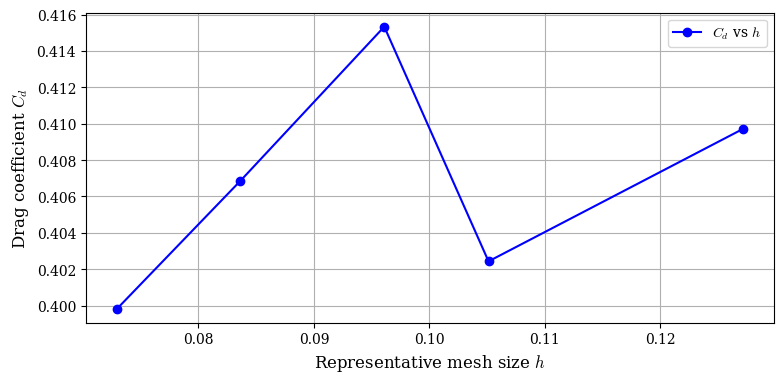

In [208]:


# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_clan['h'], df_clan['Cd'], 'b-o', label=r'$C_d$ vs $h$')


ax.set_xlabel(r'Representative mesh size $h$')
ax.set_ylabel(r'Drag coefficient $C_d$')
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.savefig("./results/CdMesh.pdf")


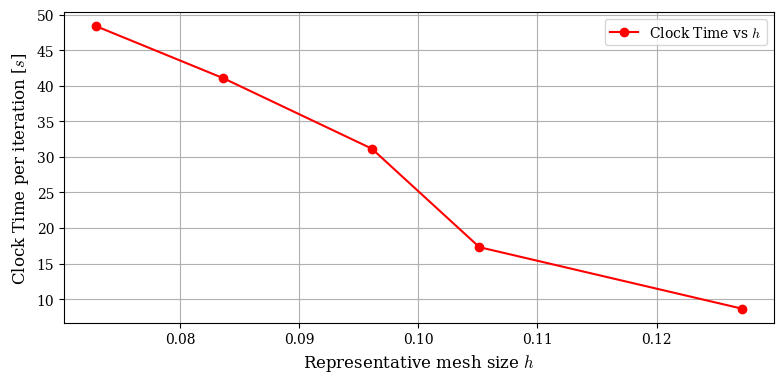

In [209]:
# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_clan['h'], df_clan['clock_time'], 'r-o', label=r'Clock Time vs $h$')



ax.set_xlabel(r'Representative mesh size $h$')
ax.set_ylabel(r'Clock Time per iteration [$s$]')
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.savefig("./results/ClockTimeMesh.pdf")


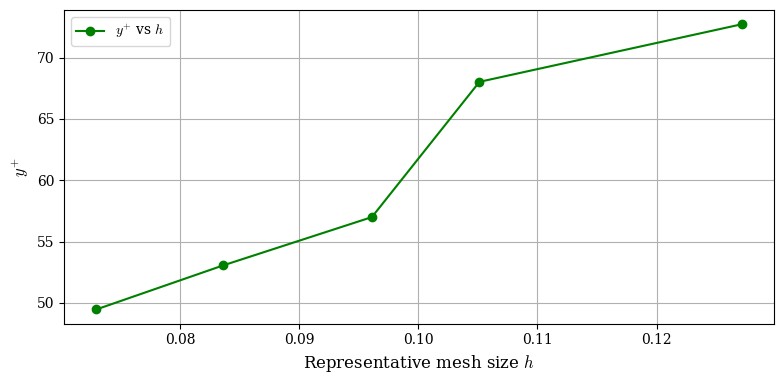

In [210]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_clan['h'], df_clan['max_yplus'], 'g-o', label=r'$y^{+}$ vs $h$')

# Labels
ax.set_xlabel(r'Representative mesh size $h$')
ax.set_ylabel(r'$y^{+}$')
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.savefig("./results/yPlusMesh.pdf")

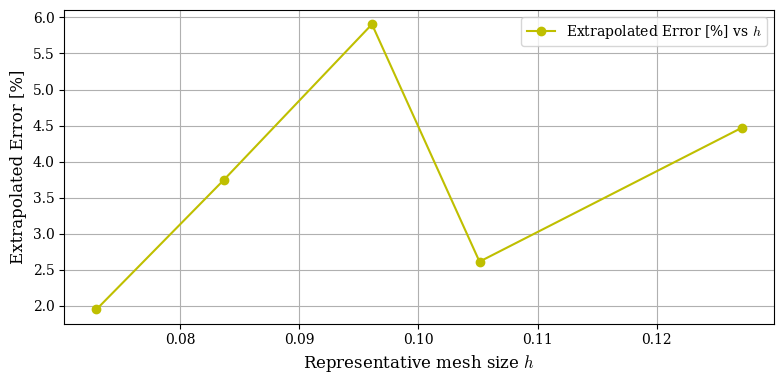

In [211]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_clan['h'], df_clan['error'], 'y-o', label=r'Extrapolated Error [%] vs $h$')

# Labels
ax.set_xlabel(r'Representative mesh size $h$')
ax.set_ylabel(r'Extrapolated Error [%]')
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.savefig("./results/errorMesh.pdf")

# Countours

In [ ]:

sliceZ = pv.read("Data/CollectedResults/AoA_2p0_Ma_1p2/postProcessing/sliceCentreZ/4400/planeSlice.vtp")

sliceZ


PolyData (0x7f957a7b9360)
  N Cells:    109255
  N Points:   112338
  N Strips:   0
  X Bounds:   -8.000e+00, 3.000e+01
  Y Bounds:   -1.000e+01, 1.000e+01
  Z Bounds:   -4.016e-05, 2.118e-05
  N Arrays:   8

In [271]:
import matplotlib.tri as mtri

In [ ]:
def compute_center_of_pressure(mesh, pressure_field='p'):
    pressure = mesh[pressure_field]
    cell_centers = mesh.cell_centers()
    cell_areas = mesh.compute_cell_sizes()['Area']
    mesh_n = mesh.compute_normals(cell_normals=True, point_normals=False)
    normals = mesh_n['Normals']
    if pressure.size == mesh.n_points:
        mesh_copy = mesh.copy()
        mesh_copy[pressure_field] = pressure
        cell_data = mesh_copy.cell_data_to_point_data().point_data_to_cell_data()
        pressure_cells = cell_data[pressure_field]
    else:
        pressure_cells = pressure
    ref = np.array([mesh.bounds[0], 0, 0])
    forces = pressure_cells[:,None] * cell_areas[:,None] * (-normals)
    total_force = forces.sum(axis=0)
    centers = cell_centers.points
    moments = np.cross(centers - ref, forces)
    total_moment = moments.sum(axis=0)
    cp_x = ref[0] + total_moment[2]/total_force[1] if abs(total_force[1]) > 1e-10 else ref[0]
    cp_y = ref[1] - total_moment[2]/total_force[0] if abs(total_force[0]) > 1e-10 else ref[1]
    return np.array([cp_x, cp_y, ref[2]])


In [350]:
cp = compute_center_of_pressure(rocket, pressure_field='p')
cp

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


{'total_force': pyvista_ndarray([-449.65922669, -379.11567558,    3.43159801]),
 'total_moment': array([-4.52162882e-01, -7.84596035e+00, -8.49049682e+02]),
 'reference_point': array([4.94354072e-11, 0.00000000e+00, 0.00000000e+00]),
 'center_of_pressure': array([ 2.23955309, -1.88820696,  0.        ])}

In [363]:
def plot_mach_contour_with_cp_cg(sliceZ, rocket, cmap='jet', Ma=1.2, cg=1.8):
    Cop = compute_center_of_pressure(rocket, pressure_field='p')['center_of_pressure']
    cp_x, cp_y = Cop[0], Cop[1]

    tri_mesh = sliceZ.triangulate()
    faces = tri_mesh.faces.reshape(-1, 4)[:, 1:]

    pts = tri_mesh.points
    x, y = pts[:, 0], pts[:, 1]
    var = tri_mesh['Ma']

    triang = mtri.Triangulation(x, y, faces)
    fig, ax = plt.subplots(figsize=(20, 14), facecolor='white')
    cont = ax.tricontourf(triang, var, cmap=cmap, levels=400)

    theta = np.degrees(np.arcsin(1 / Ma))
    L = 15
    x_off, y_off = L * np.cos(np.radians(theta)), L * np.sin(np.radians(theta))

    ax.plot([0, x_off], [0, y_off], '--k')
    ax.plot([0, x_off], [0, -y_off], '--k')
    ax.text(-1.2, 0.5, f"Shock Angle={theta:.2f}°", color='black')

    ax.plot(cp_x, 0.0, 'ro', markersize=8)
    ax.text(cp_x - 0.1, 0.3, 'CoP', color='red', fontsize=14)
    arrow = FancyArrowPatch((0.0, -0.2), (cp_x, -0.2), arrowstyle='<->', color='red',
                            linewidth=1, mutation_scale=20)
    ax.add_patch(arrow)
    ax.text(cp_x / 2 - 0.1, -0.4, f'{cp_x:.2f} m', color='red', fontsize=14)

    ax.plot(cg, 0.0, 'bo', markersize=8)
    ax.text(cg - 0.1, 0.3, 'CoG', color='blue', fontsize=14)
    arrow = FancyArrowPatch((0.0, 0.2), (cg, 0.2), arrowstyle='<->', color='blue',
                            linewidth=1, mutation_scale=20)
    ax.add_patch(arrow)
    ax.text(cg / 2 - 0.1, 0.3, f'{cg:.2f} m', color='blue', fontsize=14)

    ax.set_xlim(-2, 10)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    cb = fig.colorbar(cont, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cb.set_label('Mach number')

    plt.tight_layout()
    plt.show()
    
    return fig
    
    


In [364]:
def plot_pressure_contour_with_cp_cg(sliceZ, rocket, cmap='seismic', Ma=1.2, cg=1.8):
    Cop = compute_center_of_pressure(rocket, pressure_field='p')['center_of_pressure']
    cp_x, cp_y = Cop[0], Cop[1]

    tri_mesh = sliceZ.triangulate()
    faces = tri_mesh.faces.reshape(-1, 4)[:, 1:]

    pts = tri_mesh.points
    x, y = pts[:, 0], pts[:, 1]
    var = tri_mesh['p']

    triang = mtri.Triangulation(x, y, faces)
    fig, ax = plt.subplots(figsize=(20, 14), facecolor='white')
    cont = ax.tricontourf(triang, var, cmap=cmap, levels=400)

    theta = np.degrees(np.arcsin(1 / Ma))
    L = 15
    x_off, y_off = L * np.cos(np.radians(theta)), L * np.sin(np.radians(theta))
    ax.plot([0, x_off], [0, y_off], '--k')
    ax.plot([0, x_off], [0, -y_off], '--k')
    ax.text(-1.2, 0.5, f"Shock Angle={theta:.2f}°", color='black')

    ax.plot(cp_x, 0.0, 'ro', markersize=8)
    ax.text(cp_x - 0.1, 0.3, 'CoP', color='red', fontsize=14)
    arrow = FancyArrowPatch((0.0, -0.2), (cp_x, -0.2), arrowstyle='<->',
                            color='red', linewidth=1, mutation_scale=20)
    ax.add_patch(arrow)
    ax.text(cp_x / 2 - 0.1, -0.4, f'{cp_x:.2f} m', color='red', fontsize=14)

    ax.plot(cg, 0.0, 'yo', markersize=8)
    ax.text(cg - 0.1, 0.3, 'CoG', color='yellow', fontsize=14)
    arrow = FancyArrowPatch((0.0, 0.2), (cg, 0.2), arrowstyle='<->',
                            color='yellow', linewidth=1, mutation_scale=20)
    ax.add_patch(arrow)
    ax.text(cg / 2 - 0.1, 0.3, f'{cg:.2f} m', color='yellow', fontsize=14)

    ax.set_xlim(-2, 10)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    cb = fig.colorbar(cont, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cb.set_label('Pressure [Pa]')

    plt.tight_layout()
    plt.show()
    
    return fig

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


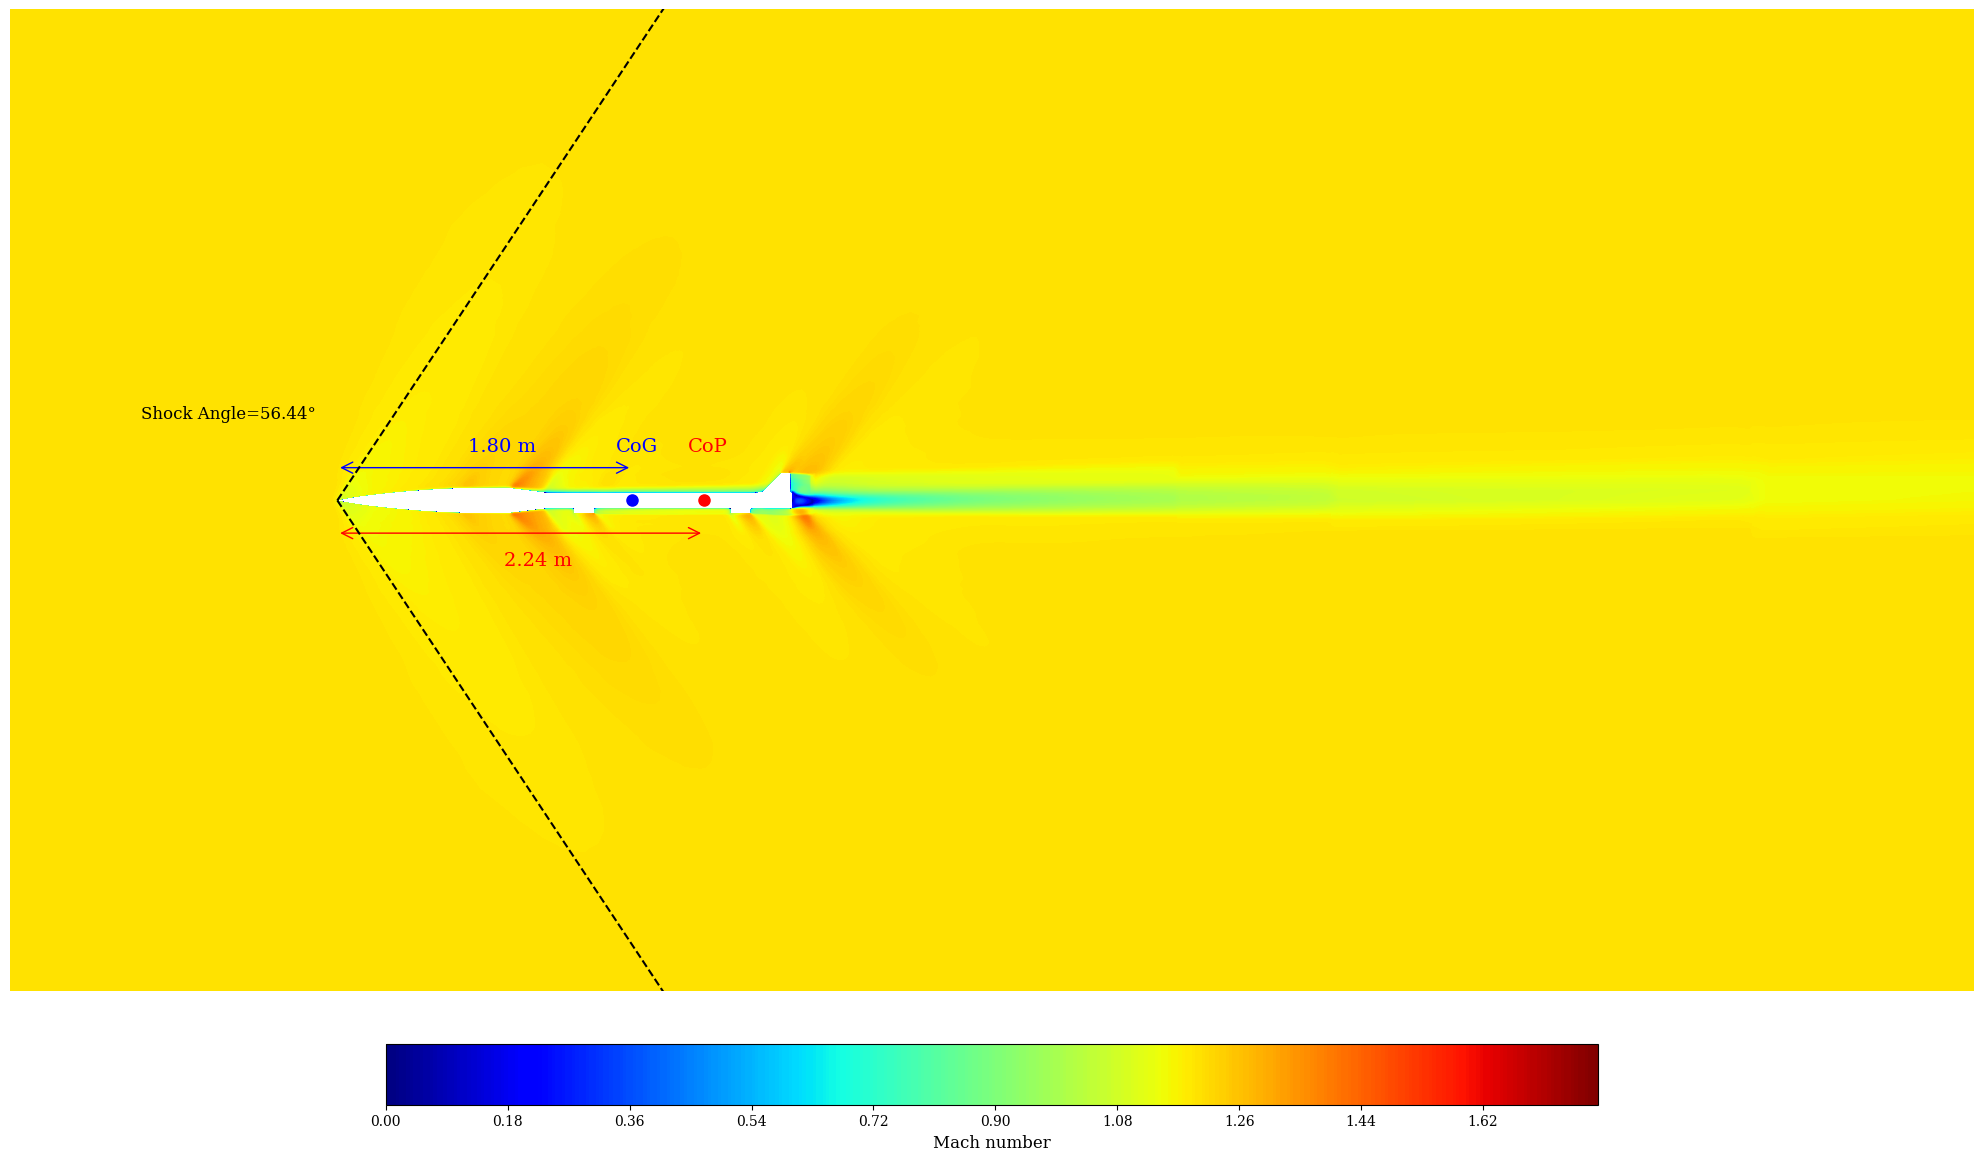

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


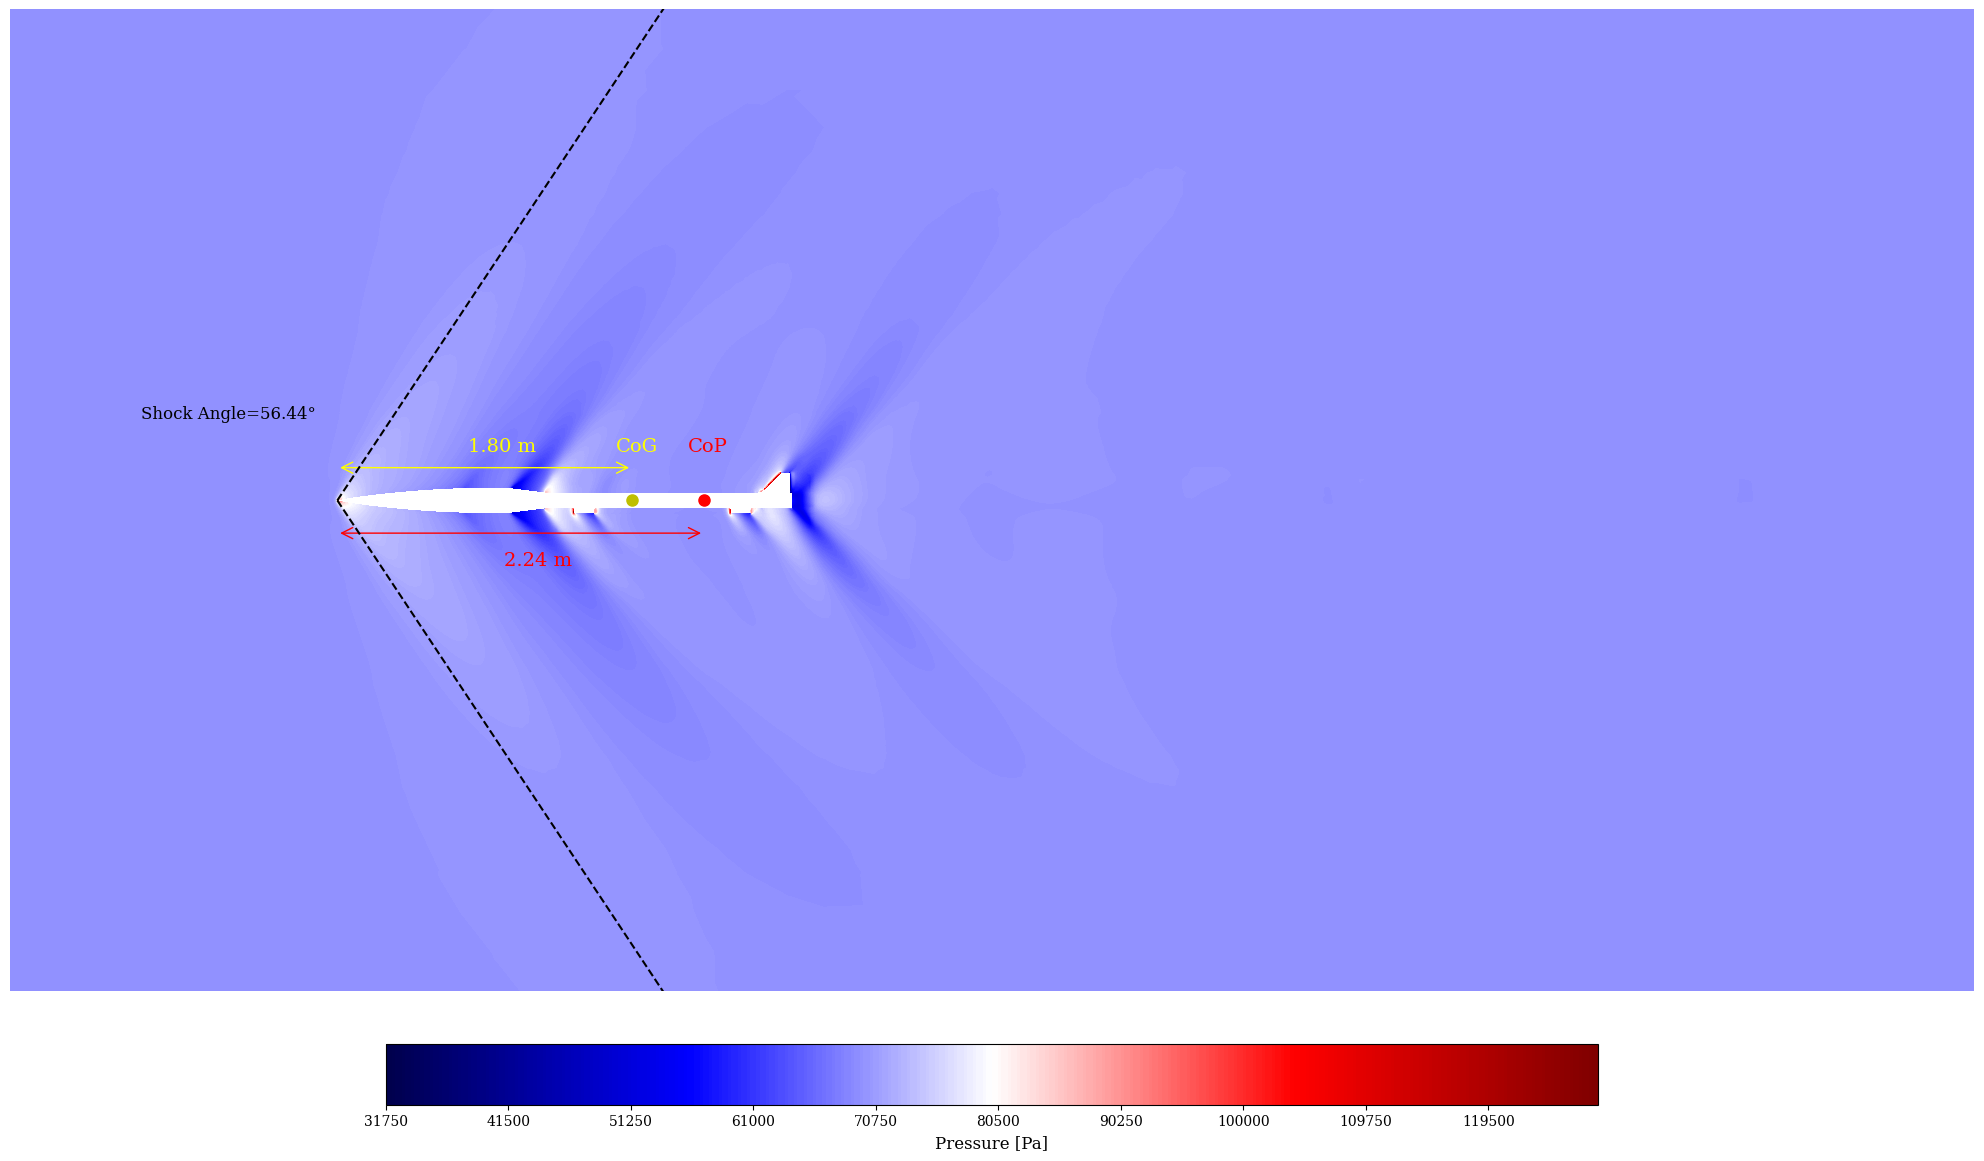

In [359]:
sliceZ = pv.read("Data/CollectedResults/AoA_2p0_Ma_1p2/postProcessing/sliceCentreZ/4400/planeSlice.vtp")
rocket = pv.read("Data/CollectedResults/AoA_2p0_Ma_1p2/postProcessing/rocketVTK/4400/rocketWall.vtp")

plot_mach_contour_with_cp_cg(sliceZ, rocket, cmap='jet', Ma=1.2, cg=1.8)

plot_pressure_contour_with_cp_cg(sliceZ, rocket, cmap='seismic', Ma=1.2, cg=1.8)


In [361]:
from pathlib import Path

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


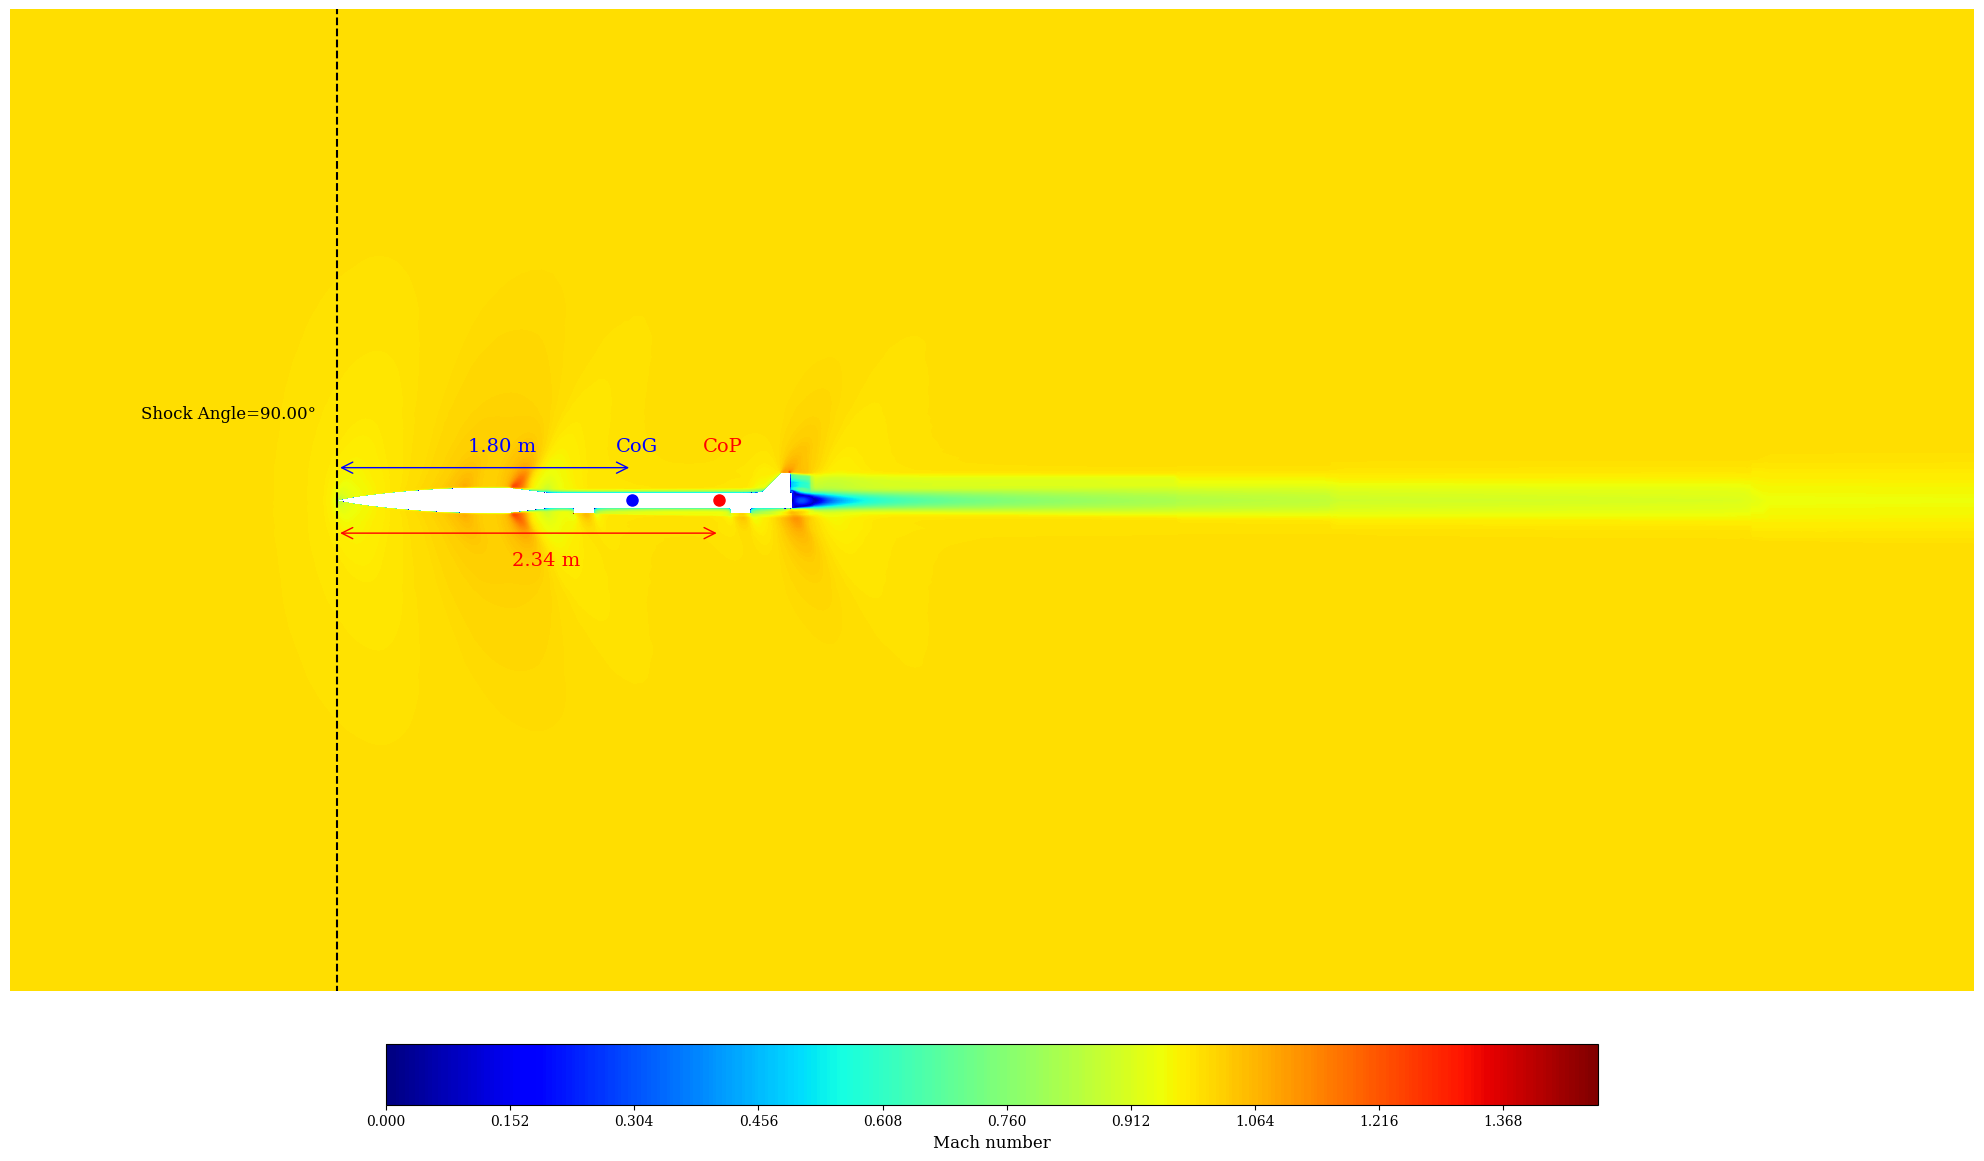

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


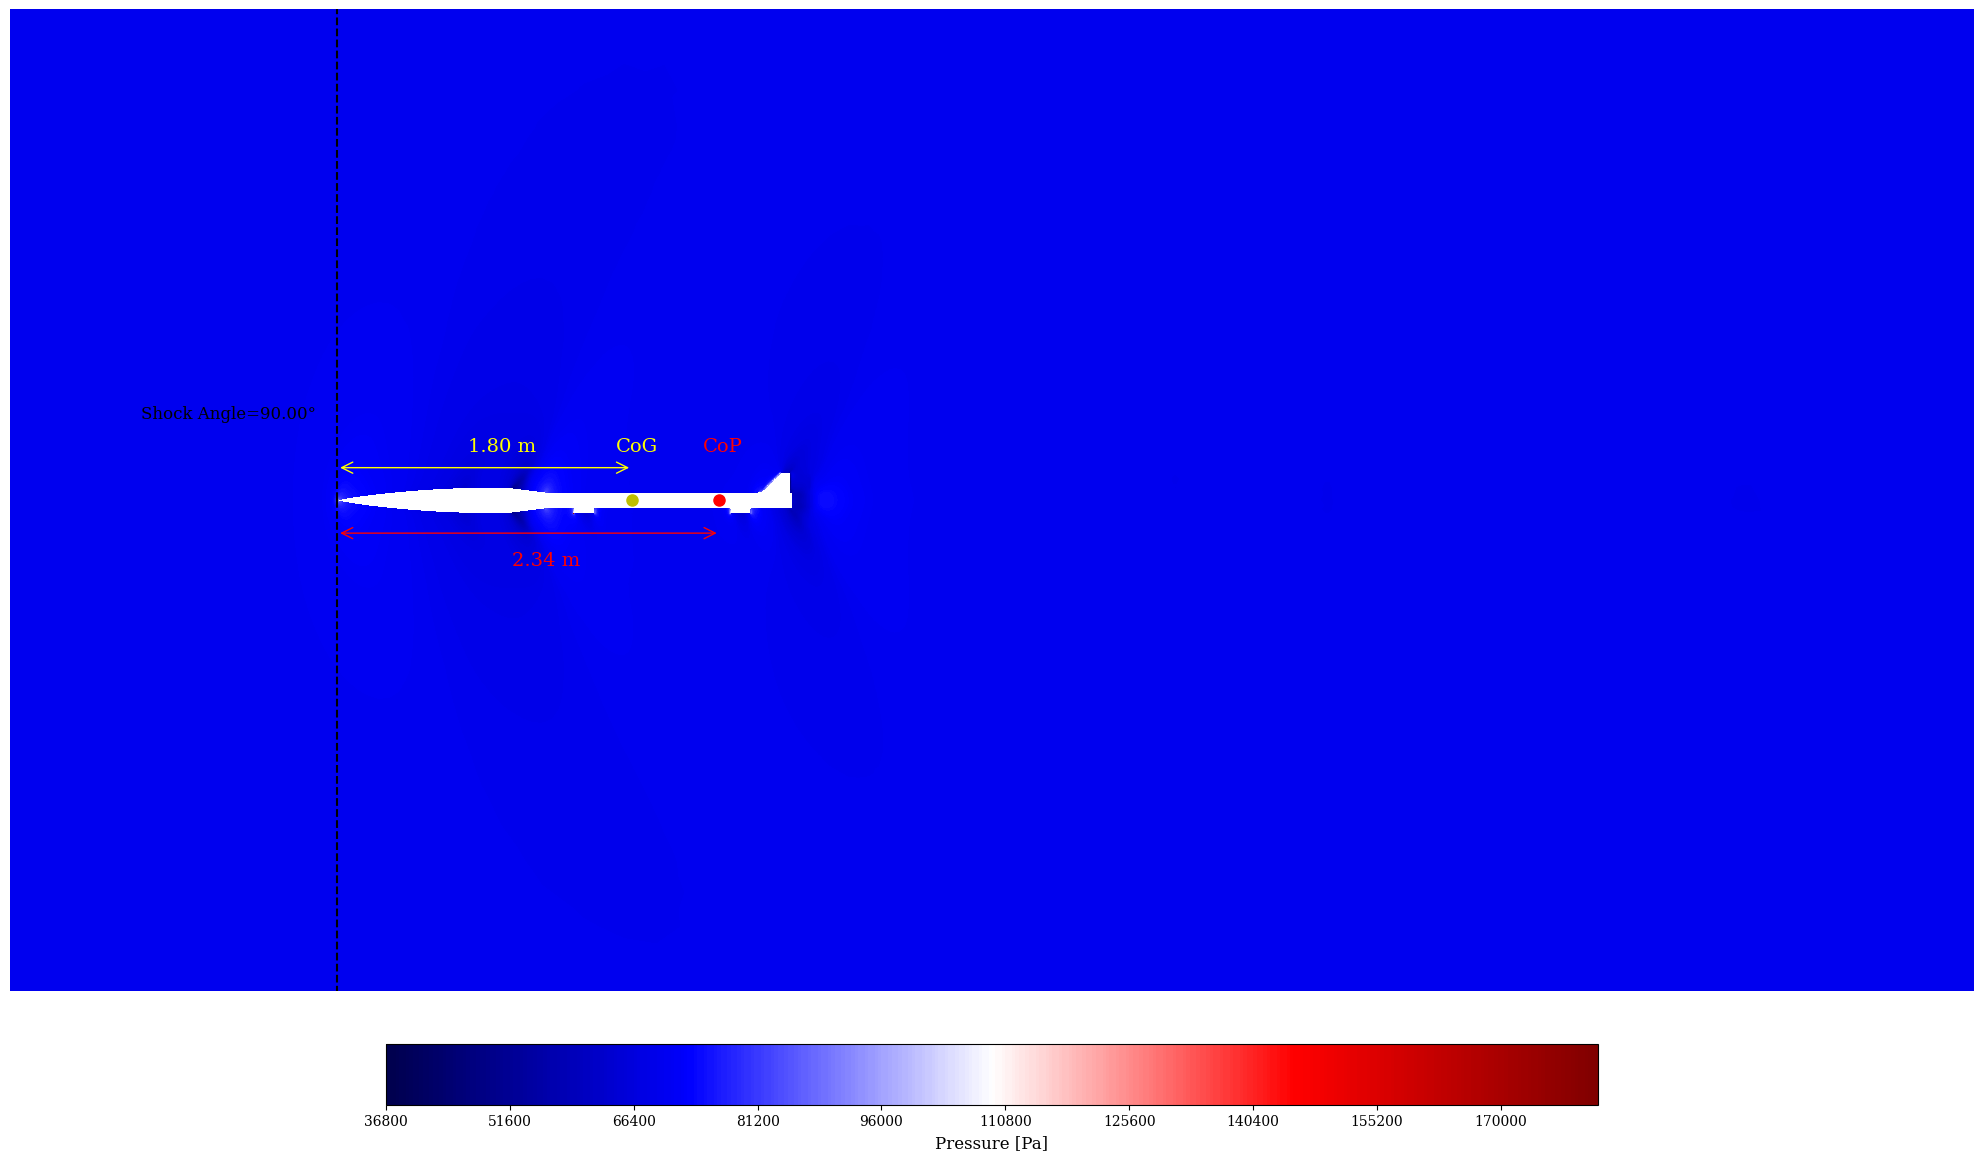

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


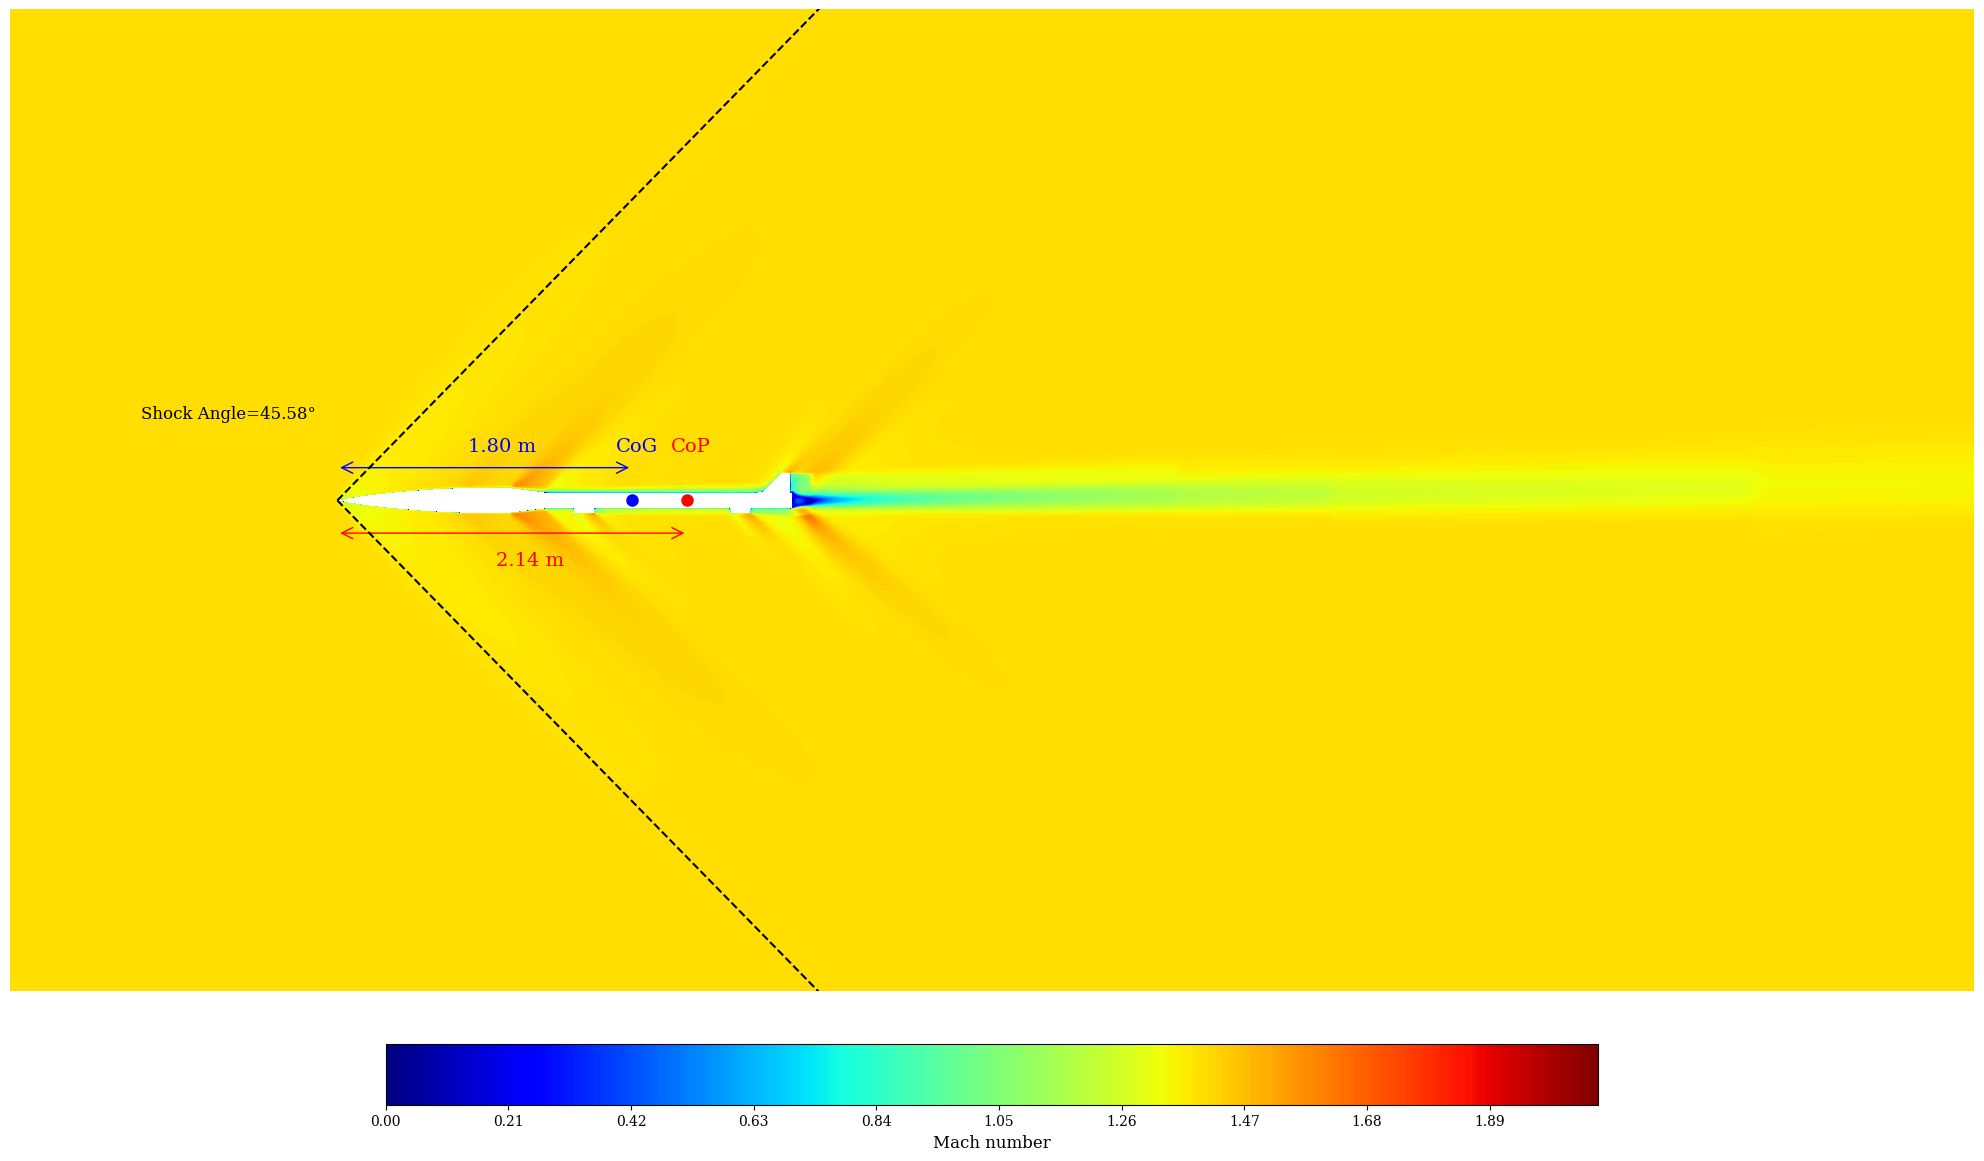

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


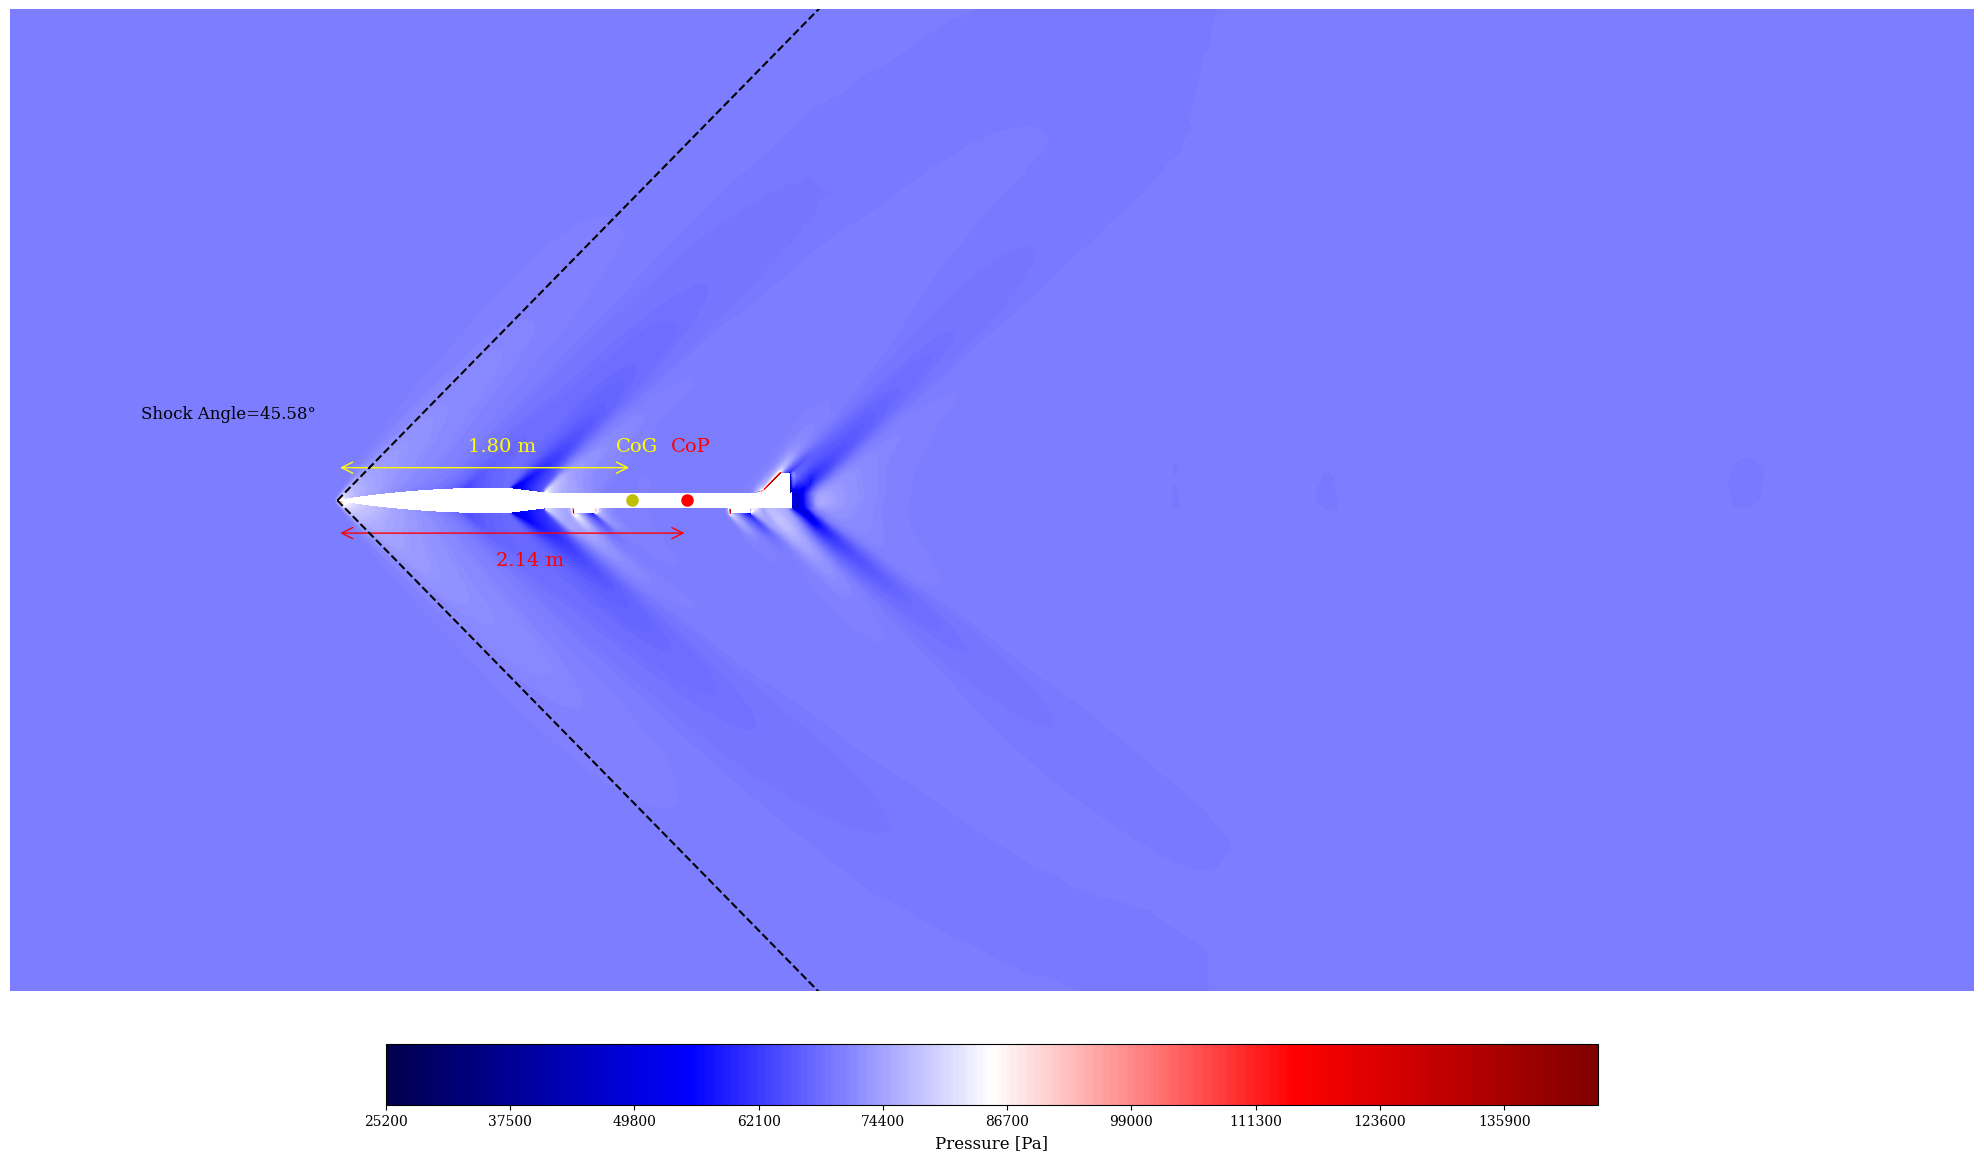

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/1125932735.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


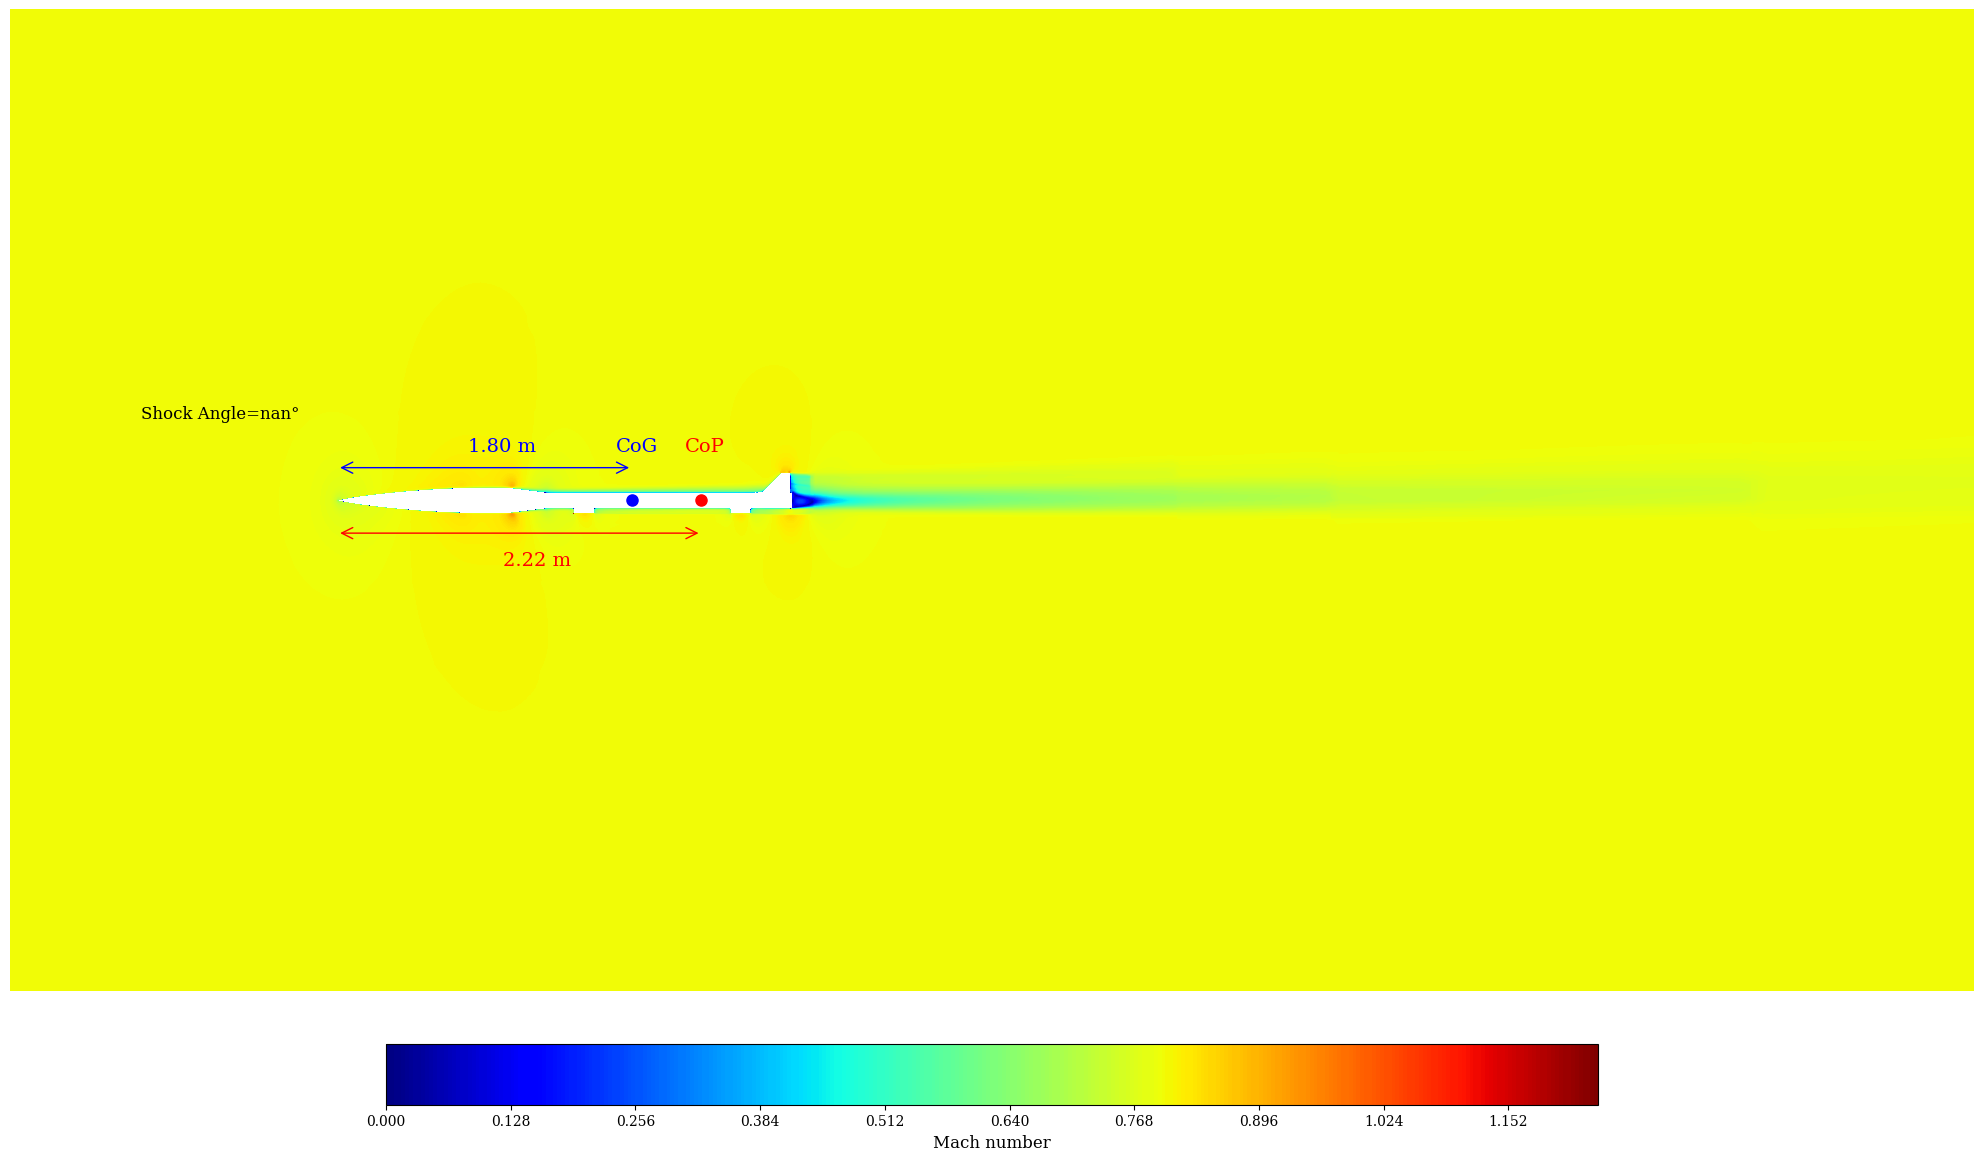

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/36085290.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


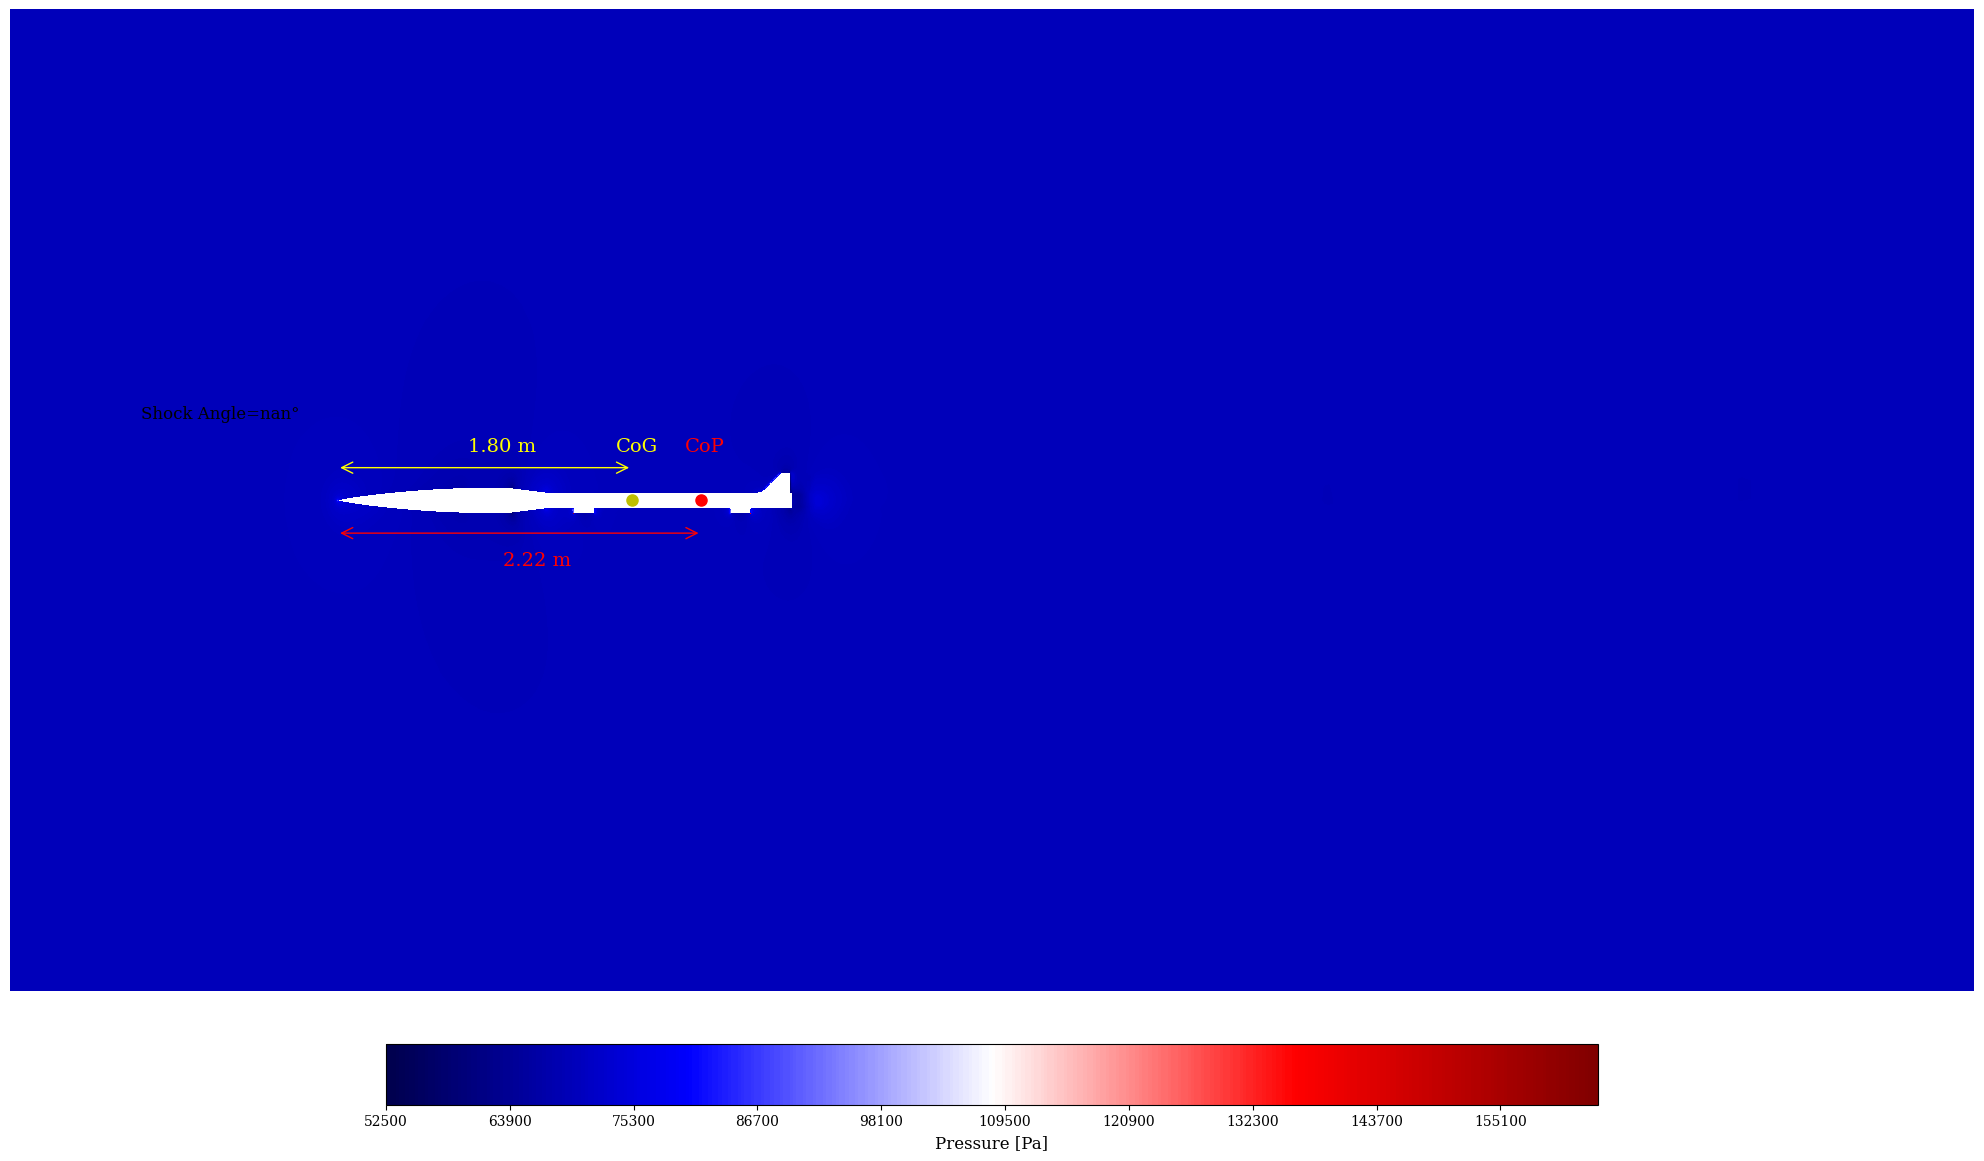

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


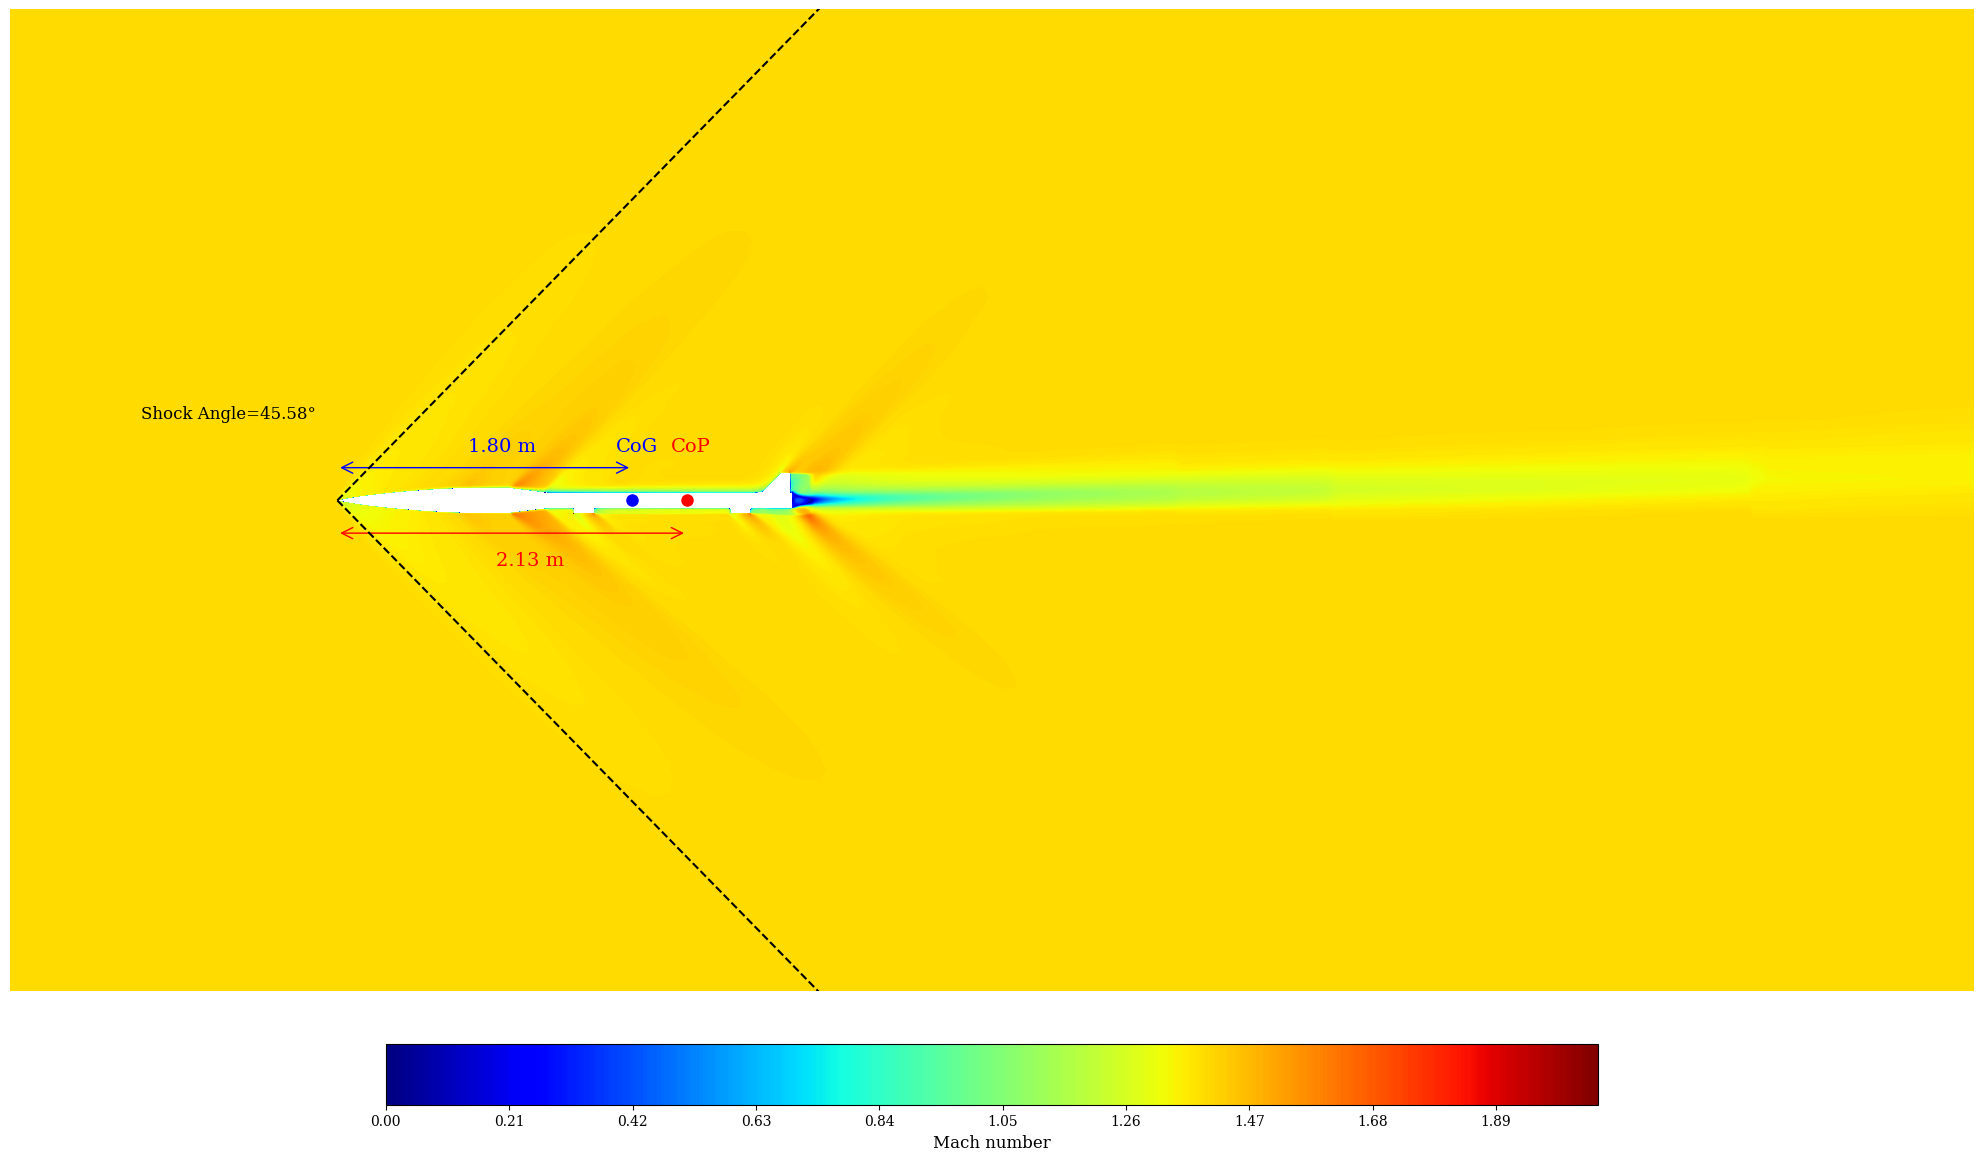

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


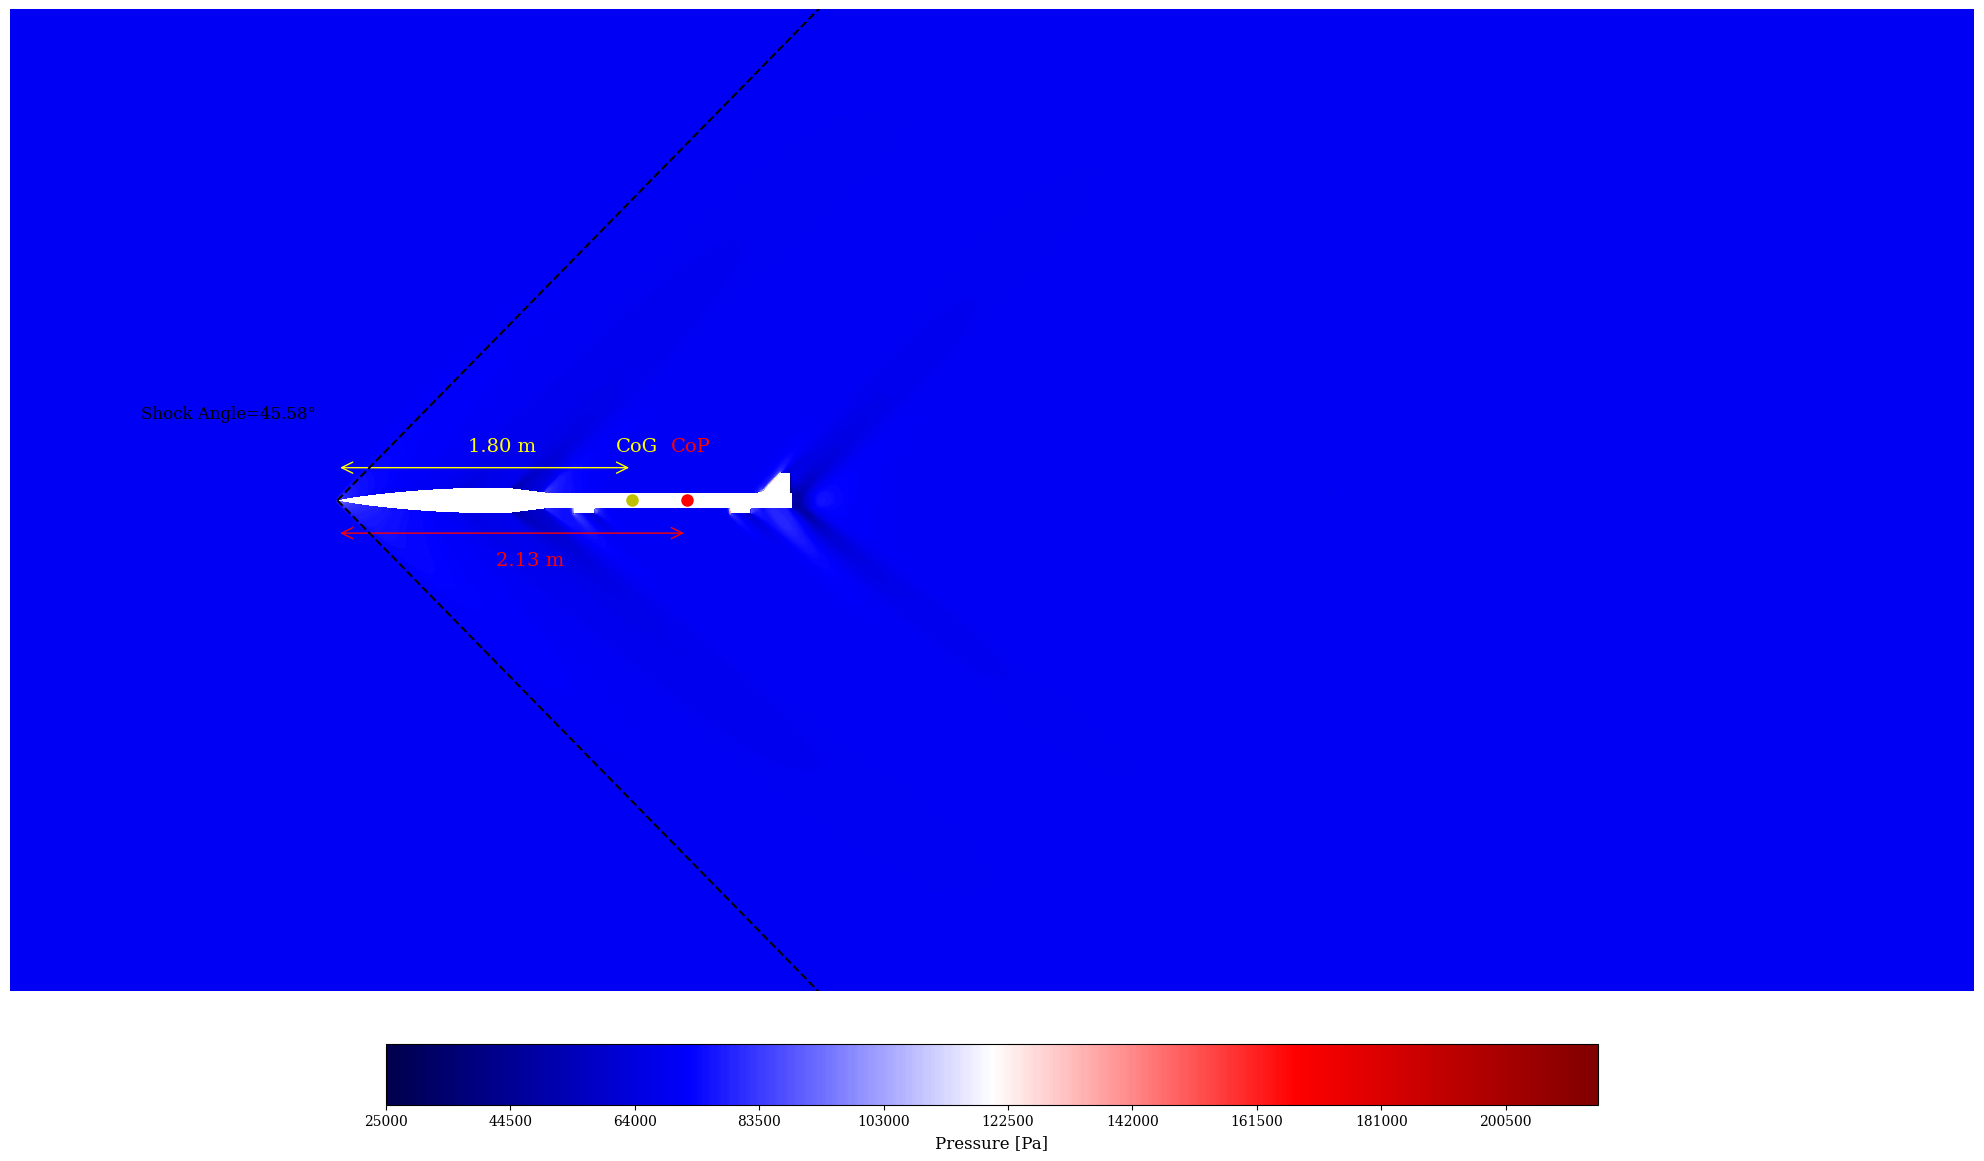

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


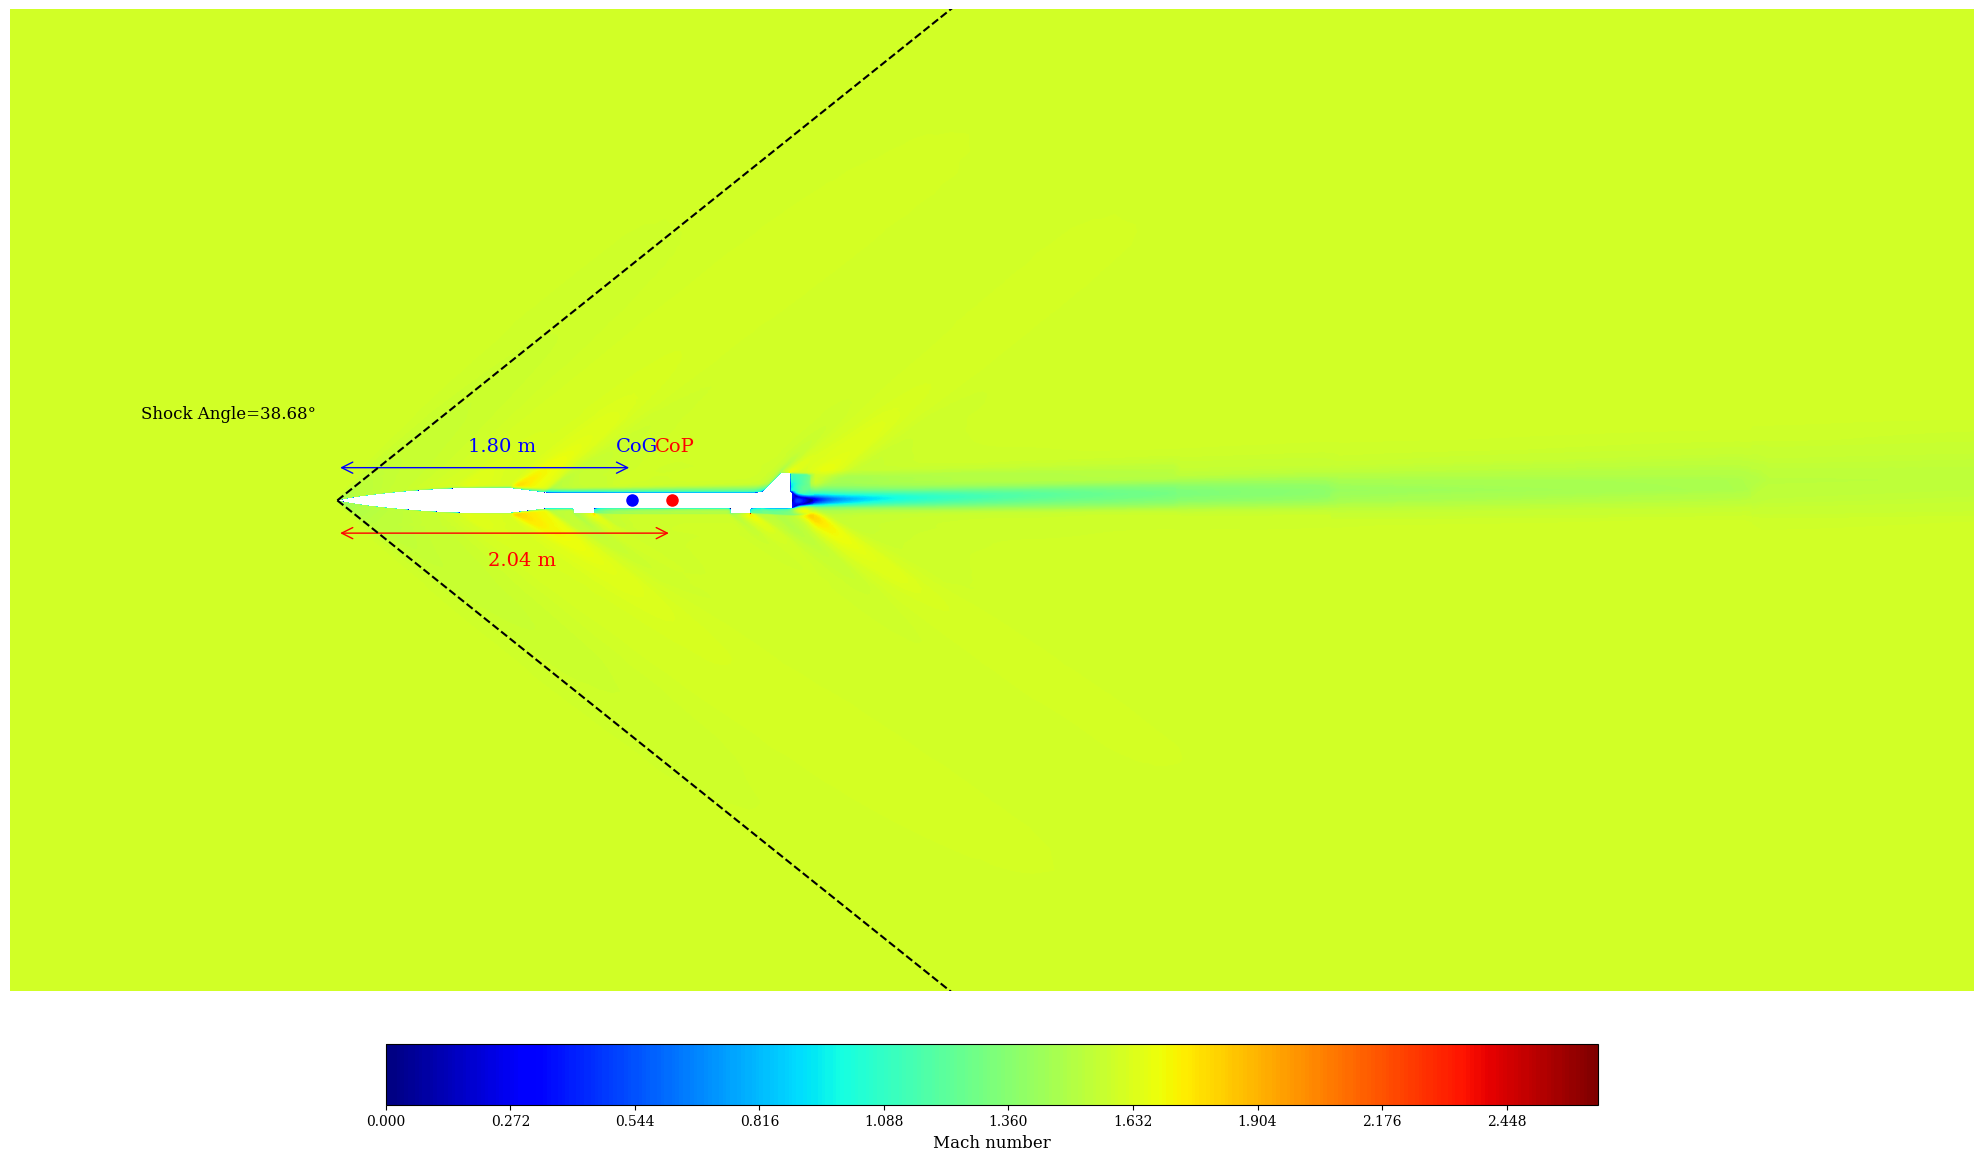

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


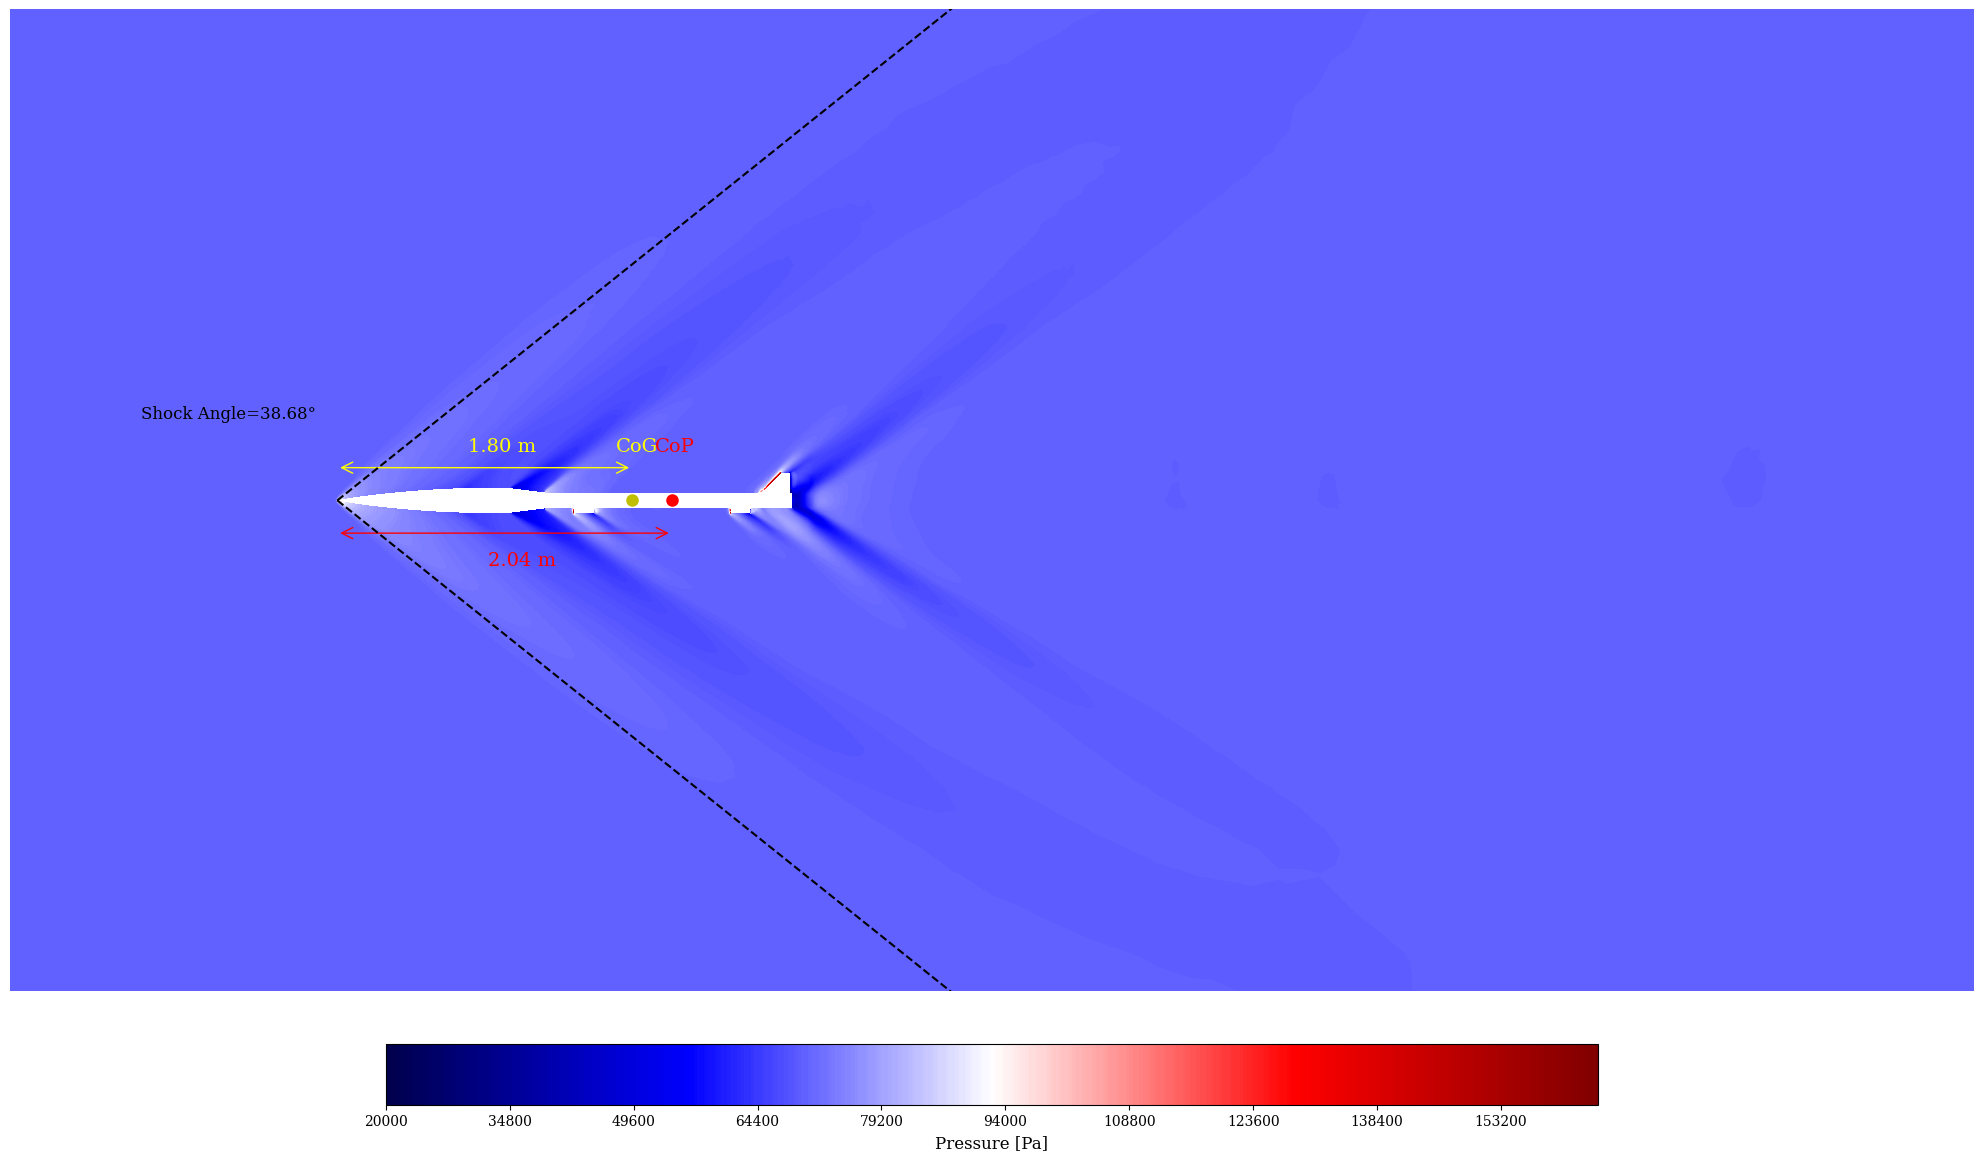

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


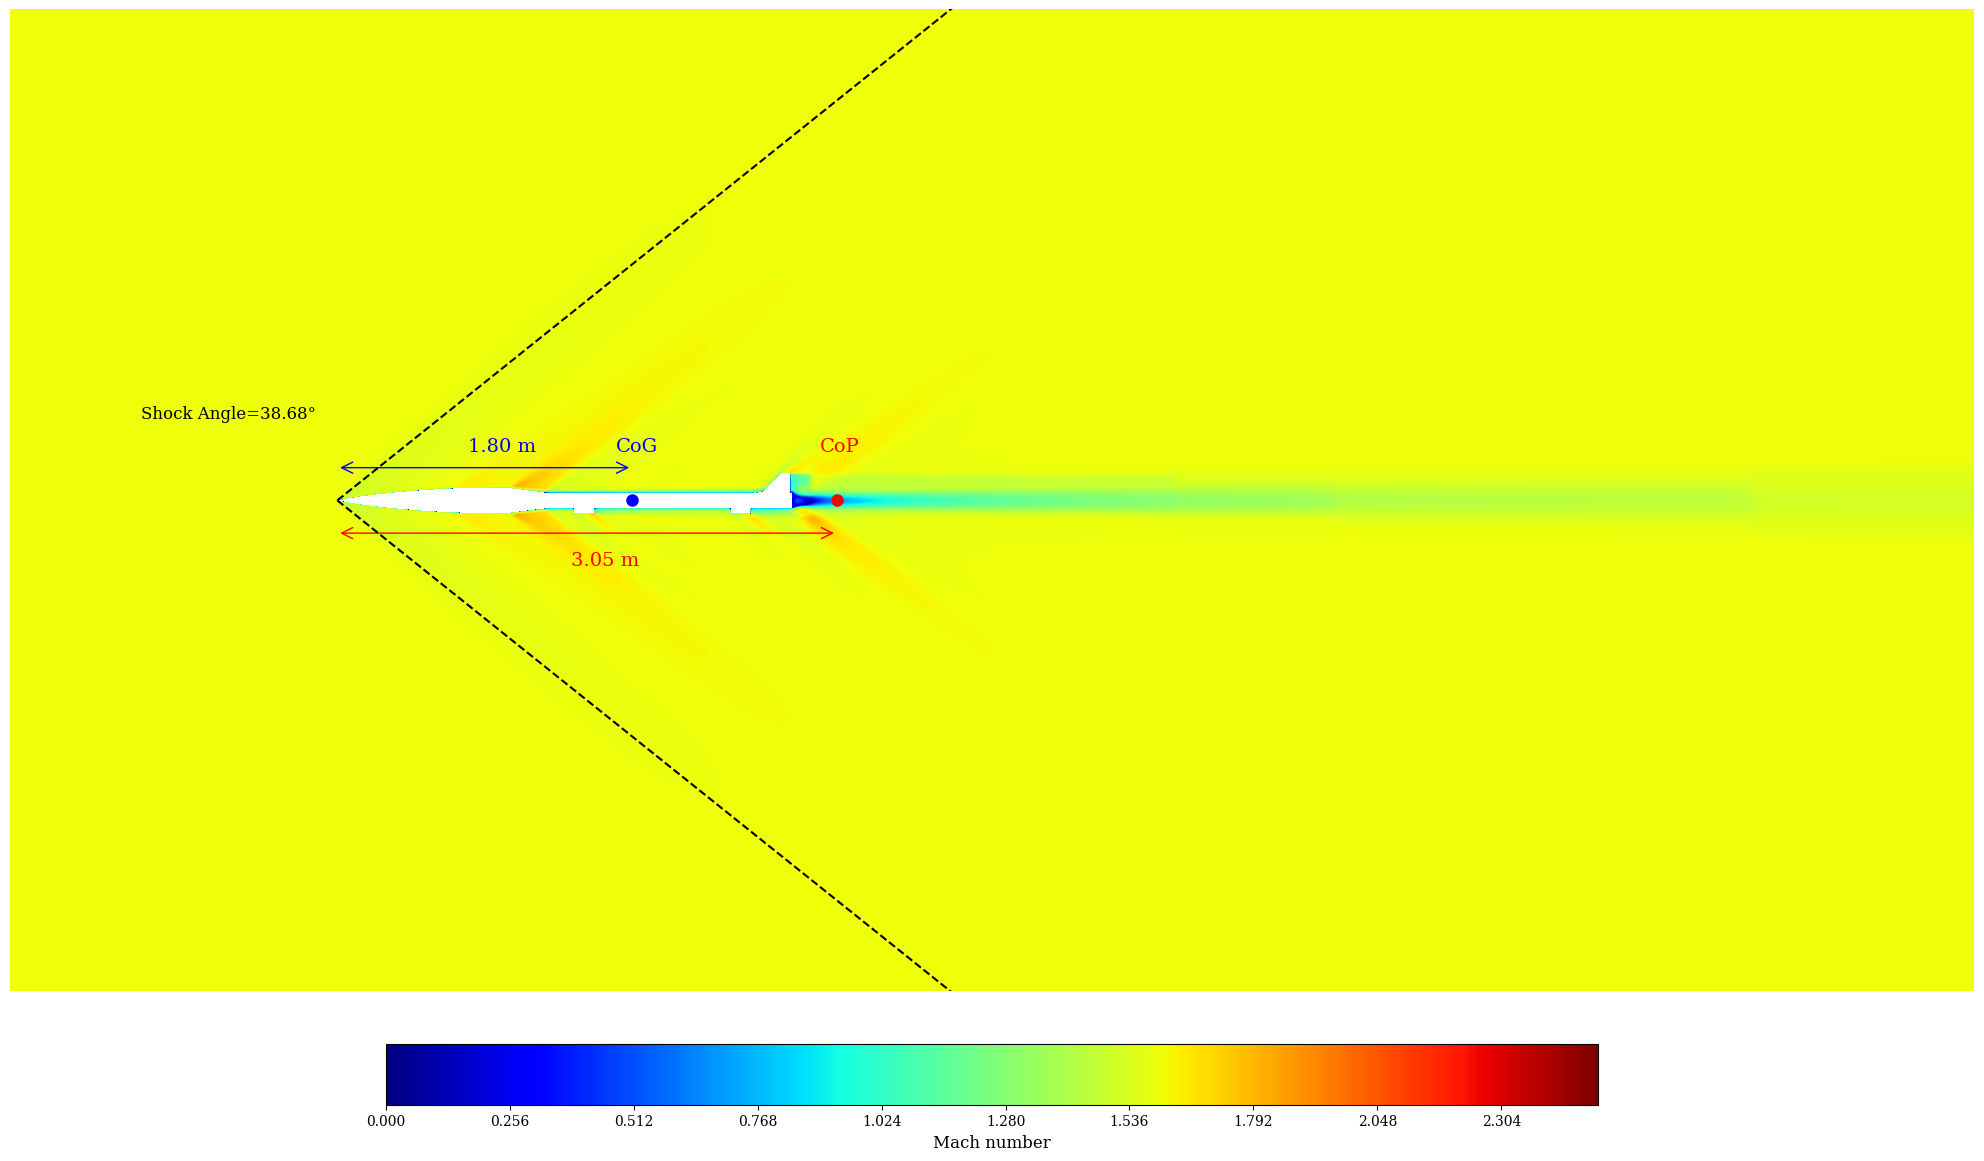

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


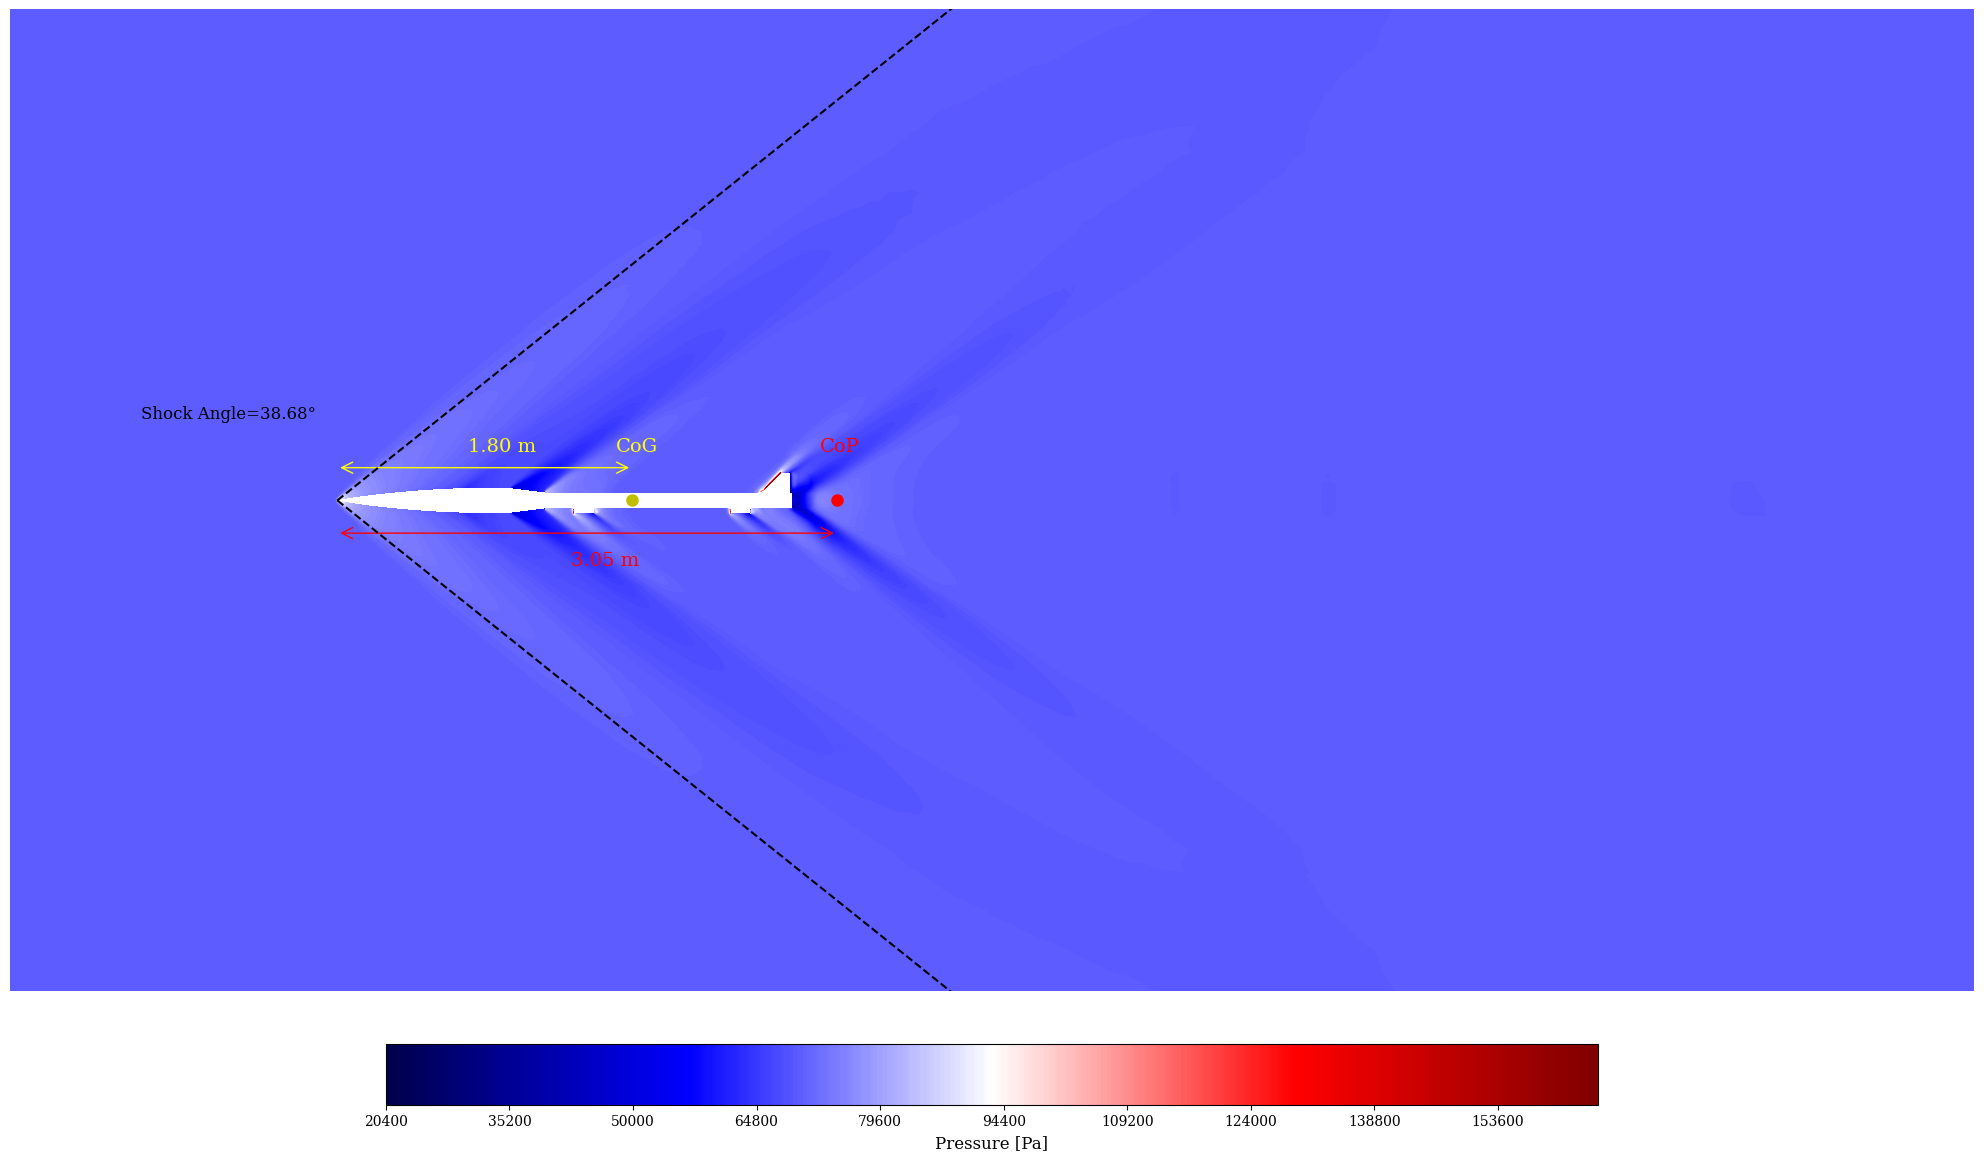

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


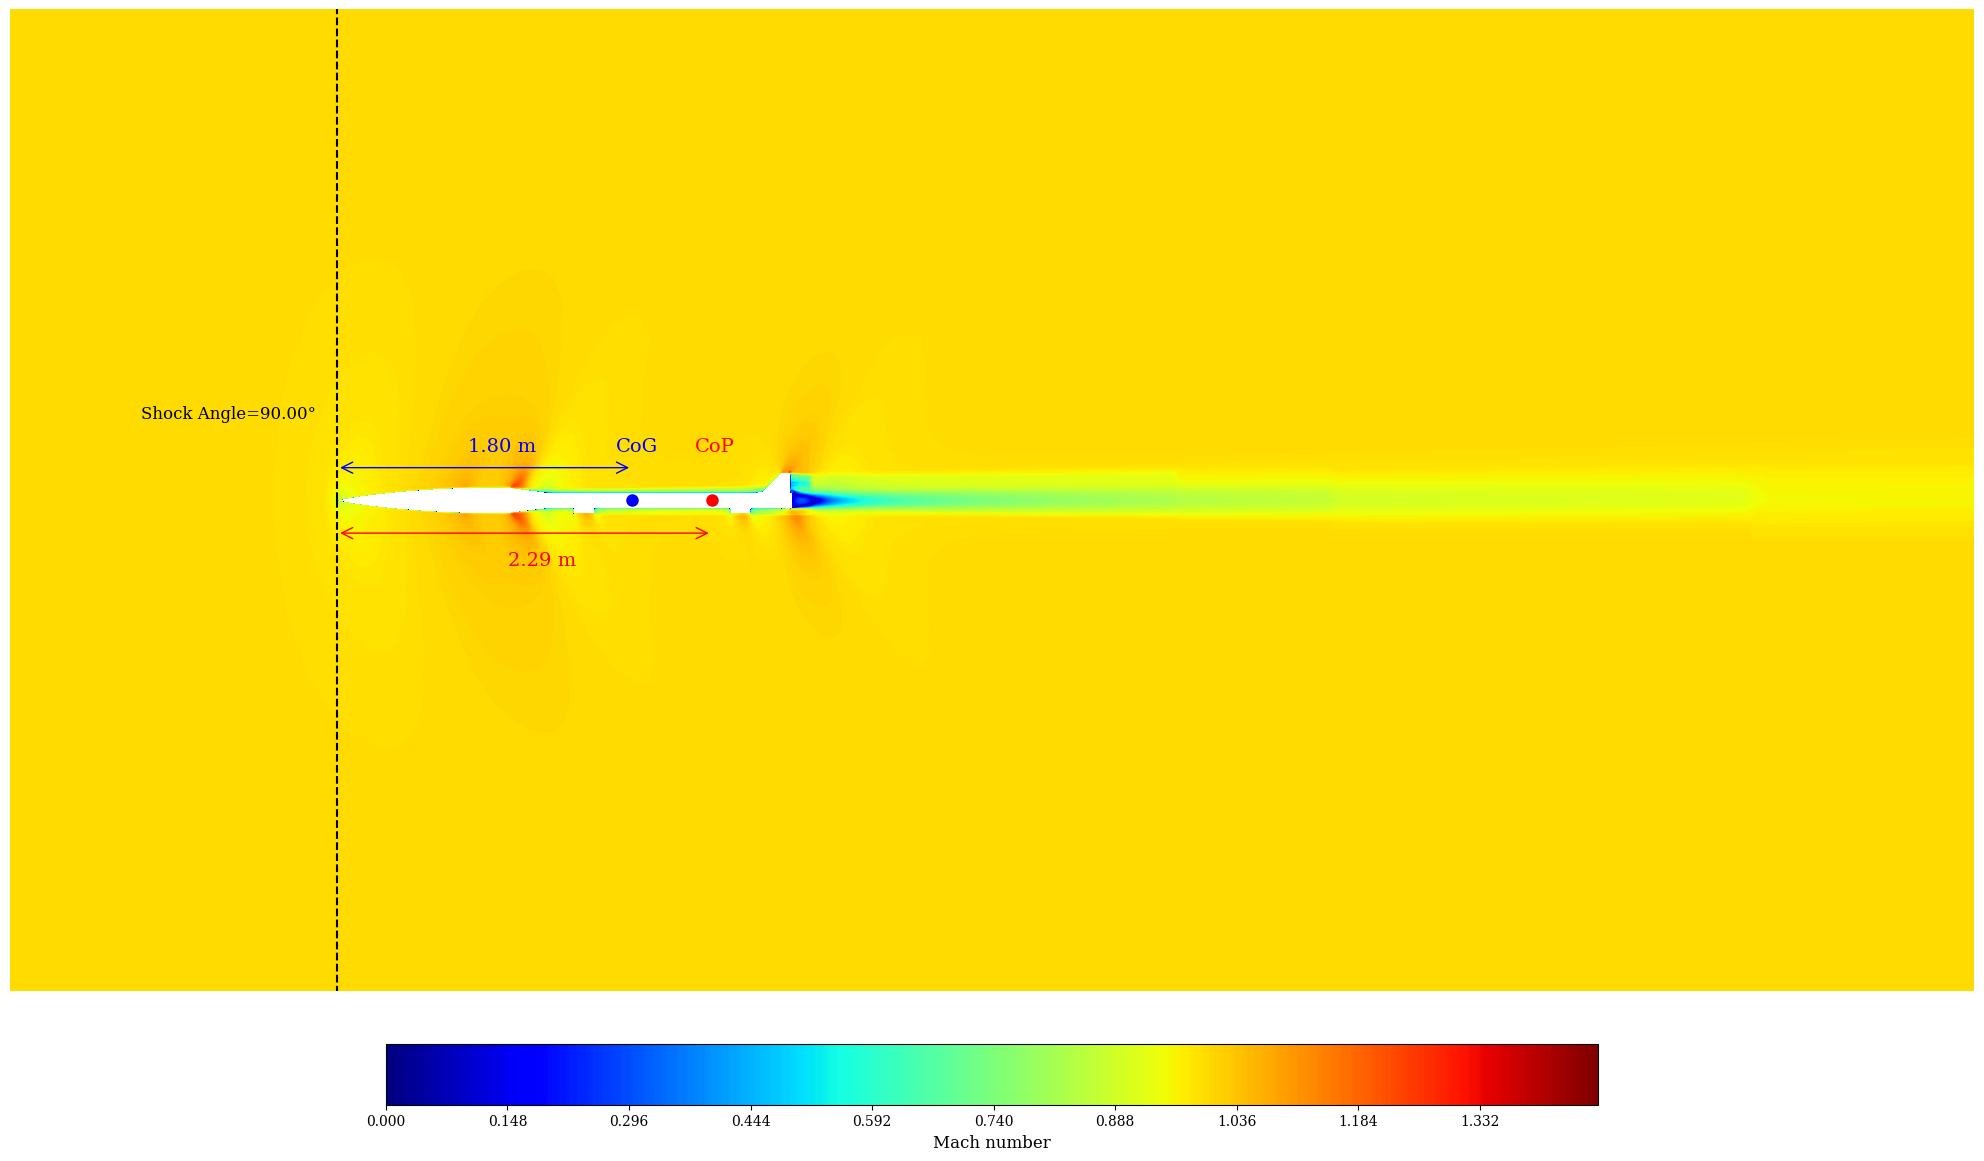

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


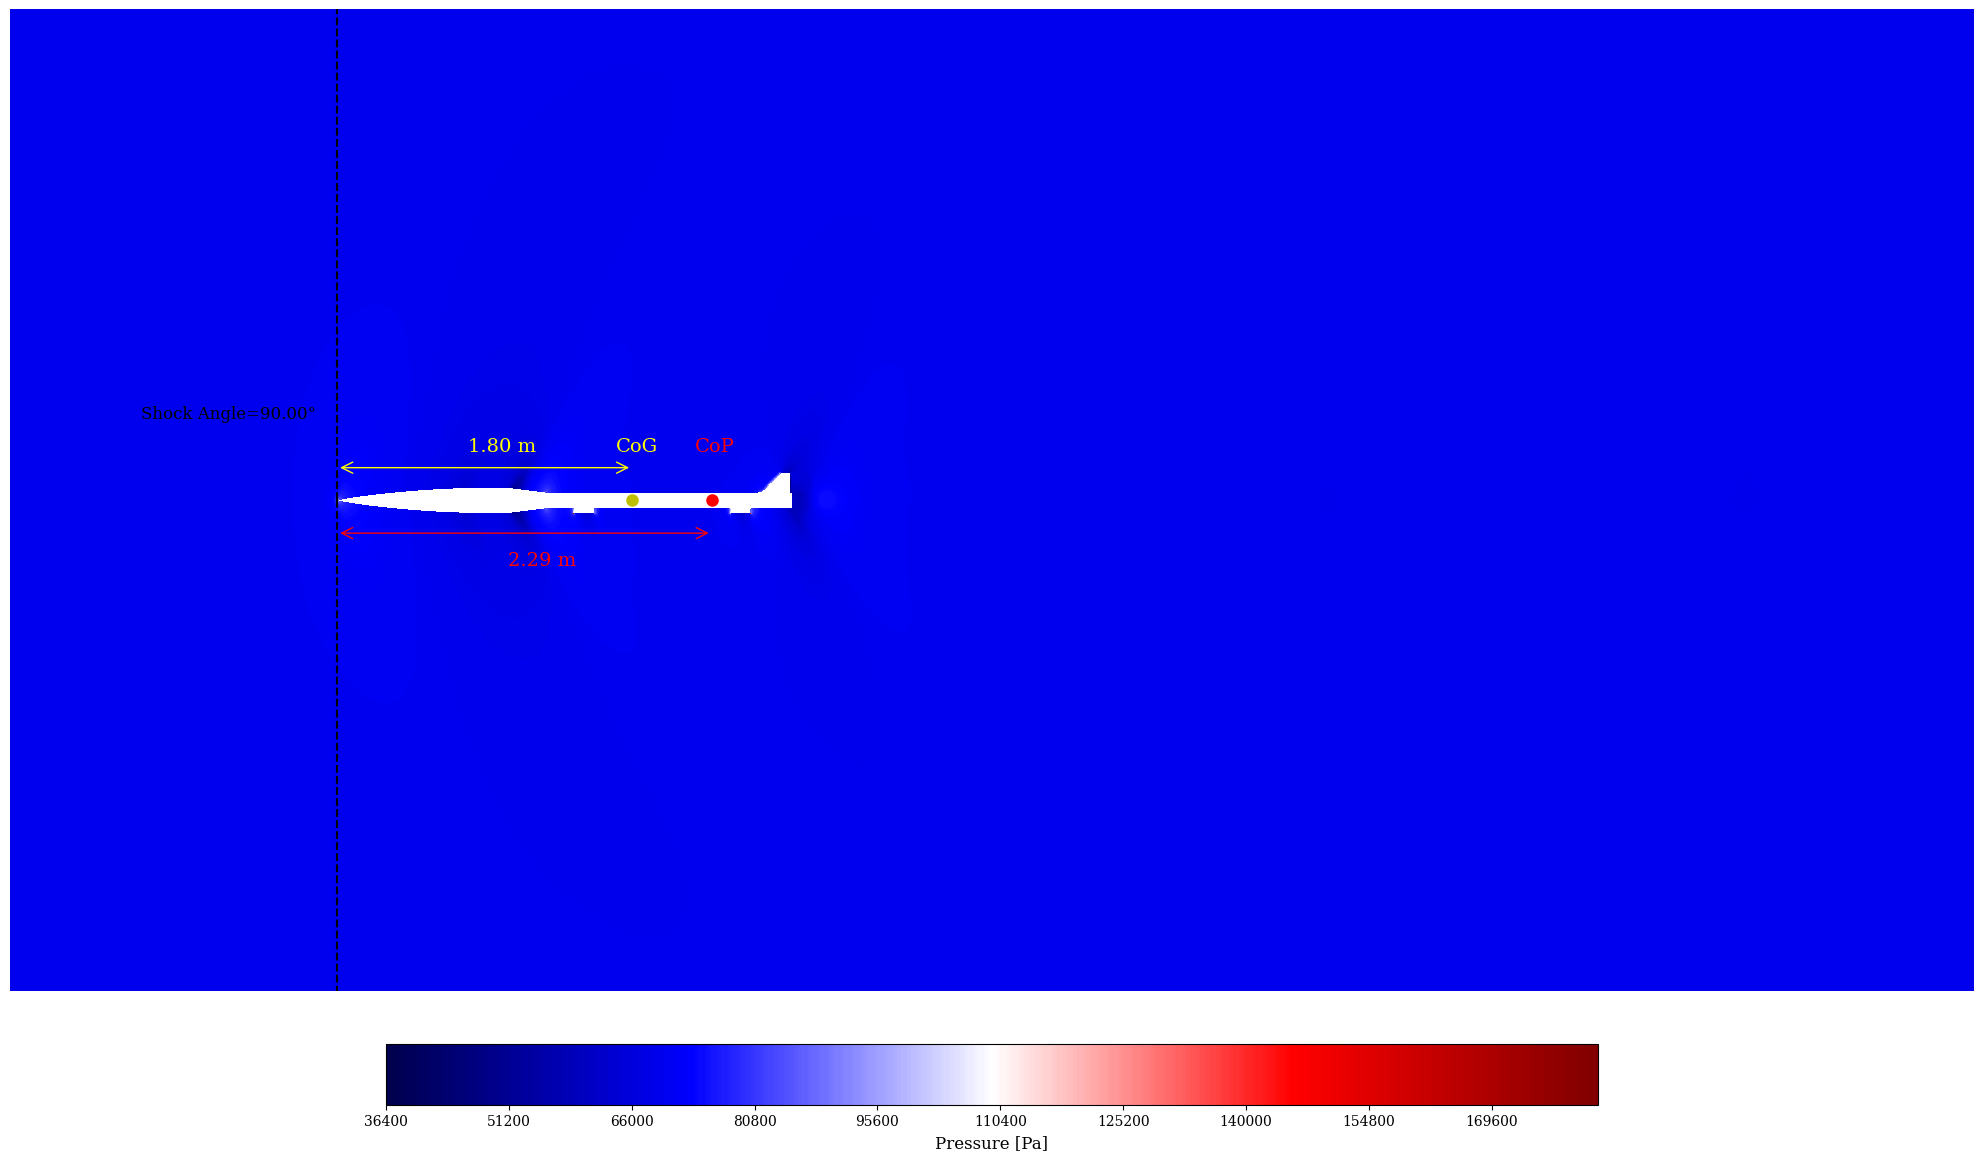

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


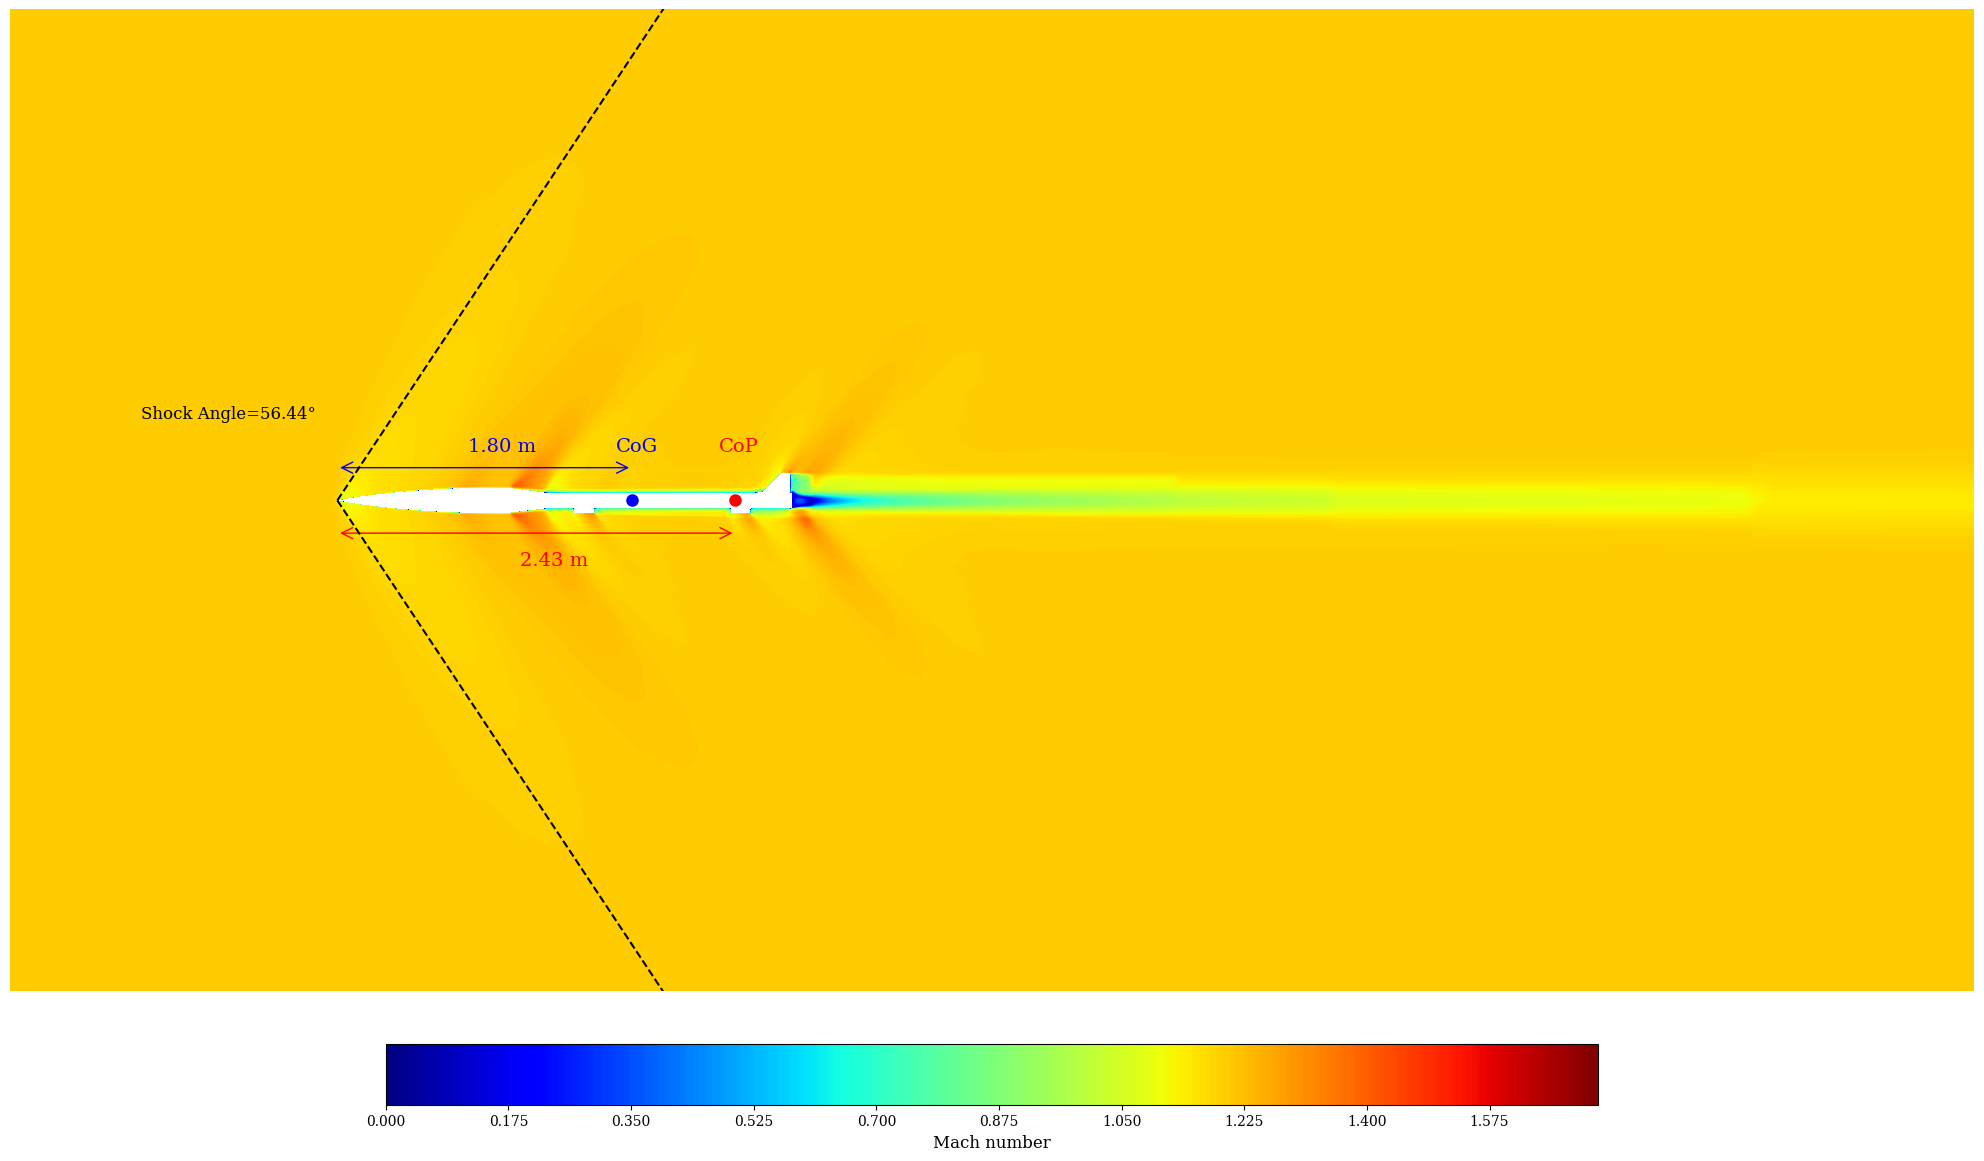

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


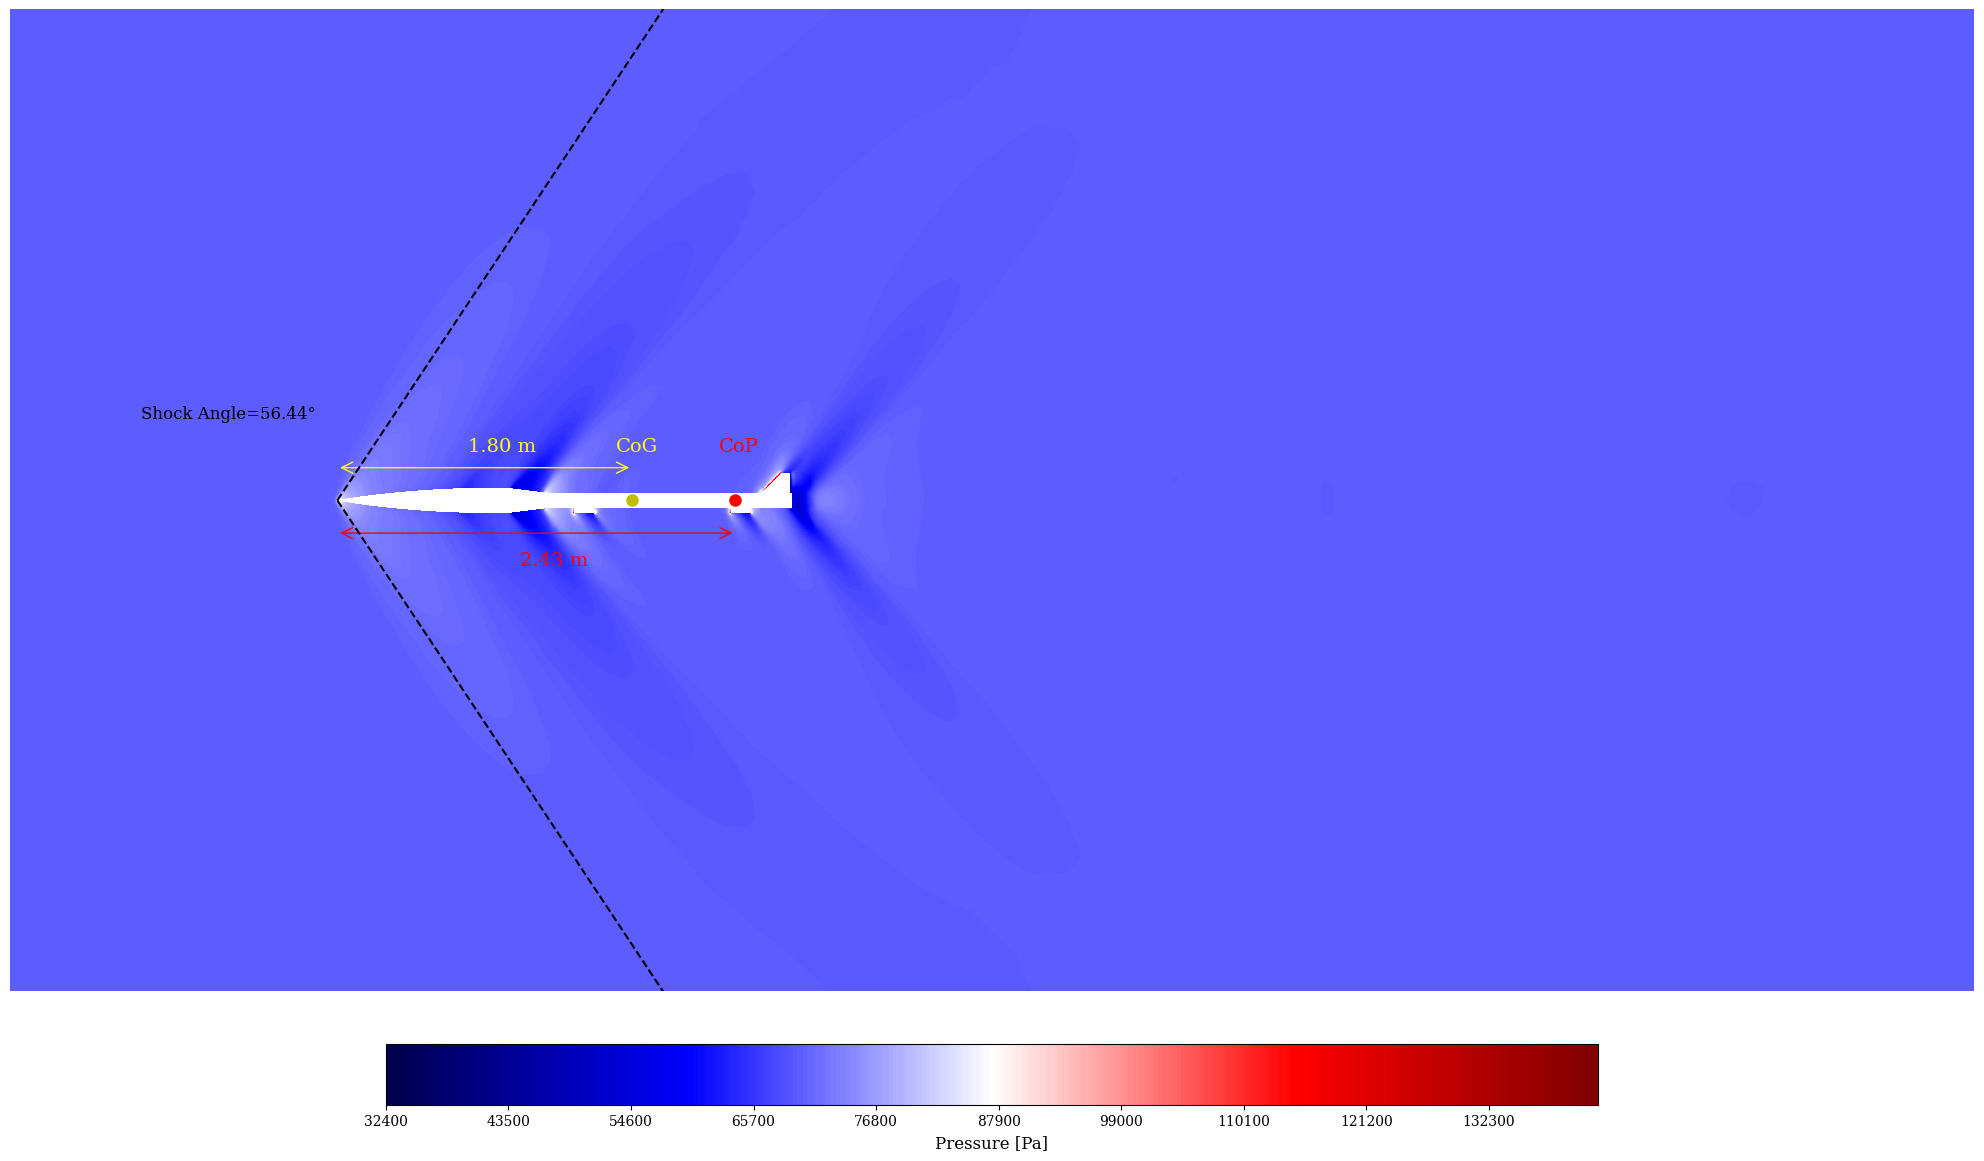

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/1125932735.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


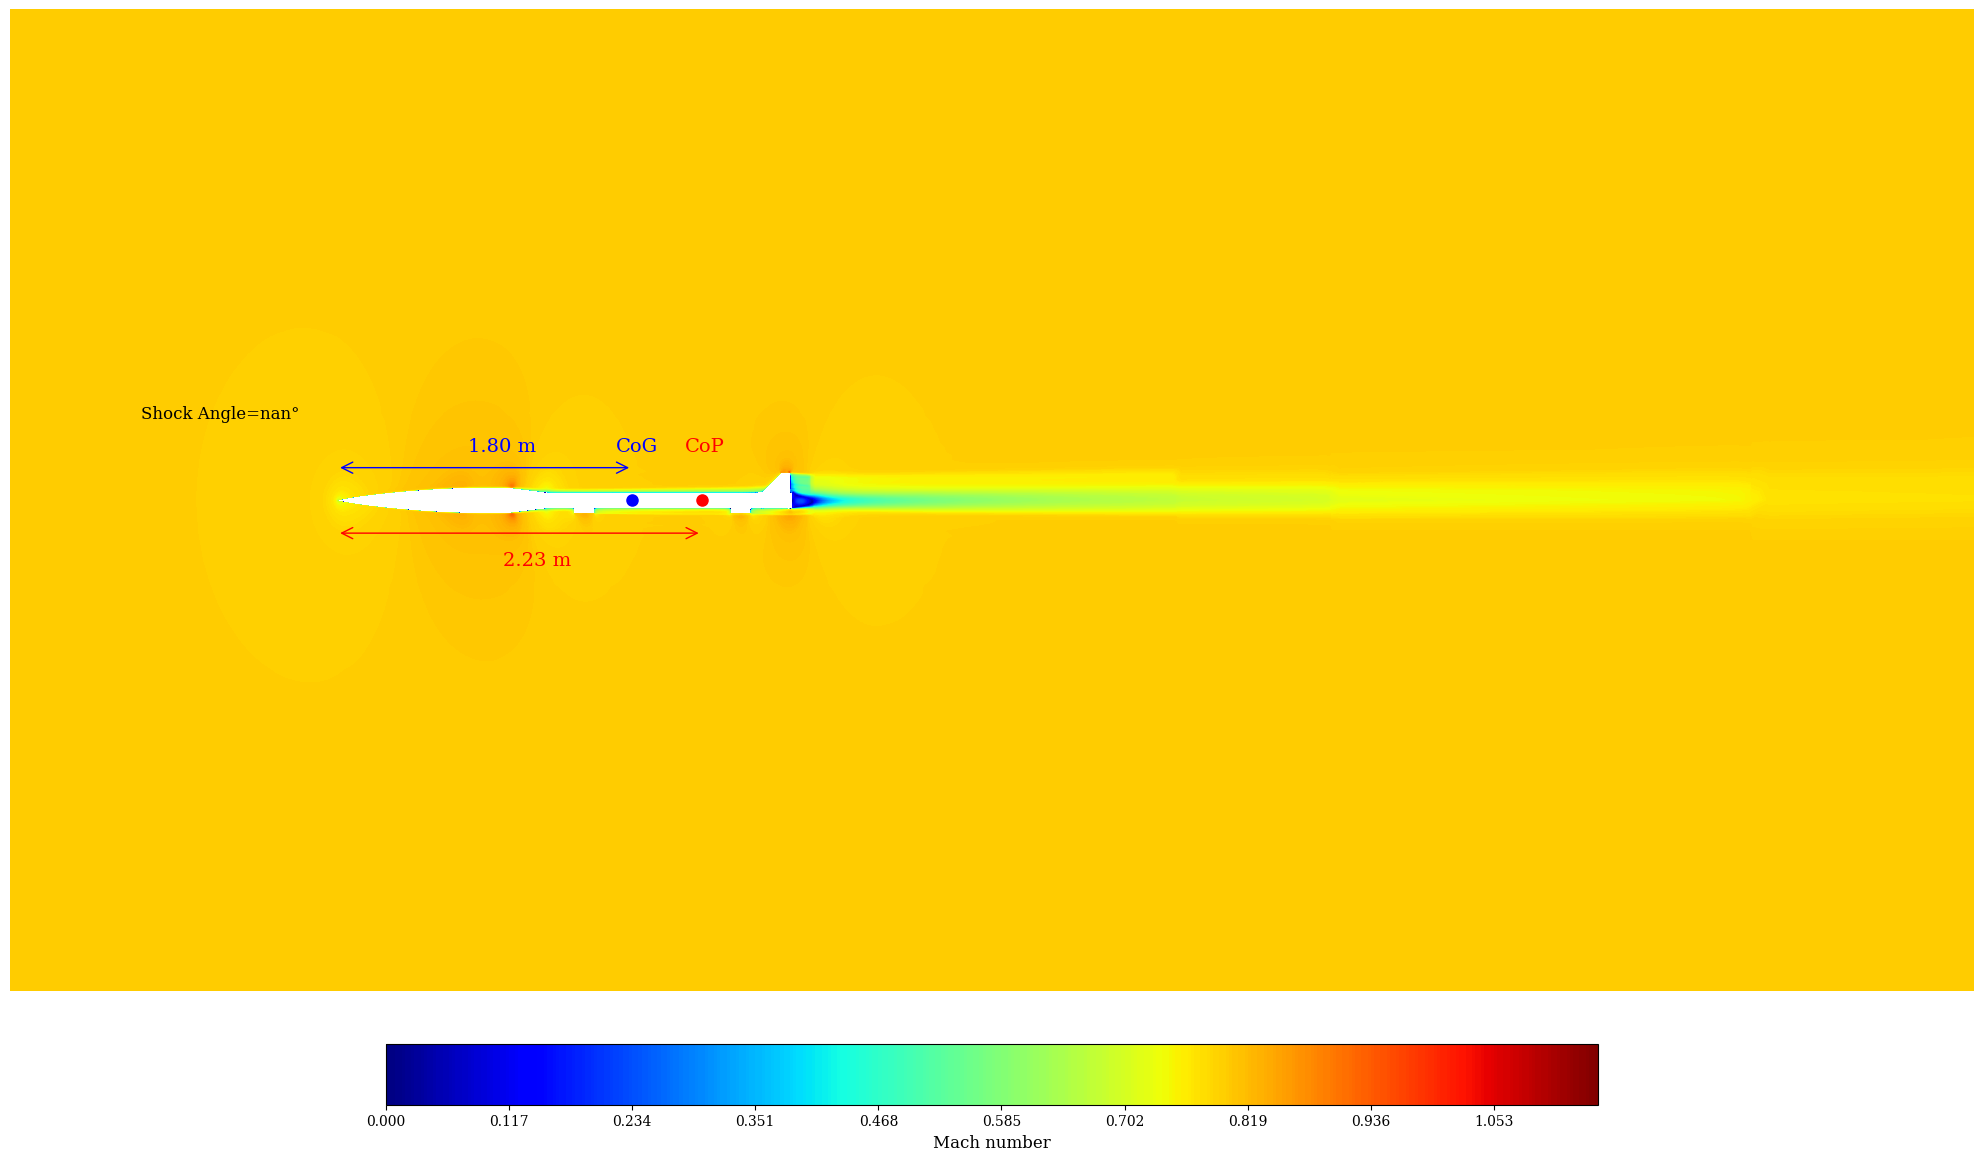

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/36085290.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


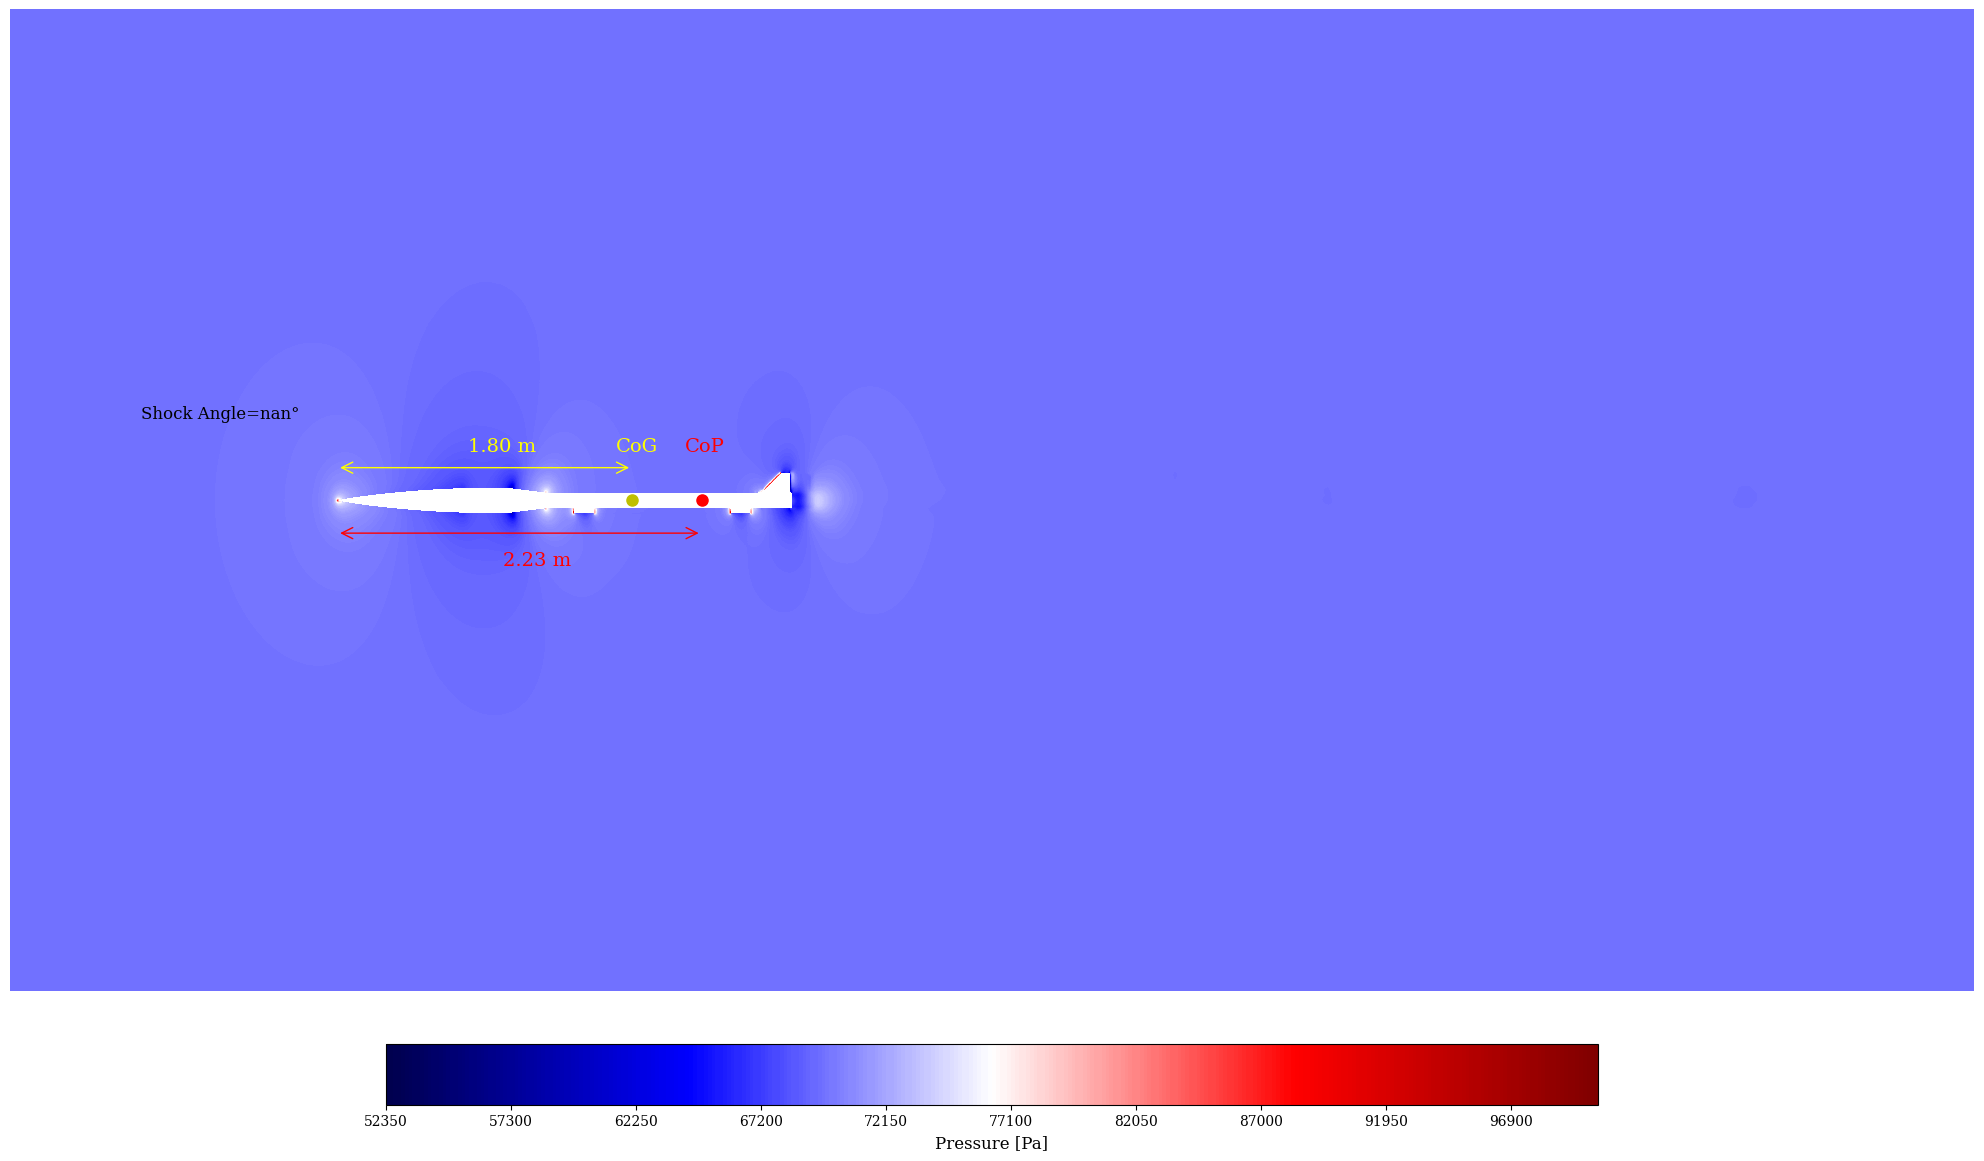

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


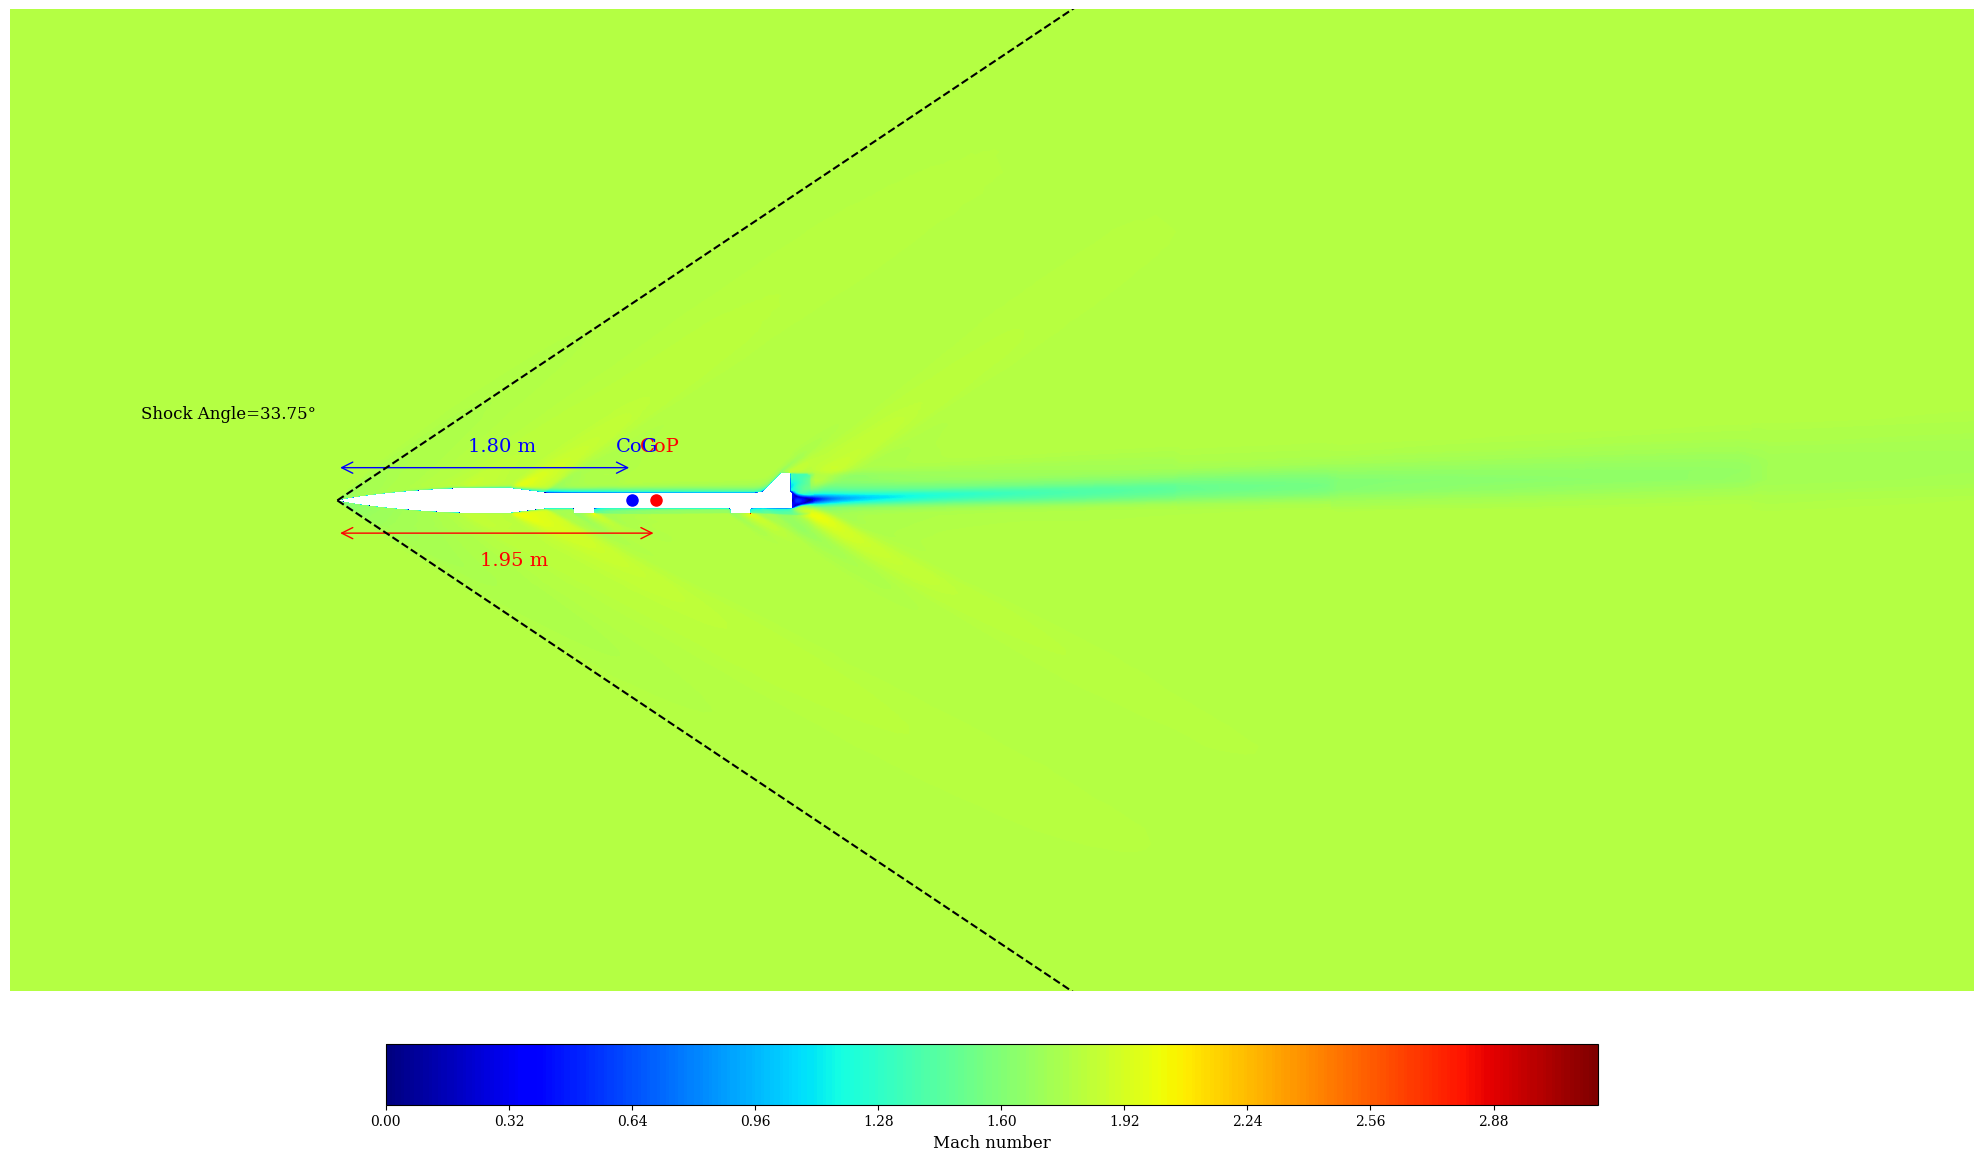

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


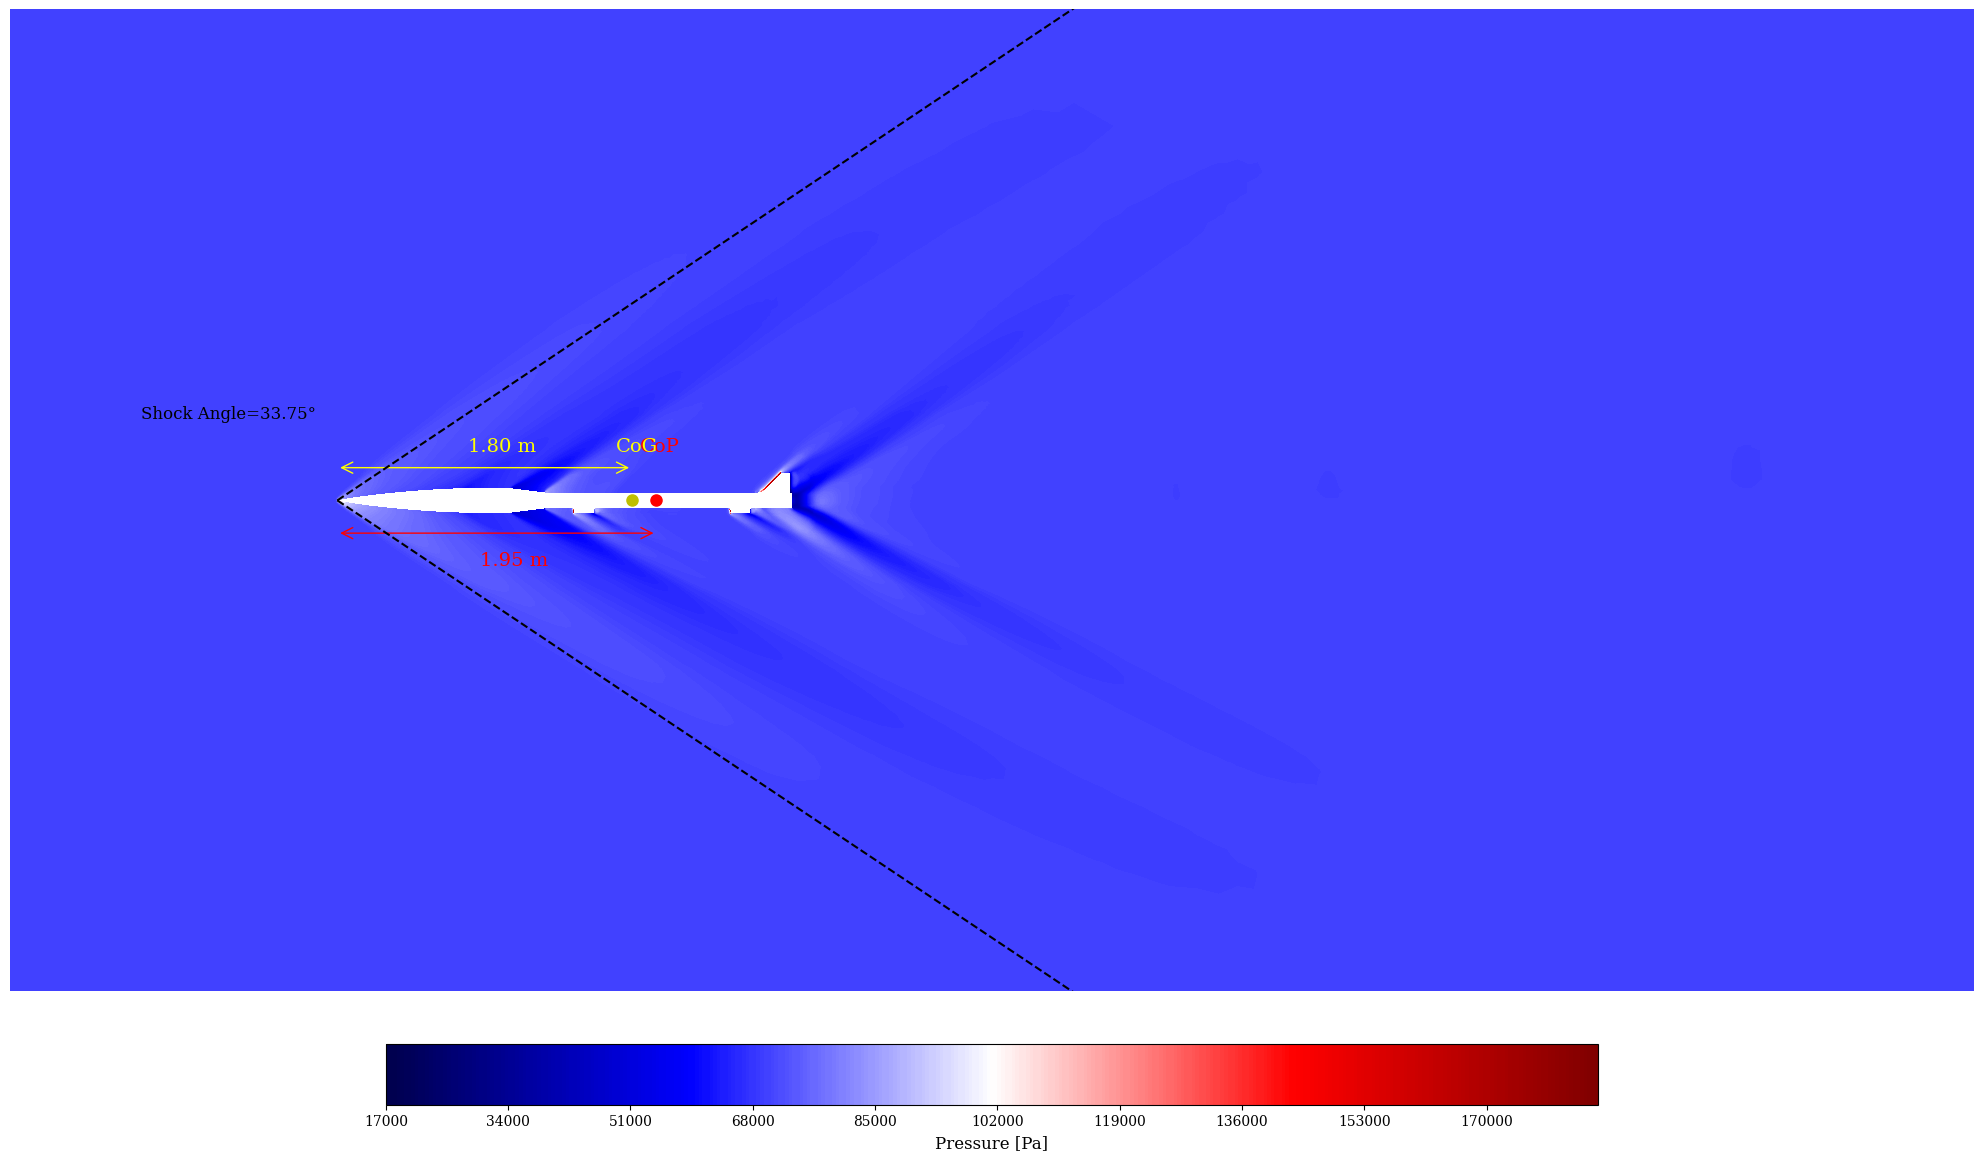

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


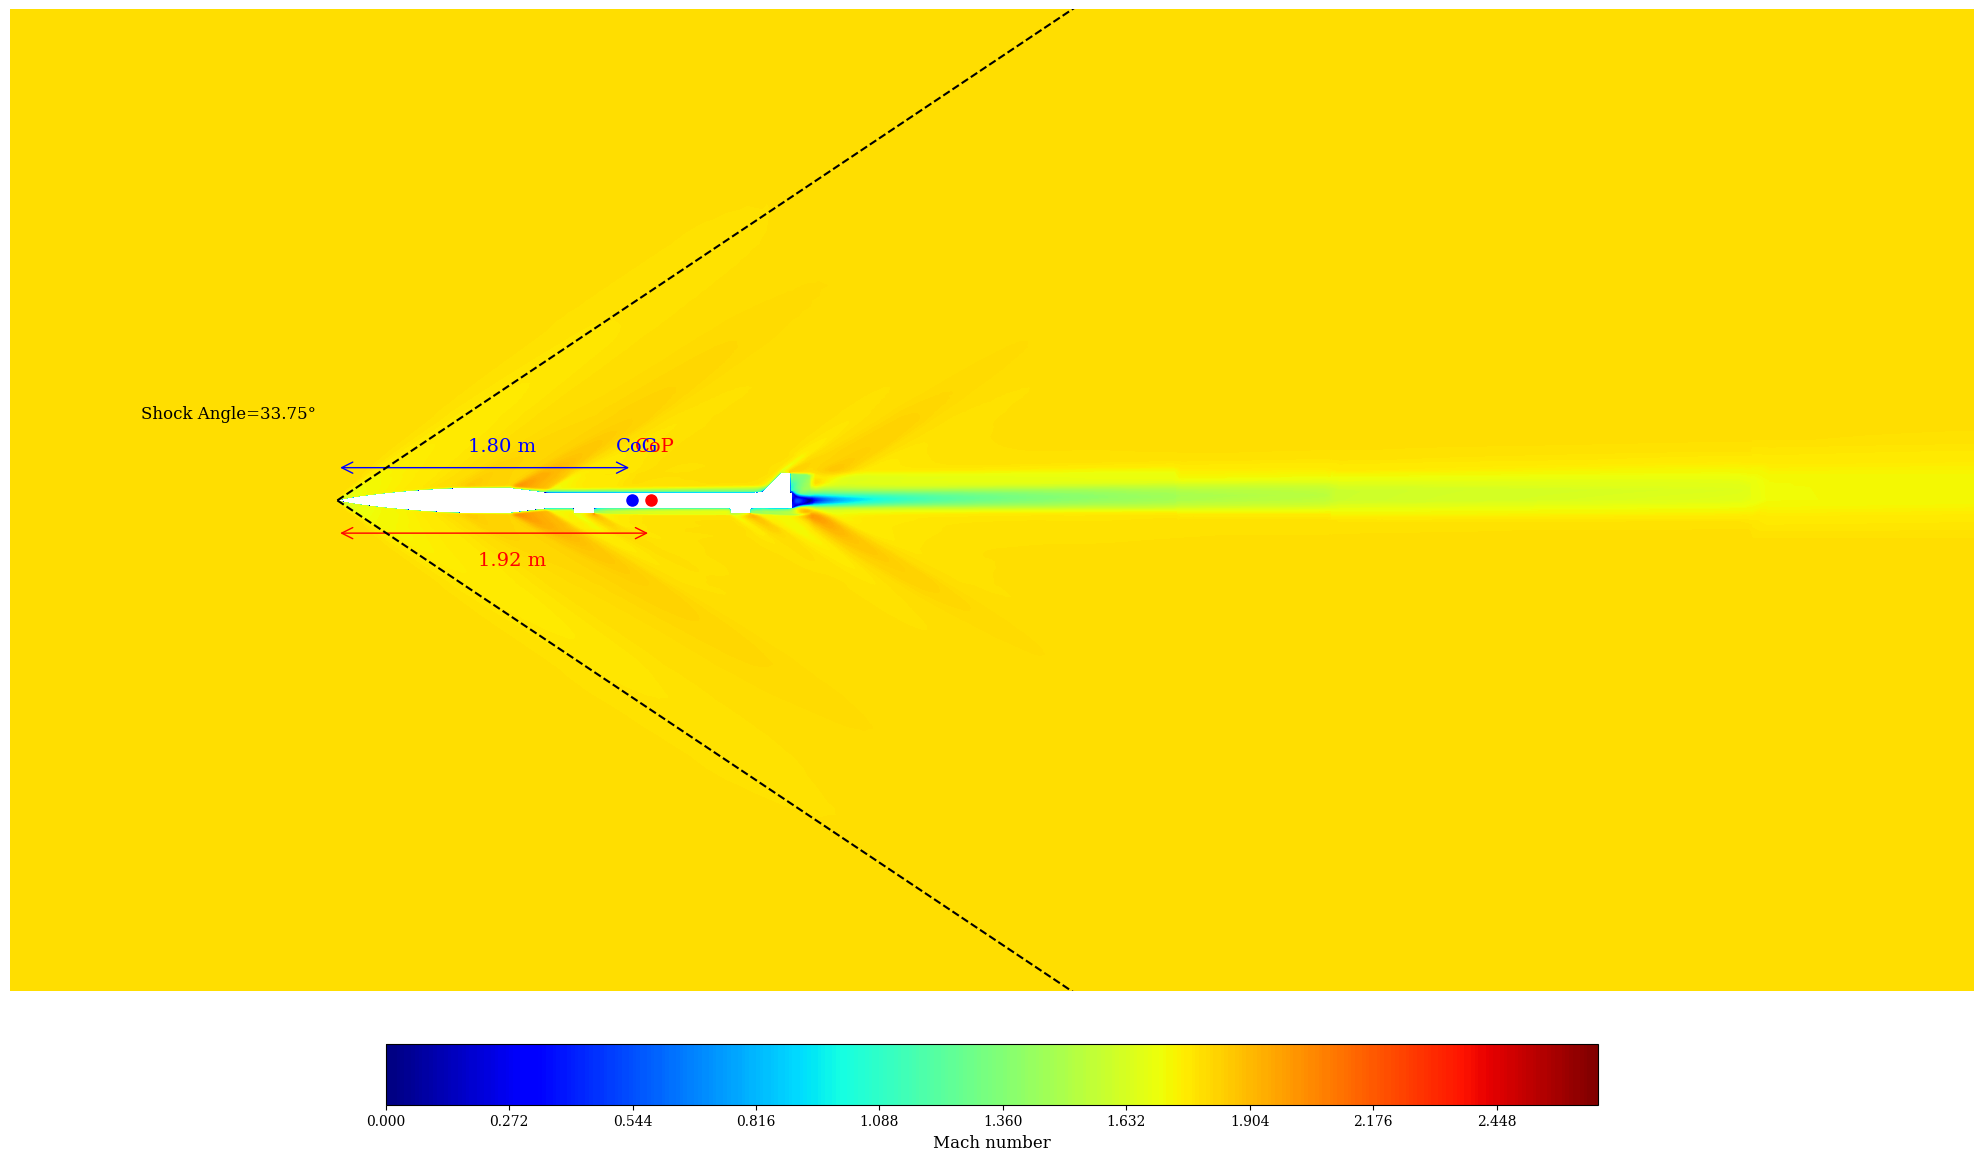

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


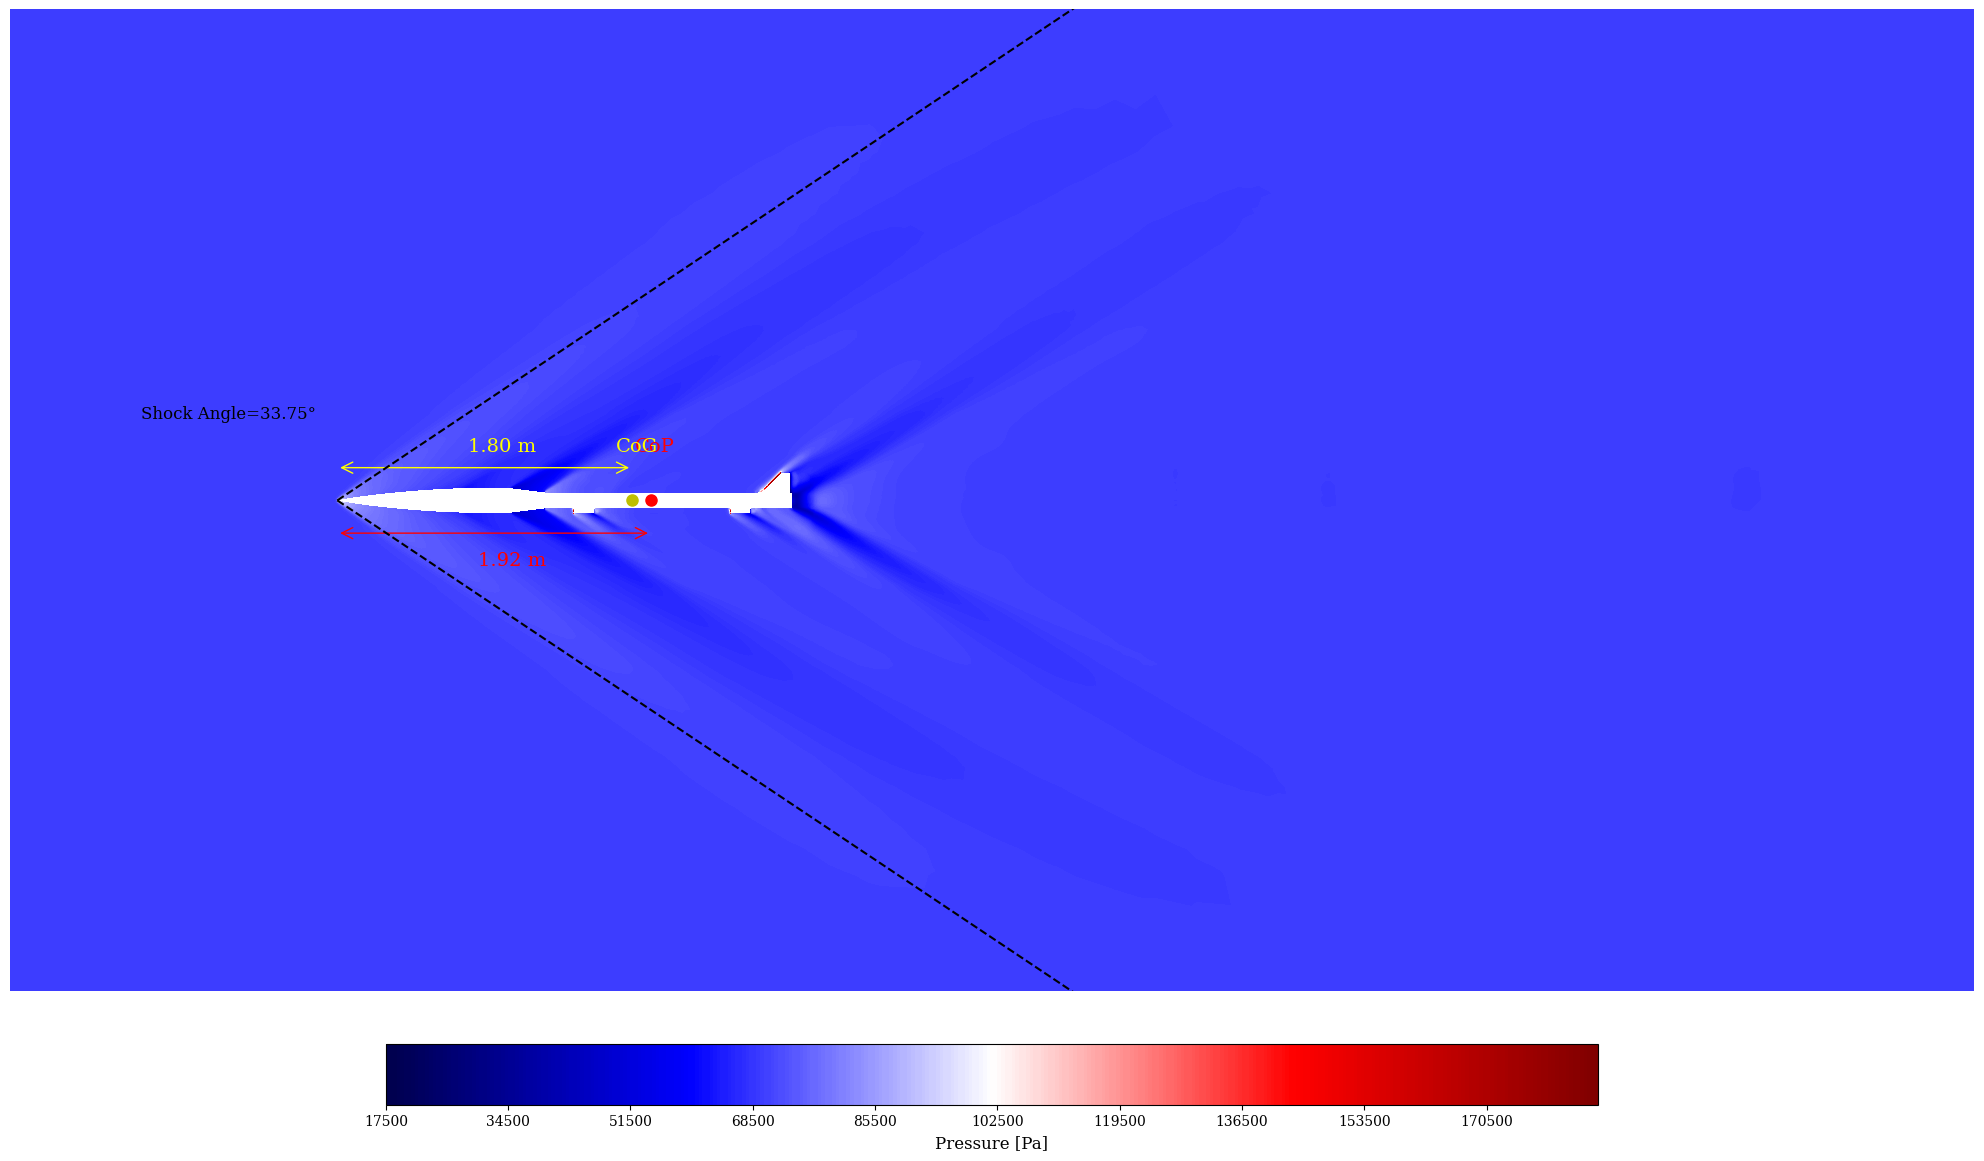

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/1125932735.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


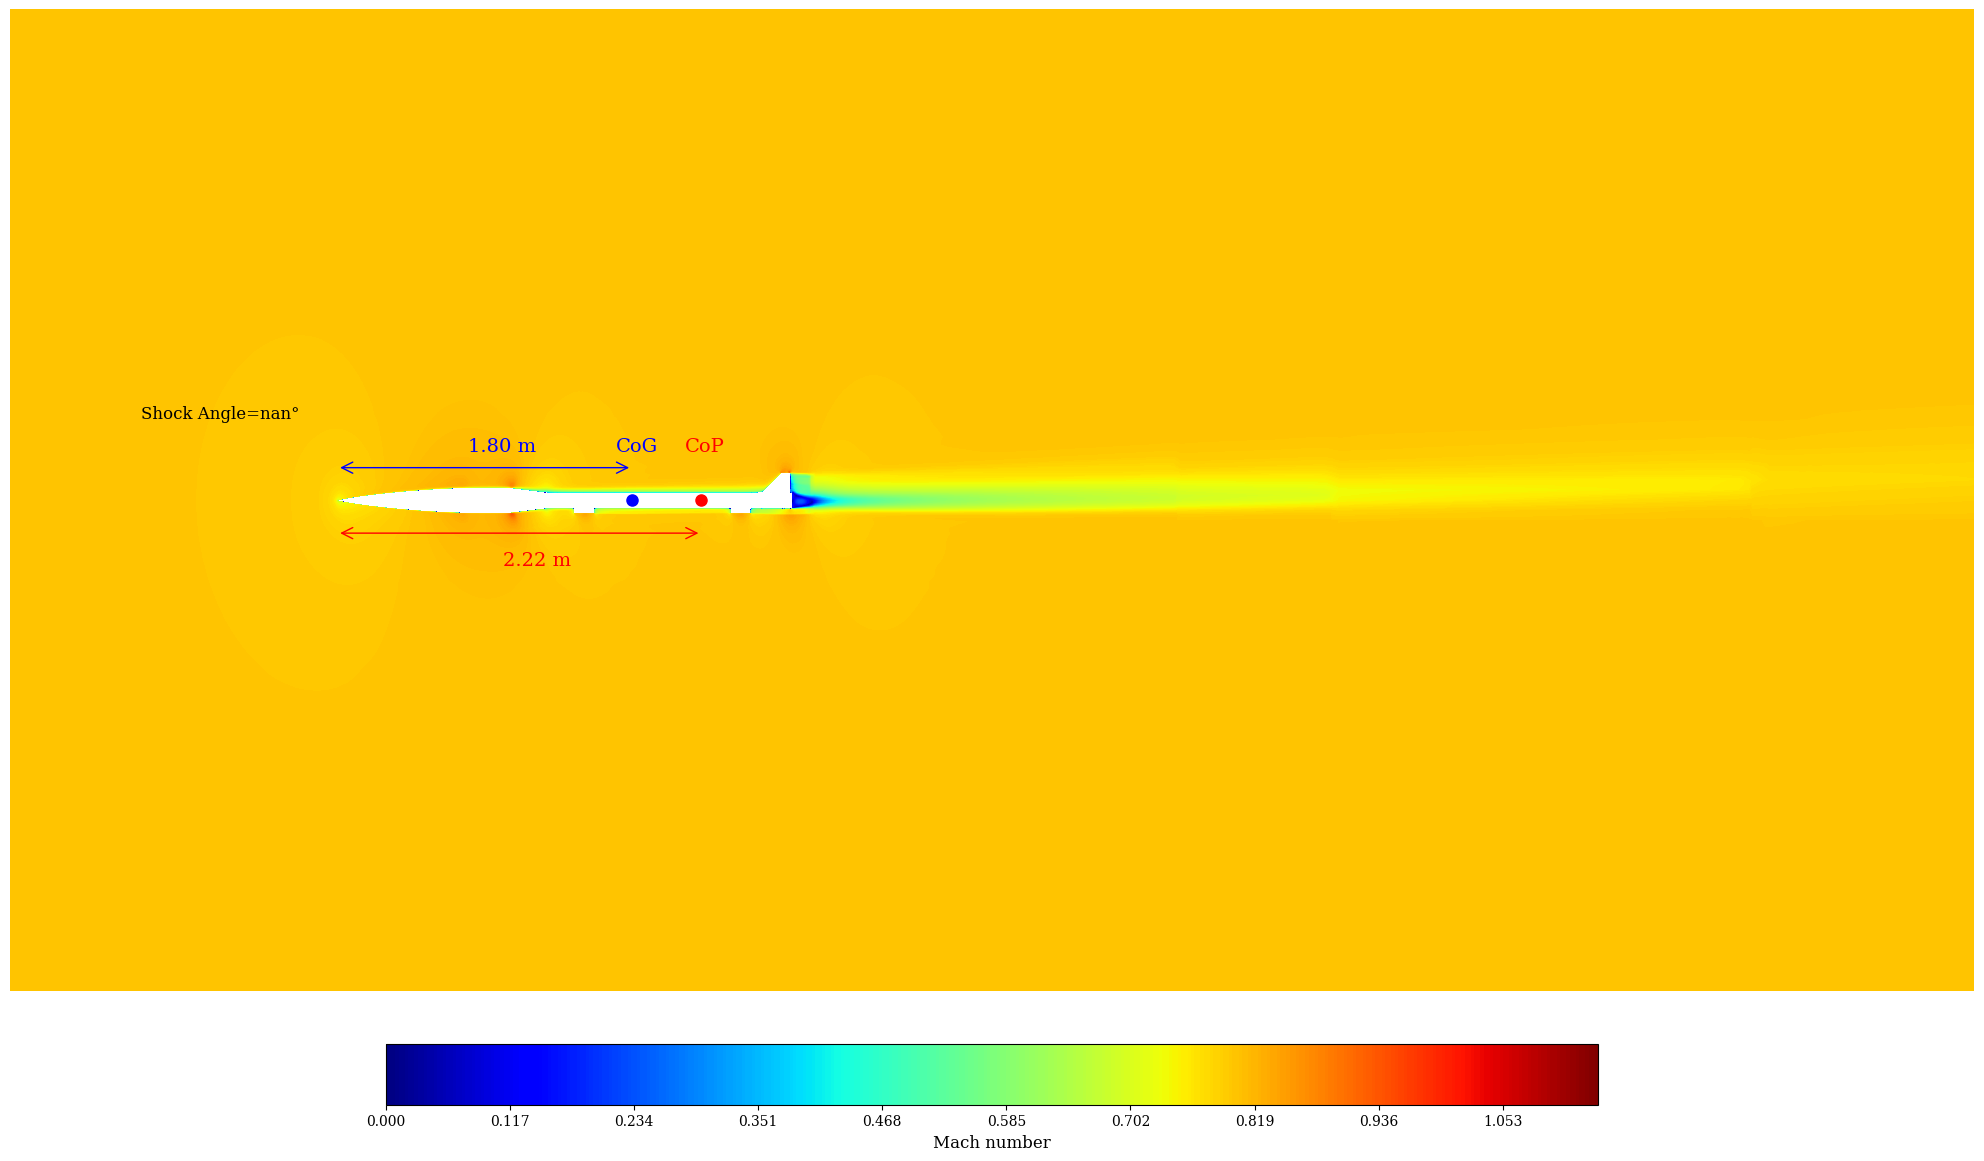

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/36085290.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


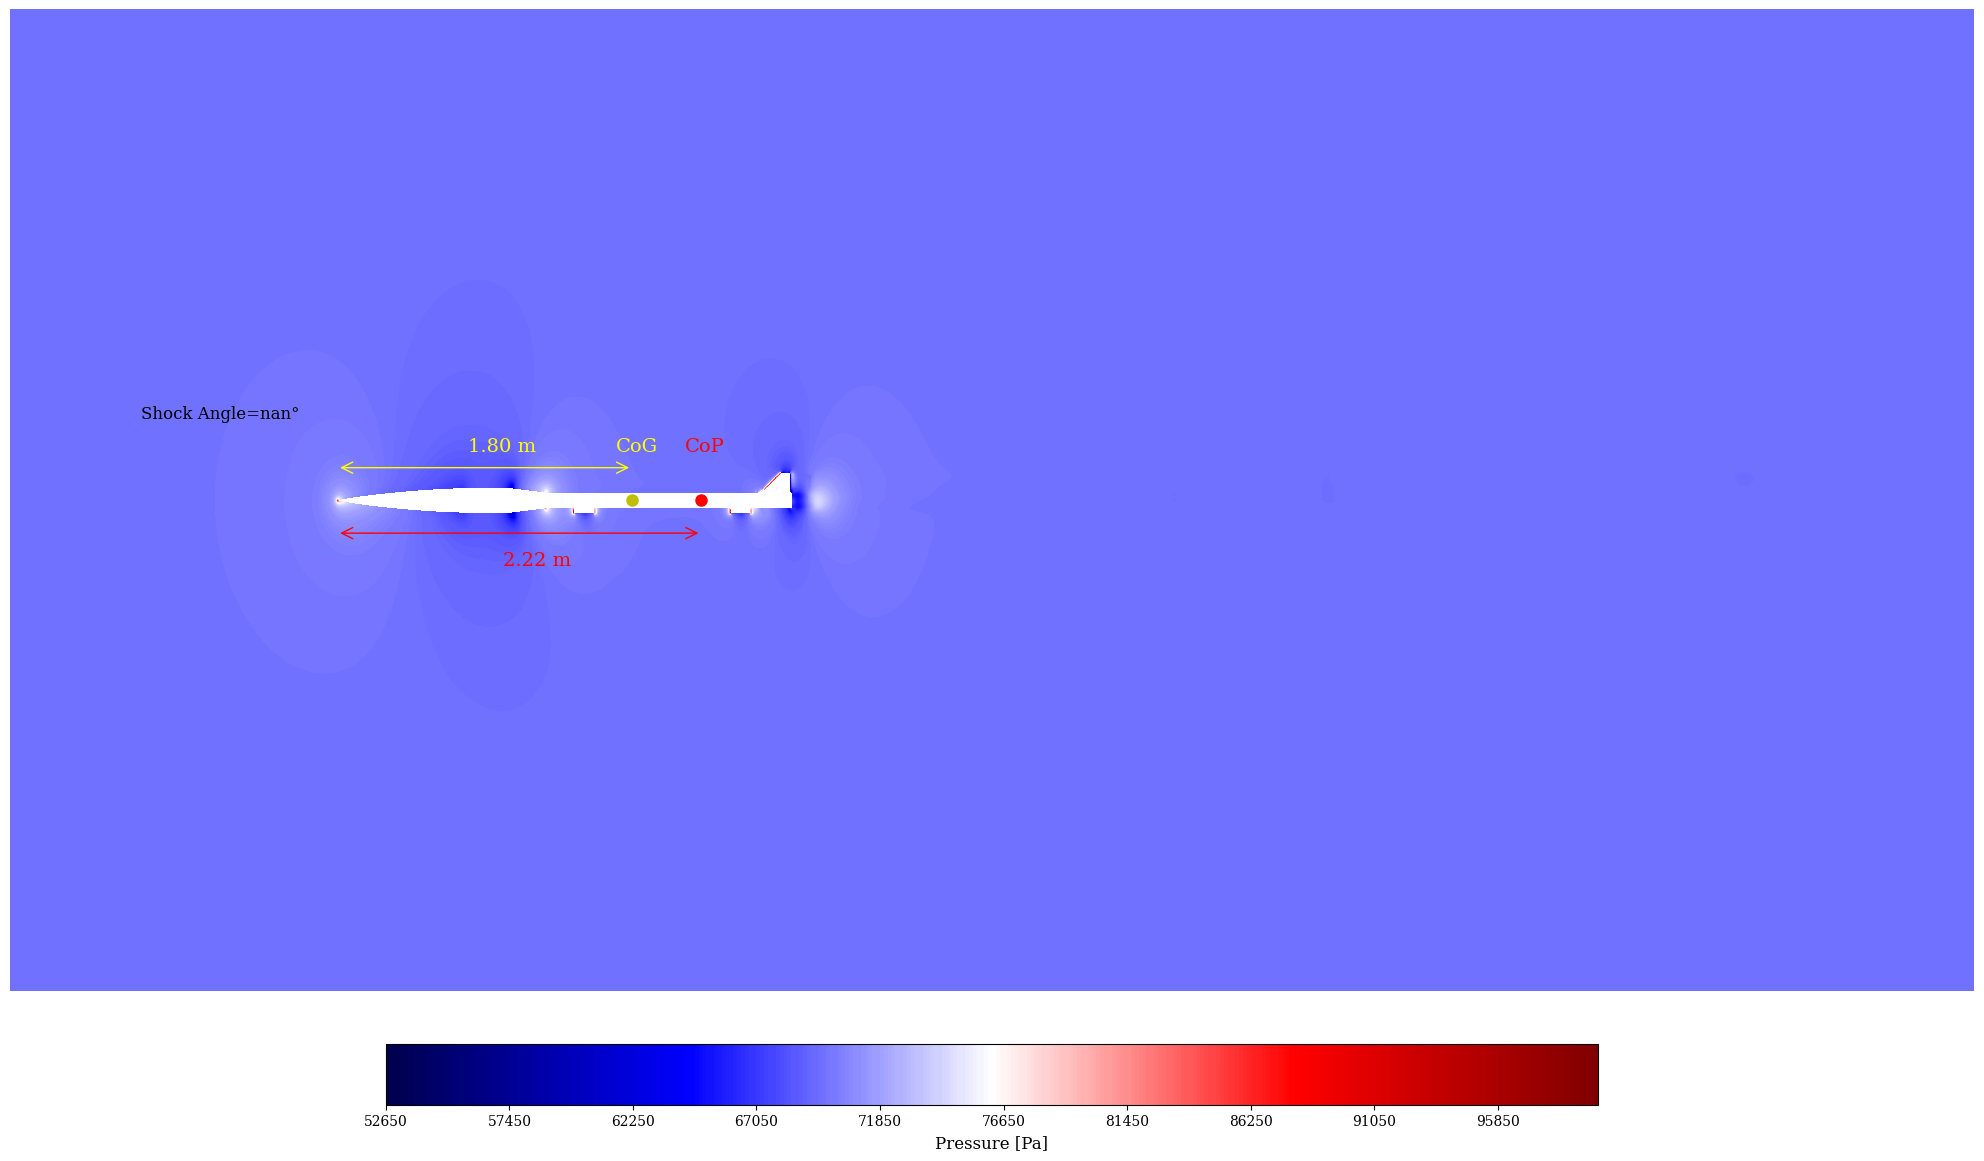

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


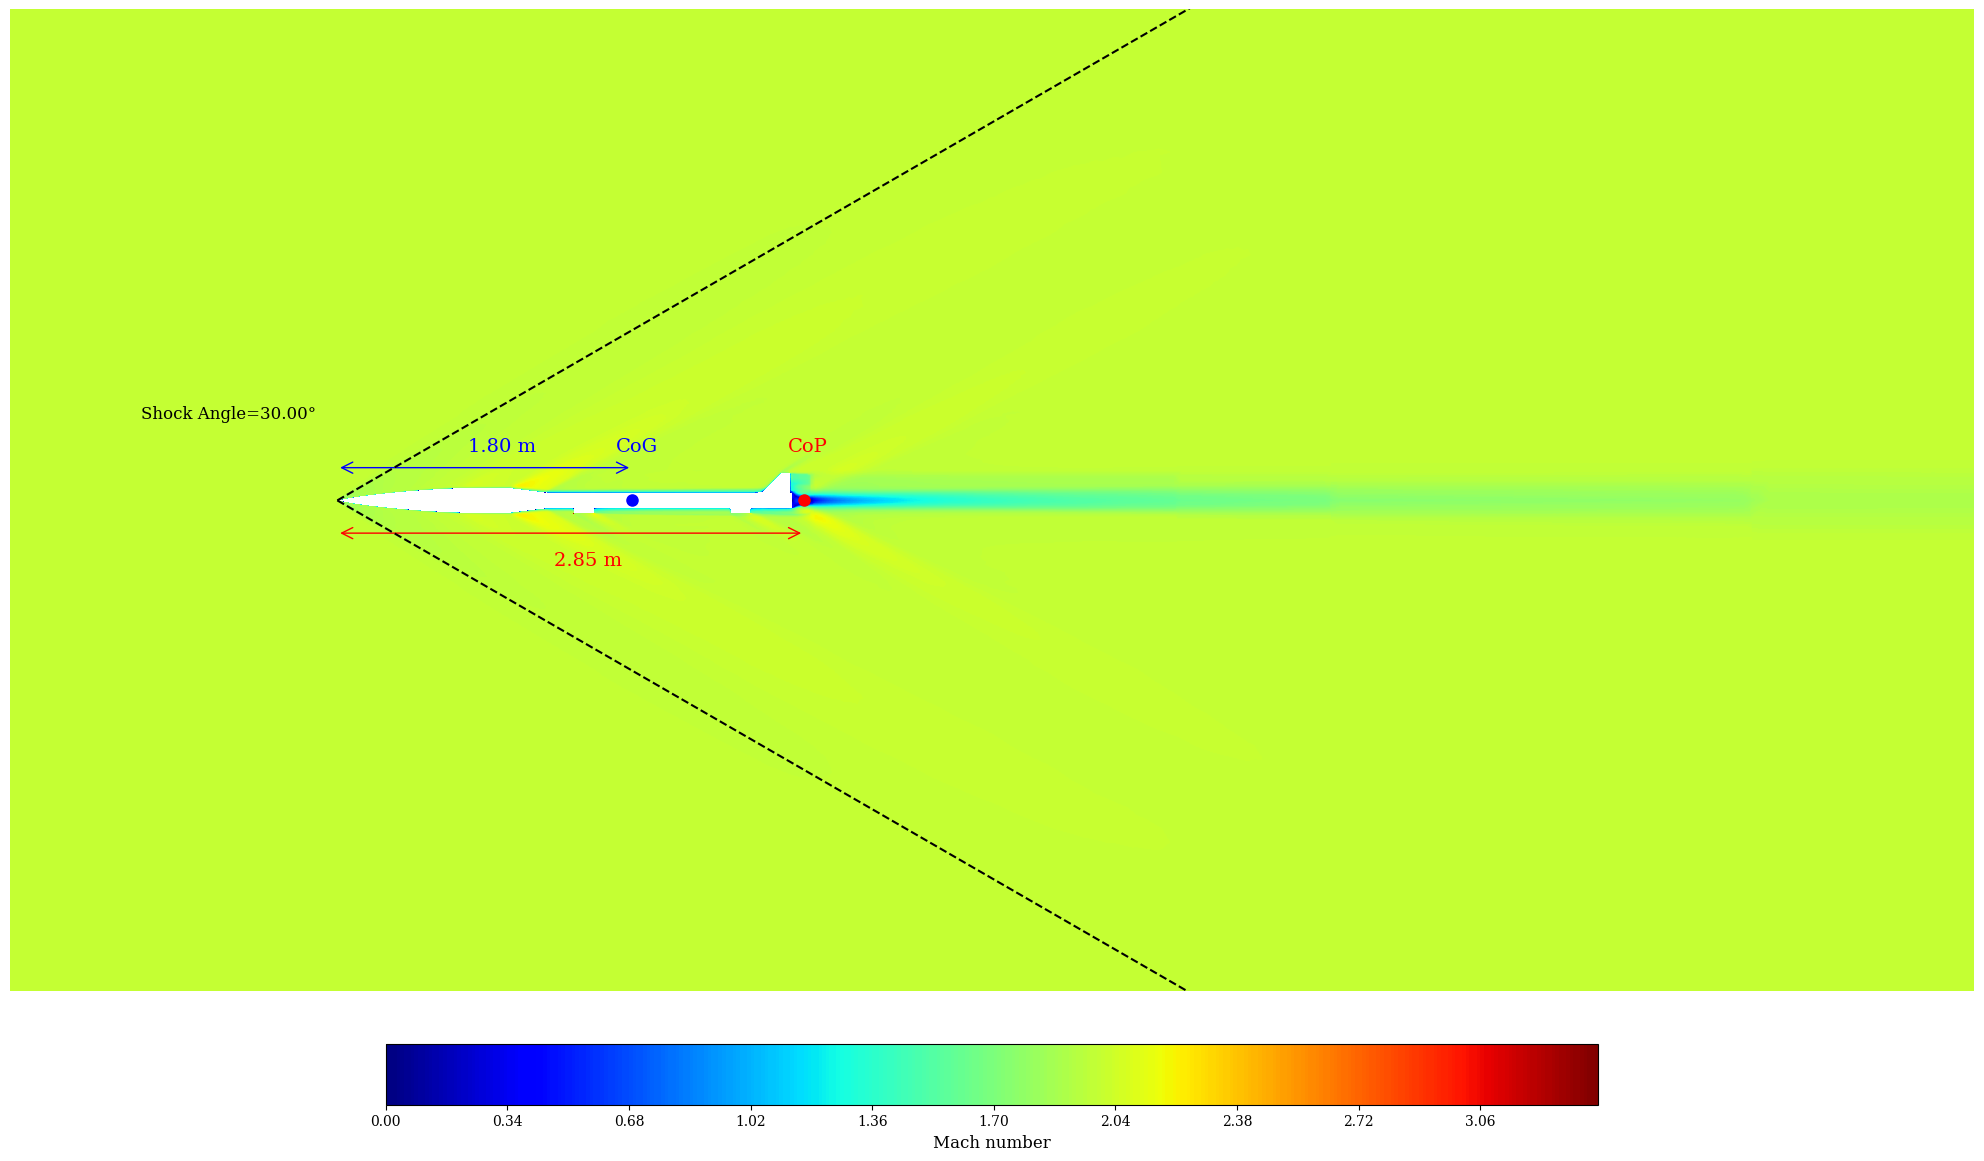

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


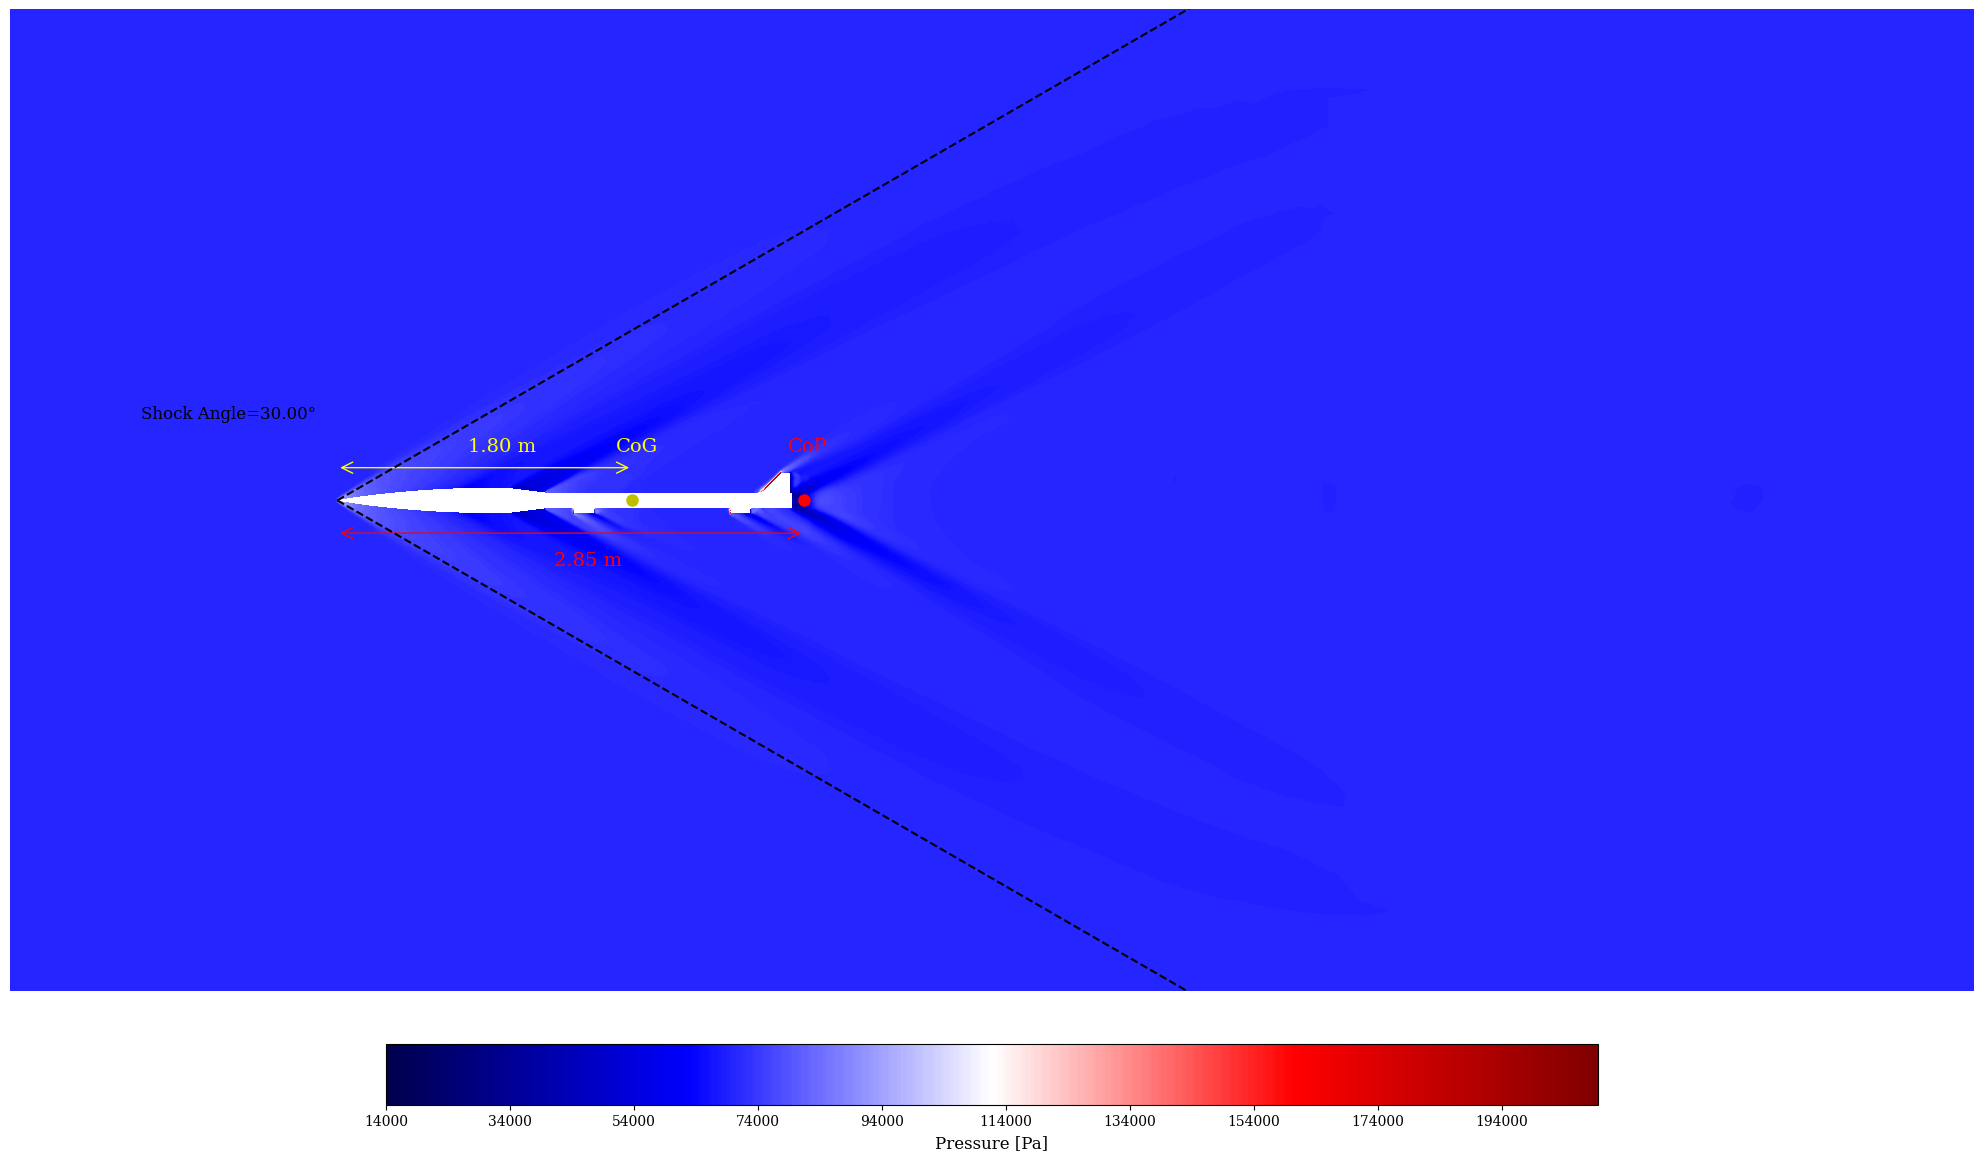

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


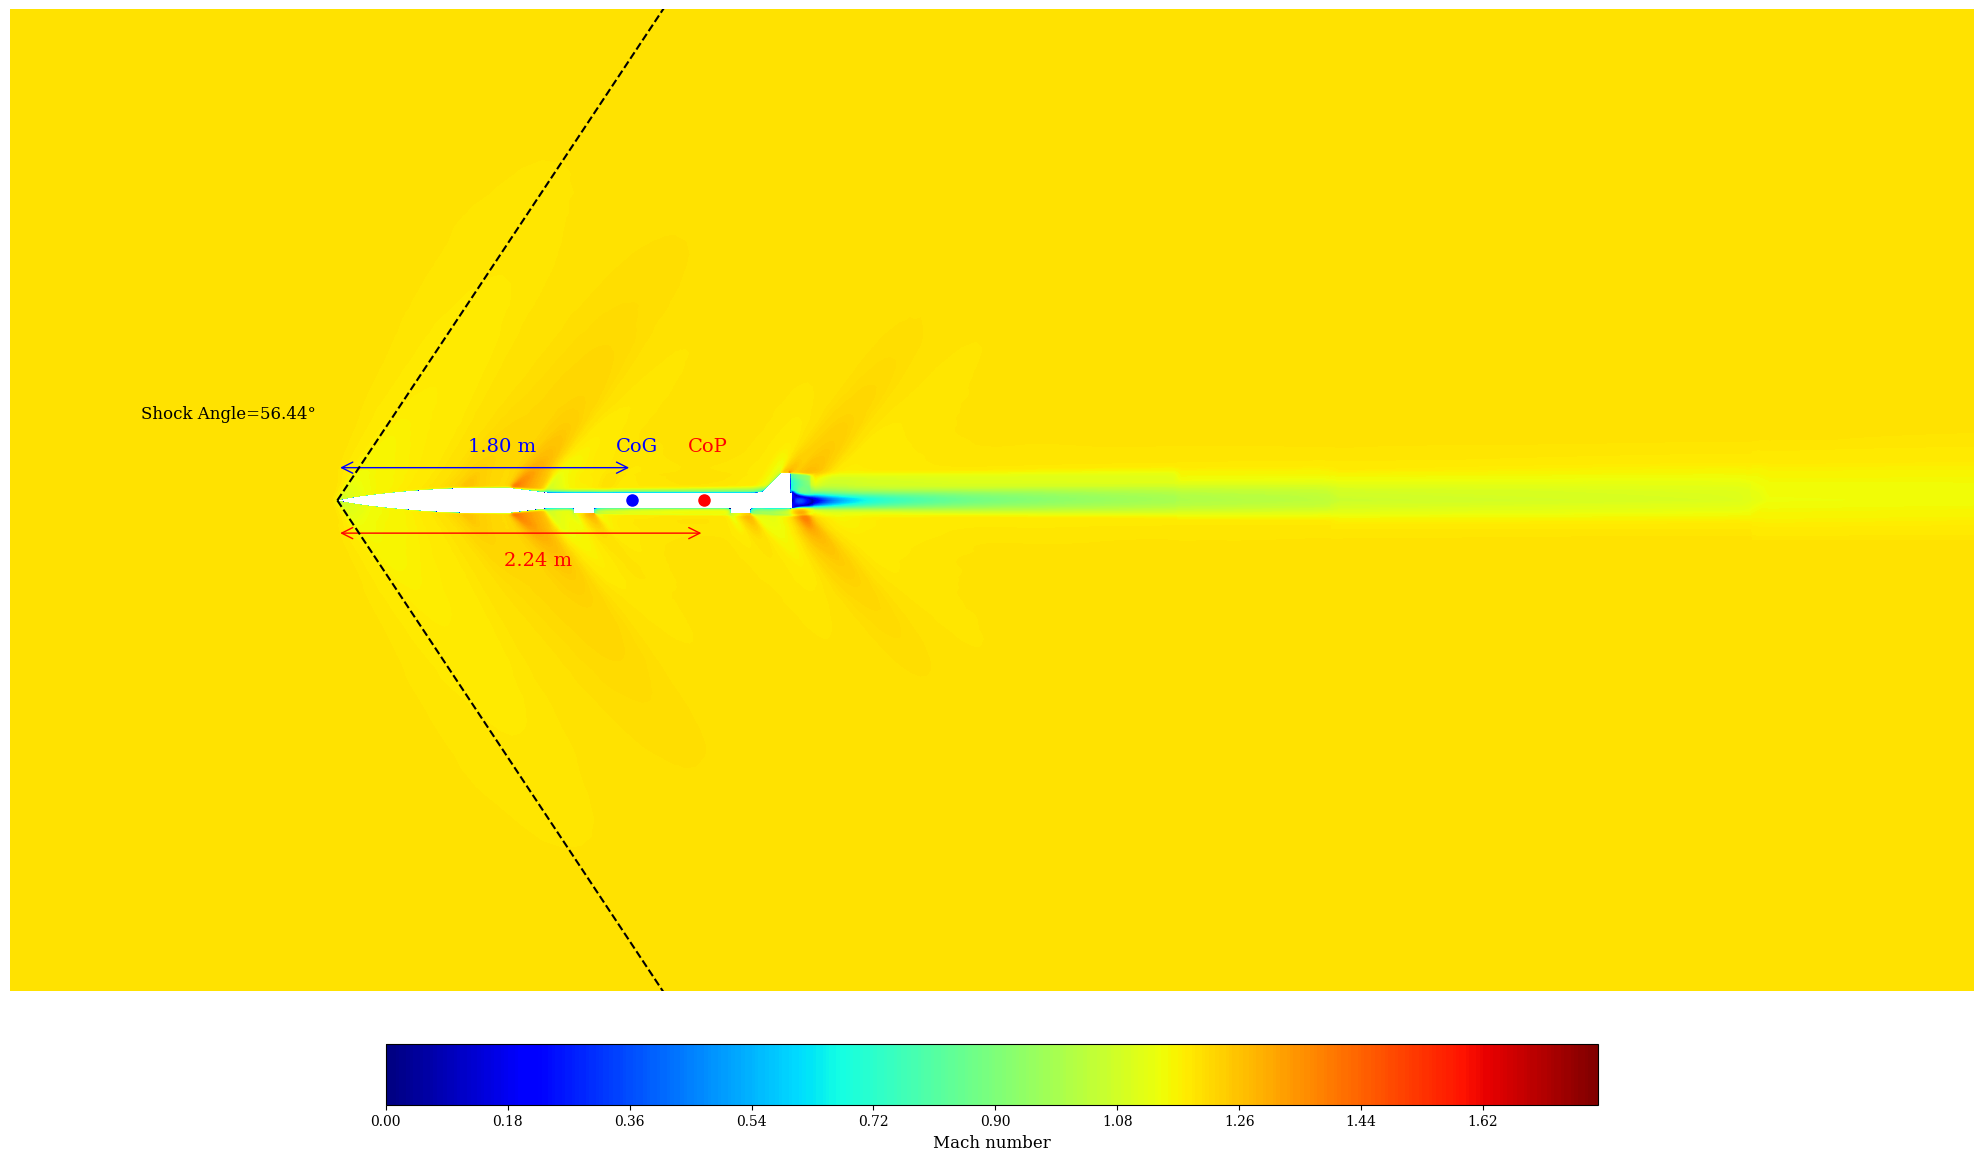

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


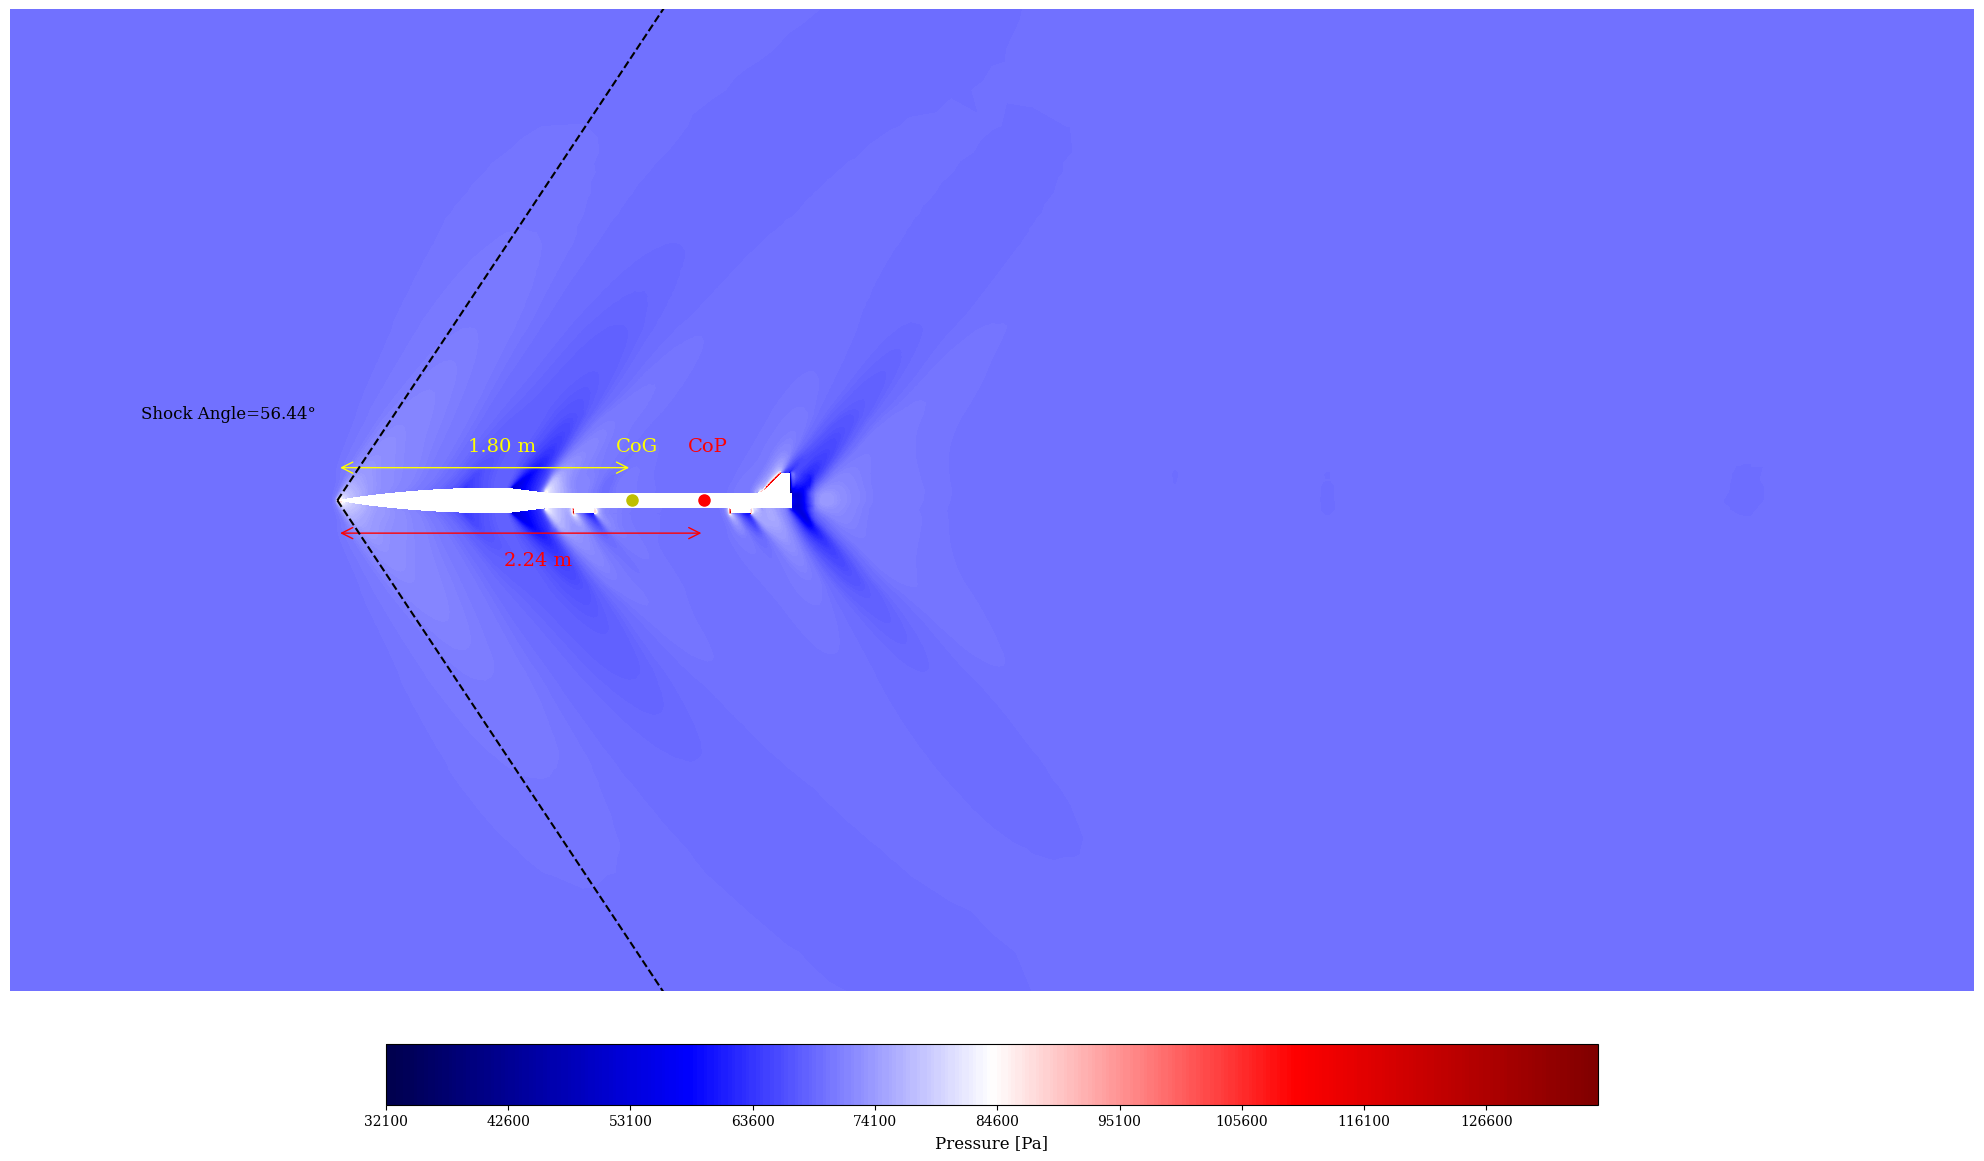

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


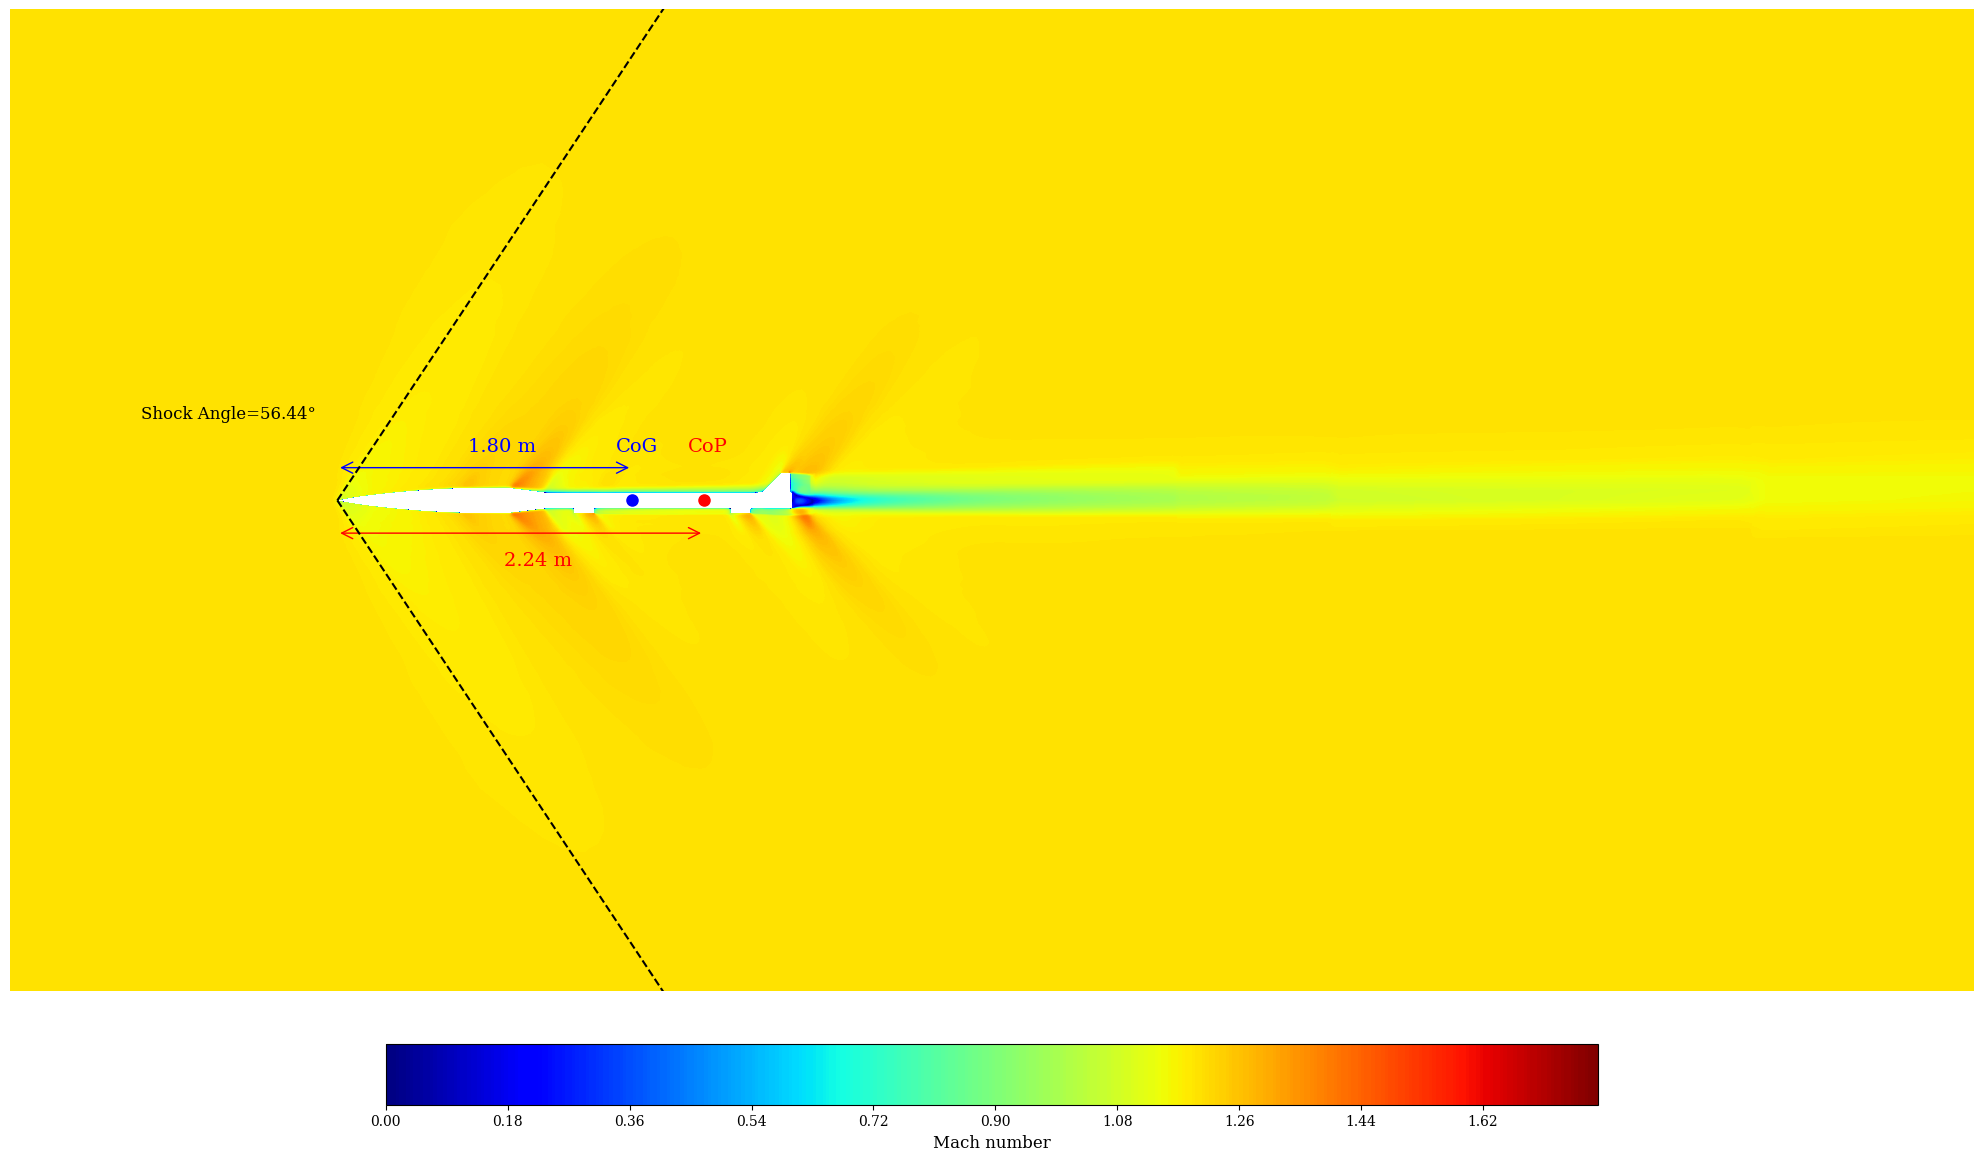

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


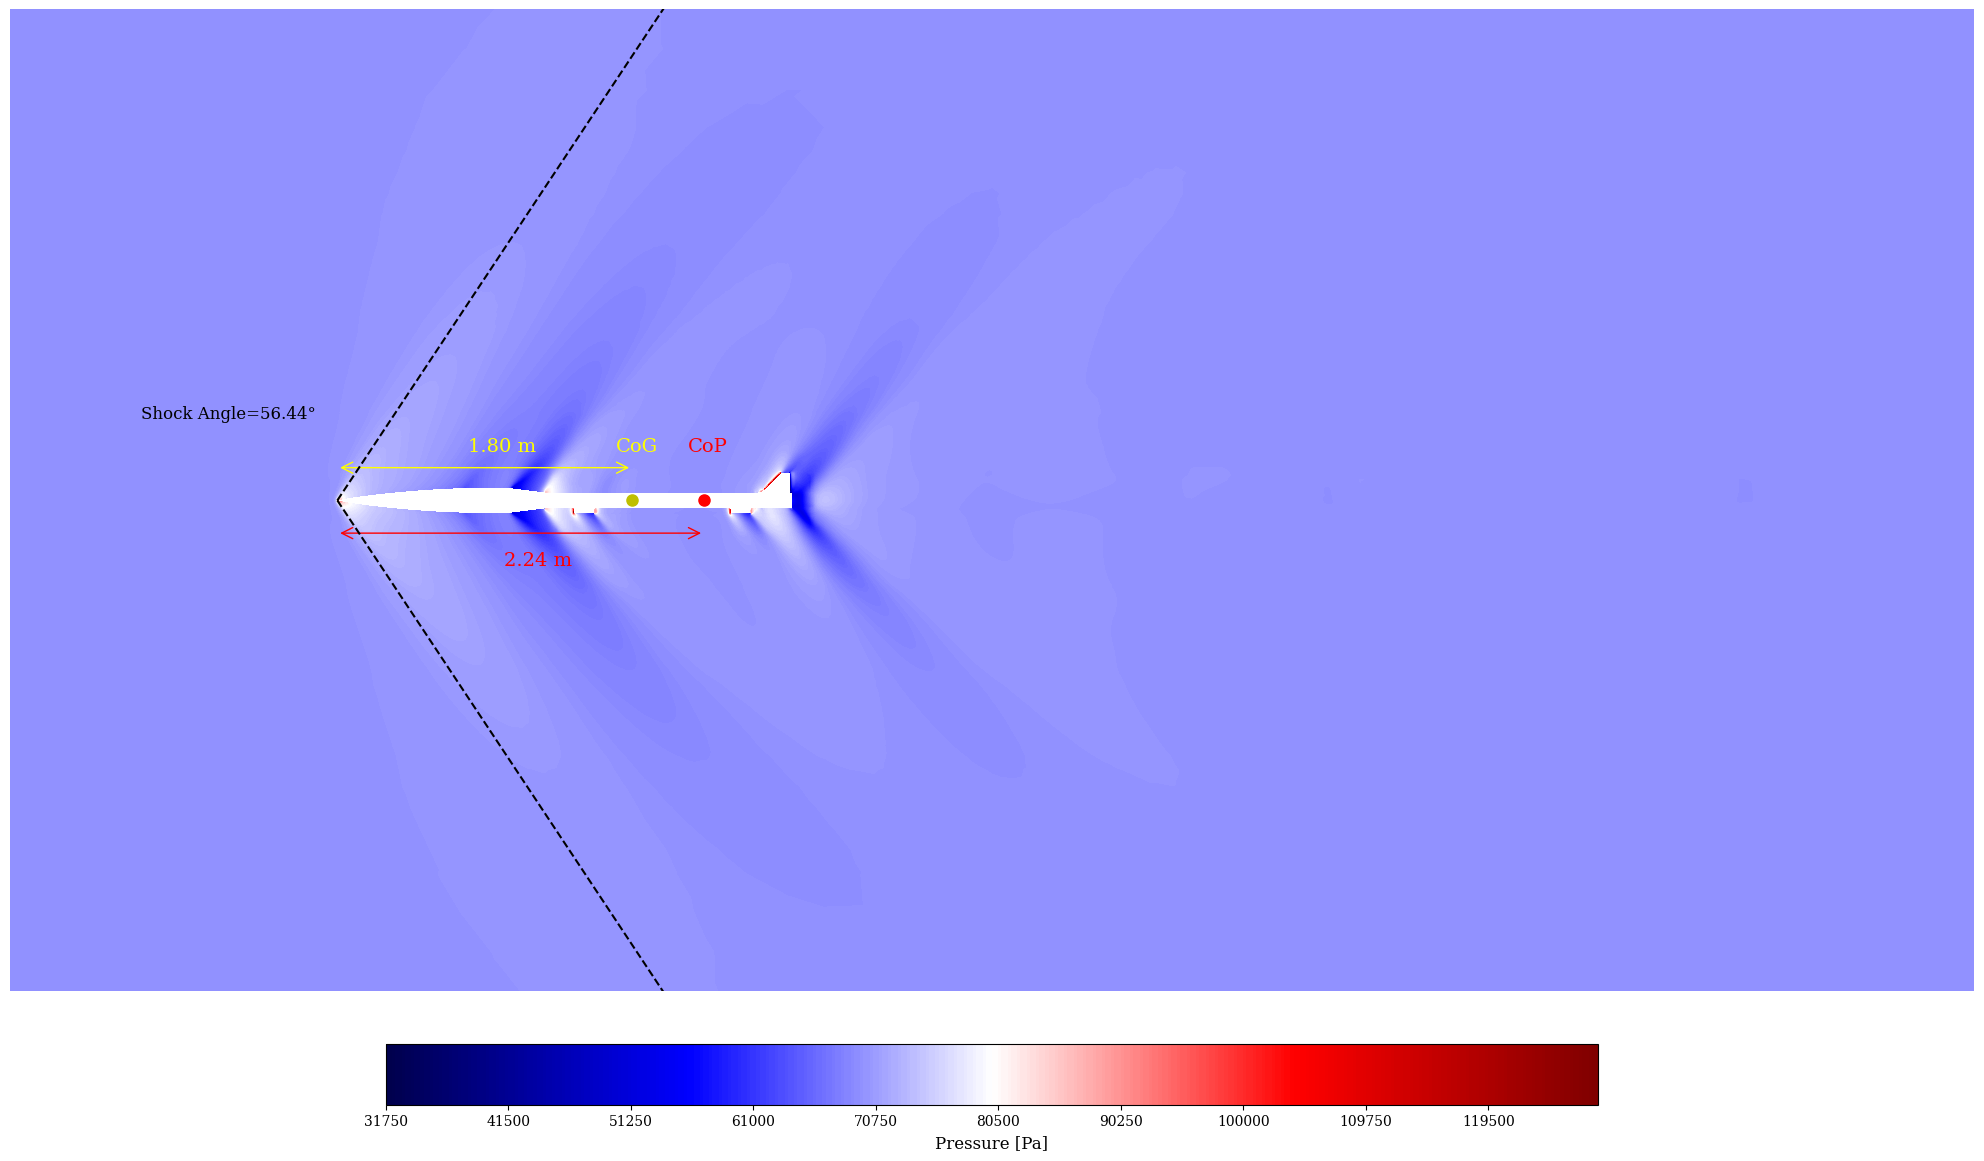

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


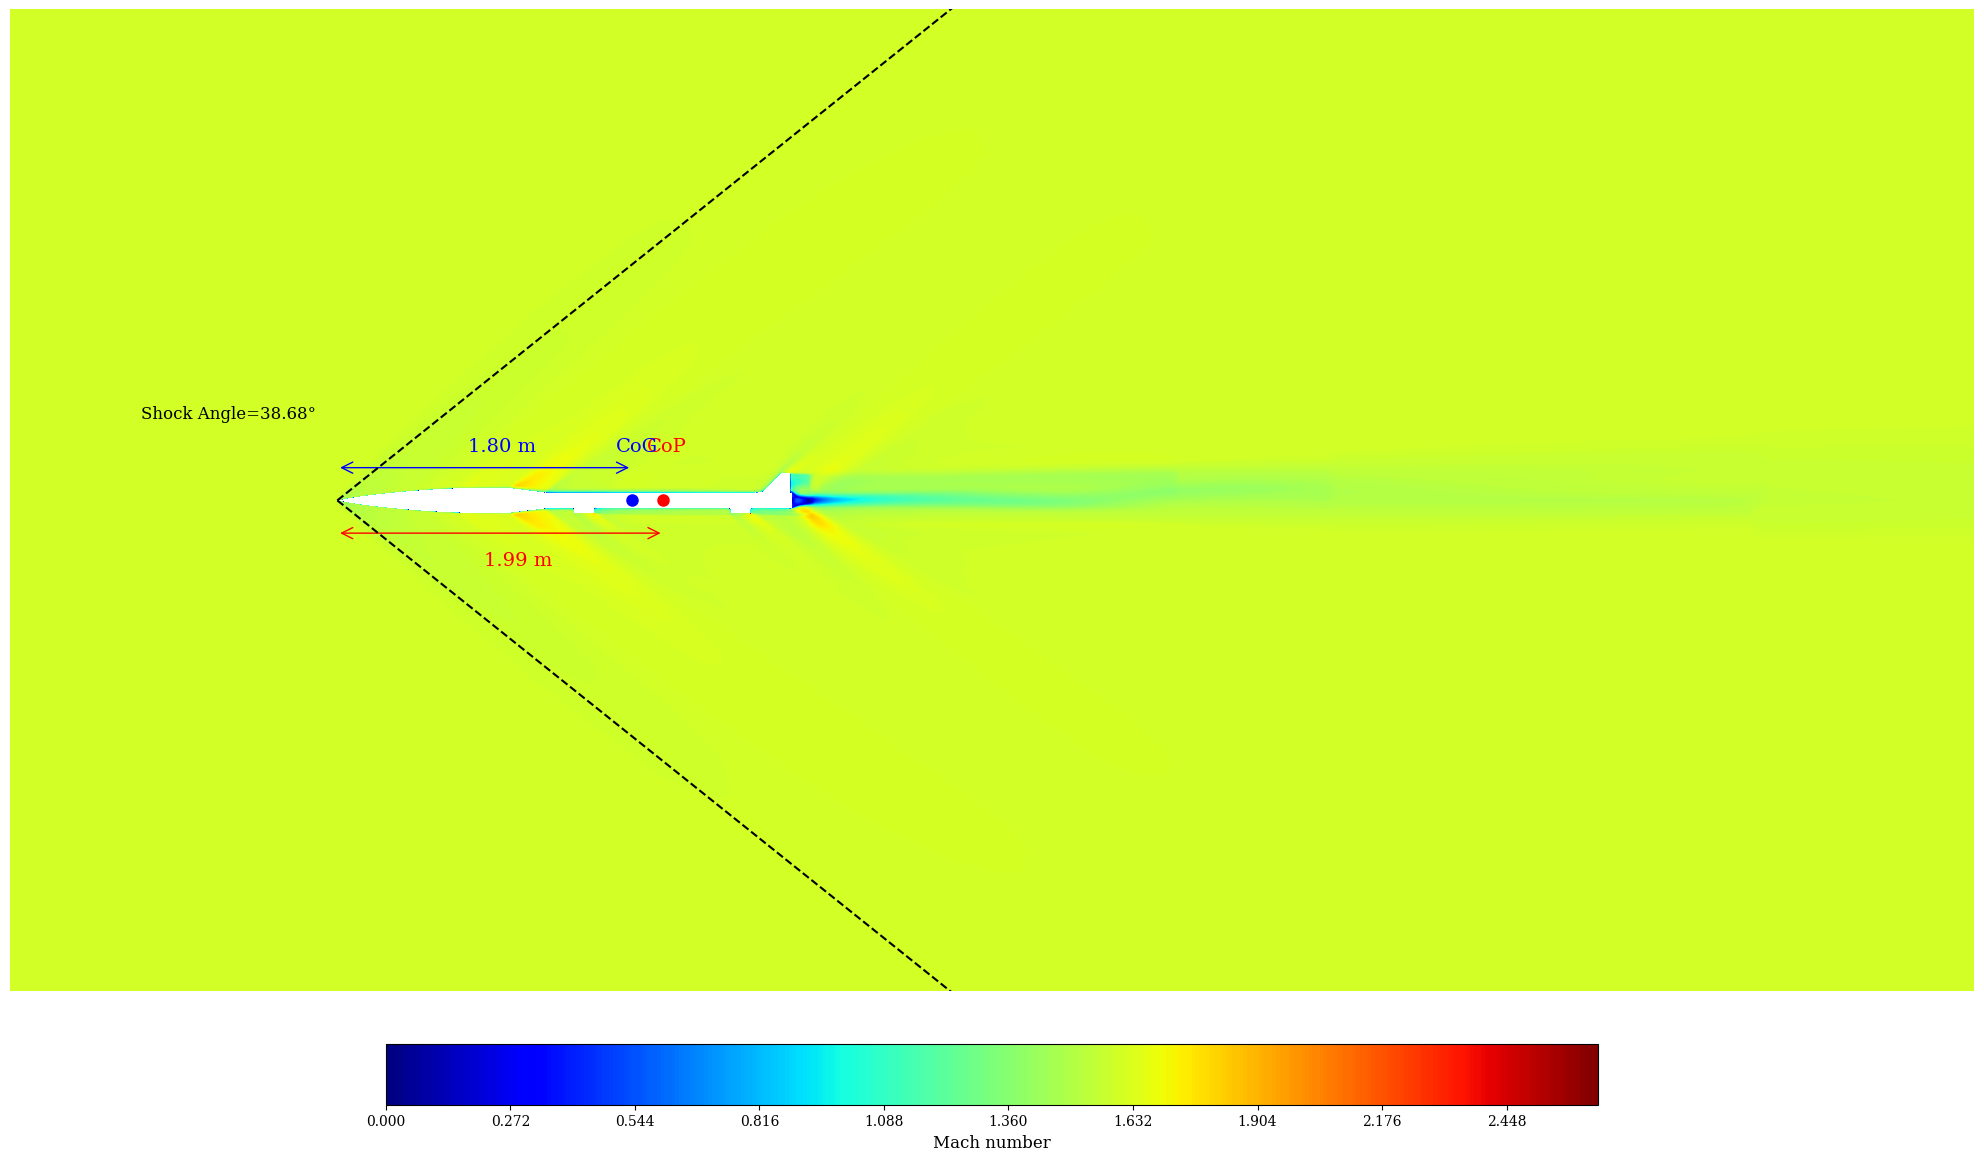

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


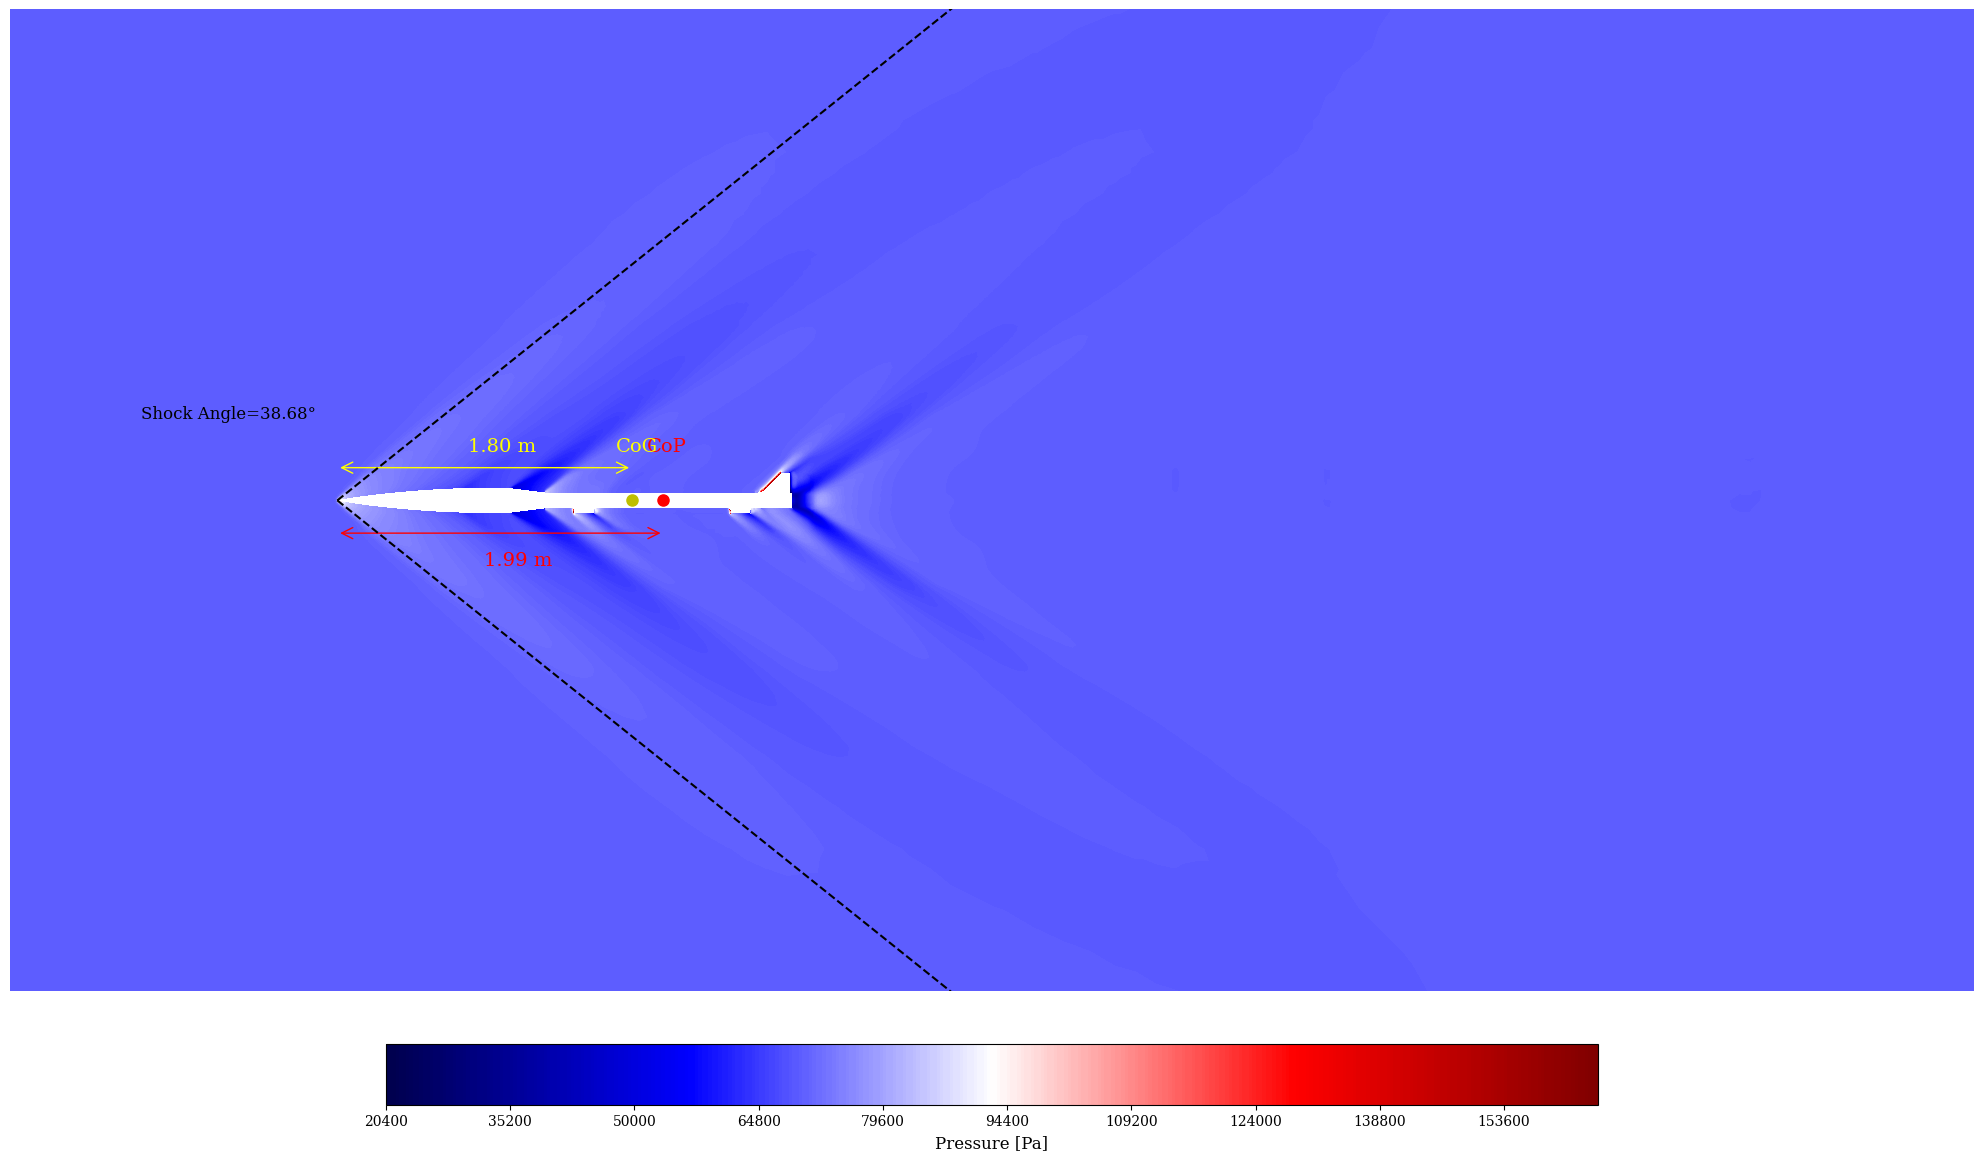

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


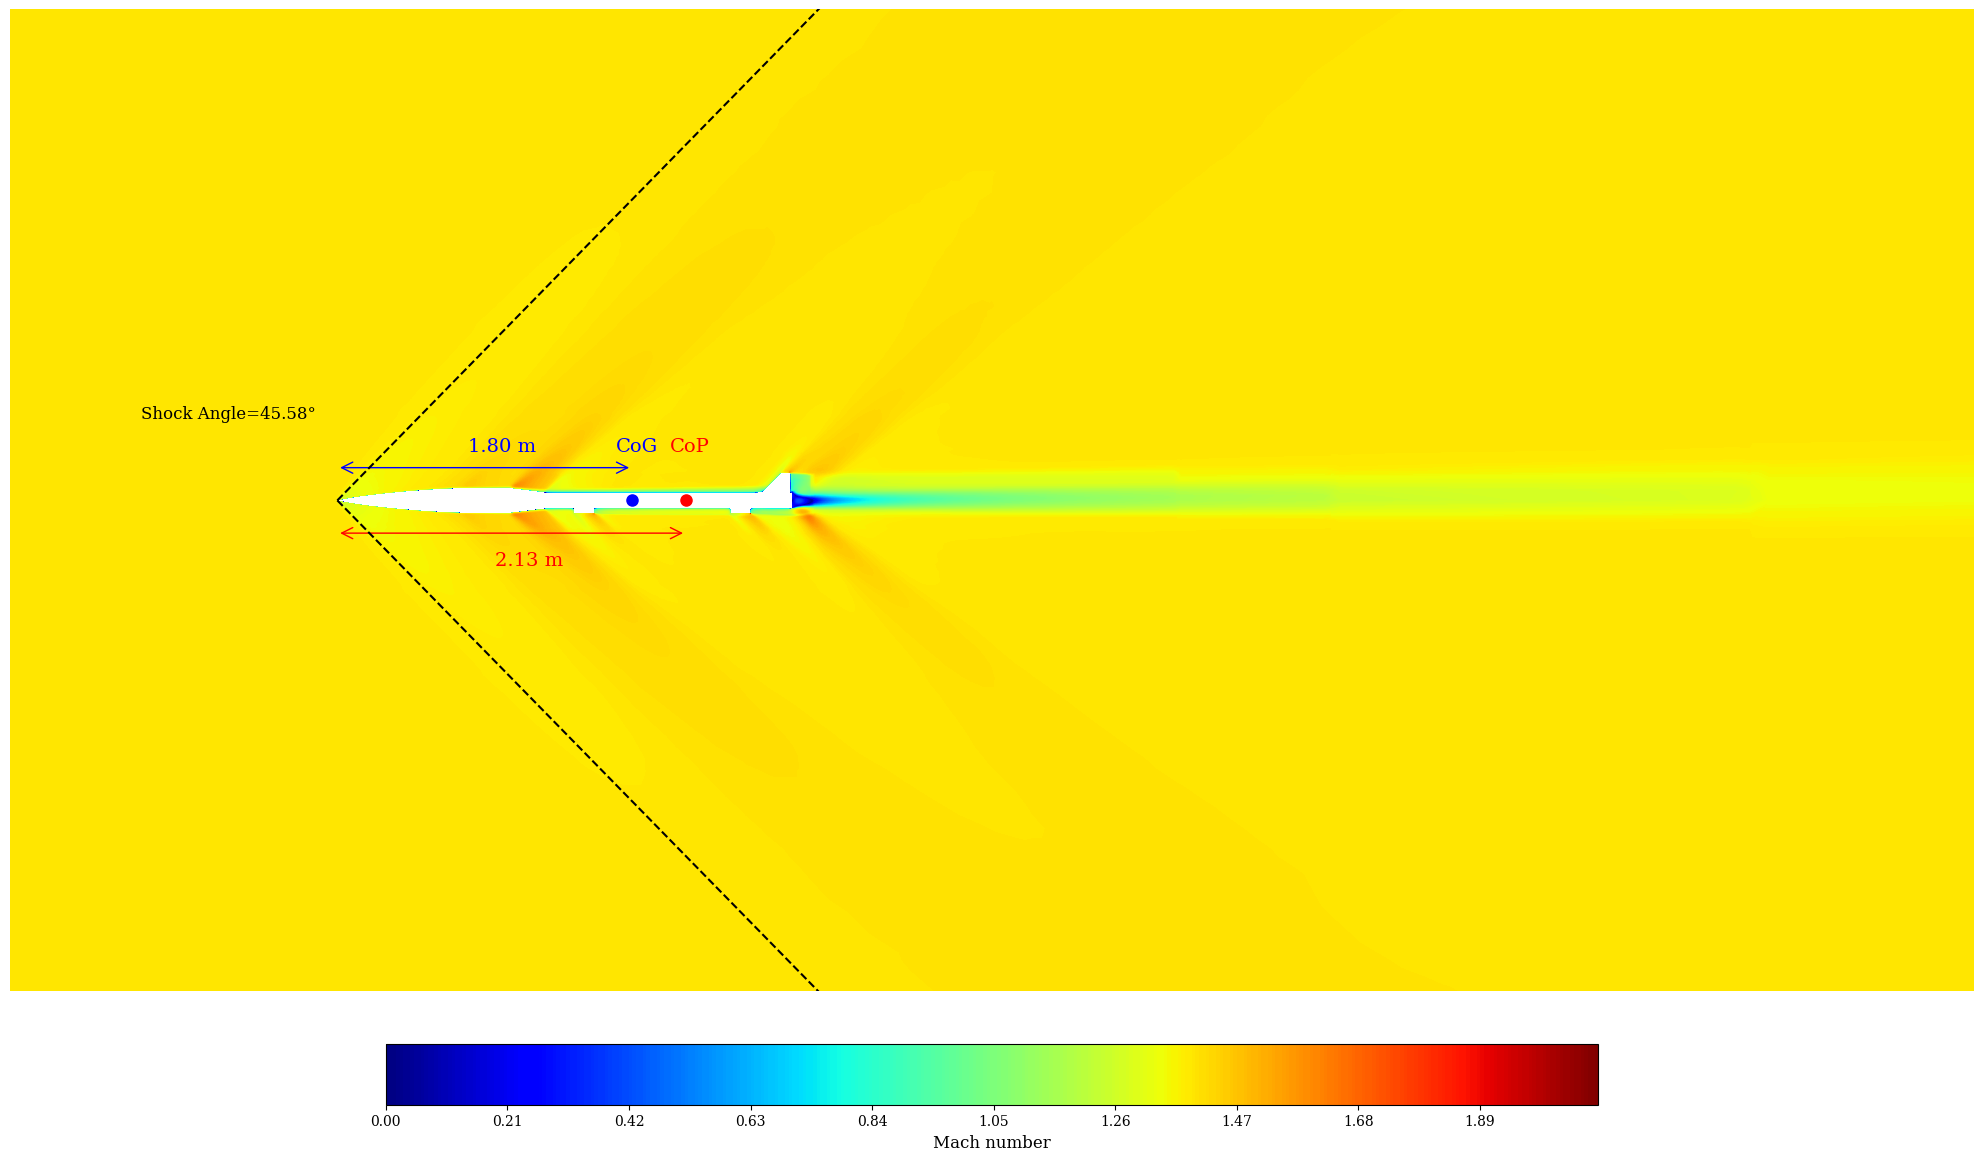

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


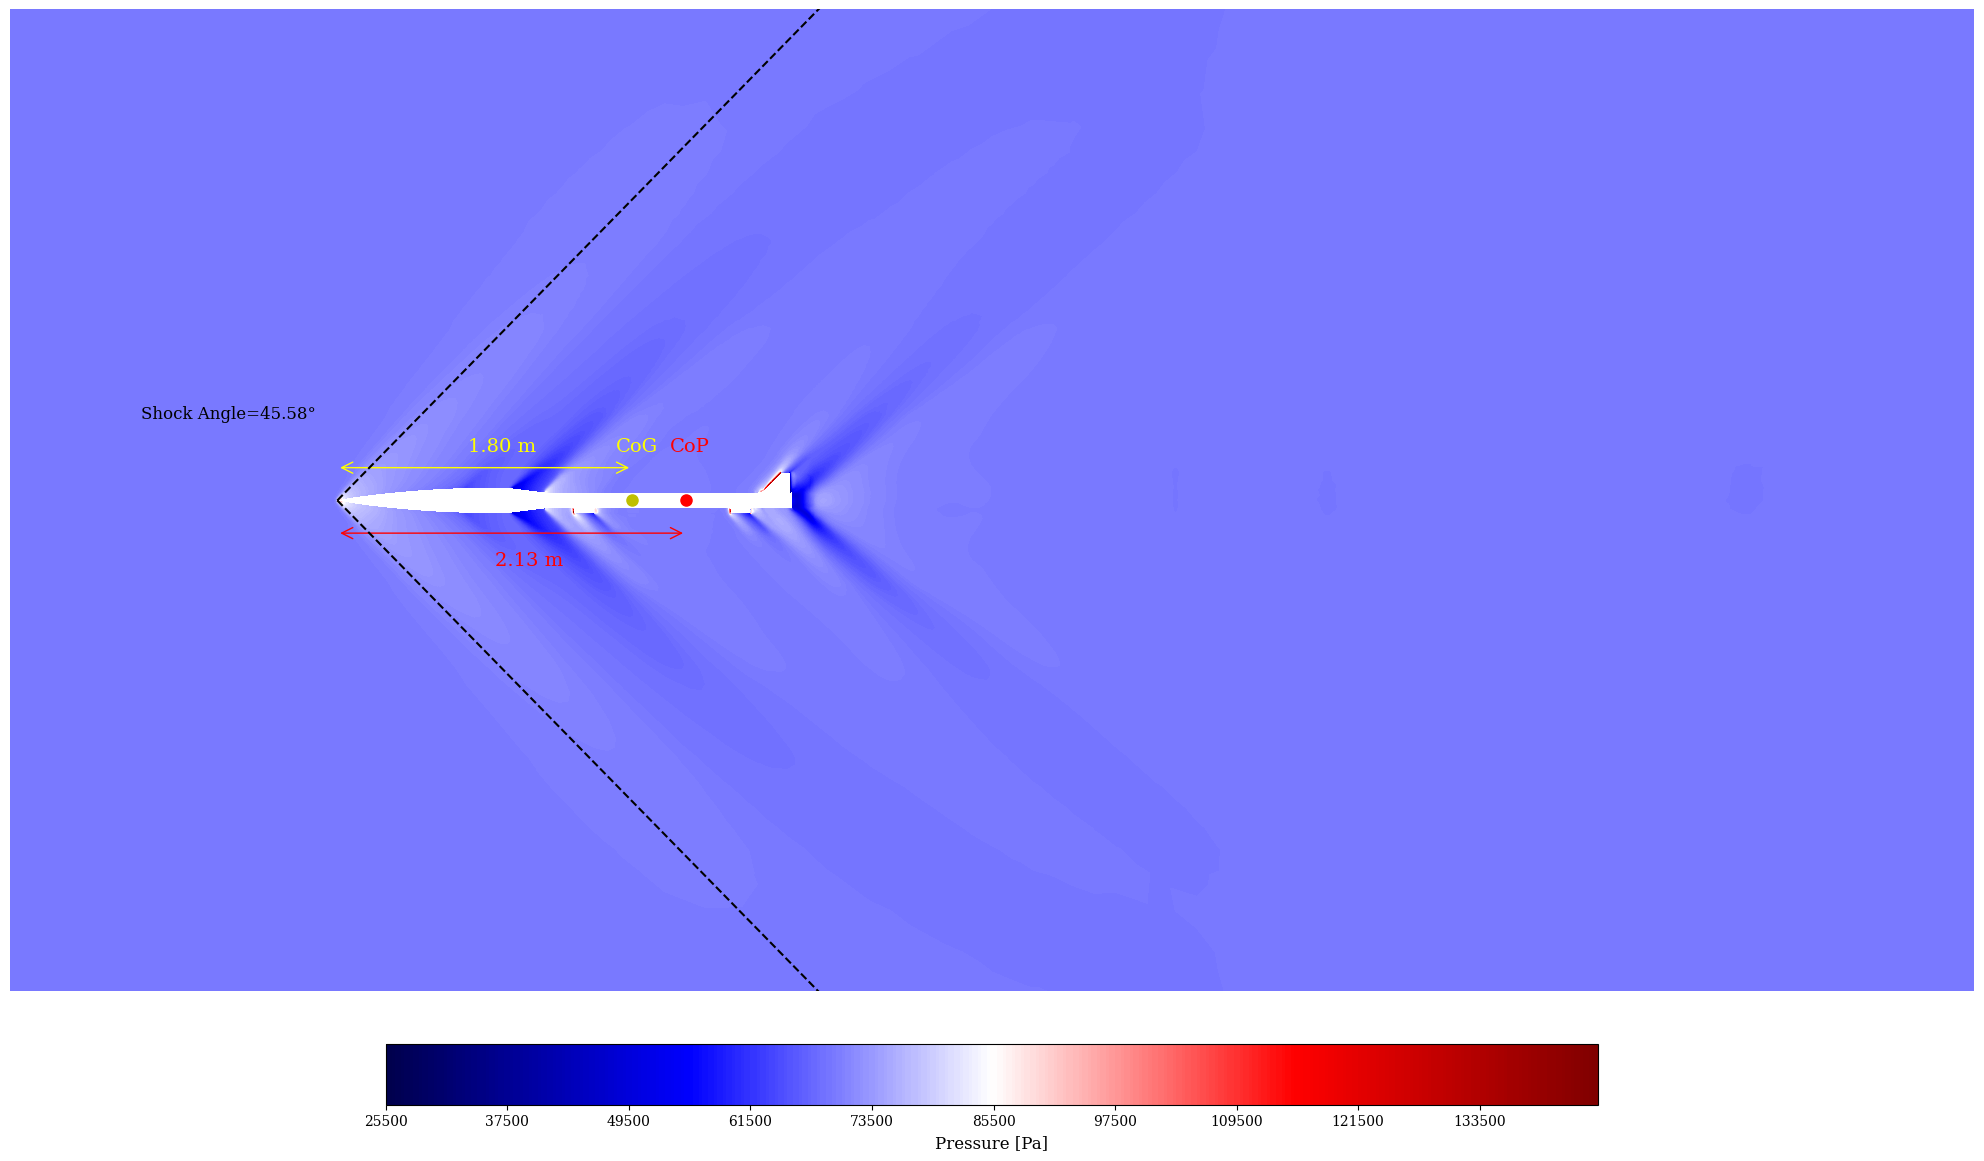

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


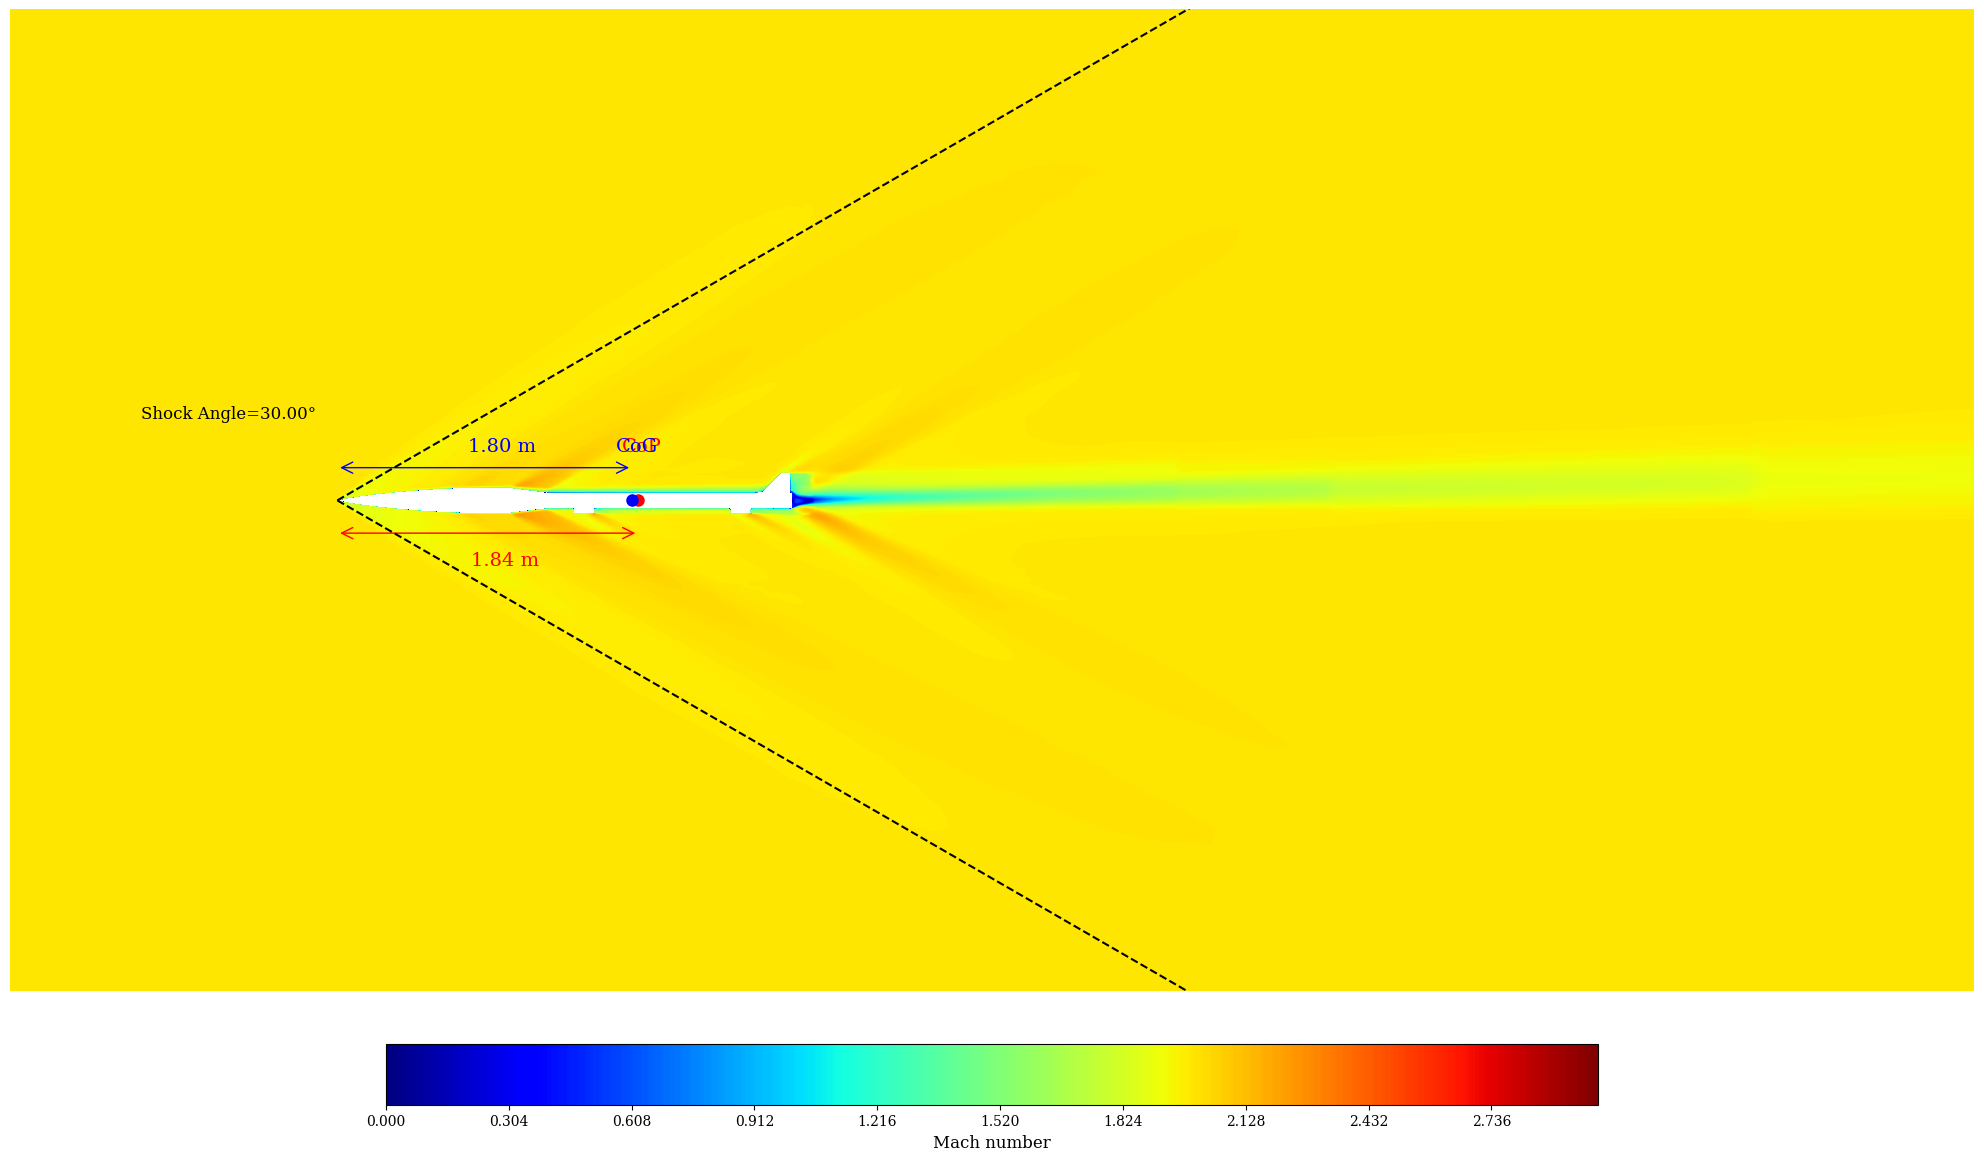

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


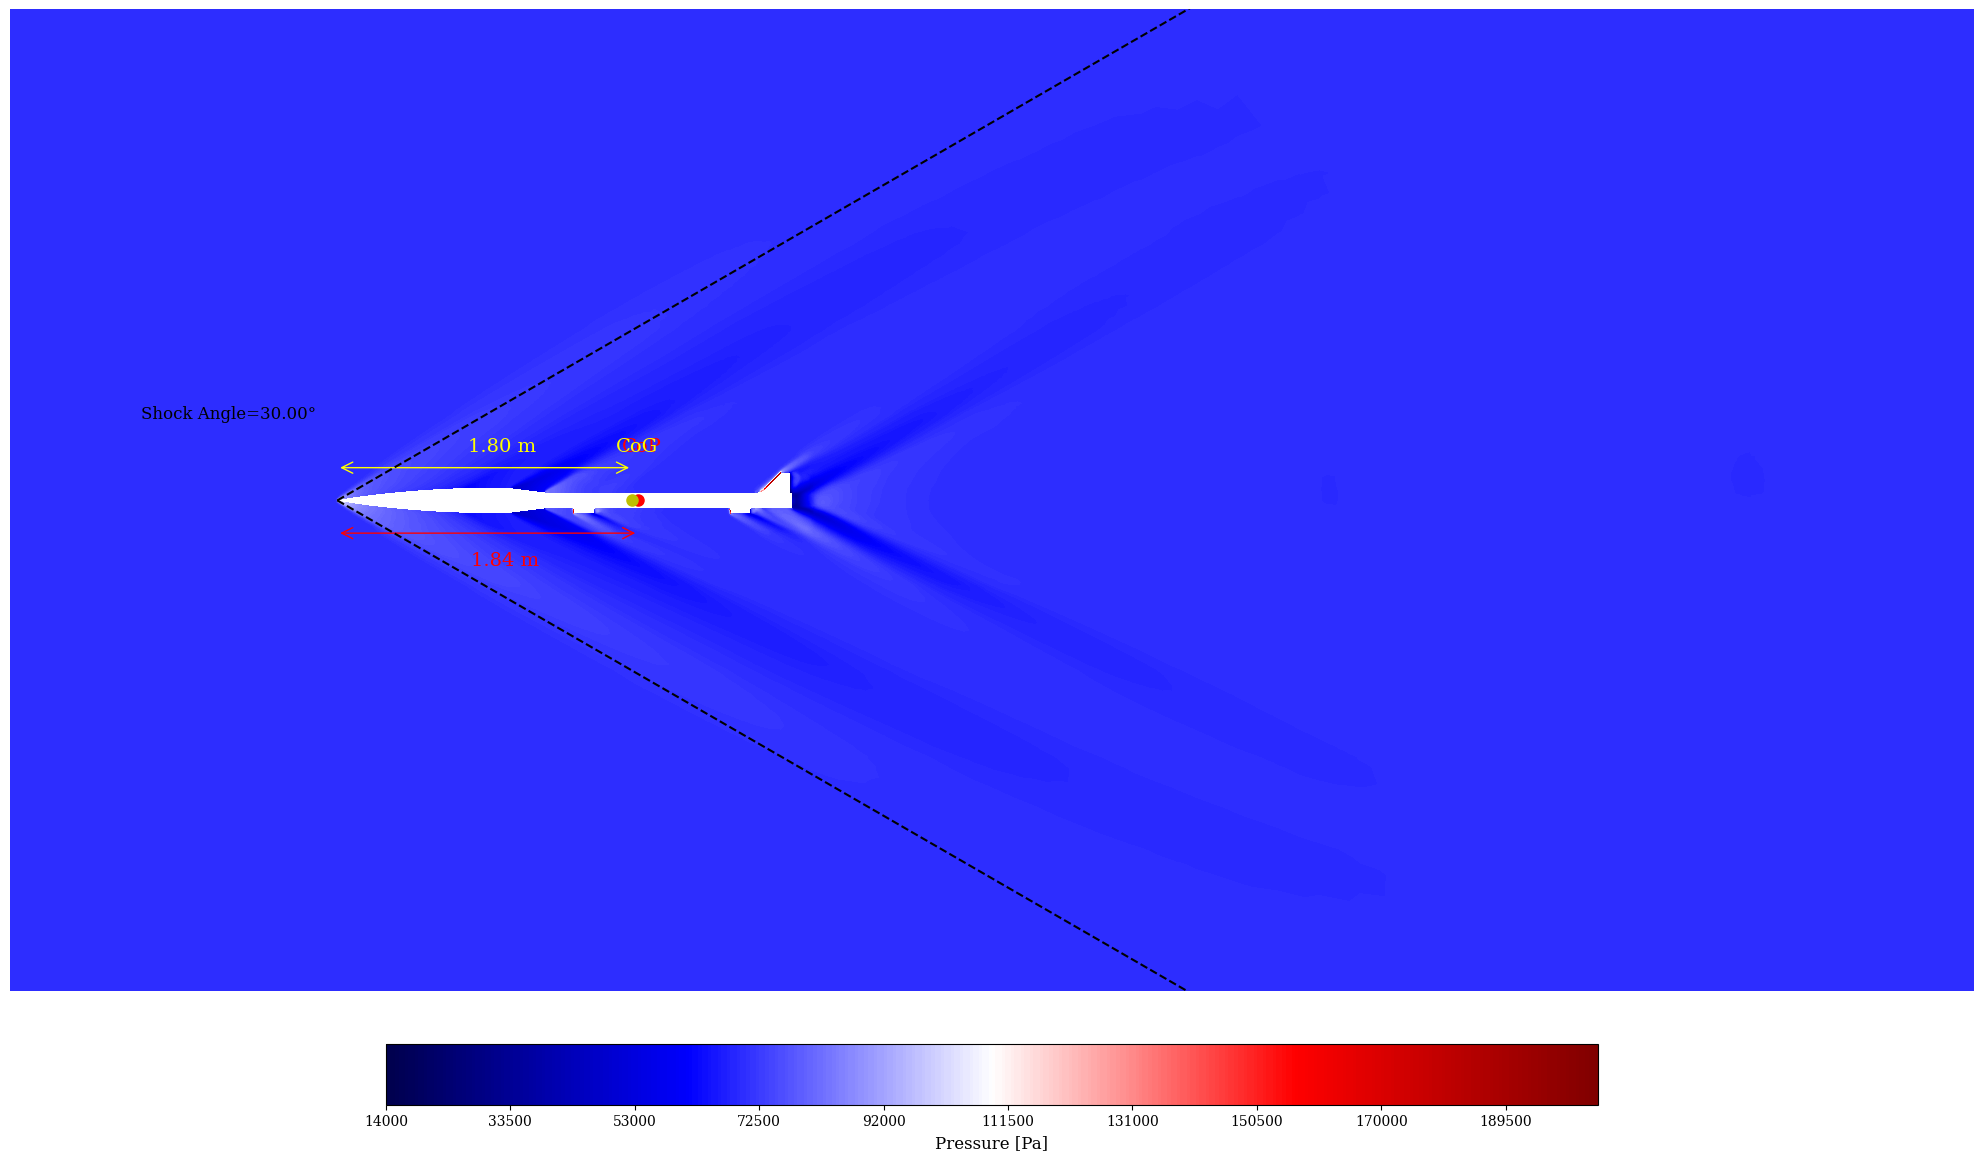

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


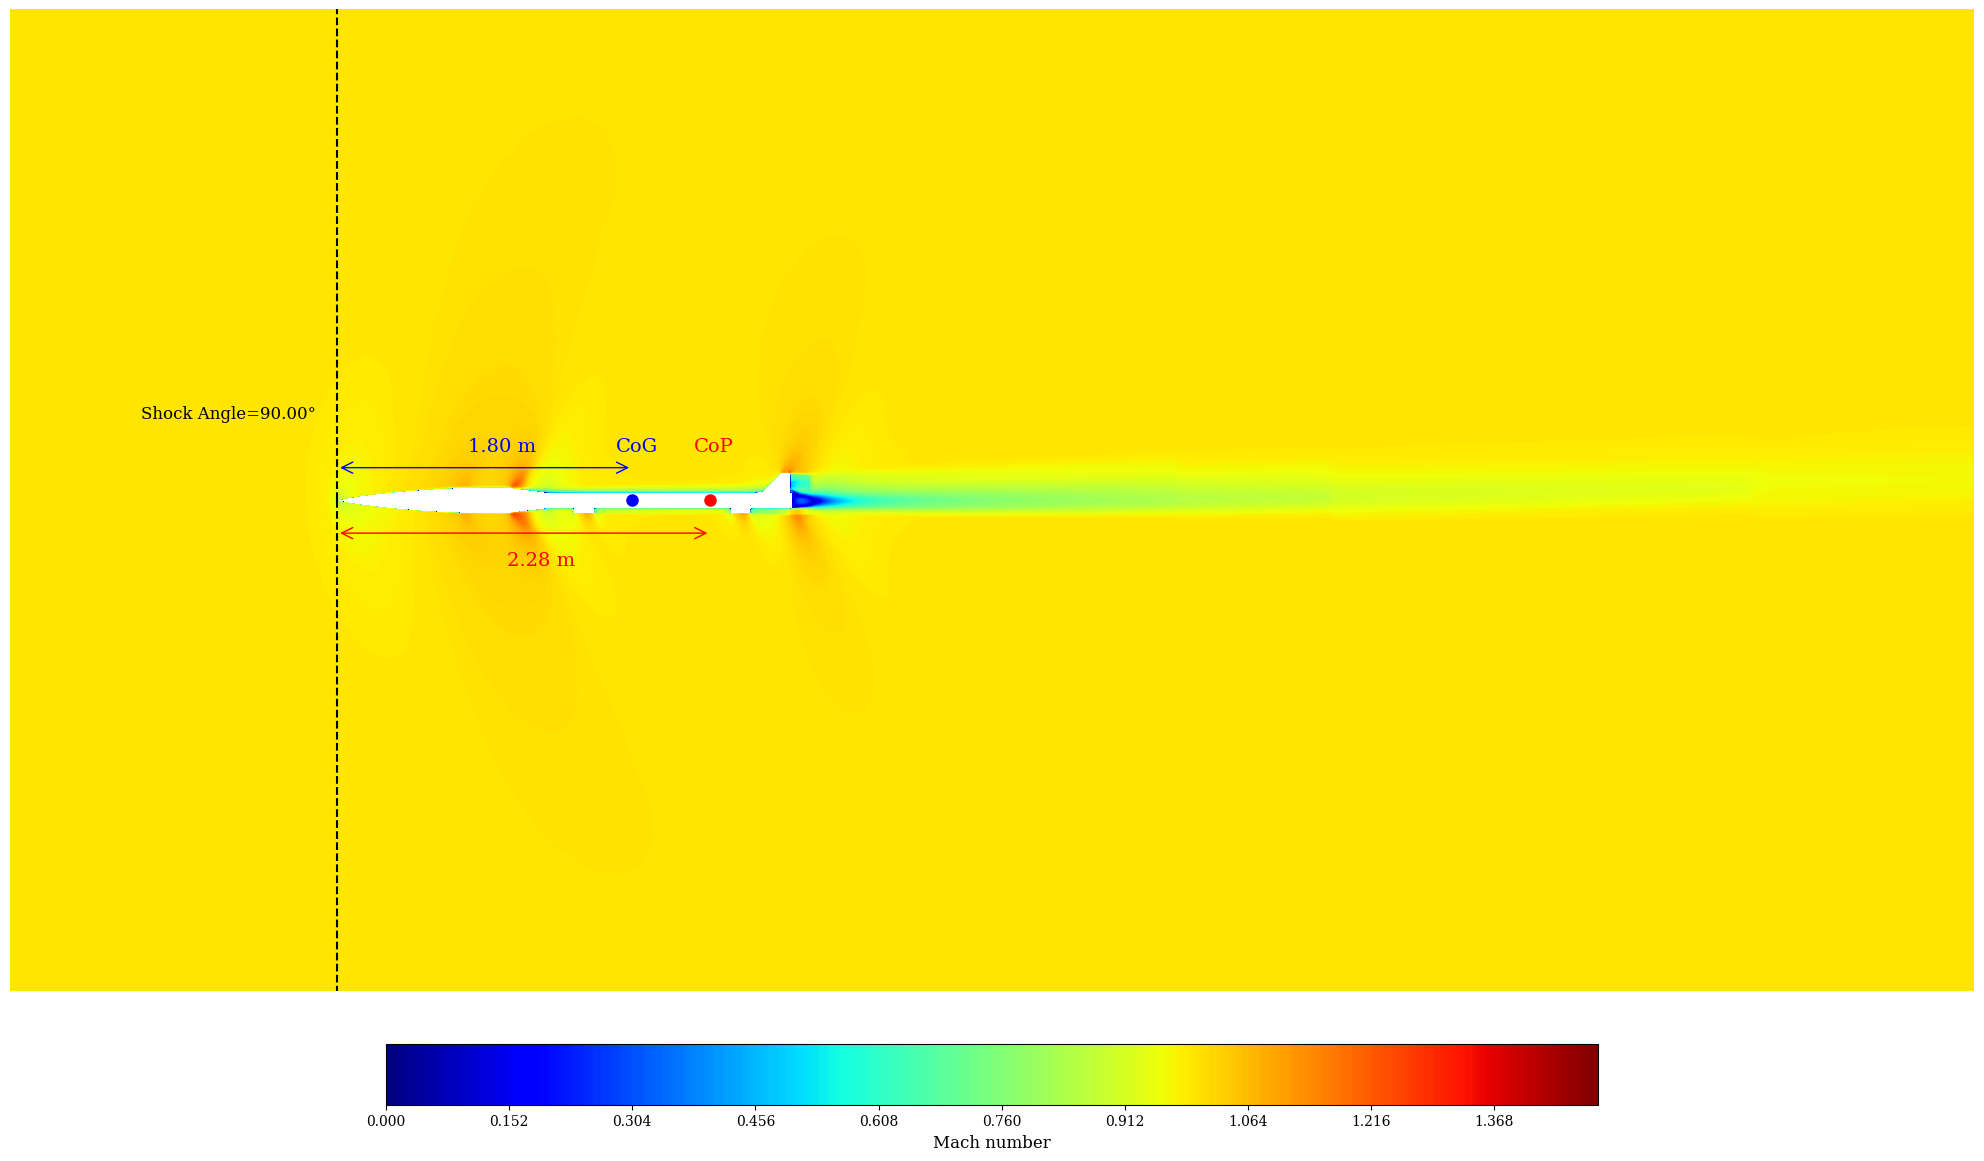

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


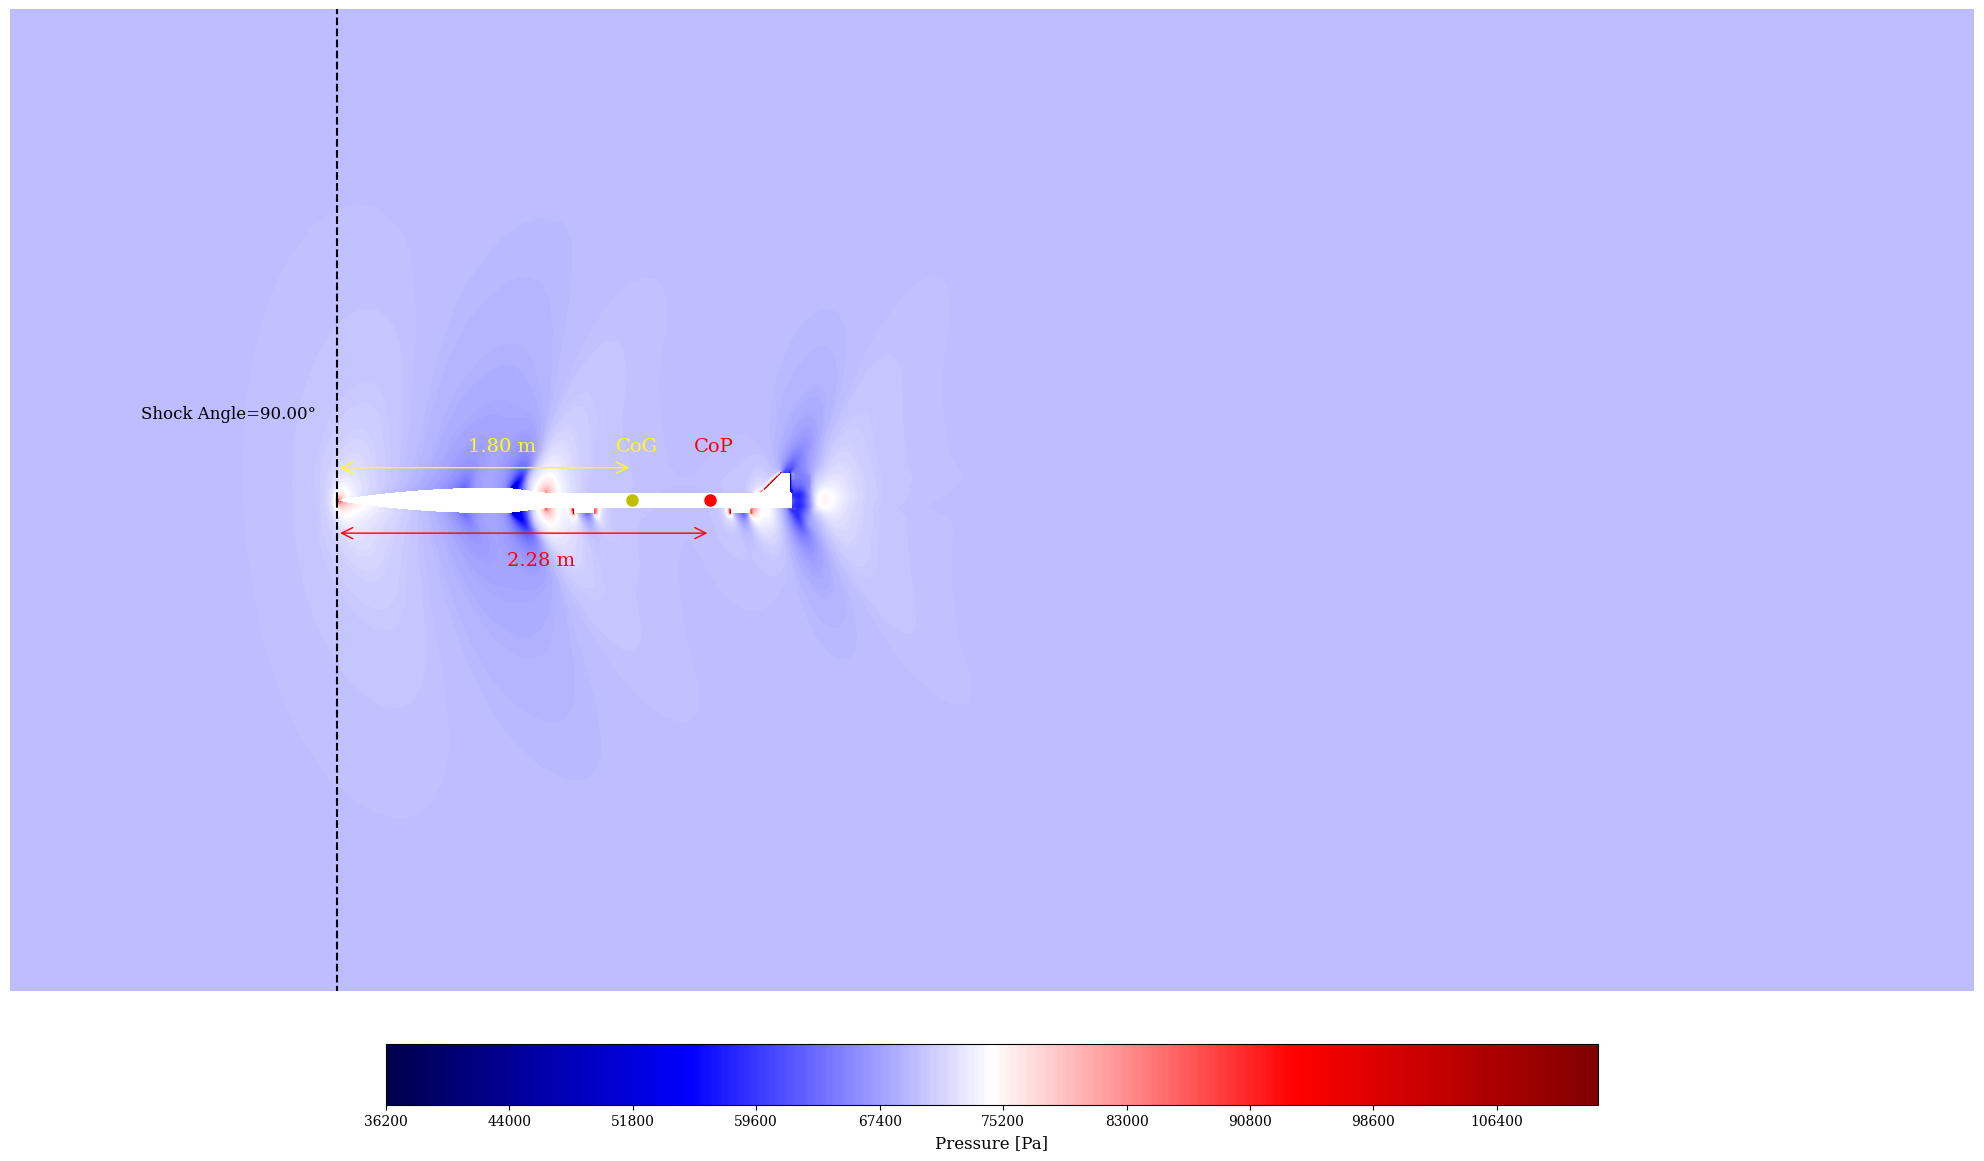

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/1125932735.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


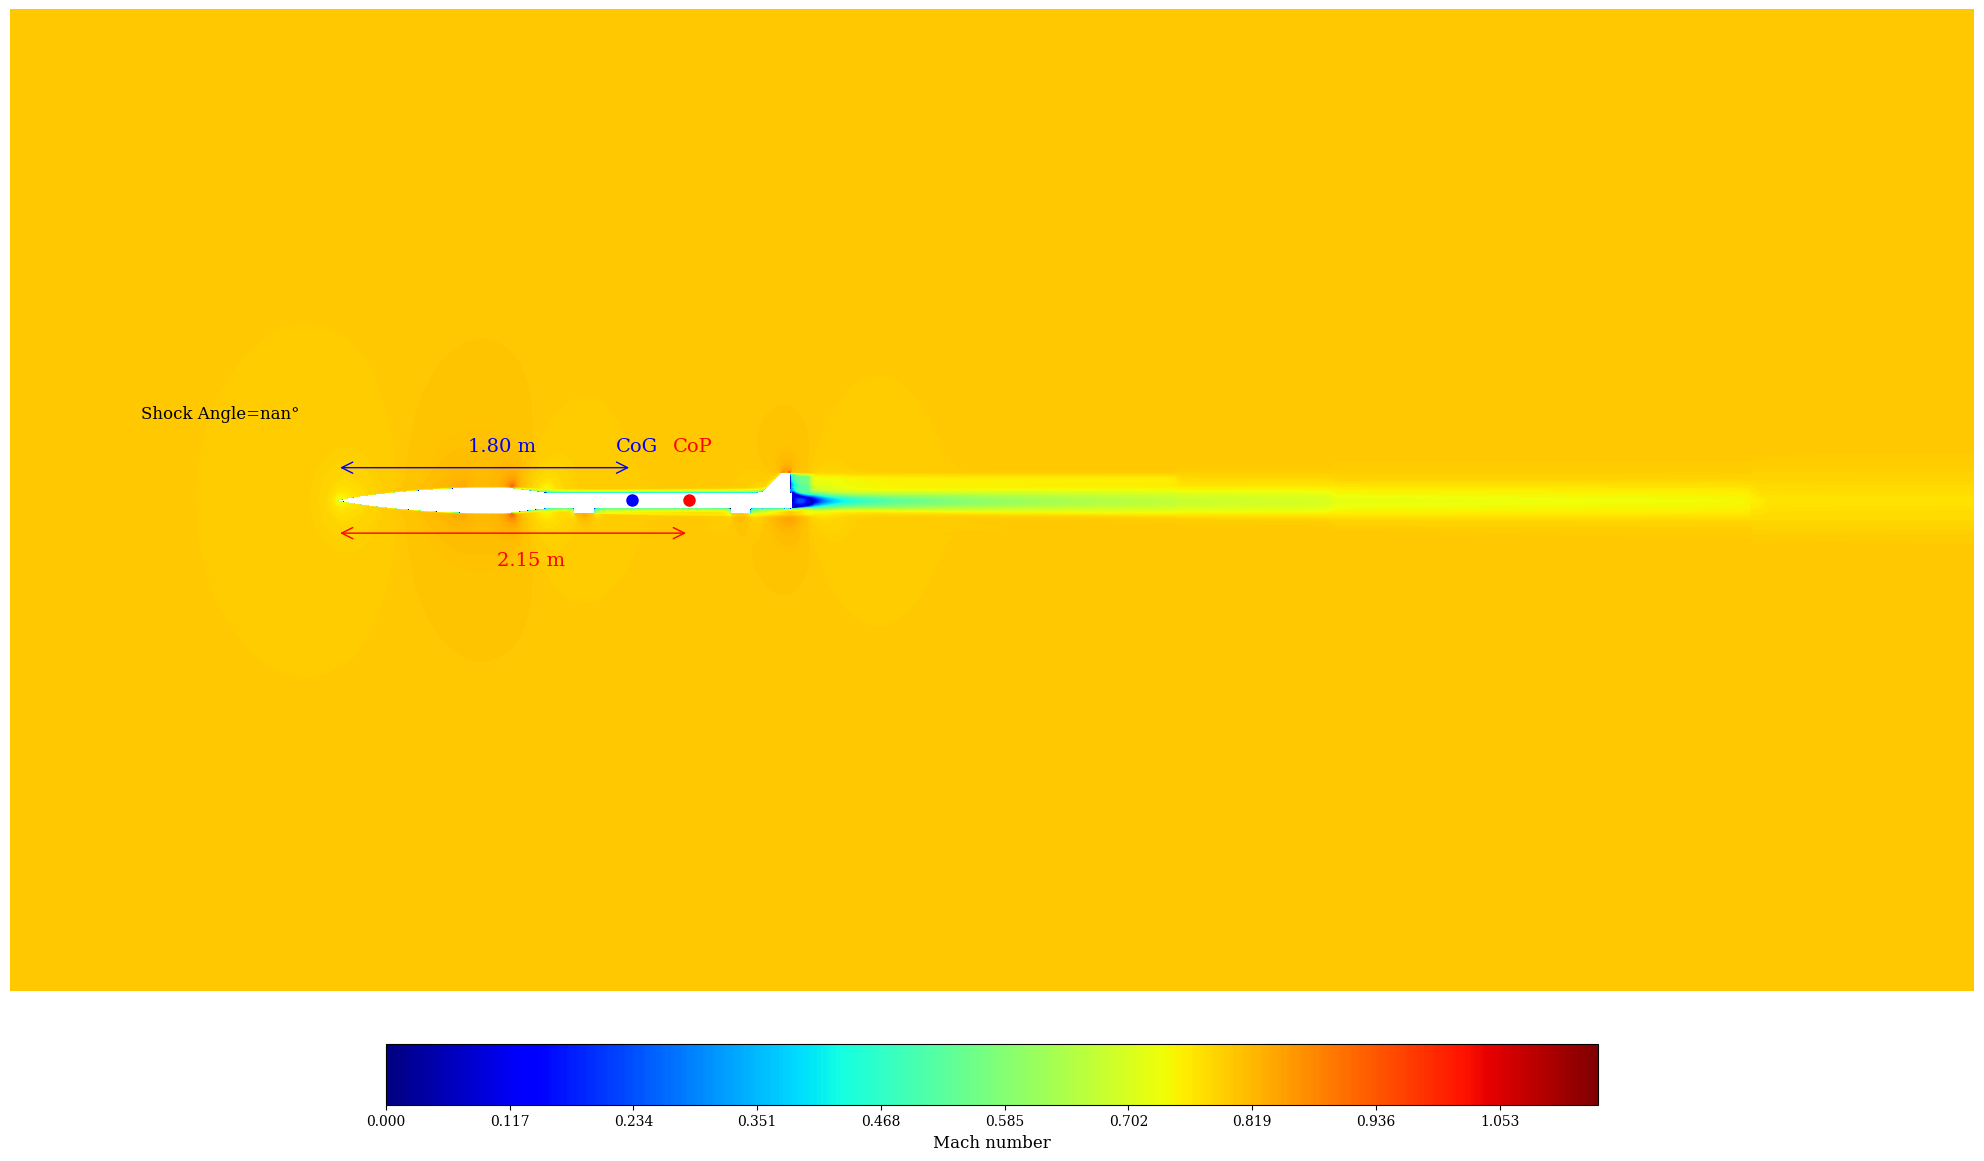

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


/tmp/ipykernel_31565/36085290.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.degrees(np.arcsin(1 / Ma))


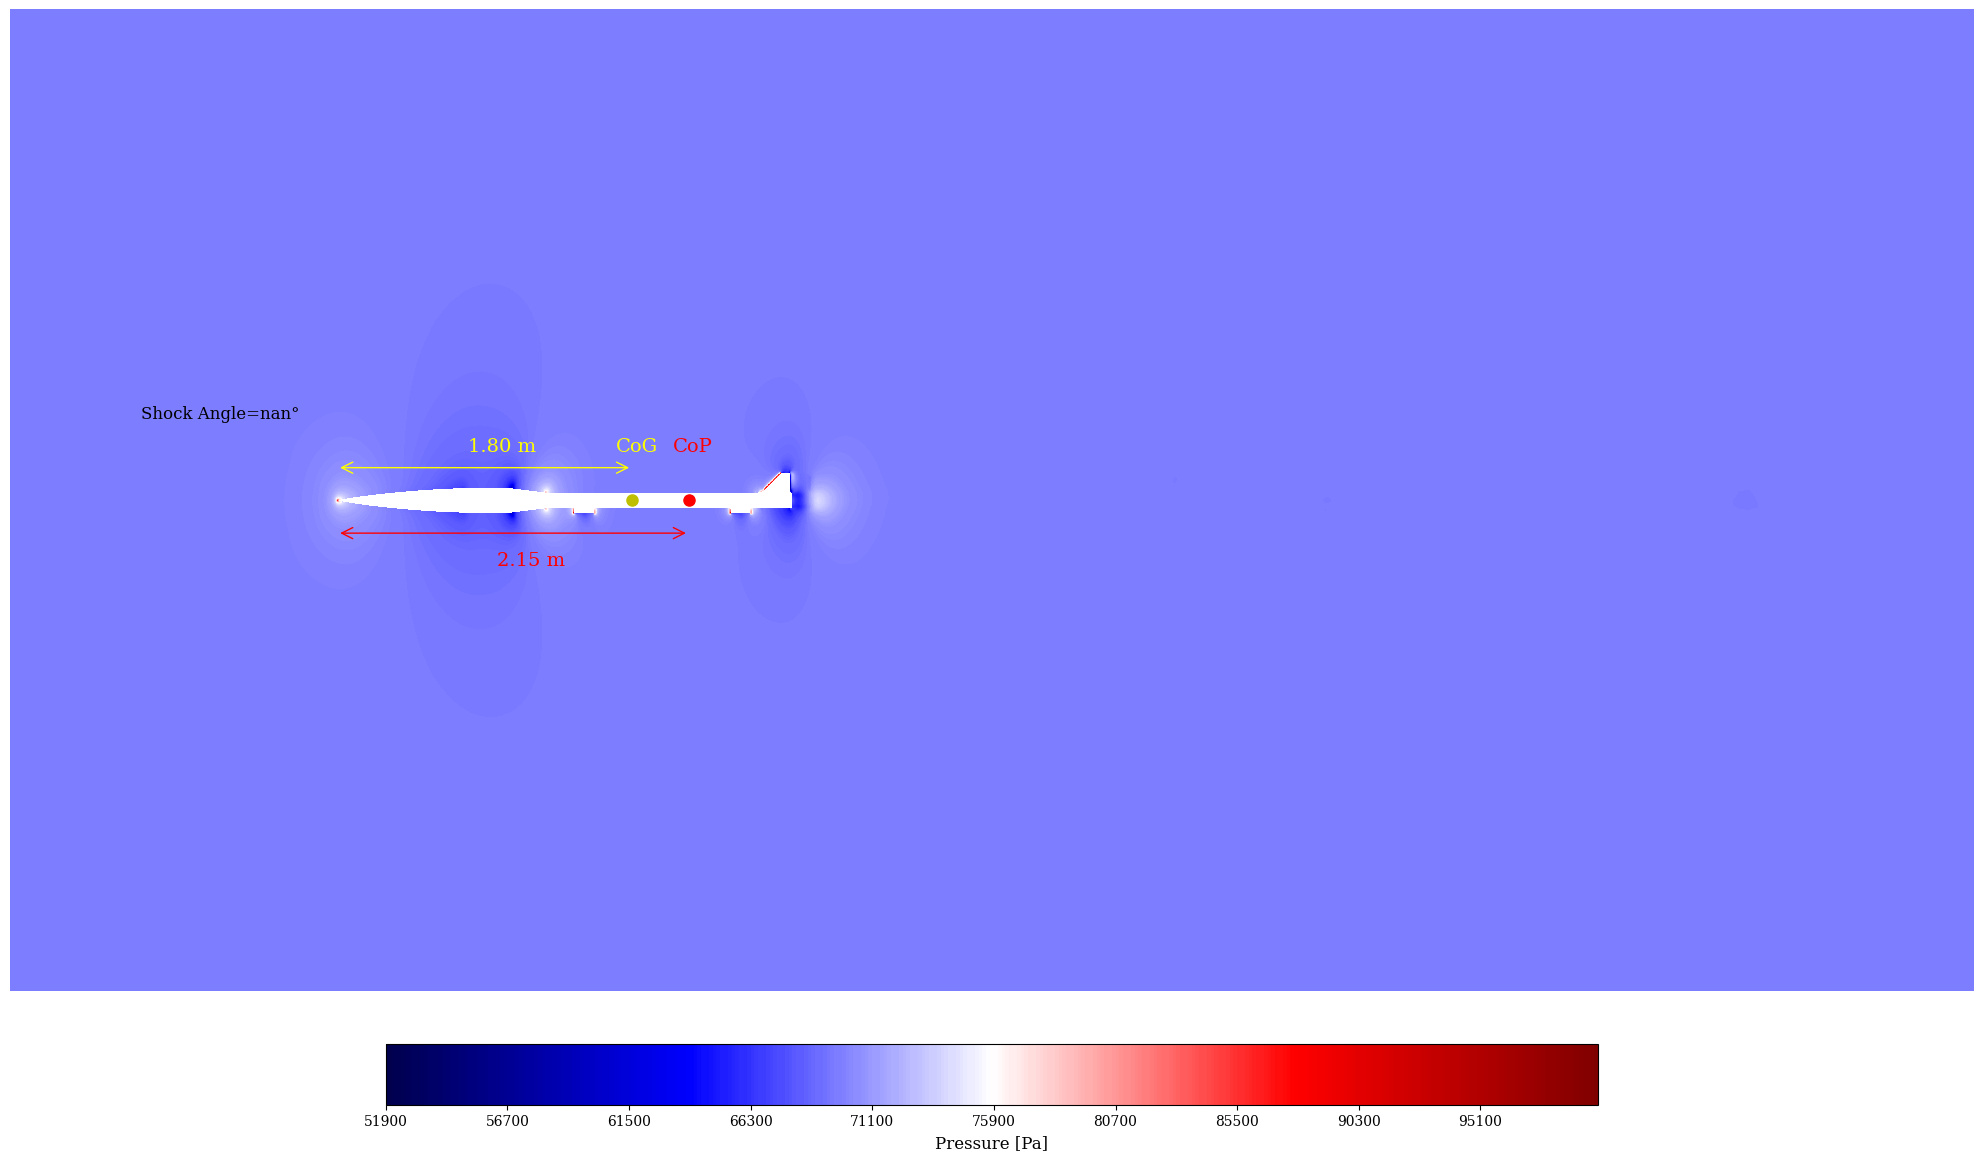

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


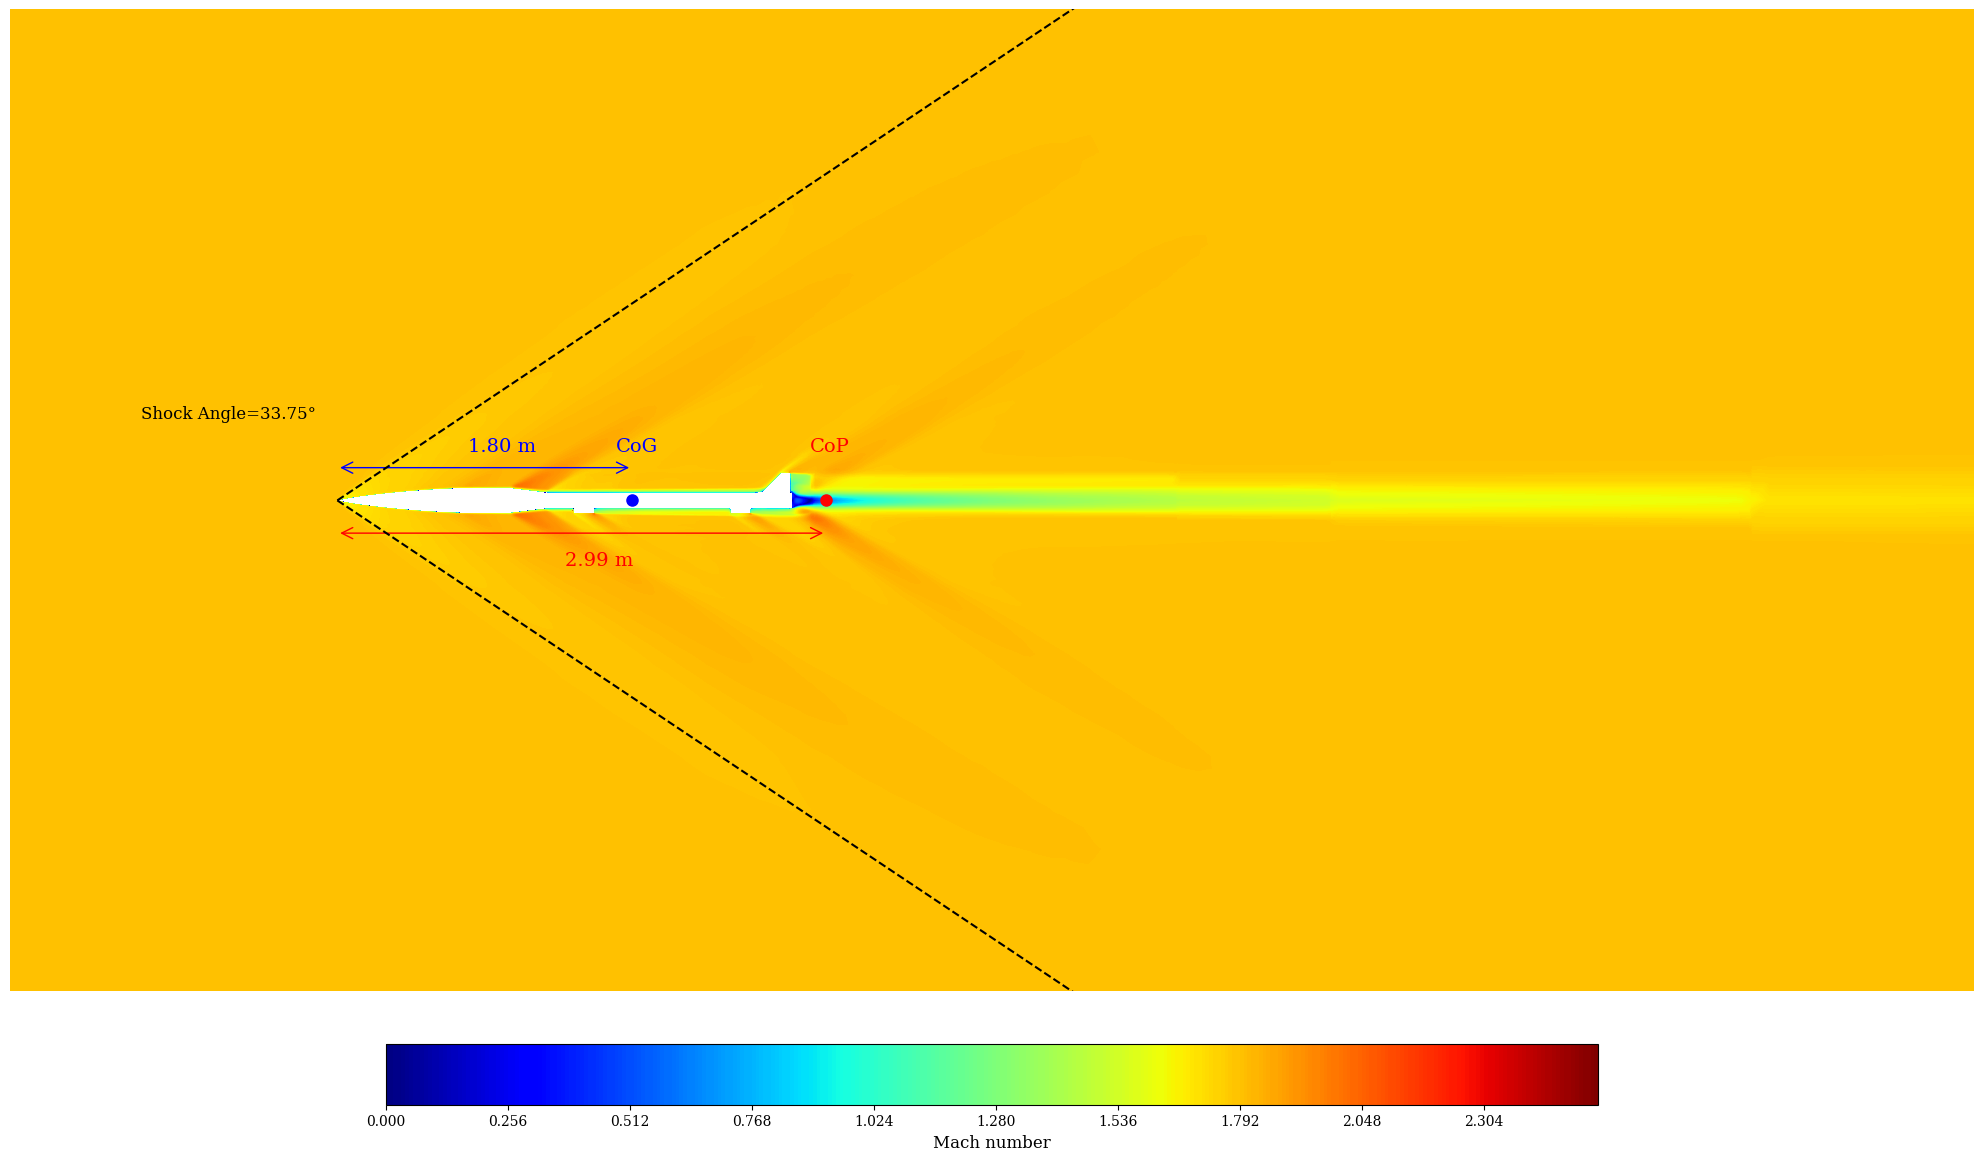

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


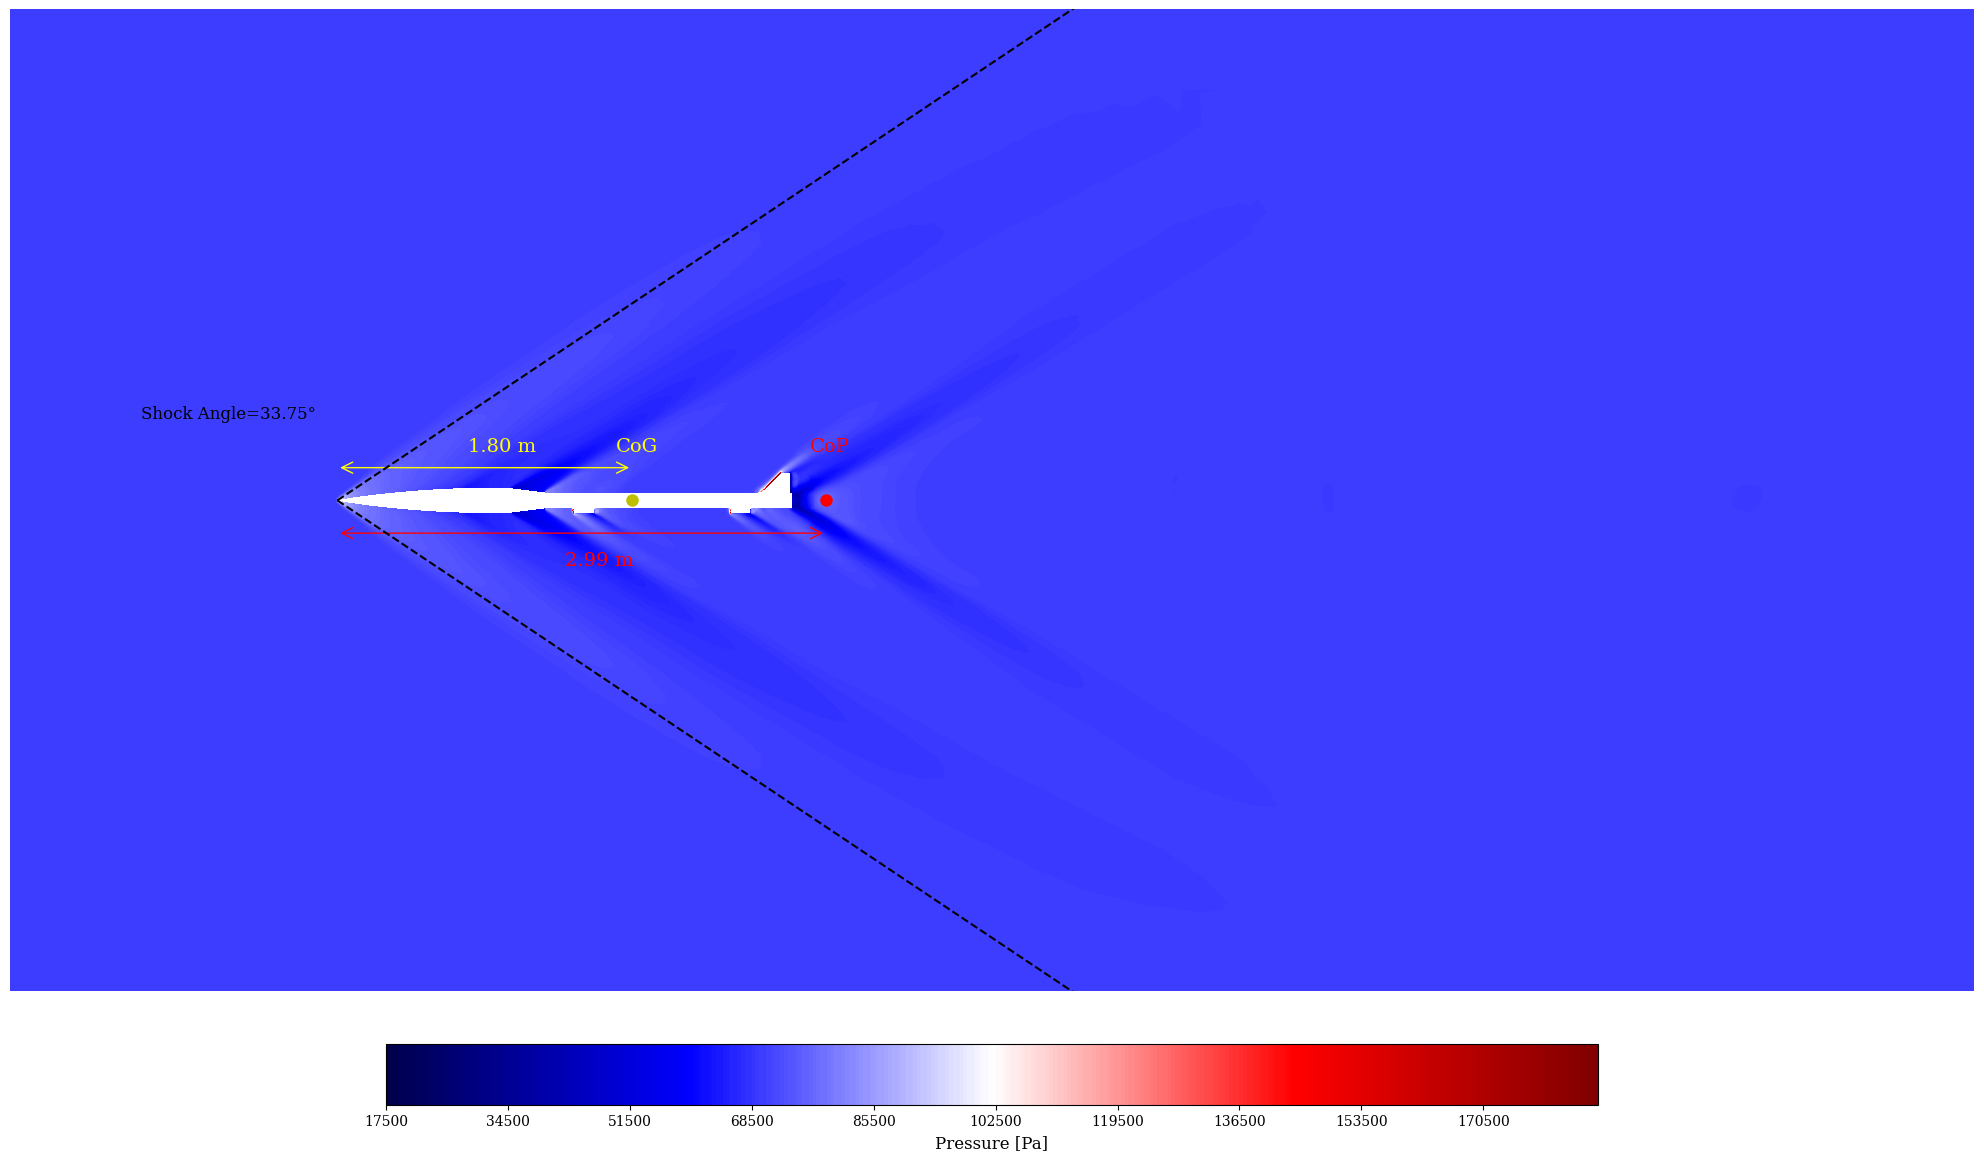

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


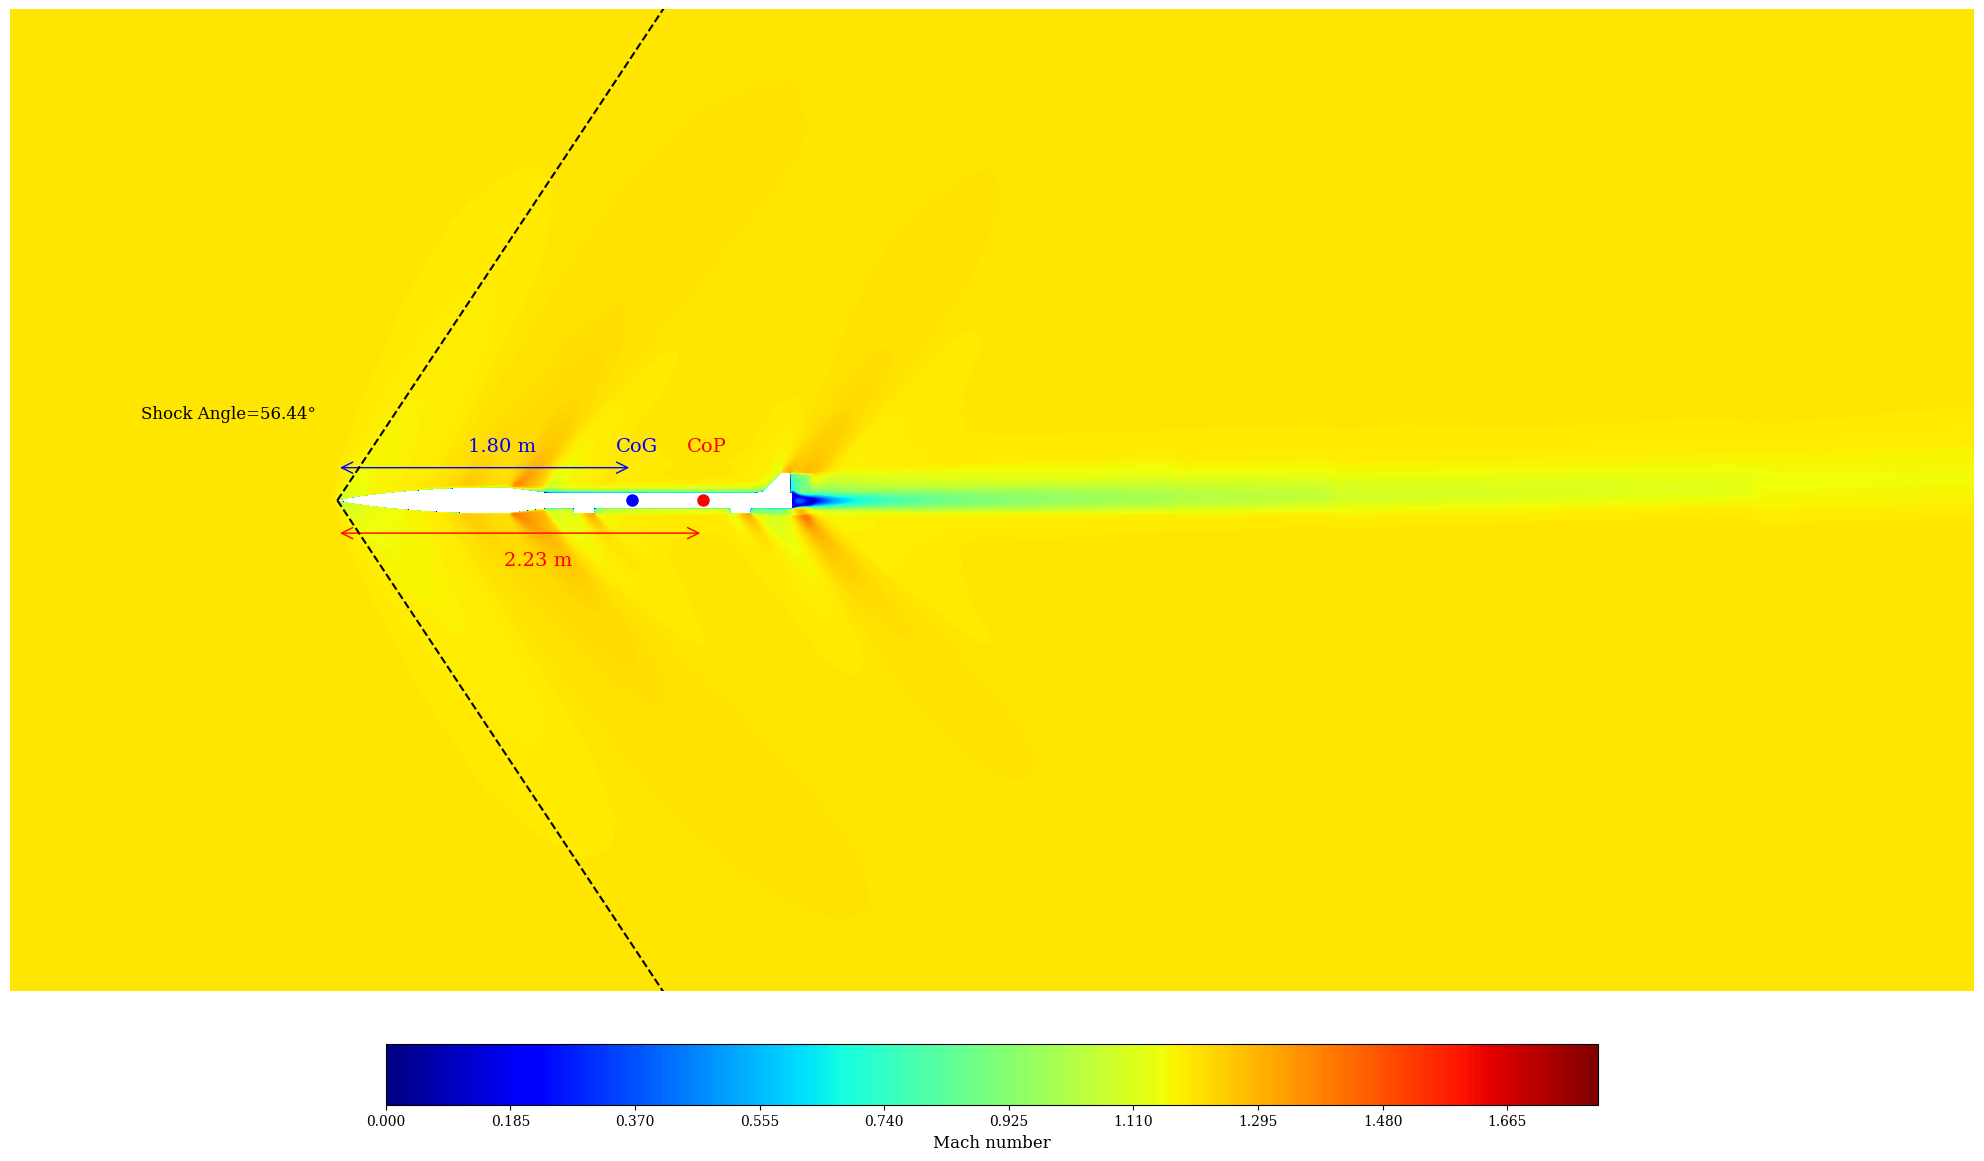

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


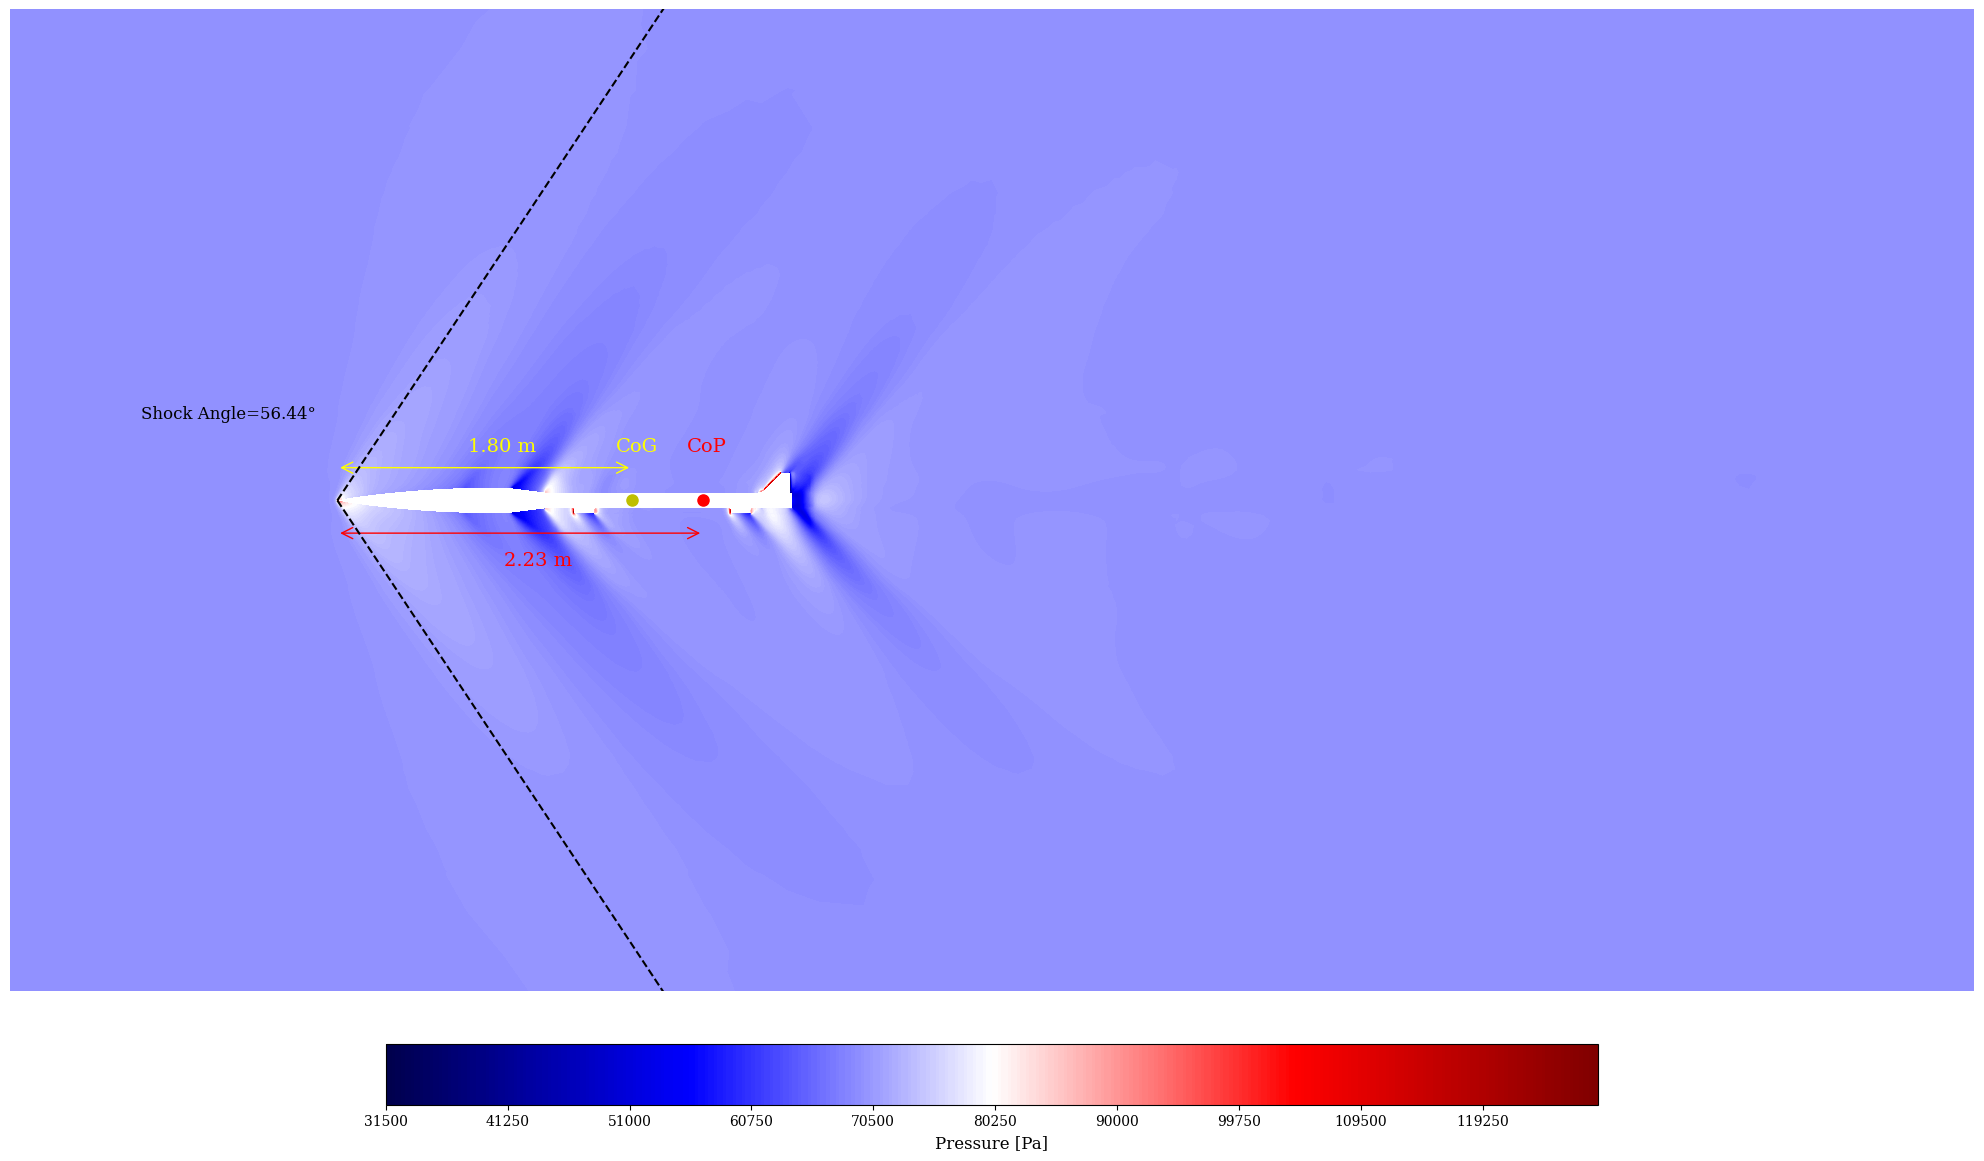

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


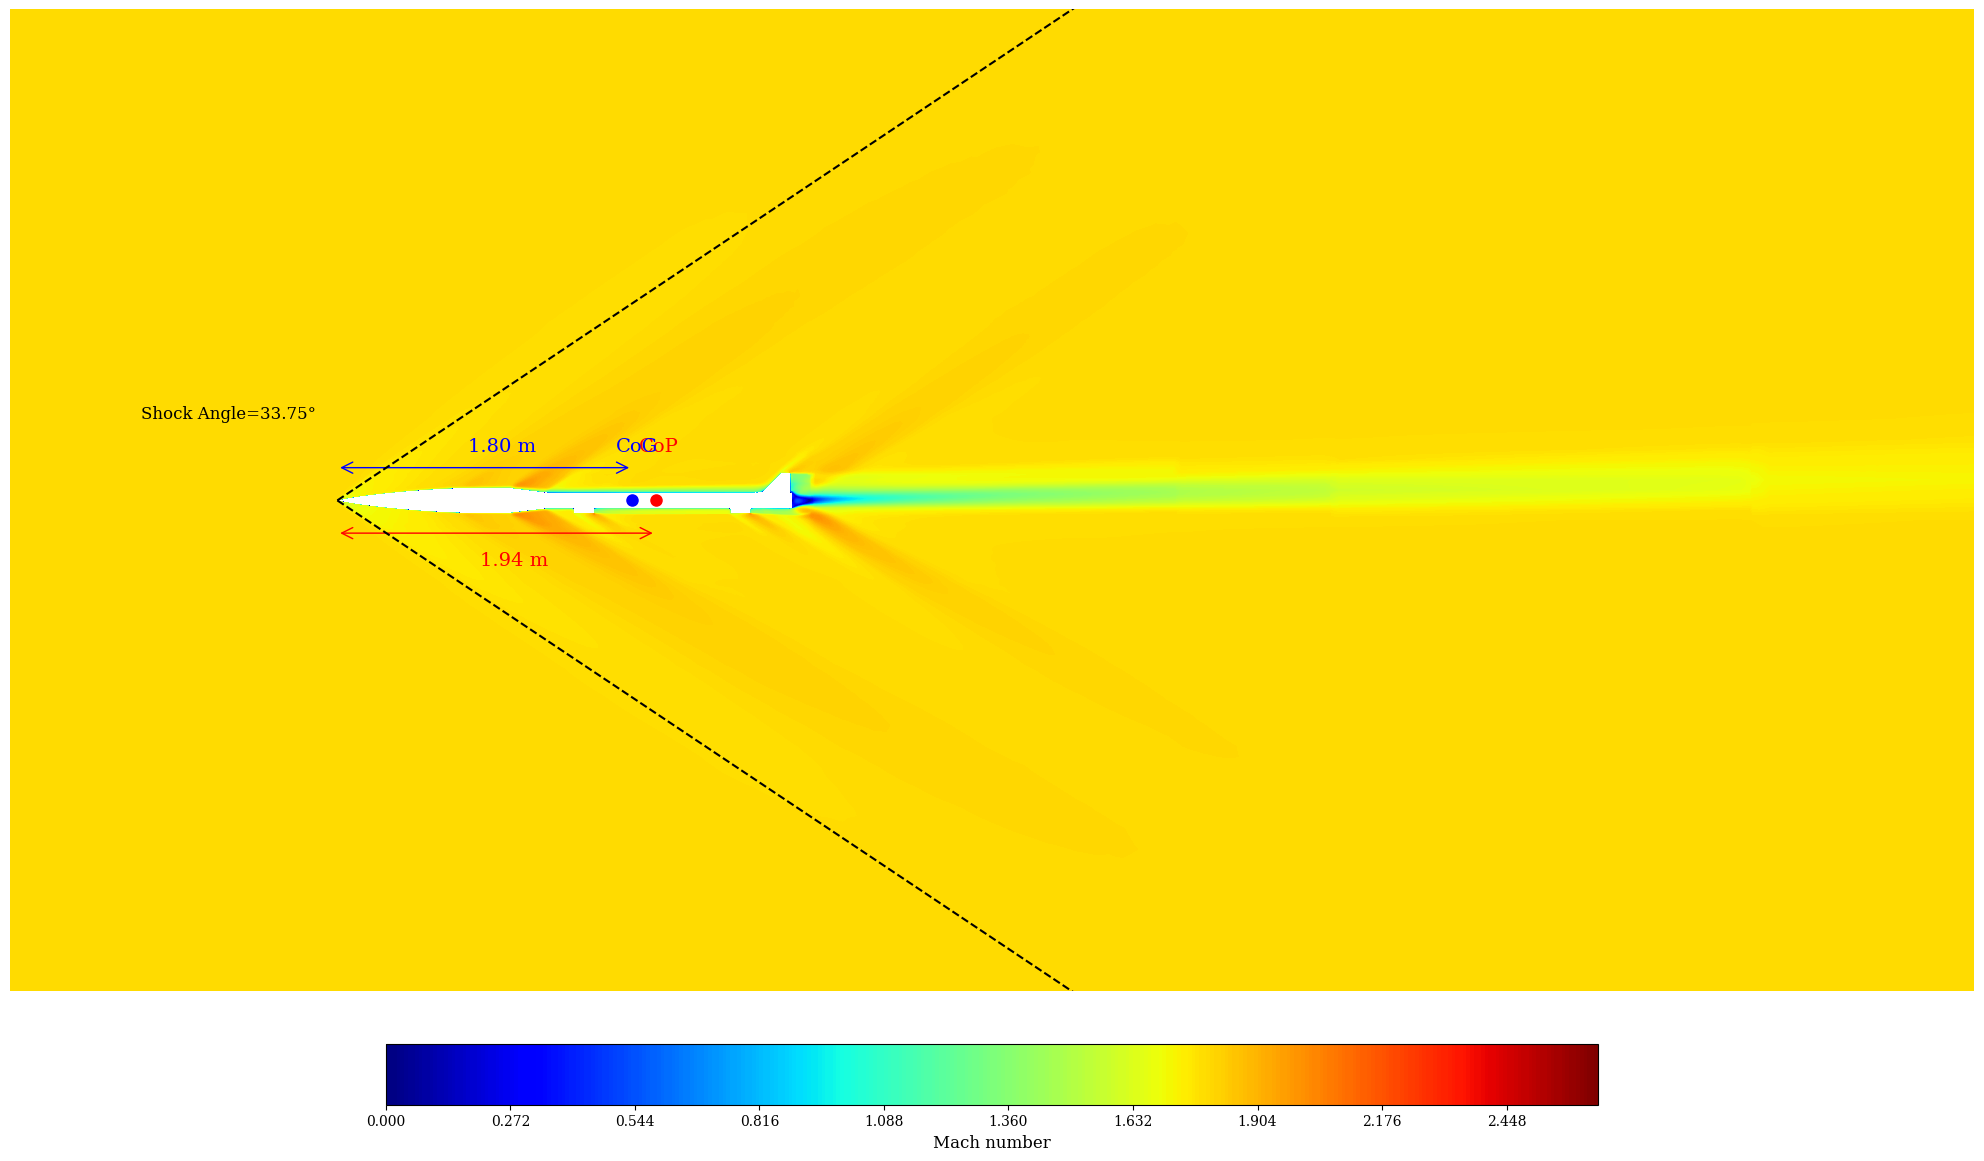

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


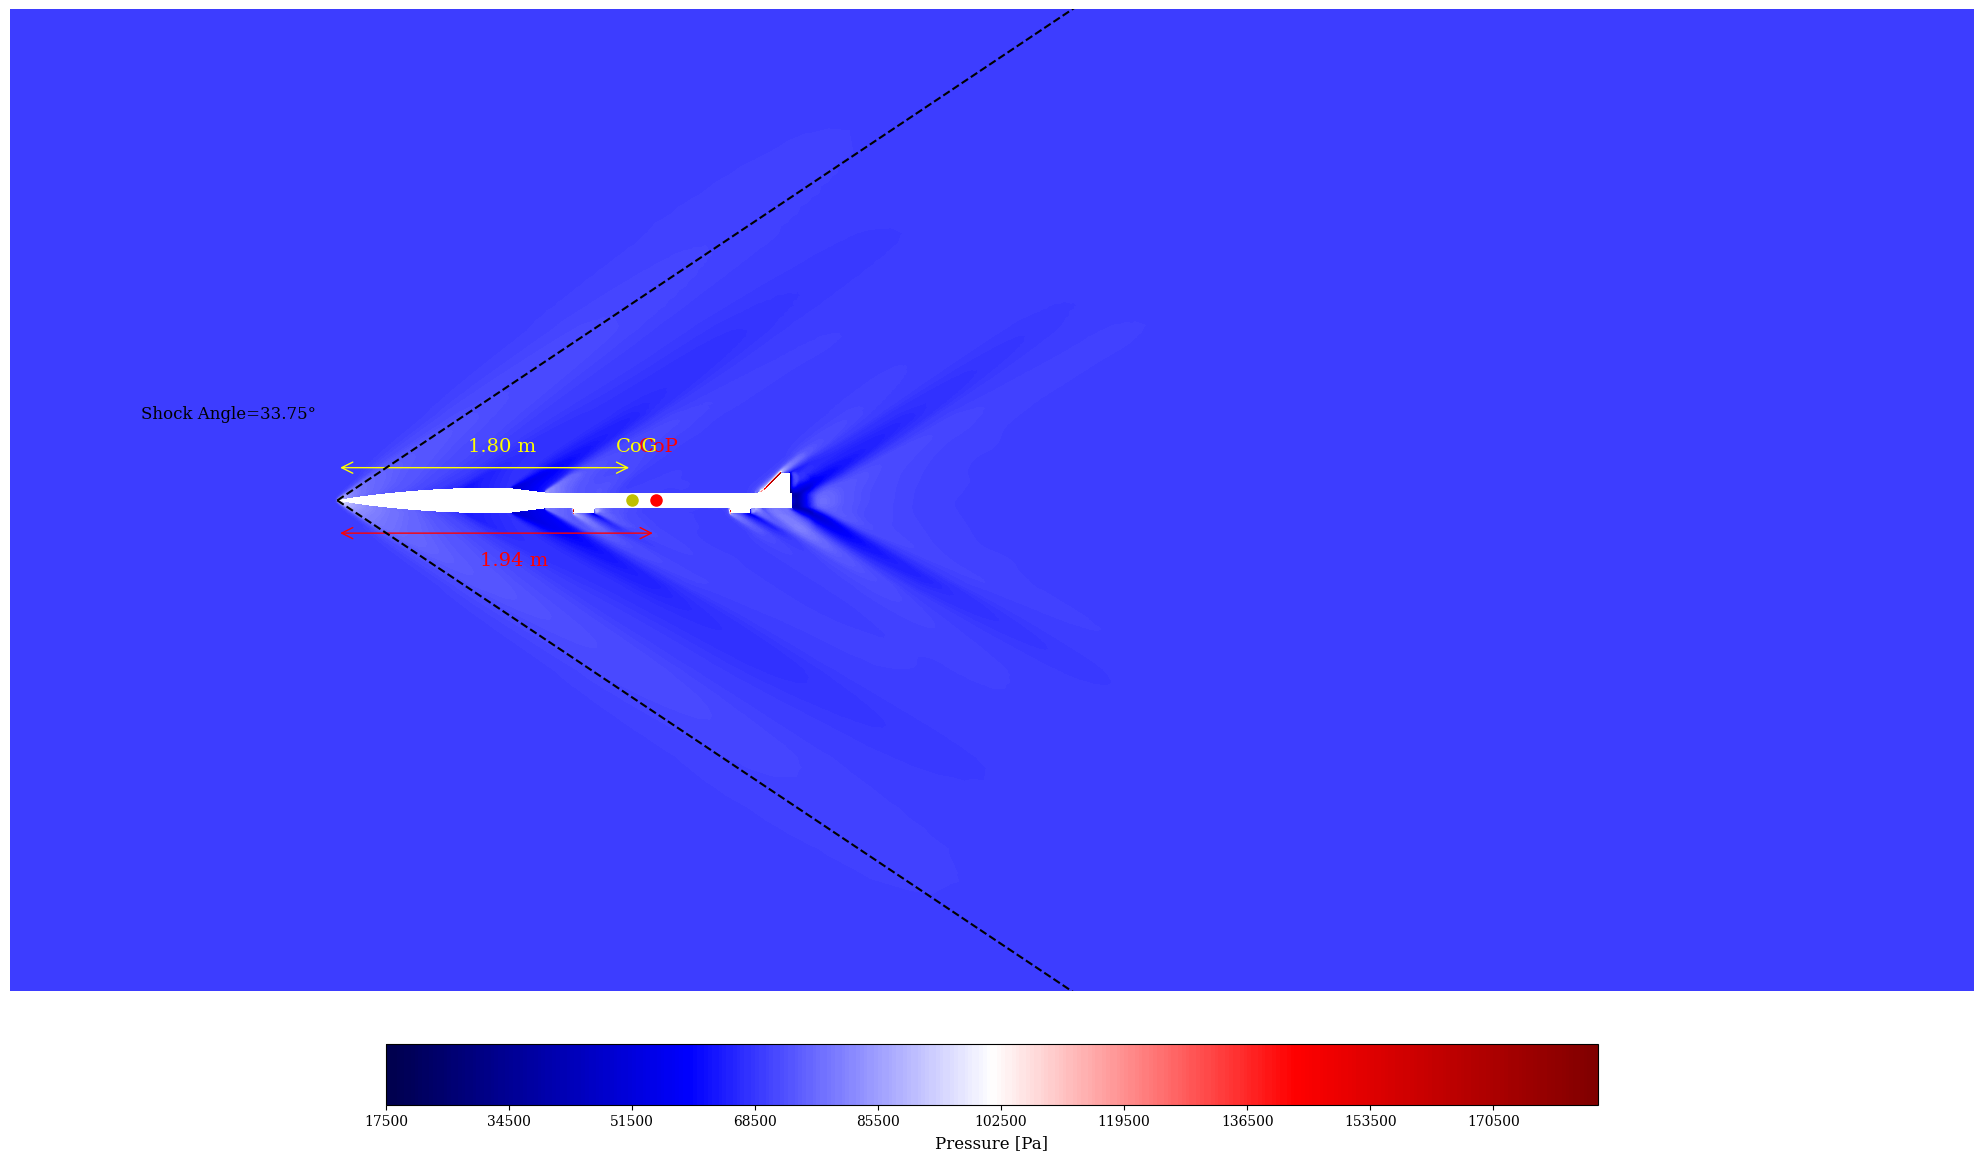

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


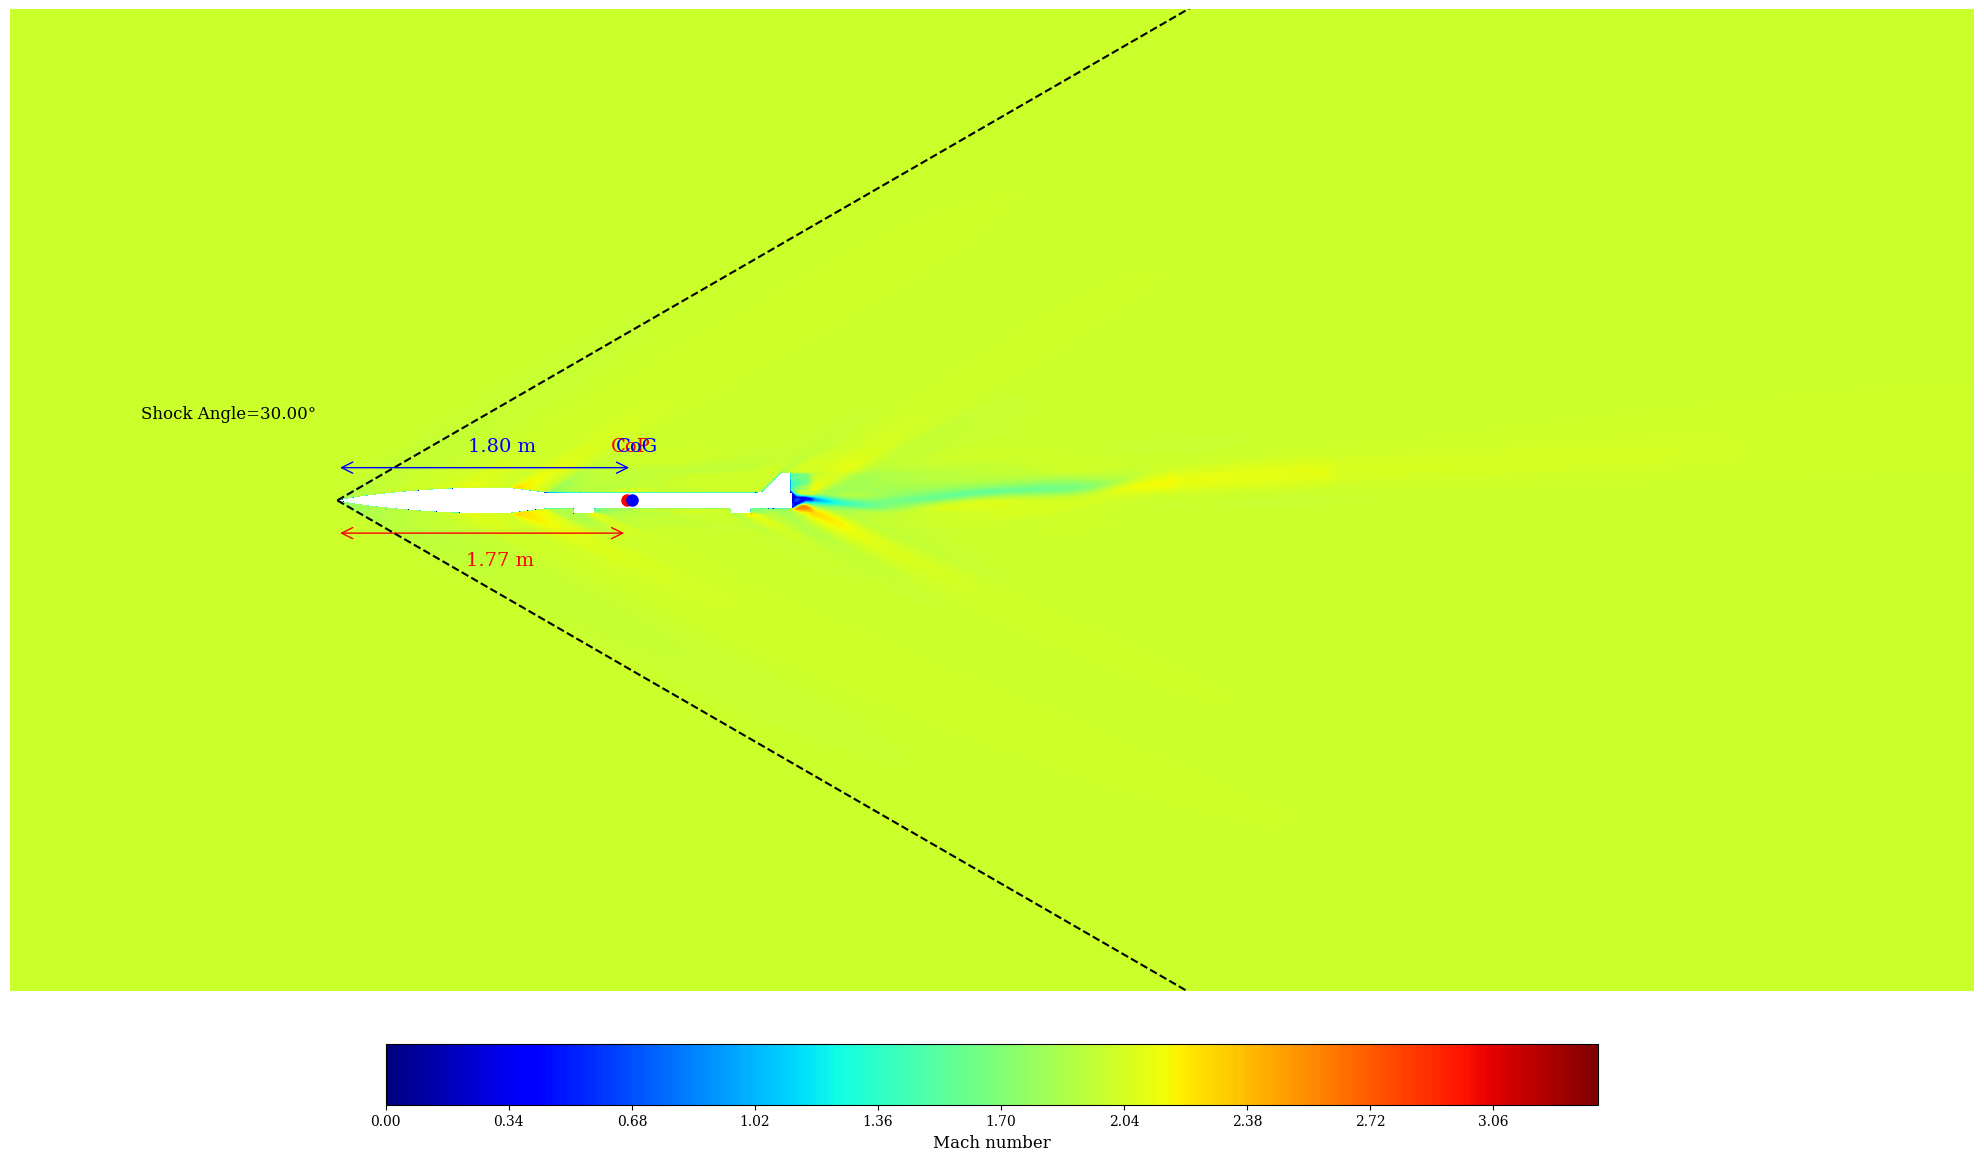

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


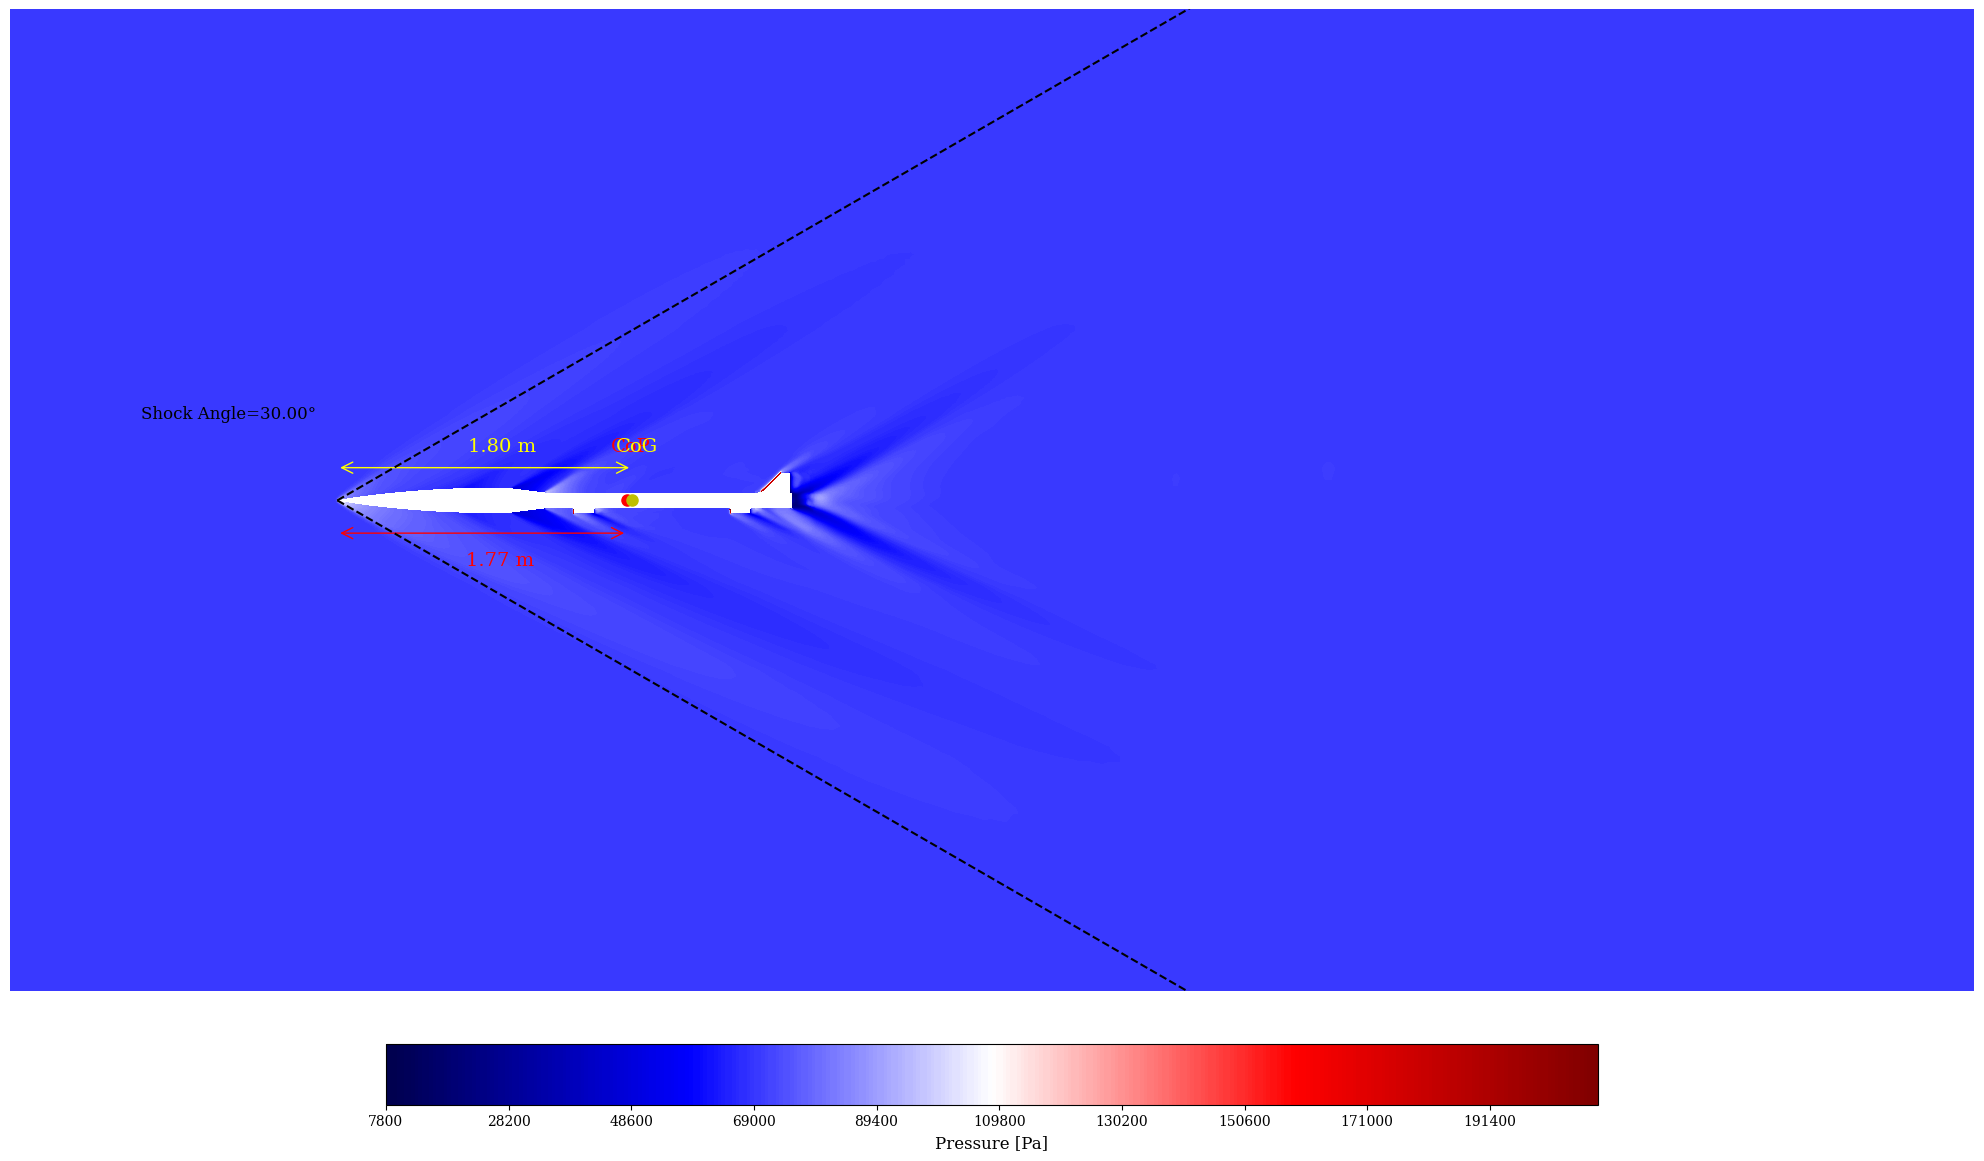

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


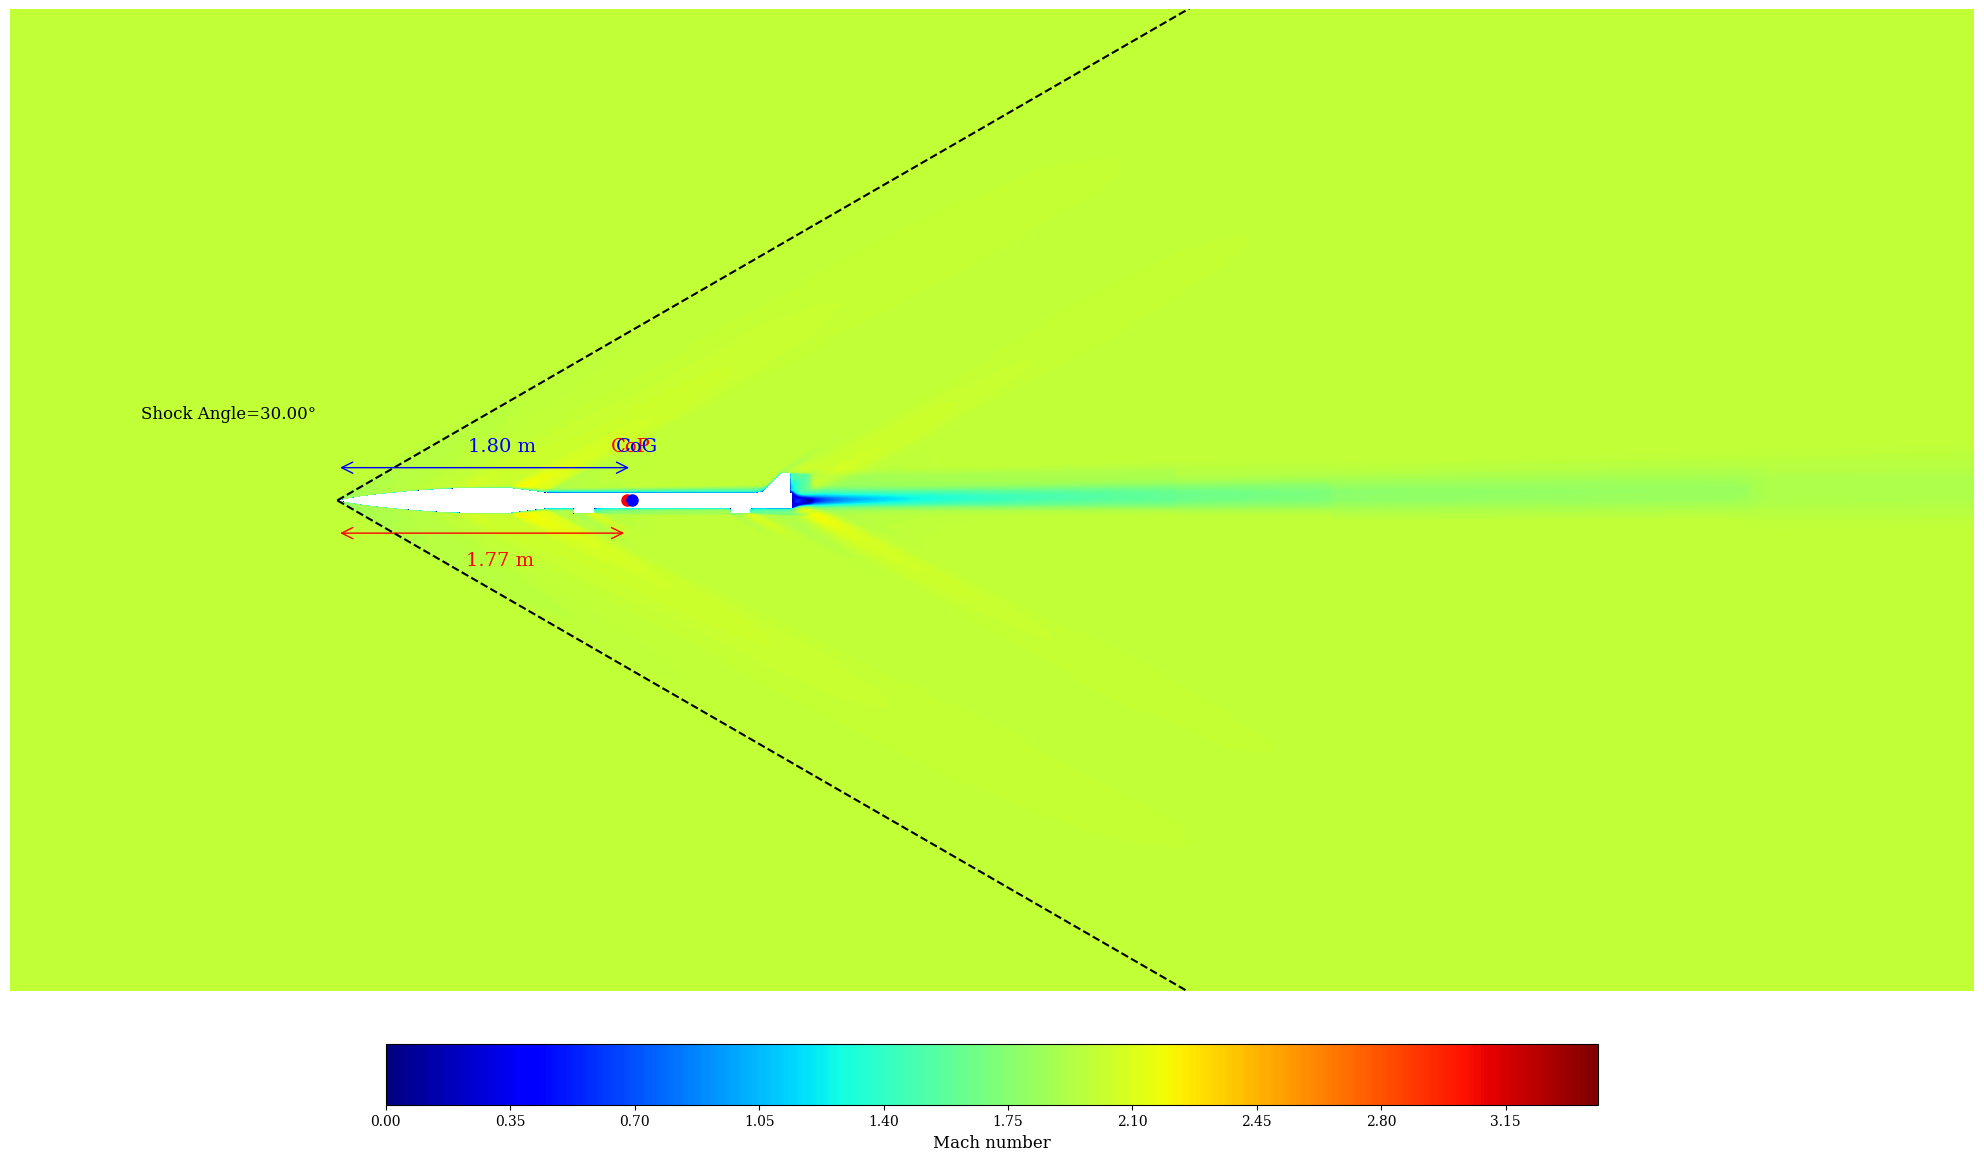

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


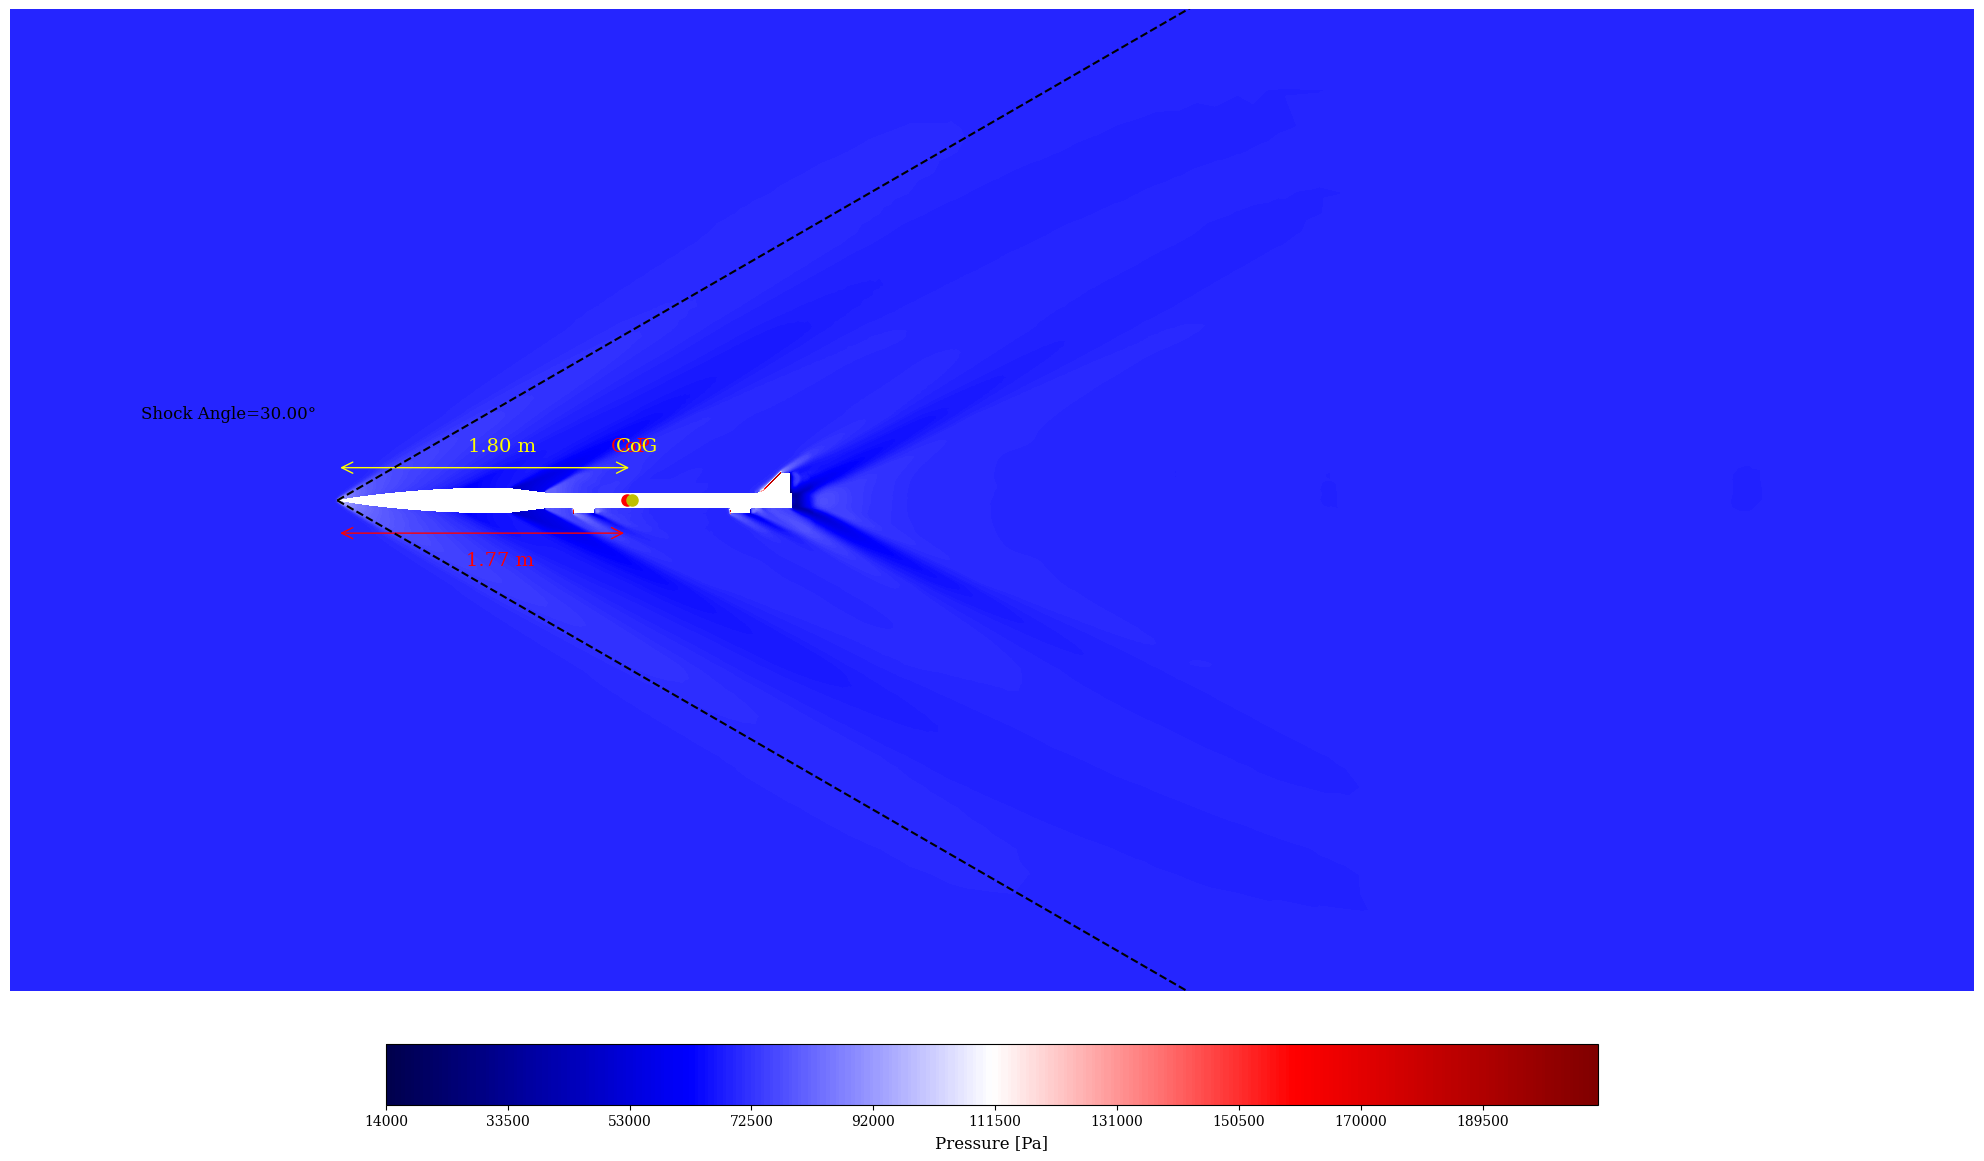

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


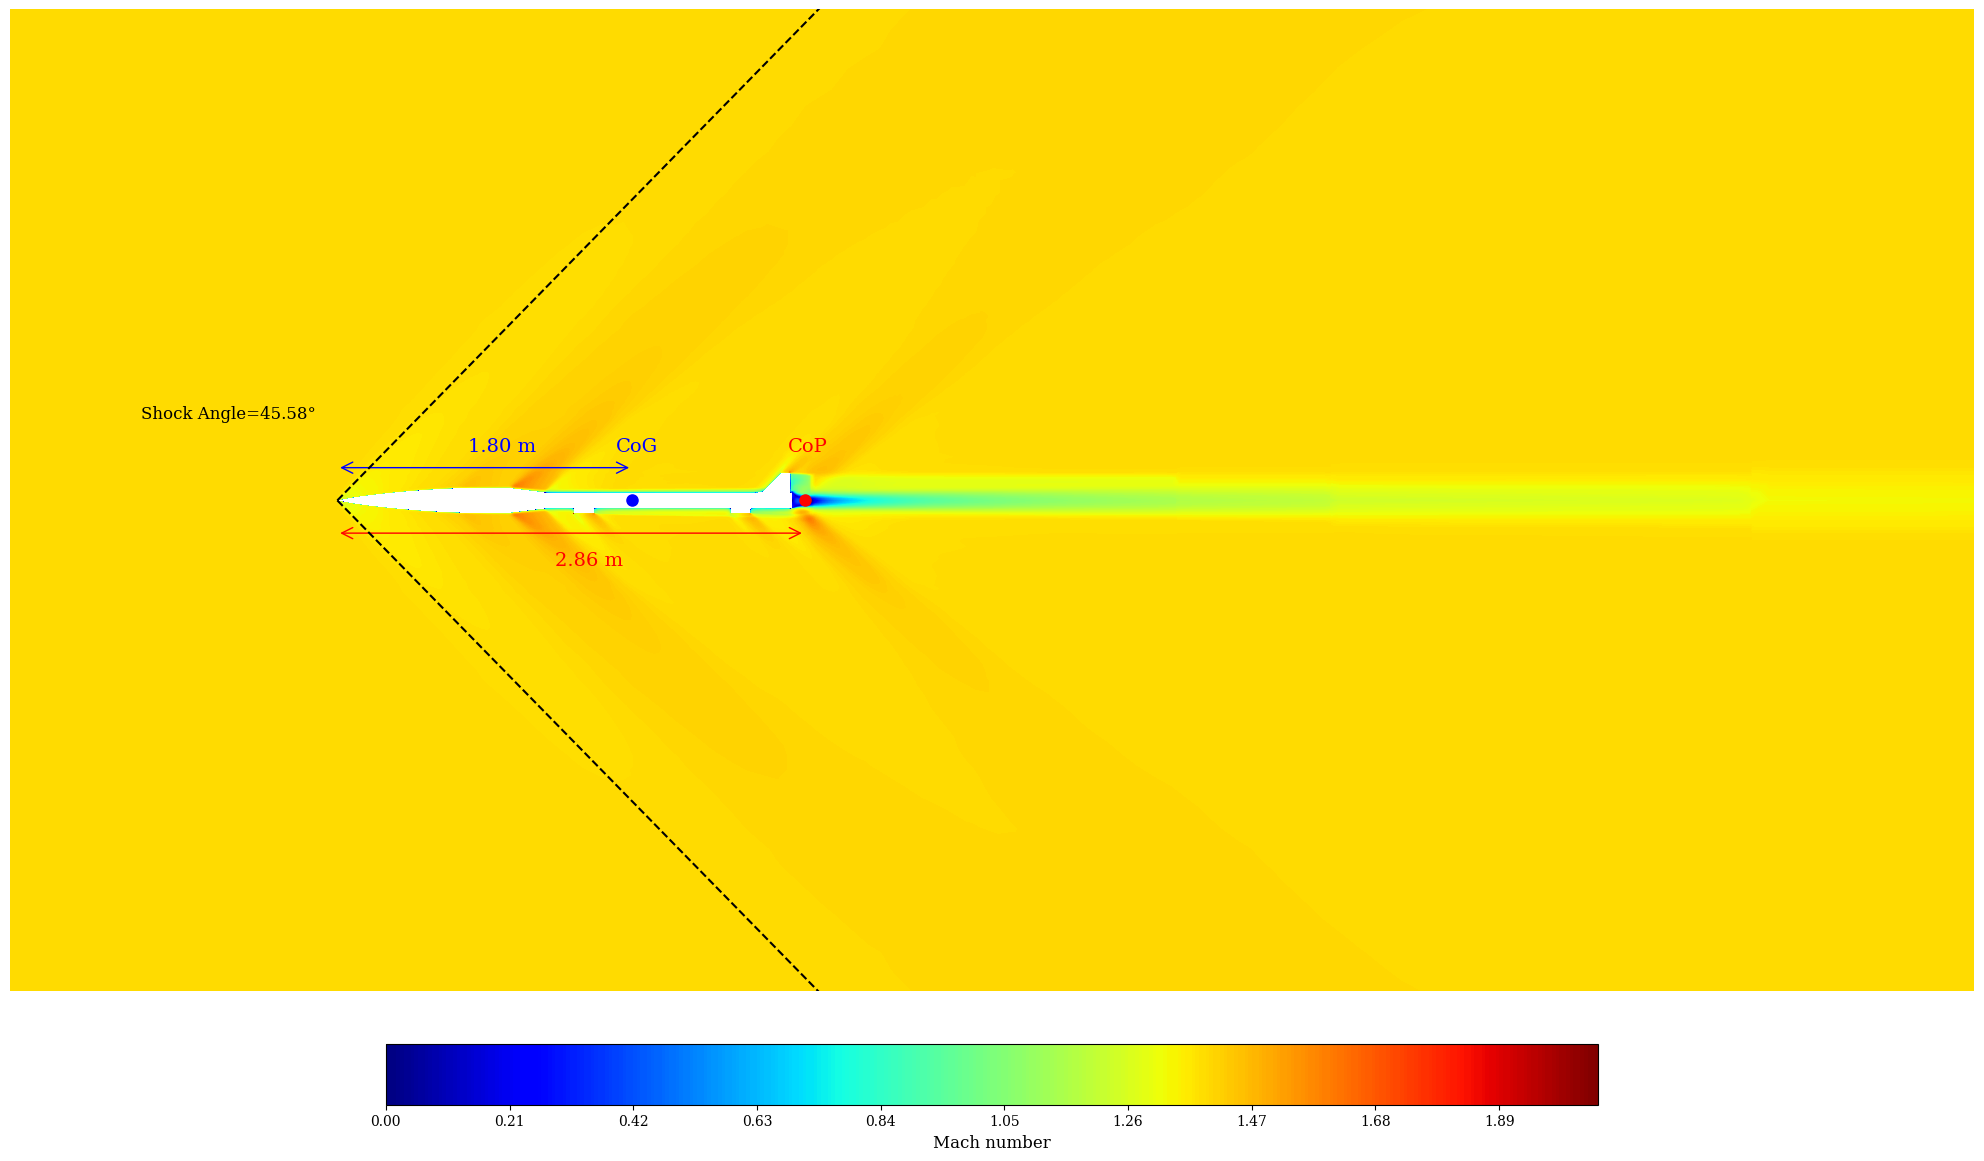

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


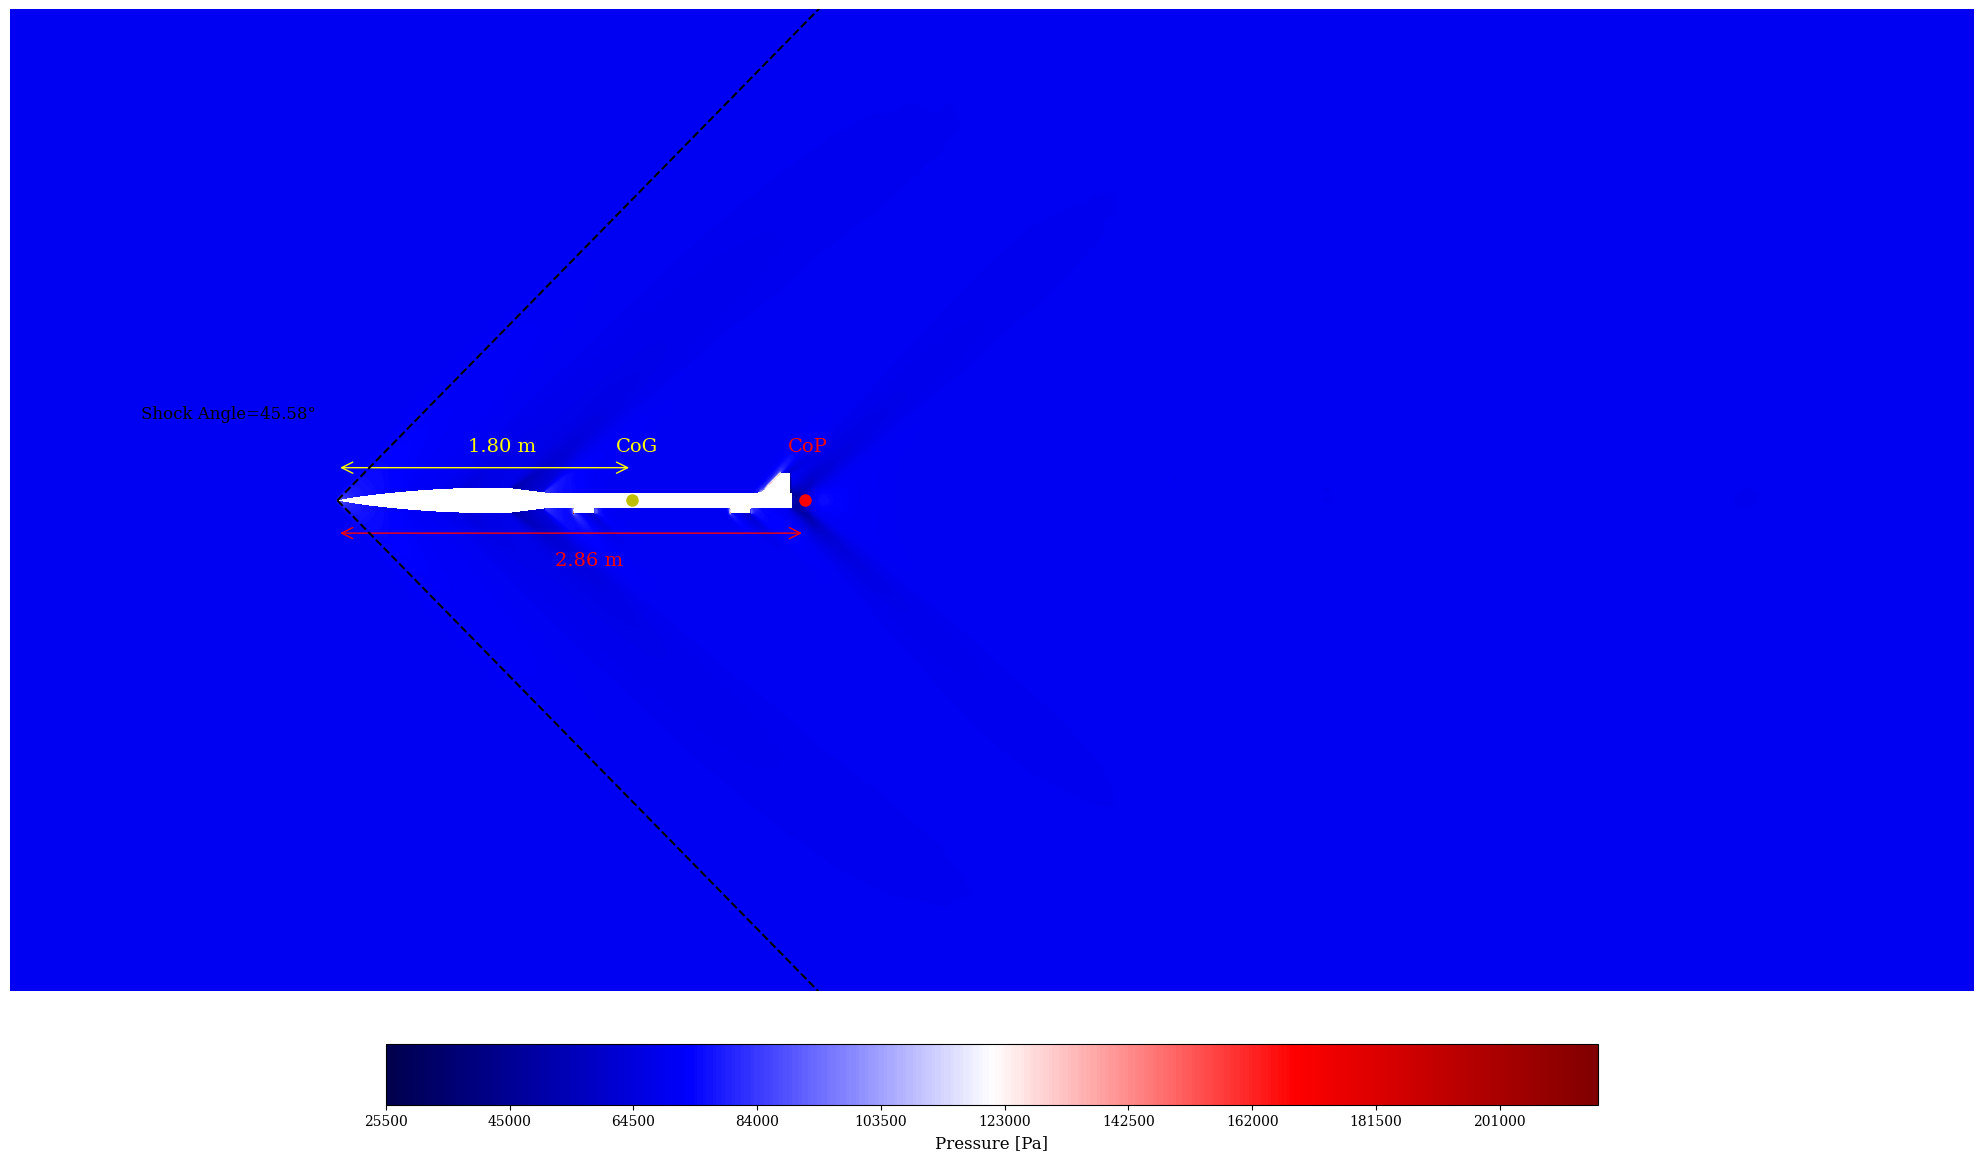

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


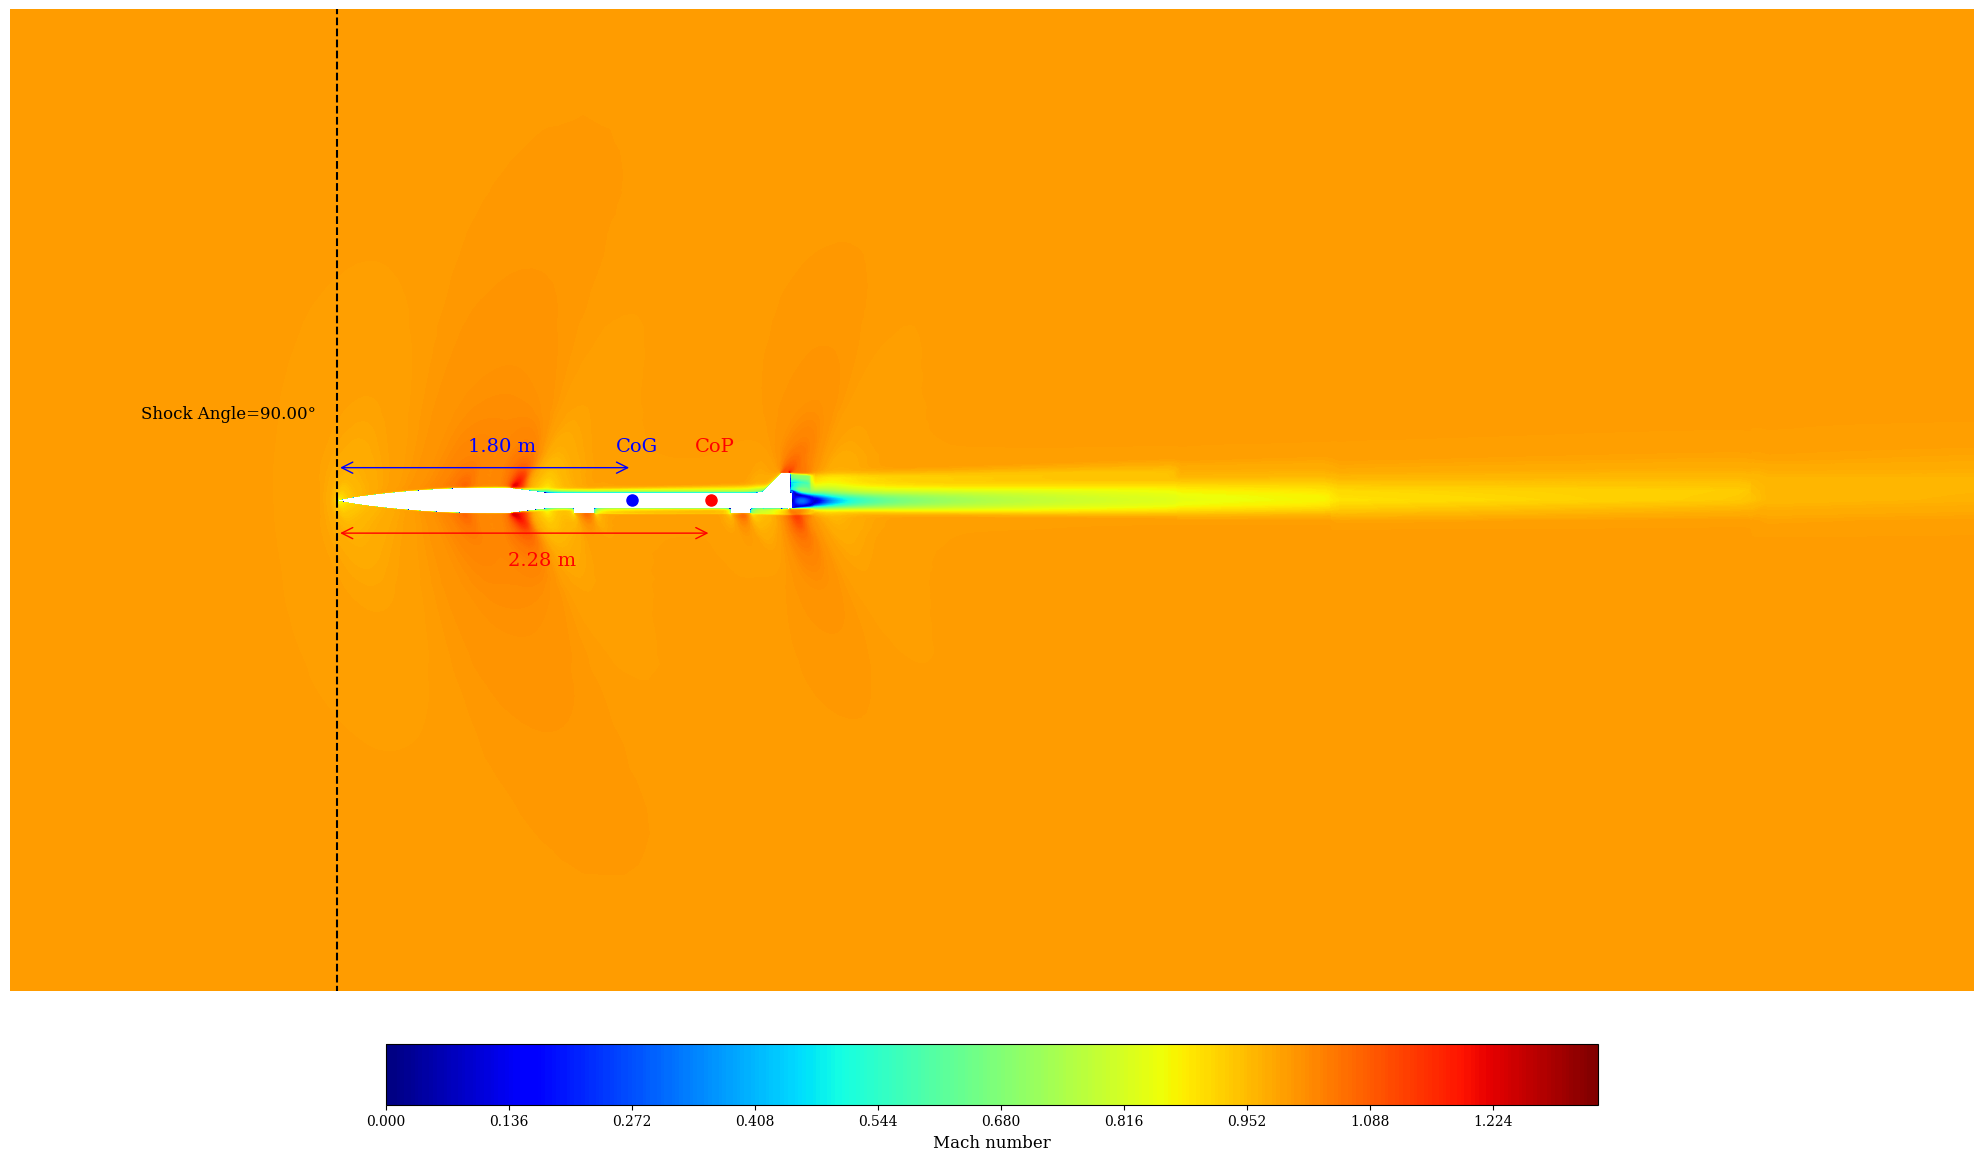

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


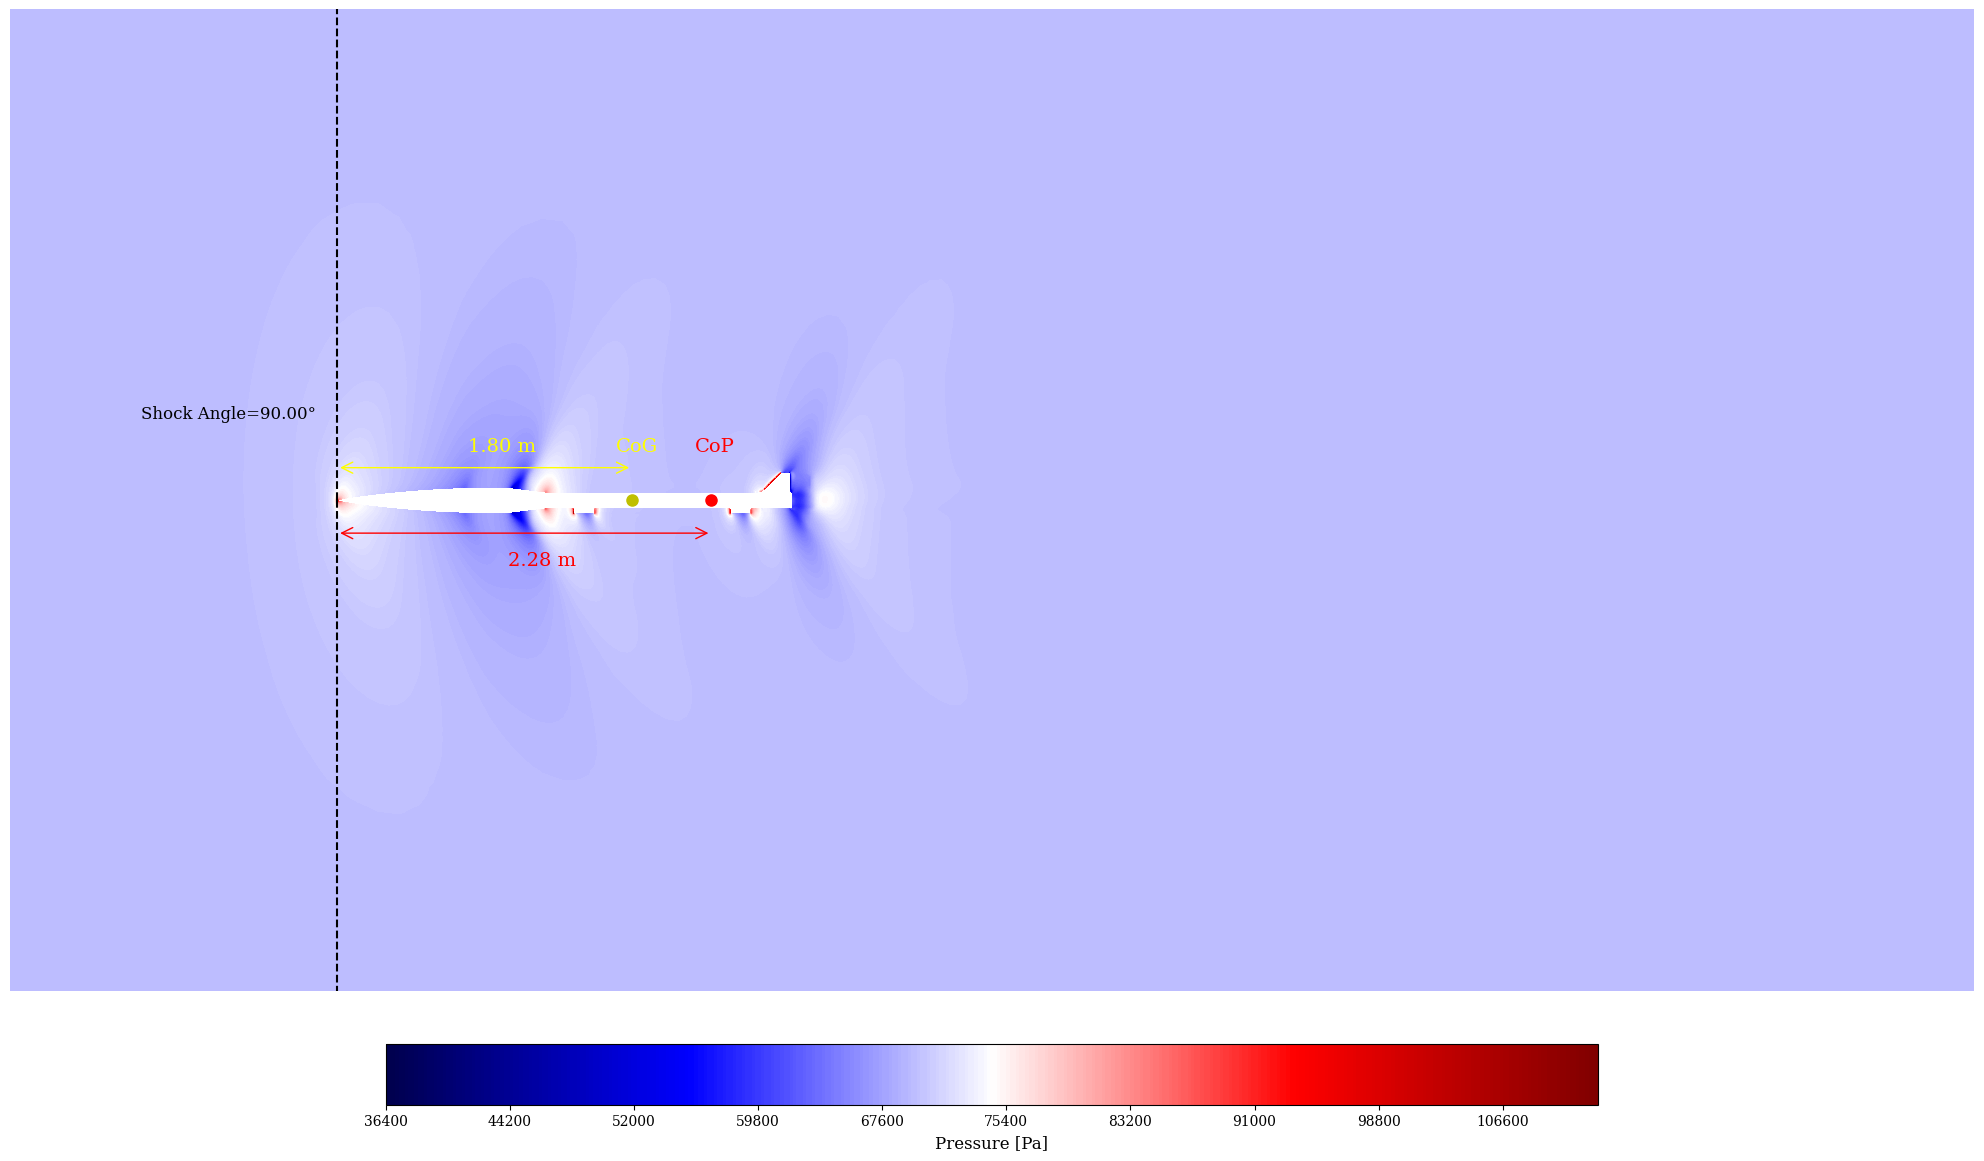

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


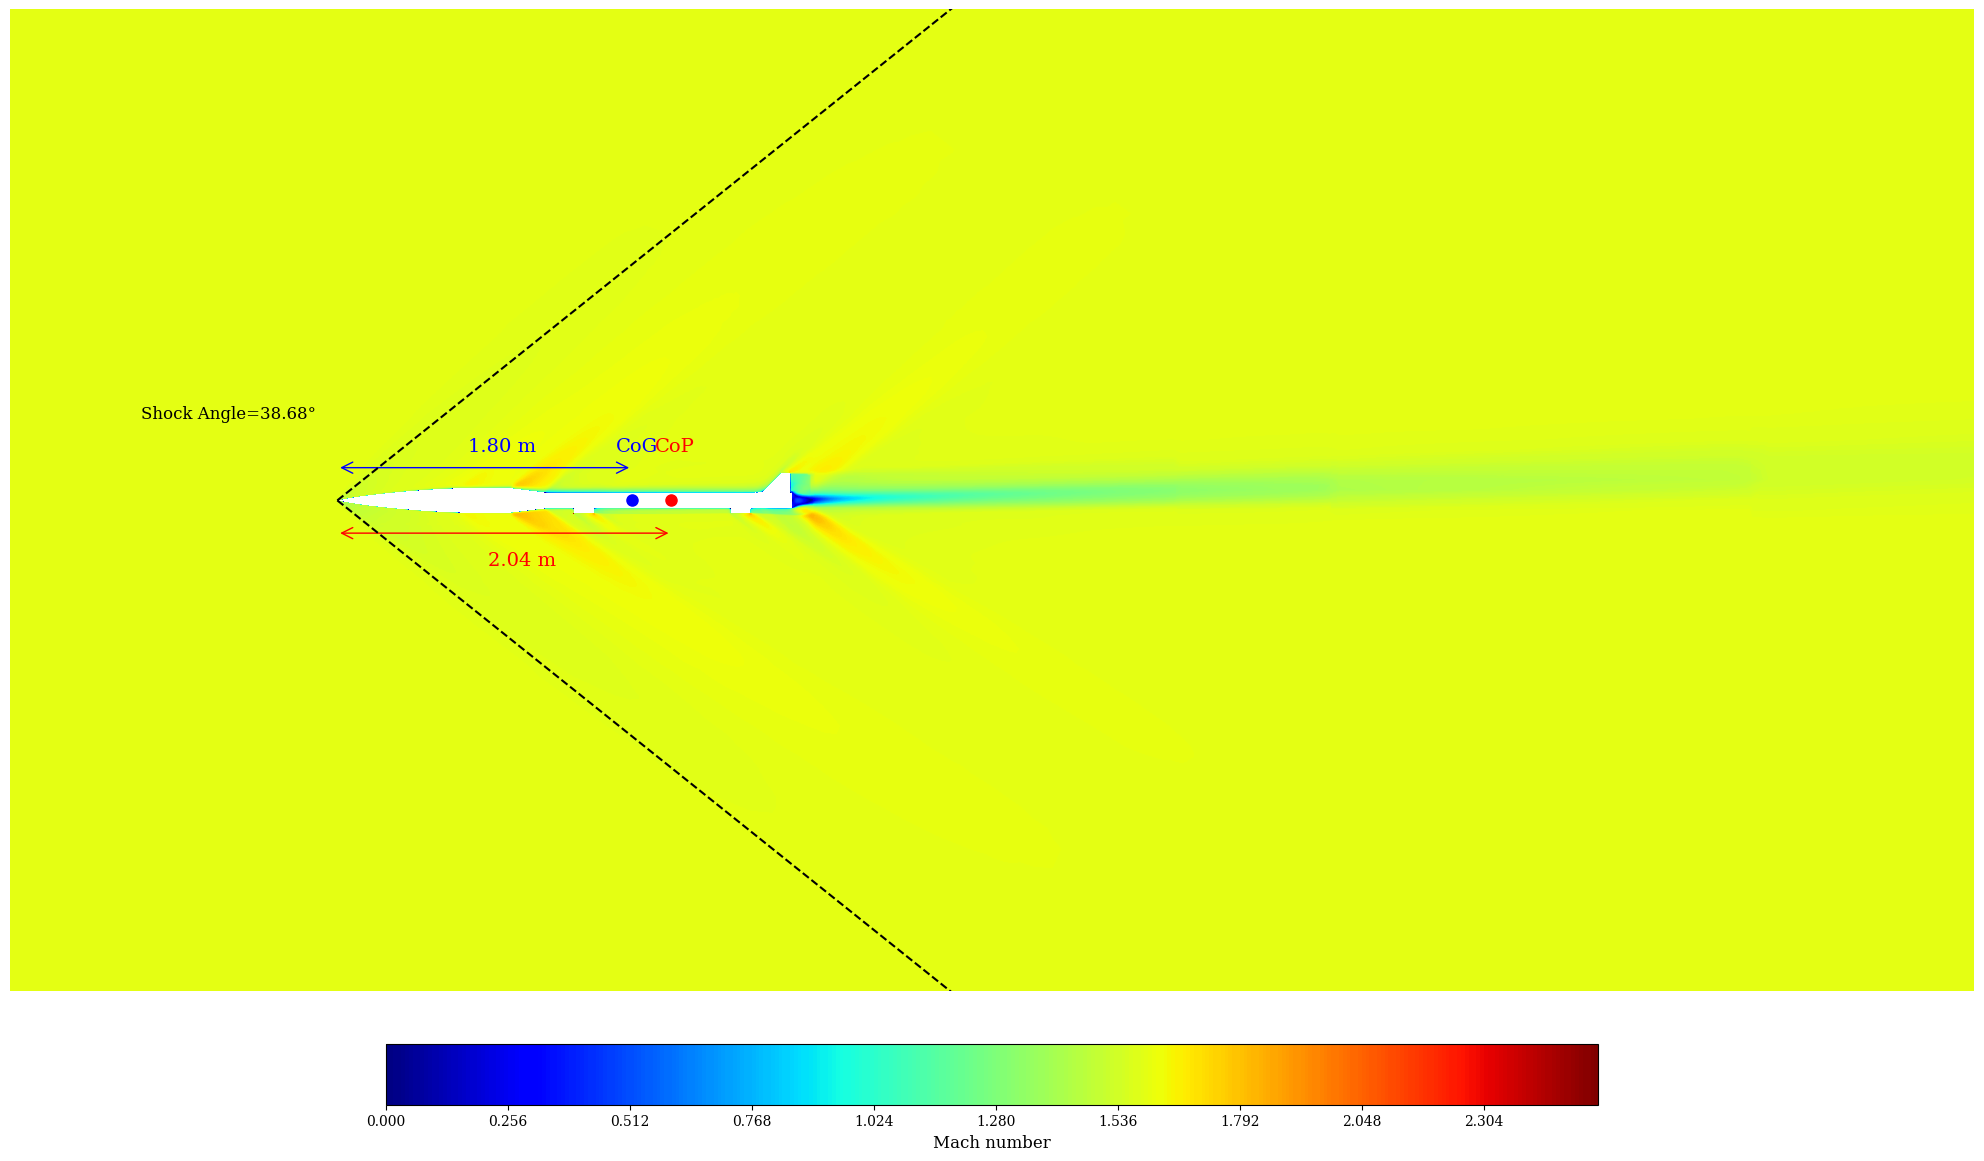

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


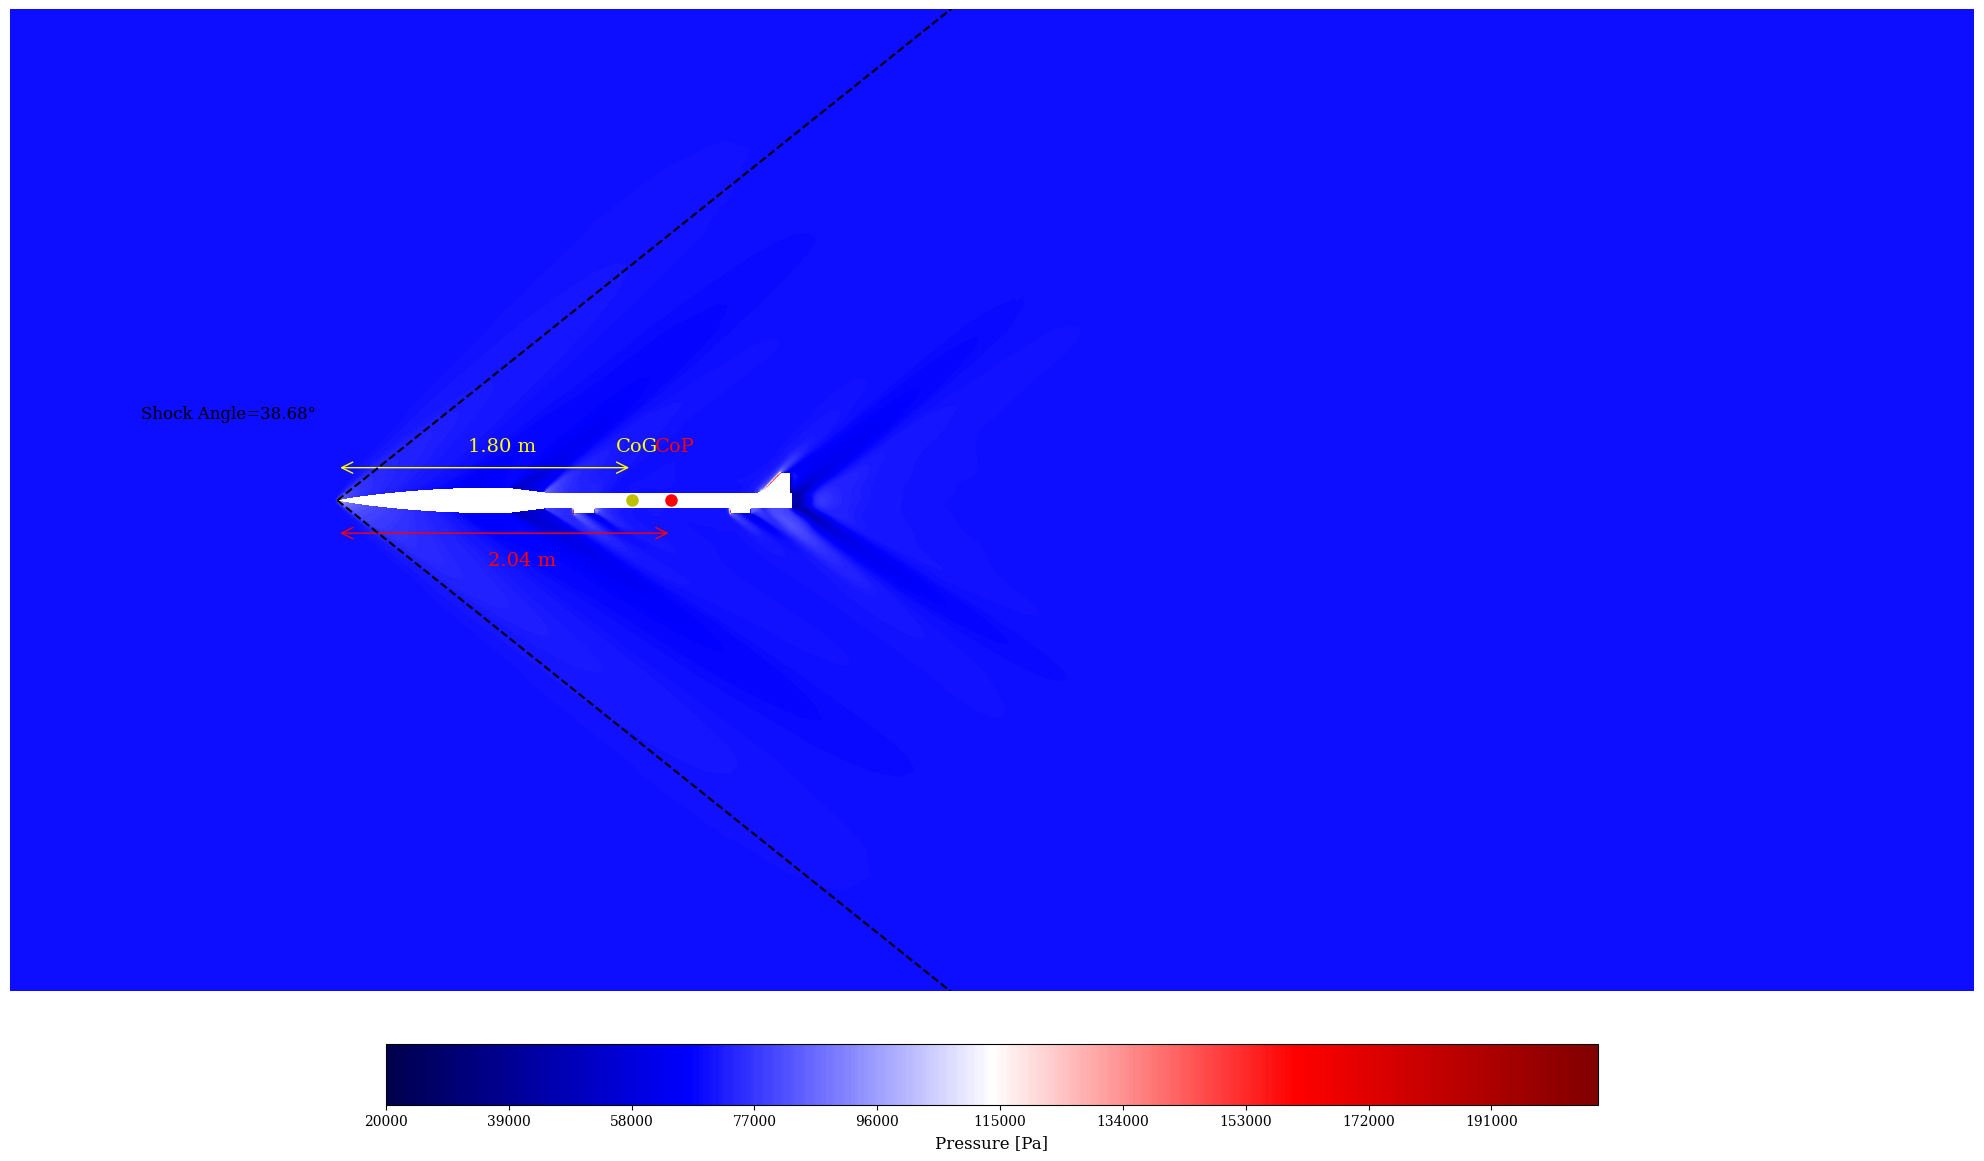

In [365]:


def get_latest_vtp(case_path, subfolder, filename):
    """Get the path to the latest timestep VTP file."""
    p = Path(case_path) / 'postProcessing' / subfolder
    if not p.exists():
        return None
    times = sorted([float(d.name) for d in p.iterdir() if d.is_dir()], reverse=True)
    for t in times:
        file = p / f"{t:.0f}" / filename
        if file.exists():
            return str(file)
    return None

base_dir = "Data/CollectedResults"
output_dir = "results/contours"
Path(output_dir + "/Ma").mkdir(parents=True, exist_ok=True)
Path(output_dir + "/Pressure").mkdir(parents=True, exist_ok=True)

for case in os.listdir(base_dir):
    if not case.startswith("AoA_"):
        continue
    case_path = os.path.join(base_dir, case)

    aoa_match = re.search(r"AoA_(\d+)p(\d+)", case)
    ma_match = re.search(r"Ma_(\d+)p(\d+)", case)

    if not aoa_match or not ma_match:
        continue

    aoa = f"{aoa_match.group(1)}.{aoa_match.group(2)}"
    ma = float(f"{ma_match.group(1)}.{ma_match.group(2)}")
    cg = 1.8  # adjust if needed

    # Load files
    slice_path = get_latest_vtp(case_path, "sliceCentreZ", "planeSlice.vtp")
    rocket_path = get_latest_vtp(case_path, "rocketVTK", "rocketWall.vtp")

    if not slice_path or not rocket_path:
        print(f"Missing files for case {case}")
        continue

    sliceZ = pv.read(slice_path)
    rocket = pv.read(rocket_path)

    # Plot and save Mach
    fig = plot_mach_contour_with_cp_cg(sliceZ, rocket, cmap='jet', Ma=ma, cg=cg)
    fig.savefig(f"{output_dir}/Ma/AoA{aoa.replace('.', '')}Ma{str(ma).replace('.', '')}.pdf", bbox_inches='tight')
    plt.close(fig)

    # Plot and save Pressure
    fig = plot_pressure_contour_with_cp_cg(sliceZ, rocket, cmap='seismic', Ma=ma, cg=cg)
    fig.savefig(f"{output_dir}/Pressure/AoA{aoa.replace('.', '')}Ma{str(ma).replace('.', '')}.pdf", bbox_inches='tight')
    plt.close(fig)


# CoP

In [212]:
mesh = pv.read("Data/CollectedResults2/AoA_0p0_Ma_1p2/postProcessing/rocketVTK/6200/rocketWall.vtp")

FileNotFoundError: File (/home/dara/Professional/projects/spaceConcordia/CR25/Data/CollectedResults2/AoA_0p0_Ma_1p2/postProcessing/rocketVTK/6200/rocketWall.vtp) not found

In [86]:
mesh

PolyData (0x7f5d08b10460)
  N Cells:    172662
  N Points:   177262
  N Strips:   0
  X Bounds:   4.930e-11, 2.782e+00
  Y Bounds:   -8.762e-02, 1.718e-01
  Z Bounds:   -1.498e-01, 1.498e-01
  N Arrays:   6

In [93]:
mesh = mesh.cell_data_from_point_data()
mesh

AttributeError: 'PolyData' object has no attribute 'cell_data_from_point_data'

In [ ]:
pressure

pyvista_ndarray([86127.96 , 86127.96 , 85711.51 , ..., 45983.273,
                 51049.99 , 44978.547], shape=(177262,), dtype=float32)

In [90]:
cell_centers = mesh.cell_centers()
cell_areas = mesh.compute_cell_sizes()['Area']

In [291]:
def compute_center_of_pressure(mesh, pressure_field='p', reference_point=None):
    """
    Compute the center of pressure for a rocket from CFD results.
    
    Parameters:
    -----------
    mesh : pyvista.PolyData
        The surface mesh with pressure data
    pressure_field : str
        Name of the pressure field in the mesh data
    reference_point : array-like, optional
        Reference point for moment calculation (default: nose of rocket)
    
    Returns:
    --------
    dict : Dictionary containing center of pressure results
    """
    
    # Check if pressure data exists
    if pressure_field not in mesh.array_names:
        print(f"Available arrays: {mesh.array_names}")
        raise ValueError(f"Pressure field '{pressure_field}' not found in mesh")
    
    # Get pressure data and check if it's point or cell data
    pressure = mesh[pressure_field]
    
    print(f"Pressure data shape: {pressure.shape}")
    print(f"Number of cells: {mesh.n_cells}")
    print(f"Number of points: {mesh.n_points}")
    
    # Compute cell centers and areas
    cell_centers = mesh.cell_centers()
    cell_areas = mesh.compute_cell_sizes()['Area']
    
    # Compute surface normals (pointing outward from rocket)
    mesh_with_normals = mesh.compute_normals(cell_normals=True, point_normals=False)
    normals = mesh_with_normals['Normals']
    
    # Handle pressure data - convert to cell data if it's point data
    if len(pressure) == mesh.n_points:
        print("Converting point data to cell data...")
        # Interpolate point data to cell centers
        mesh_with_pressure = mesh.copy()
        mesh_with_pressure[pressure_field] = pressure
        cell_mesh = mesh_with_pressure.cell_data_to_point_data().point_data_to_cell_data()
        pressure_cells = cell_mesh[pressure_field]
    elif len(pressure) == mesh.n_cells:
        print("Using cell data directly...")
        pressure_cells = pressure
    else:
        raise ValueError(f"Pressure data size ({len(pressure)}) doesn't match cells ({mesh.n_cells}) or points ({mesh.n_points})")
    
    # Set reference point (typically nose of rocket)
    if reference_point is None:
        # Use the point with minimum x-coordinate (nose)
        reference_point = np.array([mesh.bounds[0], 0, 0])
    
    # Compute pressure forces on each cell
    # Force = pressure * area * normal (pointing into the fluid)
    pressure_forces = pressure_cells[:, np.newaxis] * cell_areas[:, np.newaxis] * (-normals)
    
    # Total force components
    total_force = np.sum(pressure_forces, axis=0)
    
    # Compute moments about reference point
    # Get cell center coordinates
    centers = cell_centers.points
    
    # Moment arm from reference point to each cell center
    moment_arms = centers - reference_point
    
    # Compute moments for each cell
    moments = np.cross(moment_arms, pressure_forces)
    
    # Total moment
    total_moment = np.sum(moments, axis=0)
    
    # Compute center of pressure
    # For a rocket, we're primarily interested in the longitudinal position (x-direction)
    # CP_x = reference_x + M_z / F_y (for pitching moment)
    # CP_y = reference_y - M_z / F_x (for yawing moment)
    
    results = {
        'total_force': total_force,
        'total_moment': total_moment,
        'reference_point': reference_point,
        #'pressure_forces': pressure_forces,
        #'cell_centers': centers,
        #'cell_areas': cell_areas,
        #'pressure': pressure_cells
    }
    
    # Calculate center of pressure coordinates
    if abs(total_force[1]) > 1e-10:  # F_y component
        cp_x = reference_point[0] + total_moment[2] / total_force[1]
    else:
        cp_x = reference_point[0]
    
    if abs(total_force[0]) > 1e-10:  # F_x component
        cp_y = reference_point[1] - total_moment[2] / total_force[0]
    else:
        cp_y = reference_point[1]
    
    results['center_of_pressure'] = np.array([cp_x, cp_y, reference_point[2]])
    
    return results

In [292]:
compute_center_of_pressure(rocket)

Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...


{'total_force': pyvista_ndarray([-449.65922669, -379.11567558,    3.43159801]),
 'total_moment': array([-4.52162882e-01, -7.84596035e+00, -8.49049682e+02]),
 'reference_point': array([4.94354072e-11, 0.00000000e+00, 0.00000000e+00]),
 'center_of_pressure': array([ 2.23955309, -1.88820696,  0.        ])}

In [110]:

def visualize_pressure_distribution(mesh, pressure_field='p', results=None):
    """
    Visualize the pressure distribution and center of pressure.
    """
    # Create plotter
    plotter = pv.Plotter(window_size=(1200, 800))
    
    # Add mesh with pressure coloring (make it semi-transparent to see points inside)
    plotter.add_mesh(mesh, scalars=pressure_field, cmap='RdBu_r', 
                     scalar_bar_args={'title': 'Pressure'}, 
                     opacity=0.8)
    
    # Define center of gravity
    cg_x = 1.7114  # Given center of gravity position
    center_of_gravity = np.array([cg_x, 0, 0])
    
    # Add center of gravity
    plotter.add_mesh(pv.Sphere(radius=0.025, center=center_of_gravity), 
                     color='blue', label='Center of Gravity')
    
    # Add center of pressure if available
    if results and 'center_of_pressure' in results:
        cp = results['center_of_pressure']
        plotter.add_mesh(pv.Sphere(radius=0.02, center=cp), color='red', 
                         label='Center of Pressure')
        
        # Add reference point
        ref_point = results['reference_point']
        plotter.add_mesh(pv.Sphere(radius=0.015, center=ref_point), color='green',
                         label='Reference Point')
        
        # Add line connecting CG and CP for stability visualization
        line_points = np.array([center_of_gravity, cp])
        line = pv.Line(line_points[0], line_points[1])
        plotter.add_mesh(line, color='orange', line_width=3, 
                         label='CG-CP Line')
        
        # Print stability information
        cp_x = cp[0]
        stability_margin = cp_x - cg_x
        print(f"Center of Gravity: {cg_x:.4f} m")
        print(f"Center of Pressure: {cp_x:.4f} m")
        print(f"Static Margin: {stability_margin:.4f} m")
        if stability_margin > 0:
            print("Configuration: STABLE (CP behind CG)")
        else:
            print("Configuration: UNSTABLE (CP ahead of CG)")
    
    # Set camera view for better visualization
    plotter.camera_position = 'xy'
    plotter.add_legend()
    plotter.show_axes()
    
    # Add title
    #plotter.add_title("Rocket Pressure Distribution & Center of Pressure Analysis")
    
    return plotter

/home/dara/Professional/projects/spaceConcordia/CR25/.venv/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


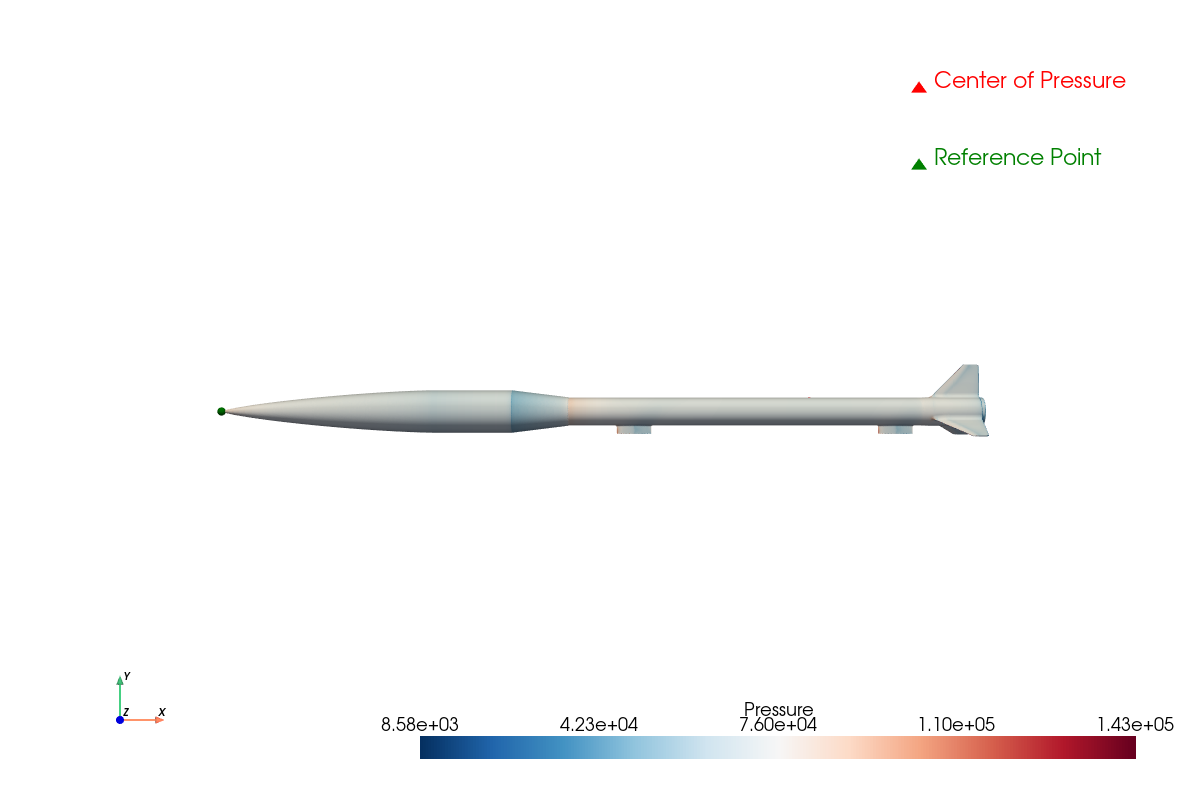

In [114]:
a = visualize_pressure_distribution(mesh, pressure_field='p', results=results)
a.show()


In [149]:
import os
import glob
import pandas as pd
import numpy as np
import pyvista as pv
import re
from pathlib import Path

def parse_case_name(case_name):
    """
    Parse case name to extract AoA and Mach number
    Example: AoA_0p0_Ma_0p8 -> AoA=0.0, Ma=0.8
    """
    # Extract AoA
    aoa_match = re.search(r'AoA_([0-9]+p[0-9]+)', case_name)
    if aoa_match:
        aoa_str = aoa_match.group(1).replace('p', '.')
        aoa = float(aoa_str)
    else:
        aoa = None
    
    # Extract Mach number
    ma_match = re.search(r'Ma_([0-9]+p[0-9]+)', case_name)
    if ma_match:
        ma_str = ma_match.group(1).replace('p', '.')
        ma = float(ma_str)
    else:
        ma = None
    
    return aoa, ma

def find_latest_time_directory(base_path):
    """
    Find the directory with the highest numerical name (latest time)
    """
    time_dirs = []
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            try:
                time_val = float(item)
                time_dirs.append((time_val, item))
            except ValueError:
                continue
    
    if time_dirs:
        # Return the directory name with the highest time value
        latest_time = max(time_dirs, key=lambda x: x[0])
        return latest_time[1], latest_time[0]
    else:
        return None, None

def load_mesh_from_case(case_path):
    """
    Load the rocket mesh from the case directory
    """
    vtk_path = os.path.join(case_path, "postProcessing", "rocketVTK")
    
    if not os.path.exists(vtk_path):
        print(f"VTK path not found: {vtk_path}")
        return None, None
    
    # Find latest time directory
    time_dir, time_value = find_latest_time_directory(vtk_path)
    if time_dir is None:
        print(f"No time directories found in: {vtk_path}")
        return None, None
    
    # Load the mesh
    mesh_file = os.path.join(vtk_path, time_dir, "rocketWall.vtp")
    if not os.path.exists(mesh_file):
        print(f"Mesh file not found: {mesh_file}")
        return None, None
    
    try:
        mesh = pv.read(mesh_file)
        return mesh, time_value
    except Exception as e:
        print(f"Error loading mesh from {mesh_file}: {e}")
        return None, None

def compute_center_of_pressure_simple(mesh, pressure_field='p', reference_point=None):
    """
    Simplified center of pressure calculation from mesh
    """
    if pressure_field not in mesh.array_names:
        print(f"Pressure field '{pressure_field}' not found. Available: {mesh.array_names}")
        return None
    
    # Get pressure data
    pressure = mesh[pressure_field]
    
    # Compute cell centers and areas
    cell_centers = mesh.cell_centers()
    cell_areas = mesh.compute_cell_sizes()['Area']
    
    # Compute surface normals
    mesh_with_normals = mesh.compute_normals(cell_normals=True, point_normals=False)
    normals = mesh_with_normals['Normals']
    
    # Handle pressure data conversion if needed
    if len(pressure) == mesh.n_points:
        # Convert point data to cell data
        mesh_temp = mesh.copy()
        mesh_temp[pressure_field] = pressure
        cell_mesh = mesh_temp.cell_data_to_point_data().point_data_to_cell_data()
        pressure_cells = cell_mesh[pressure_field]
    elif len(pressure) == mesh.n_cells:
        pressure_cells = pressure
    else:
        print(f"Pressure data size mismatch: {len(pressure)} vs cells:{mesh.n_cells} points:{mesh.n_points}")
        return None
    
    # Set reference point
    if reference_point is None:
        reference_point = np.array([mesh.bounds[0], 0, 0])  # Nose of rocket
    
    # Compute pressure forces
    pressure_forces = pressure_cells[:, np.newaxis] * cell_areas[:, np.newaxis] * (normals)
    
    # Total force
    total_force = np.sum(pressure_forces, axis=0)
    
    # Compute moments about reference point
    centers = cell_centers.points
    moment_arms = centers - reference_point
    moments = np.cross(moment_arms, pressure_forces)
    total_moment = np.sum(moments, axis=0)
    
    # Calculate center of pressure using component method
    cp = np.zeros(3)
    
    # X-component (longitudinal position)
    if abs(total_force[1]) > 1e-10:  # F_y component
        cp[0] = reference_point[0] + total_moment[2] / total_force[1]
    else:
        cp[0] = reference_point[0]
    
    # Y-component (vertical position)
    if abs(total_force[0]) > 1e-10:  # F_x component
        cp[1] = reference_point[1] - total_moment[2] / total_force[0]
    else:
        cp[1] = reference_point[1]
        
    # Z-component (lateral position)
    if abs(total_force[0]) > 1e-10:  # F_x component
        cp[2] = reference_point[2] + total_moment[1] / total_force[0]
    else:
        cp[2] = reference_point[2]
    
    return {
        'center_of_pressure': cp,
        'total_force': total_force,
        'total_moment': total_moment,
        'reference_point': reference_point
    }

def load_force_coefficients(case_path):
    """
    Load force coefficients from coefficient.dat file using the provided load_dat function
    
    Parameters:
    -----------
    case_path : str
        Path to the case directory
    load_dat : function
        Your existing function to load .dat files
    """
    coeffs_path = os.path.join(case_path, "postProcessing", "forceCoeffs")
    
    if not os.path.exists(coeffs_path):
        print(f"Force coefficients path not found: {coeffs_path}")
        return None
    
    # Find latest time directory
    time_dir, _ = find_latest_time_directory(coeffs_path)
    if time_dir is None:
        print(f"No time directories found in: {coeffs_path}")
        return None
    
    coeffs_file = os.path.join(coeffs_path, time_dir, "coefficient.dat")
    if not os.path.exists(coeffs_file):
        print(f"Coefficient file not found: {coeffs_file}")
        return None
    
    try:
        # Use your load_dat function
        df = load_dat(coeffs_file)
        
        if df is None or df.empty:
            print(f"load_dat returned empty DataFrame for {coeffs_file}")
            return None
        
        # Get the final row (converged values)
        final_row = df.iloc[-1]
        
        # Extract coefficients - adjust column names as needed
        # Common names: Cd, Cl, CmPitch, Cs, CmRoll, CmYaw
        coeffs = {}
        
        # Try different possible column names
        cd_cols = ['Cd', 'cd', 'CD', 'drag']
        cl_cols = ['Cl', 'cl', 'CL', 'lift']
        cm_cols = ['CmPitch', 'Cm', 'cm', 'CMpitch', 'moment']
        
        for col in cd_cols:
            if col in df.columns:
                coeffs['Cd'] = final_row[col]
                break
        else:
            coeffs['Cd'] = None
            
        for col in cl_cols:
            if col in df.columns:
                coeffs['Cl'] = final_row[col]
                break
        else:
            coeffs['Cl'] = None
            
        for col in cm_cols:
            if col in df.columns:
                coeffs['CmPitch'] = final_row[col]
                break
        else:
            coeffs['CmPitch'] = None
        
        # Also return the time and all available columns for debugging
        coeffs['time'] = final_row.get('Time', final_row.iloc[0])
        coeffs['available_columns'] = df.columns.tolist()
        
        return coeffs
        
    except Exception as e:
        print(f"Error loading coefficients from {coeffs_file}: {e}")
        return None

def analyze_all_cases(base_directory):
    """
    Analyze all cases in the base directory
    """
    results = []
    
    # Find all case directories
    case_pattern = os.path.join(base_directory, "AoA_*_Ma_*")
    case_dirs = glob.glob(case_pattern)
    
    if not case_dirs:
        print(f"No case directories found matching pattern: {case_pattern}")
        return pd.DataFrame()
    
    print(f"Found {len(case_dirs)} cases to analyze...")
    
    for case_dir in sorted(case_dirs):
        case_name = os.path.basename(case_dir)
        print(f"\nAnalyzing case: {case_name}")
        
        # Parse AoA and Mach number
        aoa, ma = parse_case_name(case_name)
        
        # Load mesh and get iteration number
        mesh, iterations = load_mesh_from_case(case_dir)
        if mesh is None:
            print(f"Skipping {case_name} - mesh loading failed")
            continue
        
        # Compute center of pressure
        cop_results = compute_center_of_pressure_simple(mesh)
        if cop_results is None:
            print(f"Skipping {case_name} - CoP calculation failed")
            continue
        
        # Load force coefficients
        coeffs = load_force_coefficients(case_dir)
        if coeffs is None:
            print(f"Warning: Could not load coefficients for {case_name}")
            coeffs = {'Cd': None, 'Cl': None, 'CmPitch': None}
        
        # Compile results
        result = {
            'AoA': aoa,
            'Ma': ma,
            'iterations': iterations,
            'CopX': cop_results['center_of_pressure'][0],
            'CopY': cop_results['center_of_pressure'][1],
            'CopZ': cop_results['center_of_pressure'][2],
            'Force_X': cop_results['total_force'][0],
            'Force_Y': cop_results['total_force'][1],
            'Force_Z': cop_results['total_force'][2],
            'Moment_X': cop_results['total_moment'][0],
            'Moment_Y': cop_results['total_moment'][1],
            'Moment_Z': cop_results['total_moment'][2],
            'Cd': coeffs['Cd'],
            'Cl': coeffs['Cl'],
            'CmPitch': coeffs['CmPitch'],
            'case_name': case_name
        }
        
        results.append(result)
        
        # Print summary for this case
        print(f"  AoA: {aoa}, Ma: {ma}, Iterations: {iterations}")
        print(f"  CoP: [{result['CopX']:.6f}, {result['CopY']:.6f}, {result['CopZ']:.6f}]")
        print(f"  Coeffs: Cd={coeffs['Cd']}, Cl={coeffs['Cl']}, Cm={coeffs['CmPitch']}")
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Sort by AoA and Mach number
    if not df.empty:
        df = df.sort_values(['AoA', 'Ma']).reset_index(drop=True)
    
    return df

In [140]:
coeffs = load_force_coefficients("Data/CollectedResults2/AoA_3p0_Ma_1p6")

coeffs


{'Cd': np.float64(0.37405347747),
 'Cl': np.float64(0.28636442028),
 'CmPitch': np.float64(-0.20749544517),
 'time': np.float64(5054.0),
 'available_columns': ['Time',
  'Cd',
  'Cd(f)',
  'Cd(r)',
  'Cl',
  'Cl(f)',
  'Cl(r)',
  'CmPitch',
  'CmRoll',
  'CmYaw',
  'Cs',
  'Cs(f)',
  'Cs(r)']}

In [150]:
the_df = analyze_all_cases("Data/CollectedResults2")

Found 16 cases to analyze...

Analyzing case: AoA_0p0_Ma_0p8
  AoA: 0.0, Ma: 0.8, Iterations: 5500.0
  CoP: [2.147203, 0.031887, 0.032574]
  Coeffs: Cd=0.23966003479, Cl=0.00090423128049, Cm=-0.001013886045

Analyzing case: AoA_0p0_Ma_1p2
  AoA: 0.0, Ma: 1.2, Iterations: 6200.0
  CoP: [2.431481, 0.023740, 0.006664]
  Coeffs: Cd=0.40529002494, Cl=-0.00069493316214, Cm=0.00048773285053

Analyzing case: AoA_0p0_Ma_1p6
  AoA: 0.0, Ma: 1.6, Iterations: 7000.0
  CoP: [3.051338, 0.035798, 0.003753]
  Coeffs: Cd=0.34788402307, Cl=-0.0011655578495, Cm=0.0012024246613

Analyzing case: AoA_0p0_Ma_2p0
  AoA: 0.0, Ma: 2.0, Iterations: 3600.0
  CoP: [2.851087, 0.112627, 0.000544]
  Coeffs: Cd=0.29981565774, Cl=-0.0072916482138, Cm=0.0066684960767

Analyzing case: AoA_1p0_Ma_0p8
  AoA: 1.0, Ma: 0.8, Iterations: 4200.0
  CoP: [2.225061, -1.941938, 0.044730]
  Coeffs: Cd=0.24281399178, Cl=0.1067085245, Cm=-0.081896837576

Analyzing case: AoA_1p0_Ma_1p2
  AoA: 1.0, Ma: 1.2, Iterations: 7800.0
  CoP: [2.

In [151]:
the_df

AoA   Ma  iterations      CopX      CopY      CopZ     Force_X  \
0   0.0  0.8      5500.0  2.147203  0.031887  0.032574   80.613128   
1   0.0  1.2      6200.0  2.431481  0.023740  0.006664  439.182649   
2   0.0  1.6      7000.0  3.051338  0.035798  0.003753  653.011119   
3   0.0  2.0      3600.0  2.851087  0.112627  0.000544  856.558817   
4   1.0  0.8      4200.0  2.225061 -1.941938  0.044730   81.670970   
5   1.0  1.2      7800.0  2.241408 -0.935841  0.011428  443.915081   
6   1.0  1.6       700.0  1.992269 -0.671426  0.008146  709.499944   
7   1.0  2.0      6900.0  1.769308 -0.624732  0.001565  860.624472   
8   2.0  0.8      5500.0  2.224145 -3.944991  0.073912   82.508340   
9   2.0  1.2      4400.0  2.239553 -1.888207  0.017449  449.659227   
10  2.0  1.6      4100.0  2.042683 -1.582916  0.011720  665.176071   
11  2.0  2.0      4800.0  1.837544 -1.402570  0.005240  869.661113   
12  3.0  0.8      6000.0  2.223409 -6.014670  0.081692   82.663483   
13  3.0  1.2      1800.0  2.234221 -2.813299  0.022427  457.431288   
14  3.0  1.6      5000.0  2.040672 -2.386823  0.015461  672.926566   
15  3.0  2.0       200.0  1.769571 -1.747030  0.011051  994.471717   

       Force_Y   Force_Z  Moment_X   Moment_Y     Moment_Z        Cd  \
0    -1.197161 -1.129692  0.179713   2.625916    -2.570548  0.239660   
1    -4.287984 -1.088682  0.287308   2.926721   -10.426152  0.405290   
2    -7.661079  0.023264  0.507804   2.450745   -23.376541  0.347884   
3   -33.836680  1.653474  0.606091   0.466005   -96.471324  0.299816   
4    71.278920 -1.590366  0.275593   3.653137   158.599926  0.242814   
5   185.345110 -1.988410  0.387490   5.072961   415.434080  0.410877   
6   239.112613 -1.471608  0.588950   5.779806   476.376676  0.379205   
7   303.881387  0.903214  0.642001   1.346762   537.659669  0.302544   
8   146.345961 -2.690696  0.316473   6.098356   325.494649  0.250888   
9   379.115676 -3.431598  0.452163   7.845960   849.049682  0.422554   
10  515.458448 -2.852764  0.695913   7.795965  1052.918160  0.360719   
11  663.799131 -1.248857  0.750812   4.556862  1219.760175  0.310223   
12  223.617737 -3.193031  0.368296   6.752938   497.193608  0.262424   
13  575.990863 -4.991750  0.495158  10.258787  1286.891113  0.440282   
14  787.072690 -4.996388  0.788083  10.404412  1606.156834  0.374053   
15  981.803817 -6.357997  0.801819  10.990358  1737.371733  0.373979   

          Cl   CmPitch       case_name  
0   0.000904 -0.001014  AoA_0p0_Ma_0p8  
1  -0.000695  0.000488  AoA_0p0_Ma_1p2  
2  -0.001166  0.001202  AoA_0p0_Ma_1p6  
3  -0.007292  0.006668  AoA_0p0_Ma_2p0  
4   0.106709 -0.081897  AoA_1p0_Ma_0p8  
5   0.121380 -0.095856  AoA_1p0_Ma_1p2  
6   0.088225 -0.063367  AoA_1p0_Ma_1p6  
7   0.071439 -0.045698  AoA_1p0_Ma_2p0  
8   0.216017 -0.165491  AoA_2p0_Ma_0p8  
9   0.245797 -0.193847  AoA_2p0_Ma_1p2  
10  0.188468 -0.136773  AoA_2p0_Ma_1p6  
11  0.155217 -0.101867  AoA_2p0_Ma_2p0  
12  0.328268 -0.251339  AoA_3p0_Ma_0p8  
13  0.371193 -0.292235  AoA_3p0_Ma_1p2  
14  0.286364 -0.207495  AoA_3p0_Ma_1p6  
15  0.225838 -0.144806  AoA_3p0_Ma_2p0

In [159]:
the_df.to_csv("./analysis_results.csv", index=False)

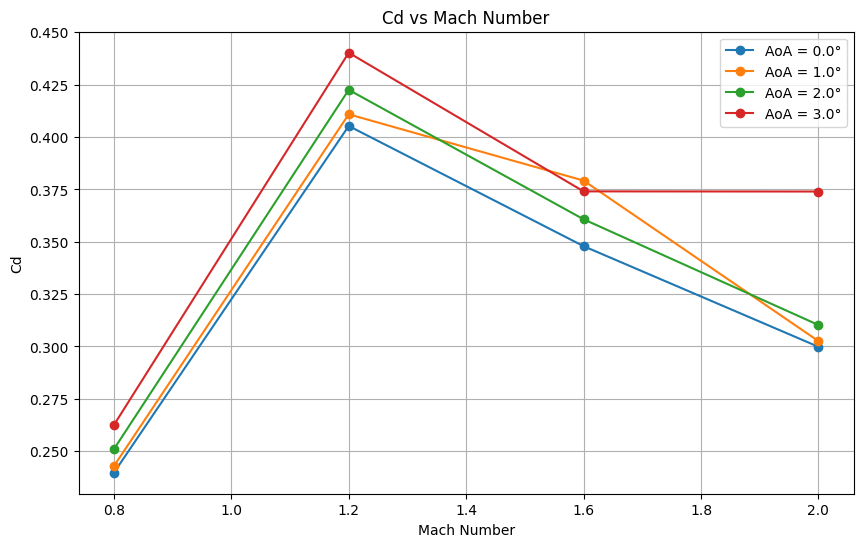

In [152]:
y_column = 'Cd'  # Change this to the column you want to plot

plt.figure(figsize=(10, 6))

# Get unique AoA values
aoa_values = sorted(the_df['AoA'].unique())

# Plot each AoA
for aoa in aoa_values:
    data = the_df[the_df['AoA'] == aoa].sort_values('Ma')
    plt.plot(data['Ma'], data[y_column], 'o-', label=f'AoA = {aoa}°')

plt.xlabel('Mach Number')
plt.ylabel(y_column)
plt.title(f'{y_column} vs Mach Number')
plt.legend()
plt.grid(True)
plt.show()


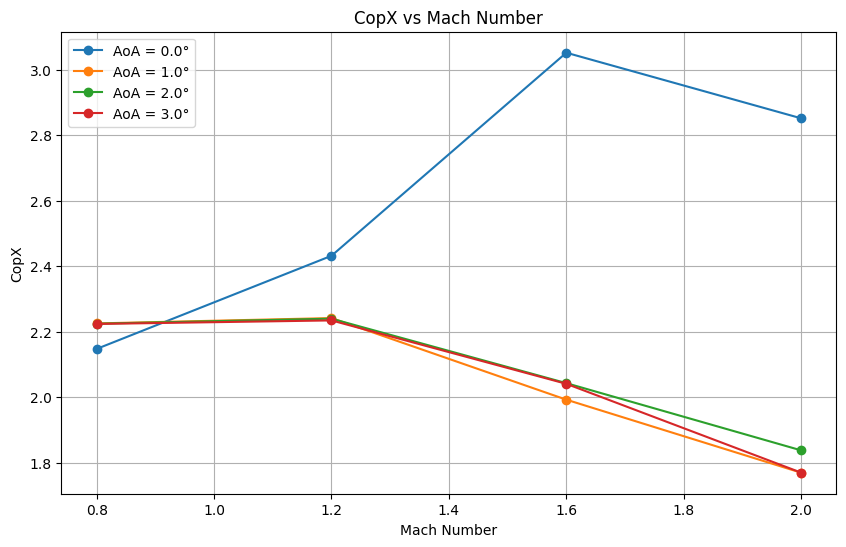

In [153]:
y_column = 'CopX'  # Change this to the column you want to plot

plt.figure(figsize=(10, 6))

# Get unique AoA values
aoa_values = sorted(the_df['AoA'].unique())

# Plot each AoA
for aoa in aoa_values:
    data = the_df[the_df['AoA'] == aoa].sort_values('Ma')
    plt.plot(data['Ma'], data[y_column], 'o-', label=f'AoA = {aoa}°')

plt.xlabel('Mach Number')
plt.ylabel(y_column)
plt.title(f'{y_column} vs Mach Number')
plt.legend()
plt.grid(True)
plt.show()


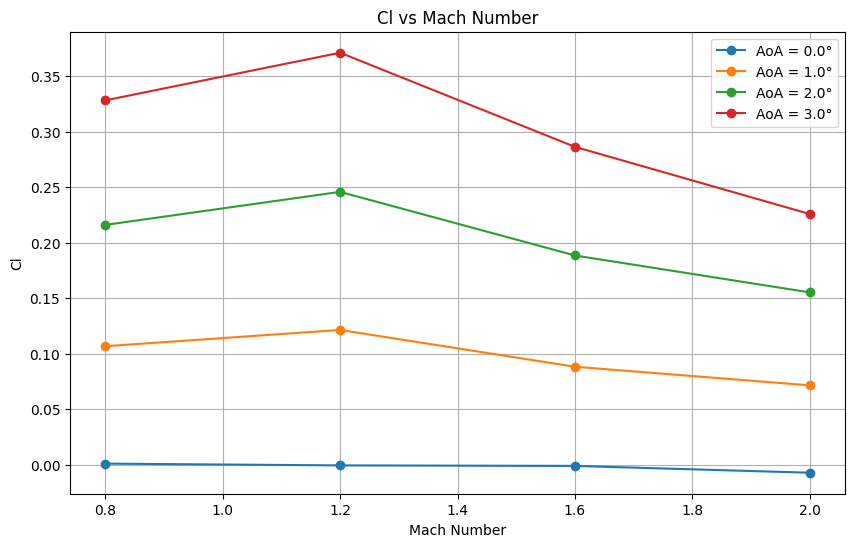

In [154]:
y_column = 'Cl'  # Change this to the column you want to plot

plt.figure(figsize=(10, 6))

# Get unique AoA values
aoa_values = sorted(the_df['AoA'].unique())

# Plot each AoA
for aoa in aoa_values:
    data = the_df[the_df['AoA'] == aoa].sort_values('Ma')
    plt.plot(data['Ma'], data[y_column], 'o-', label=f'AoA = {aoa}°')

plt.xlabel('Mach Number')
plt.ylabel(y_column)
plt.title(f'{y_column} vs Mach Number')
plt.legend()
plt.grid(True)
plt.show()


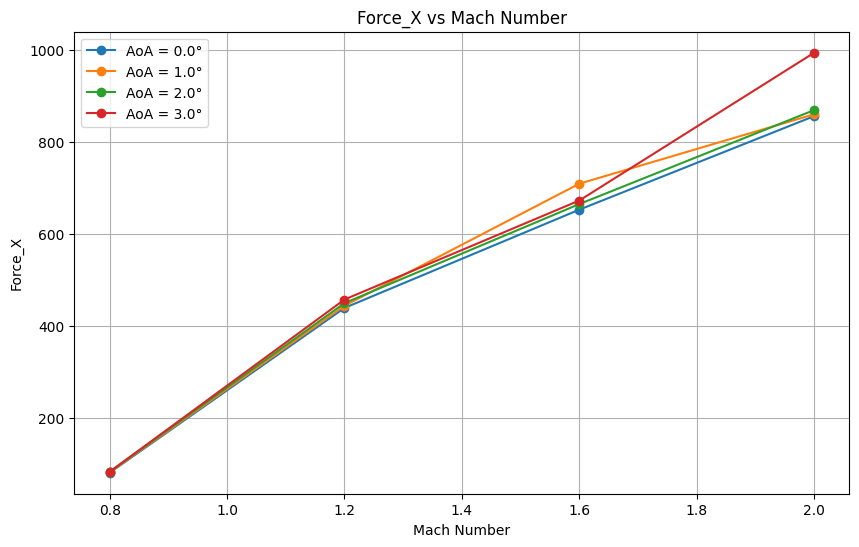

In [157]:
y_column = 'Force_X'  # Change this to the column you want to plot

plt.figure(figsize=(10, 6))

# Get unique AoA values
aoa_values = sorted(the_df['AoA'].unique())

# Plot each AoA
for aoa in aoa_values:
    data = the_df[the_df['AoA'] == aoa].sort_values('Ma')
    plt.plot(data['Ma'], data[y_column], 'o-', label=f'AoA = {aoa}°')

plt.xlabel('Mach Number')
plt.ylabel(y_column)
plt.title(f'{y_column} vs Mach Number')
plt.legend()
plt.grid(True)
plt.show()


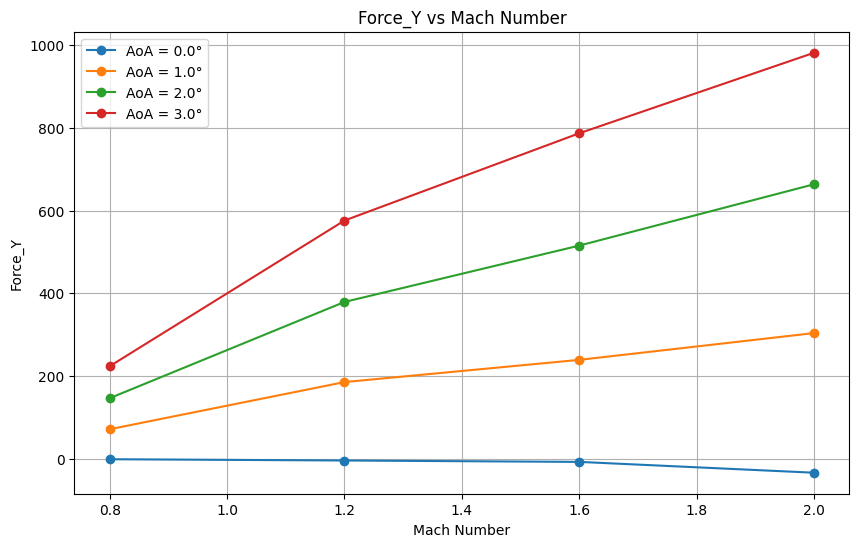

In [158]:
y_column = 'Force_Y'  # Change this to the column you want to plot

plt.figure(figsize=(10, 6))

# Get unique AoA values
aoa_values = sorted(the_df['AoA'].unique())

# Plot each AoA
for aoa in aoa_values:
    data = the_df[the_df['AoA'] == aoa].sort_values('Ma')
    plt.plot(data['Ma'], data[y_column], 'o-', label=f'AoA = {aoa}°')

plt.xlabel('Mach Number')
plt.ylabel(y_column)
plt.title(f'{y_column} vs Mach Number')
plt.legend()
plt.grid(True)
plt.show()


In [121]:
def main():
    # Load your mesh
    mesh = pv.read("Data/CollectedResults2/AoA_0p0_Ma_0p8/postProcessing/rocketVTK/5500/rocketWall.vtp")
    
    print("Mesh Information:")
    print(f"Number of cells: {mesh.n_cells}")
    print(f"Number of points: {mesh.n_points}")
    print(f"Available arrays: {mesh.array_names}")
    print(f"Bounds: {mesh.bounds}")
    
    # You may need to adjust the pressure field name based on your data
    # Common names: 'p', 'pressure', 'P', 'static_pressure'
    pressure_field = 'p'  # Adjust this based on your data
    
    try:
        # Compute center of pressure
        results = compute_center_of_pressure(mesh, pressure_field=pressure_field)
        
        print("\nResults:")
        print(f"Total Force: {results['total_force']}")
        print(f"Total Moment: {results['total_moment']}")
        print(f"Reference Point: {results['reference_point']}")
        print(f"Center of Pressure: {results['center_of_pressure']}")
        
        # Calculate some additional metrics
        force_magnitude = np.linalg.norm(results['total_force'])
        print(f"Force Magnitude: {force_magnitude}")
        
        # Distance from nose to center of pressure
        cp_distance = results['center_of_pressure'][0] - results['reference_point'][0]
        print(f"CP distance from nose: {cp_distance}")
        
        # Visualize results
        plotter = visualize_pressure_distribution(mesh, pressure_field, results)
        
        return results
        
    except ValueError as e:
        print(f"Error: {e}")
        print("Please check the pressure field name in your mesh data.")
        return None


In [125]:
_ = main()

Mesh Information:
Number of cells: 172662
Number of points: 177262
Available arrays: ['TimeValue', 'Ma', 'T', 'p', 'rho', 'U']
Bounds: BoundsTuple(x_min=4.932094663234743e-11, x_max=2.7820050716400146, y_min=-0.0876178964972496, y_max=0.171756312251091, z_min=-0.14978618919849396, z_max=0.14978618919849396)
Pressure data shape: (177262,)
Number of cells: 172662
Number of points: 177262
Converting point data to cell data...

Results:
Total Force: [-80.61312813   1.19716125   1.12969175]
Total Moment: [-0.17971305 -2.6259163   2.57054786]
Reference Point: [4.93209466e-11 0.00000000e+00 0.00000000e+00]
Center of Pressure: [2.1472027  0.03188746 0.        ]
Force Magnitude: 80.6299313241474
CP distance from nose: 2.1472026984379213


In [126]:
forces = load_dat("Data/CollectedResults2/AoA_0p0_Ma_0p8/postProcessing/forces/0/force.dat")
moments = load_dat("Data/CollectedResults2/AoA_0p0_Ma_0p8/postProcessing/forces/0/moment.dat")

forces

Time      total_x     total_y   total_z   pressure_x  pressure_y  \
0        1  1832.469521   14.588165 -1.540389  1744.351867   14.583347   
1        2  1803.707436  158.195178  1.504542  1719.116131  158.171851   
2        3  1546.908602   49.365871  2.049949  1465.049537   49.393778   
3        4  1236.823194  -21.026137  4.613649  1157.439373  -20.965846   
4        5   997.210175  -65.124765  4.920061   920.124041  -65.060092   
...    ...          ...         ...       ...          ...         ...   
5568  5569   155.721249    0.572584 -0.173624    79.418438    0.540539   
5569  5570   155.721474    0.575451 -0.210358    79.418754    0.543395   
5570  5571   155.724894    0.582969 -0.228000    79.422189    0.550900   
5571  5572   155.732309    0.589484 -0.234871    79.429670    0.557395   
5572  5573   155.733829    0.587580 -0.221828    79.431252    0.555486   

      pressure_z  viscous_x  viscous_y  viscous_z  
0      -1.532841  88.117654   0.004818  -0.007548  
1       1.513678  84.591306   0.023327  -0.009137  
2       2.057917  81.859065  -0.027907  -0.007968  
3       4.625277  79.383821  -0.060291  -0.011628  
4       4.927144  77.086134  -0.064673  -0.007084  
...          ...        ...        ...        ...  
5568   -0.176828  76.302811   0.032044   0.003205  
5569   -0.213528  76.302720   0.032056   0.003171  
5570   -0.231199  76.302705   0.032069   0.003199  
5571   -0.238153  76.302638   0.032088   0.003282  
5572   -0.225216  76.302577   0.032093   0.003388  

[5573 rows x 10 columns]

In [128]:
moments.columns

Index(['Time', 'total_x', 'total_y', 'total_z', 'pressure_x', 'pressure_y',
       'pressure_z', 'viscous_x', 'viscous_y', 'viscous_z'],
      dtype='object')

In [133]:
def compute_cop_from_openfoam_data(forces_df, moments_df, reference_point=None, use_final_row=True):
    """
    Compute center of pressure from OpenFOAM forces and moments data
    
    Parameters:
    -----------
    forces_df : pandas.DataFrame
        Forces data with columns: Time, total_x, total_y, total_z, pressure_x, pressure_y, pressure_z, viscous_x, viscous_y, viscous_z
    moments_df : pandas.DataFrame
        Moments data with same column structure
    reference_point : array-like, optional
        Reference point used in OpenFOAM (default: [0, 0, 0])
    use_final_row : bool
        If True, use the final (converged) row. If False, use all time steps
        
    Returns:
    --------
    dict : Dictionary containing center of pressure results
    """
    
    if reference_point is None:
        reference_point = np.array([0.0, 0.0, 0.0])  # Default OpenFOAM reference
    
    if use_final_row:
        # Use final converged values
        forces_final = forces_df.iloc[-1]
        moments_final = moments_df.iloc[-1]
        
        # Extract pressure forces (excluding viscous)
        F_p = np.array([forces_final['pressure_x'], 
                       forces_final['pressure_y'], 
                       forces_final['pressure_z']])
        
        # Extract pressure moments
        M_p = np.array([moments_final['pressure_x'], 
                       moments_final['pressure_y'], 
                       moments_final['pressure_z']])
        
        # Extract total forces for comparison
        F_total = np.array([forces_final['total_x'], 
                           forces_final['total_y'], 
                           forces_final['total_z']])
        
        M_total = np.array([moments_final['total_x'], 
                           moments_final['total_y'], 
                           moments_final['total_z']])
        
        # Calculate center of pressure using BOTH formulations
        
        # METHOD 1: Corrected Cross product formulation
        # CP = reference_point + (F × M) / |F|²
        cp_cross = np.zeros(3)
        F_mag_squared = np.dot(F_p, F_p)
        
        if F_mag_squared > 1e-20:  # Avoid division by zero
            # Correct cross product: F × M (not M × F)
            cross_product = np.cross(F_p, M_p)
            cp_cross = reference_point + cross_product / F_mag_squared
        else:
            cp_cross = reference_point.copy()
        
        # METHOD 2: Component-wise formulation  
        # CP_x = ref_x + M_z / F_y (for pitching moment)
        # CP_y = ref_y - M_z / F_x (for yawing moment)
        # CP_z = ref_z + M_y / F_x (for rolling moment)
        cp_component = np.zeros(3)
        
        # X-component (longitudinal position)
        if abs(F_p[1]) > 1e-10:  # F_y component
            cp_component[0] = reference_point[0] + M_p[2] / F_p[1]
        else:
            cp_component[0] = reference_point[0]
        
        # Y-component (vertical position)
        if abs(F_p[0]) > 1e-10:  # F_x component
            cp_component[1] = reference_point[1] - M_p[2] / F_p[0]
        else:
            cp_component[1] = reference_point[1]
            
        # Z-component (lateral position)
        if abs(F_p[0]) > 1e-10:  # F_x component
            cp_component[2] = reference_point[2] + M_p[1] / F_p[0]
        else:
            cp_component[2] = reference_point[2]
        
        results = {
            'center_of_pressure_cross': cp_cross,
            'center_of_pressure_component': cp_component,
            'difference': cp_cross - cp_component,
            'pressure_forces': F_p,
            'pressure_moments': M_p,
            'total_forces': F_total,
            'total_moments': M_total,
            'reference_point': reference_point,
            'time': forces_final['Time'],
            'force_magnitude': np.sqrt(F_mag_squared)
        }
        
    else:
        # Process all time steps
        results = []
        for i in range(len(forces_df)):
            forces_row = forces_df.iloc[i]
            moments_row = moments_df.iloc[i]
            
            F_p = np.array([forces_row['pressure_x'], 
                           forces_row['pressure_y'], 
                           forces_row['pressure_z']])
            
            M_p = np.array([moments_row['pressure_x'], 
                           moments_row['pressure_y'], 
                           moments_row['pressure_z']])
            
            # Calculate both formulations for time series
            cp_cross = np.zeros(3)
            F_mag_squared = np.dot(F_p, F_p)
            
            if F_mag_squared > 1e-20:
                # Correct cross product: F × M
                cross_product = np.cross(F_p, M_p)
                cp_cross = reference_point + cross_product / F_mag_squared
            else:
                cp_cross = reference_point.copy()
            
            cp_component = np.zeros(3)
            
            if abs(F_p[1]) > 1e-10:
                cp_component[0] = reference_point[0] + M_p[2] / F_p[1]
            else:
                cp_component[0] = reference_point[0]
            
            if abs(F_p[0]) > 1e-10:
                cp_component[1] = reference_point[1] - M_p[2] / F_p[0]
                cp_component[2] = reference_point[2] + M_p[1] / F_p[0]
            else:
                cp_component[1] = reference_point[1]
                cp_component[2] = reference_point[2]
            
            results.append({
                'time': forces_row['Time'],
                'center_of_pressure_cross': cp_cross,
                'center_of_pressure_component': cp_component,
                'difference': cp_cross - cp_component,
                'pressure_forces': F_p,
                'pressure_moments': M_p
            })
    
    return results

In [134]:
compute_cop_from_openfoam_data(forces, moments)

{'center_of_pressure_cross': array([ 0.00016934, -0.02260535,  0.00396857]),
 'center_of_pressure_component': array([ 3.23257796, -0.02260638,  0.00396942]),
 'difference': array([-3.23240862e+00,  1.03455443e-06, -8.49310301e-07]),
 'pressure_forces': array([79.43125234,  0.55548639, -0.22521628]),
 'pressure_moments': array([0.00707977, 0.31529618, 1.79565306]),
 'total_forces': array([155.7338291 ,   0.58757982,  -0.22182779]),
 'total_moments': array([0.0068801 , 0.30474304, 1.97606329]),
 'reference_point': array([0., 0., 0.]),
 'time': np.float64(5573.0),
 'force_magnitude': np.float64(79.43351393437295)}